In [129]:
import gzip
import pickle

import ra_pickles
from calo.event_generator import EventGenerator
import numpy as np
import tensorflow as tf
from calo.config import is_laptop

from matplotlib import pyplot as plt

In [114]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calibration dataset
A set of simulations are used to perform the calibration. $\gamma$ should be used for EM particlese and $\pi^+$ for hadrons. This has been
tested with $2000$ particles in each of the categories. `run_simulations.py` script can be used to generate these datasets (within the
singularity/docker container). The recommended properties are $1.7 < |\eta| < 2.8$ and $0.1 < E~\mathrm{[GeV]} < 200$. Change the paths
accordingly. A calibration dataset can also be downloaded, as it follows:

In [ ]:
import requests
import zipfile
import shutil
import os

def download(url, filename):
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)

if os.path.exists('data'):
    shutil.rmtree('data')
if os.path.exists('data.zip'):
    os.unlink('data.zip')

download('https://github.com/shahrukhqasim/hg_toy_calorimeter_data/raw/master/data.zip', 'data.zip')
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

os.unlink('data.zip')

# Sensor data
Sensor data can be extracted by running `extract_sensor_data.py`. It can also be downloaded, as it follows:

In [ ]:
if os.path.exists('sensor_data_v3.bin'):
    os.unlink('sensor_data_v3.bin')

download('https://github.com/shahrukhqasim/hg_toy_calorimeter_data/raw/master/sensor_data_v3.bin', 'sensor_data_v3.bin')

Load the calibration and sensor data into memory:

In [115]:
em_path = 'data/em'
had_path = 'data/had'

em_reader = ra_pickles.RandomAccessPicklesReader(em_path)
had_reader = ra_pickles.RandomAccessPicklesReader(had_path)

em_sims = [em_reader.get_element(x) for x in range(em_reader.get_total())]
had_sims = [had_reader.get_element(x) for x in range(had_reader.get_total())]

with gzip.open('sensor_data_v3.bin', 'rb') as f:
    sensor_data = pickle.load(f)
    
print('There are %d electromagnetic samples and %d hadronic samples'%(len(em_sims), len(had_sims)))

print('There are %d sensors in the detector'%len(sensor_data['sensors_x']))

Reading meta files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 6829.22it/s]


Reading meta files


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 7359.98it/s]


There are 2000 electromagnetic samples and 2000 hadronic samples
There are 3102332 sensors in the detector


`sensors_scaling` is used to scale the sensor reading by the `EventGenerator`. Begin by setting it according to its pre-absorber thickness:

In [116]:
sensor_scaling = 1 + sensor_data['sensors_pre_absorber_thickness']/sensor_data['sensors_thickness']
global_scaling_factor = 2.9
sensor_scaling = sensor_scaling * global_scaling_factor
sensor_data['sensors_scaling'] = sensor_scaling

In [117]:
cut = 0.000
cut_2 = 0.0009

# EM Calibration

In [118]:
noise_fluctuations = ('type_a', 0, 5.2e-13) # Noise level set to a very low value
gen = EventGenerator(sensor_data, noise_fluctuations, cut=cut_2, num_hits_cut=3,
                     reduce=True, area_normed_cut=True, merge_closeby_particles=False, verbose=False,
                    collect_truth=False)



In [119]:
from tqdm import tqdm

print(len(em_sims))

N = len(em_sims)
# N = min(100, N)


em_dep = []
em_true = []
for i in tqdm(range(N)):
    sim = em_sims[i]
    gen.add([sim[0]])
    result = gen.process()
    em_dep += [np.sum(result['rechit_energy'])]
    em_true += [sim[1]['energy']]


2000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:31<00:00,  2.46it/s]


In [120]:
em_dep = np.array(em_dep, np.float32)
em_true = np.array(em_true, np.float32)

g_em, _, _, _ = np.linalg.lstsq(em_dep[:, np.newaxis], em_true[:, np.newaxis])

print("EM calibration constant is", g_em)
g_em = g_em[0][0]

EM calibration constant is [[1.0316283]]


/var/folders/4v/gfv88pzj0cg0f6mpfd5pd09m0000gn/T/ipykernel_1207/1789735089.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g_em, _, _, _ = np.linalg.lstsq(em_dep[:, np.newaxis], em_true[:, np.newaxis])


# Hadronic calibration

Once the sensors have been calibrated with photons ($\gamma$), the calibration constant in the EM layers is frozen and the the rest is calibrated with charged pions ($\pi^+$).

In [121]:
from copy import deepcopy

sensor_data_calibrated_no_had = deepcopy(sensor_data)
sensor_data_calibrated_no_had['sensors_scaling'][sensor_data_calibrated_no_had['sensors_active_layer_num']>=28] = 0.0
sensor_data_calibrated_no_had['sensors_scaling'] = sensor_data_calibrated_no_had['sensors_scaling'] * g_em

gen_calibrated_no_had = EventGenerator(sensor_data_calibrated_no_had, noise_fluctuations, cut=cut,
                                       num_hits_cut=3, reduce=True, area_normed_cut=True,
                                       merge_closeby_particles=False, collect_truth=False)


sensor_data_no_em = deepcopy(sensor_data)
sensor_data_no_em['sensors_scaling'][sensor_data_calibrated_no_had['sensors_active_layer_num']<28] = 0.0

gen_no_em = EventGenerator(sensor_data_no_em, noise_fluctuations, cut=cut,
                                       num_hits_cut=3, reduce=True, area_normed_cut=True,
                                       merge_closeby_particles=False, collect_truth=False)

$E_{\mathrm{dep}}$

In [122]:
print(len(had_sims))

N = len(had_sims)
# N = min(100, N)


had_dep = []
had_true = []
for i in tqdm(range(N)):
    sim = had_sims[i]

    gen_calibrated_no_had.add([sim[0]])
    result_c_no_had = gen_calibrated_no_had.process()
    
    gen_no_em.add([sim[0]])
    result_no_em = gen_no_em.process()
    
    dep_on_em_layers = np.sum(result_c_no_had['rechit_energy'])    
    had_true += [sim[1]['energy'] - dep_on_em_layers]

    had_dep += [np.sum(result_no_em['rechit_energy'])]


2000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [30:57<00:00,  1.08it/s]


In [125]:
had_dep = np.array(had_dep, np.float32)
had_true = np.array(had_true, np.float32)

print(sensor_data['sensors_scaling'])

filter = np.logical_and(0.5 < had_dep / had_true, had_dep / had_true < 2 )
filter = np.logical_and(filter, had_true > 5)

# filter = np.logical_or(filter, True)

g_had, _, _, _ = np.linalg.lstsq(had_dep[filter][:, np.newaxis], had_true[filter][:, np.newaxis])

print("Had calibration constant is", g_had)
g_had = g_had[0][0]

[   2.9     2.9     2.9  ... 1098.23 1098.23 1098.23]
Had calibration constant is [[1.1859236]]


/var/folders/4v/gfv88pzj0cg0f6mpfd5pd09m0000gn/T/ipykernel_1207/2747486787.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  g_had, _, _, _ = np.linalg.lstsq(had_dep[filter][:, np.newaxis], had_true[filter][:, np.newaxis])


In [126]:
# g_had = 5.077009
# g_em = 3.4087722

In [127]:
sensor_data_calibrated = deepcopy(sensor_data)
sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']<28]\
= sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']<28] * g_em


sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']>=28]\
= sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']>=28] * g_had


print(sensor_data_calibrated['sensors_scaling'])


gen_calibrated = EventGenerator(sensor_data_calibrated, noise_fluctuations, cut=cut_2,
                                       num_hits_cut=3, reduce=True, area_normed_cut=True,
                                       merge_closeby_particles=False, collect_truth=False)

    
sensor_data_calibrated_em_only = deepcopy(sensor_data)
sensor_data_calibrated_em_only['sensors_scaling']\
= sensor_data_calibrated_em_only['sensors_scaling'] * g_em

print(sensor_data_calibrated_em_only['sensors_scaling'])

    
gen_calibrated_only_em = EventGenerator(sensor_data_calibrated_em_only, noise_fluctuations, cut=cut_2,
                                       num_hits_cut=3, reduce=True, area_normed_cut=True,
                                       merge_closeby_particles=False, collect_truth=False)

[   2.99172193    2.99172193    2.99172193 ... 1302.41684926 1302.41684926
 1302.41684926]
[   2.99172193    2.99172193    2.99172193 ... 1132.96509418 1132.96509418
 1132.96509418]


In [130]:
print(len(had_sims))

N = min(len(had_sims), len(em_sims))
# N = min(100, N)

E_dep_em_had = []
E_dep_em  = []
E_true = []

for i in tqdm(range(N)):
    sim = had_sims[i]

    gen_calibrated.add([sim[0]])
    result_calibrated = gen_calibrated.process()
    
    gen_calibrated_only_em.add([sim[0]])
    result_calibrated_only_em = gen_calibrated_only_em.process()
    
    e_dep_em_had = np.sum(result_calibrated['rechit_energy'])
    e_dep_em = np.sum(result_calibrated_only_em['rechit_energy'])
    e_true = sim[1]['energy']
    
    E_dep_em_had += [e_dep_em_had]
    E_dep_em += [e_dep_em]
    E_true += [e_true]
    
    print('E', sim[1]['energy'],'E_dep [had+em calib]',\
         np.sum(result_calibrated['rechit_energy']), 'E_dep [em calib]',\
         np.sum(result_calibrated_only_em['rechit_energy']))
    
    
E_dep_em_had = np.array(E_dep_em_had)
E_dep_em  = np.array(E_dep_em)
E_true = np.array(E_true)

2000


  0%|                                                                                                                                                                                                               | 1/2000 [00:01<53:22,  1.60s/it]

E 21.72459496233544 E_dep [had+em calib] 21.46140350533902 E_dep [em calib] 18.720092350522215


  0%|▏                                                                                                                                                                                                              | 2/2000 [00:02<44:06,  1.32s/it]

E 144.62812437574354 E_dep [had+em calib] 87.089078903887 E_dep [em calib] 75.76286255035407


  0%|▎                                                                                                                                                                                                              | 3/2000 [00:03<40:05,  1.20s/it]

E 19.489783263161325 E_dep [had+em calib] 7.1694302242863674 E_dep [em calib] 6.2612247888299475


  0%|▍                                                                                                                                                                                                              | 4/2000 [00:04<37:43,  1.13s/it]

E 171.69626258728036 E_dep [had+em calib] 151.01767946506277 E_dep [em calib] 142.1759288184407


  0%|▌                                                                                                                                                                                                              | 5/2000 [00:05<36:29,  1.10s/it]

E 59.99331297715434 E_dep [had+em calib] 60.43549630414692 E_dep [em calib] 52.59262125668574


  0%|▌                                                                                                                                                                                                              | 6/2000 [00:06<35:39,  1.07s/it]

E 56.069652857052986 E_dep [had+em calib] 49.332515462297714 E_dep [em calib] 42.939270241860775


  0%|▋                                                                                                                                                                                                              | 7/2000 [00:07<34:34,  1.04s/it]

E 85.152402567034 E_dep [had+em calib] 92.0327901229878 E_dep [em calib] 80.13238252413198


  0%|▊                                                                                                                                                                                                              | 8/2000 [00:08<34:01,  1.02s/it]

E 168.72675627118474 E_dep [had+em calib] 159.7181580970861 E_dep [em calib] 138.9936432807422


  0%|▉                                                                                                                                                                                                              | 9/2000 [00:09<34:17,  1.03s/it]

E 47.91960604301908 E_dep [had+em calib] 40.162622532763805 E_dep [em calib] 35.99155573875438


  0%|█                                                                                                                                                                                                             | 10/2000 [00:10<33:18,  1.00s/it]

E 193.1818072506246 E_dep [had+em calib] 148.37942707167636 E_dep [em calib] 132.14445064988556


  1%|█▏                                                                                                                                                                                                            | 11/2000 [00:11<32:40,  1.01it/s]

E 41.56901968739542 E_dep [had+em calib] 35.938629348802955 E_dep [em calib] 32.73417084091108


  1%|█▏                                                                                                                                                                                                            | 12/2000 [00:12<32:05,  1.03it/s]

E 41.61810826639174 E_dep [had+em calib] 32.69757777168818 E_dep [em calib] 30.382513135530512


  1%|█▎                                                                                                                                                                                                            | 13/2000 [00:13<31:52,  1.04it/s]

E 167.1952885680425 E_dep [had+em calib] 135.84782021128902 E_dep [em calib] 122.25038262170314


  1%|█▍                                                                                                                                                                                                            | 14/2000 [00:14<31:45,  1.04it/s]

E 78.71746954145169 E_dep [had+em calib] 46.863384609638075 E_dep [em calib] 40.88380981511005


  1%|█▌                                                                                                                                                                                                            | 15/2000 [00:15<31:33,  1.05it/s]

E 41.711779315213754 E_dep [had+em calib] 36.908233571031786 E_dep [em calib] 32.10822498733709


  1%|█▋                                                                                                                                                                                                            | 16/2000 [00:16<31:50,  1.04it/s]

E 35.27460446953616 E_dep [had+em calib] 30.12782708969683 E_dep [em calib] 27.373194821195113


  1%|█▊                                                                                                                                                                                                            | 17/2000 [00:17<32:16,  1.02it/s]

E 97.11625953912856 E_dep [had+em calib] 89.77145971325298 E_dep [em calib] 78.4218261112073


  1%|█▊                                                                                                                                                                                                            | 18/2000 [00:18<32:19,  1.02it/s]

E 124.99924306454474 E_dep [had+em calib] 131.53712474154793 E_dep [em calib] 114.49638811031612


  1%|█▉                                                                                                                                                                                                            | 19/2000 [00:19<33:33,  1.02s/it]

E 85.97811945489886 E_dep [had+em calib] 121.30598922297966 E_dep [em calib] 105.55156486127247


  1%|██                                                                                                                                                                                                            | 20/2000 [00:20<33:54,  1.03s/it]

E 136.63570848265536 E_dep [had+em calib] 154.33774205539748 E_dep [em calib] 134.2879214671534


  1%|██▏                                                                                                                                                                                                           | 21/2000 [00:21<33:50,  1.03s/it]

E 113.77785335940152 E_dep [had+em calib] 128.01729714852766 E_dep [em calib] 111.47941325152392


  1%|██▎                                                                                                                                                                                                           | 22/2000 [00:22<33:31,  1.02s/it]

E 33.78629276607809 E_dep [had+em calib] 66.40641178633338 E_dep [em calib] 59.60051617487086


  1%|██▎                                                                                                                                                                                                           | 23/2000 [00:23<33:16,  1.01s/it]

E 134.22789571860045 E_dep [had+em calib] 120.13197001930602 E_dep [em calib] 107.72733607438157


  1%|██▍                                                                                                                                                                                                           | 24/2000 [00:24<33:21,  1.01s/it]

E 82.54387568899963 E_dep [had+em calib] 90.4635064341501 E_dep [em calib] 78.77444345727757


  1%|██▌                                                                                                                                                                                                           | 25/2000 [00:25<33:30,  1.02s/it]

E 140.08404689893072 E_dep [had+em calib] 132.9930692297285 E_dep [em calib] 124.47963006847257


  1%|██▋                                                                                                                                                                                                           | 26/2000 [00:26<33:03,  1.00s/it]

E 198.86379655636588 E_dep [had+em calib] 160.5170769222395 E_dep [em calib] 150.28524162503072


  1%|██▊                                                                                                                                                                                                           | 27/2000 [00:27<32:28,  1.01it/s]

E 114.01073860835513 E_dep [had+em calib] 104.90071611689166 E_dep [em calib] 91.96169630706346


  1%|██▉                                                                                                                                                                                                           | 28/2000 [00:28<33:10,  1.01s/it]

E 120.04160315427539 E_dep [had+em calib] 105.05928320797787 E_dep [em calib] 91.41491070883187


  1%|██▉                                                                                                                                                                                                           | 29/2000 [00:29<32:51,  1.00s/it]

E 153.28131438355248 E_dep [had+em calib] 170.78875860497908 E_dep [em calib] 155.63209613622803


  2%|███                                                                                                                                                                                                           | 30/2000 [00:30<32:41,  1.00it/s]

E 44.25614273250203 E_dep [had+em calib] 36.48325088354019 E_dep [em calib] 31.86671474299898


  2%|███▏                                                                                                                                                                                                          | 31/2000 [00:31<32:19,  1.02it/s]

E 165.09404812795617 E_dep [had+em calib] 124.67627316329876 E_dep [em calib] 110.0577839858711


  2%|███▎                                                                                                                                                                                                          | 32/2000 [00:32<32:07,  1.02it/s]

E 130.26554459241007 E_dep [had+em calib] 109.75764082867848 E_dep [em calib] 97.17329969454283


  2%|███▍                                                                                                                                                                                                          | 33/2000 [00:33<32:22,  1.01it/s]

E 29.90216399151188 E_dep [had+em calib] 26.51807986049295 E_dep [em calib] 23.121458928063532


  2%|███▌                                                                                                                                                                                                          | 34/2000 [00:34<32:22,  1.01it/s]

E 103.99074710955034 E_dep [had+em calib] 106.27523487064754 E_dep [em calib] 94.26367876563226


  2%|███▌                                                                                                                                                                                                          | 35/2000 [00:35<32:32,  1.01it/s]

E 126.56458296781024 E_dep [had+em calib] 119.0835325409963 E_dep [em calib] 109.38916968496335


  2%|███▋                                                                                                                                                                                                          | 36/2000 [00:36<32:17,  1.01it/s]

E 190.51842208651144 E_dep [had+em calib] 159.19365138390225 E_dep [em calib] 138.51112707572284


  2%|███▊                                                                                                                                                                                                          | 37/2000 [00:37<32:25,  1.01it/s]

E 194.00415968571997 E_dep [had+em calib] 230.24525471403038 E_dep [em calib] 202.64521385166262


  2%|███▉                                                                                                                                                                                                          | 38/2000 [00:38<32:38,  1.00it/s]

E 75.20576265303099 E_dep [had+em calib] 81.8711786787675 E_dep [em calib] 71.63516847525429


  2%|████                                                                                                                                                                                                          | 39/2000 [00:39<32:27,  1.01it/s]

E 66.92652431847067 E_dep [had+em calib] 67.57785687217707 E_dep [em calib] 59.243305021828505


  2%|████                                                                                                                                                                                                          | 40/2000 [00:40<32:44,  1.00s/it]

E 101.49753360430712 E_dep [had+em calib] 57.59417807976215 E_dep [em calib] 50.10683506619607


  2%|████▏                                                                                                                                                                                                         | 41/2000 [00:41<32:32,  1.00it/s]

E 37.015394516002516 E_dep [had+em calib] 39.03243211927009 E_dep [em calib] 33.9913148768885


  2%|████▎                                                                                                                                                                                                         | 42/2000 [00:42<32:20,  1.01it/s]

E 131.47286365519156 E_dep [had+em calib] 110.140181197297 E_dep [em calib] 99.35082551406957


  2%|████▍                                                                                                                                                                                                         | 43/2000 [00:43<31:48,  1.03it/s]

E 127.98660041054251 E_dep [had+em calib] 154.24209485817295 E_dep [em calib] 134.28122027347342


  2%|████▌                                                                                                                                                                                                         | 44/2000 [00:44<31:24,  1.04it/s]

E 174.2064419760135 E_dep [had+em calib] 177.8906594933512 E_dep [em calib] 154.7725820003638


  2%|████▋                                                                                                                                                                                                         | 45/2000 [00:45<31:35,  1.03it/s]

E 125.54879689527222 E_dep [had+em calib] 131.12385755445666 E_dep [em calib] 114.41743045705982


  2%|████▋                                                                                                                                                                                                         | 46/2000 [00:46<31:50,  1.02it/s]

E 106.46175063842884 E_dep [had+em calib] 90.50048179903523 E_dep [em calib] 80.71289155578904


  2%|████▊                                                                                                                                                                                                         | 47/2000 [00:47<31:55,  1.02it/s]

E 189.23301200801382 E_dep [had+em calib] 167.0554425178196 E_dep [em calib] 147.5426763442709


  2%|████▉                                                                                                                                                                                                         | 48/2000 [00:48<31:24,  1.04it/s]

E 173.43435159884498 E_dep [had+em calib] 137.41664459183667 E_dep [em calib] 123.62981672420078


  2%|█████                                                                                                                                                                                                         | 49/2000 [00:49<31:30,  1.03it/s]

E 95.8722998869631 E_dep [had+em calib] 77.77632901161105 E_dep [em calib] 68.7672529412592


  2%|█████▏                                                                                                                                                                                                        | 50/2000 [00:50<31:21,  1.04it/s]

E 76.62094487444693 E_dep [had+em calib] 56.58832133981956 E_dep [em calib] 53.42044945187871


  3%|█████▎                                                                                                                                                                                                        | 51/2000 [00:51<30:57,  1.05it/s]

E 194.17414914960236 E_dep [had+em calib] 186.8550441428471 E_dep [em calib] 162.58442637505237


  3%|█████▎                                                                                                                                                                                                        | 52/2000 [00:52<30:50,  1.05it/s]

E 56.316254624013844 E_dep [had+em calib] 26.66408238276067 E_dep [em calib] 23.20554343323504


  3%|█████▍                                                                                                                                                                                                        | 53/2000 [00:53<30:41,  1.06it/s]

E 111.76029562815417 E_dep [had+em calib] 118.60725514297116 E_dep [em calib] 103.29626894080735


  3%|█████▌                                                                                                                                                                                                        | 54/2000 [00:54<31:08,  1.04it/s]

E 14.032844297588602 E_dep [had+em calib] 7.133622870867675 E_dep [em calib] 6.394328297726192


  3%|█████▋                                                                                                                                                                                                        | 55/2000 [00:54<30:41,  1.06it/s]

E 132.8108372142996 E_dep [had+em calib] 122.00568635632689 E_dep [em calib] 107.84462022830473


  3%|█████▊                                                                                                                                                                                                        | 56/2000 [00:55<31:00,  1.04it/s]

E 126.93727700372867 E_dep [had+em calib] 153.96074498860318 E_dep [em calib] 136.979973953675


  3%|█████▊                                                                                                                                                                                                        | 57/2000 [00:56<31:07,  1.04it/s]

E 196.52095172754488 E_dep [had+em calib] 208.898648047333 E_dep [em calib] 181.86841641925398


  3%|█████▉                                                                                                                                                                                                        | 58/2000 [00:57<30:49,  1.05it/s]

E 103.93559722157006 E_dep [had+em calib] 94.1918003114972 E_dep [em calib] 81.97103172598892


  3%|██████                                                                                                                                                                                                        | 59/2000 [00:58<30:31,  1.06it/s]

E 116.81406950110693 E_dep [had+em calib] 111.21501264384581 E_dep [em calib] 101.68262498882252


  3%|██████▏                                                                                                                                                                                                       | 60/2000 [00:59<30:34,  1.06it/s]

E 94.00840839541596 E_dep [had+em calib] 62.010869565905075 E_dep [em calib] 54.794324367704206


  3%|██████▎                                                                                                                                                                                                       | 61/2000 [01:00<30:43,  1.05it/s]

E 153.47717160849507 E_dep [had+em calib] 147.77664590492176 E_dep [em calib] 128.62506064601538


  3%|██████▍                                                                                                                                                                                                       | 62/2000 [01:01<30:24,  1.06it/s]

E 35.5333948624242 E_dep [had+em calib] 33.066436707711894 E_dep [em calib] 28.799319902224955


  3%|██████▍                                                                                                                                                                                                       | 63/2000 [01:02<29:58,  1.08it/s]

E 70.43205633037603 E_dep [had+em calib] 66.21268445467692 E_dep [em calib] 58.07210195667418


  3%|██████▌                                                                                                                                                                                                       | 64/2000 [01:03<29:41,  1.09it/s]

E 144.87042915668596 E_dep [had+em calib] 129.88812034983172 E_dep [em calib] 115.03107754917232


  3%|██████▋                                                                                                                                                                                                       | 65/2000 [01:04<29:32,  1.09it/s]

E 174.5674986744631 E_dep [had+em calib] 140.25220361129524 E_dep [em calib] 122.74214986700348


  3%|██████▊                                                                                                                                                                                                       | 66/2000 [01:05<29:44,  1.08it/s]

E 175.56732396997884 E_dep [had+em calib] 163.7573021135017 E_dep [em calib] 142.49618416804054


  3%|██████▉                                                                                                                                                                                                       | 67/2000 [01:06<29:31,  1.09it/s]

E 42.82165861538089 E_dep [had+em calib] 34.67299886724946 E_dep [em calib] 32.50030072629425


  3%|███████                                                                                                                                                                                                       | 68/2000 [01:07<29:08,  1.10it/s]

E 73.05520234904907 E_dep [had+em calib] 55.57065872195979 E_dep [em calib] 49.67827585498615


  3%|███████                                                                                                                                                                                                       | 69/2000 [01:07<28:59,  1.11it/s]

E 194.14687198840667 E_dep [had+em calib] 159.44372542999704 E_dep [em calib] 138.71490932063543


  4%|███████▏                                                                                                                                                                                                      | 70/2000 [01:08<28:42,  1.12it/s]

E 116.64528540479597 E_dep [had+em calib] 93.93705822757371 E_dep [em calib] 81.80275340321677


  4%|███████▎                                                                                                                                                                                                      | 71/2000 [01:09<28:31,  1.13it/s]

E 150.7826440145177 E_dep [had+em calib] 235.94055998781008 E_dep [em calib] 205.37185228372266


  4%|███████▍                                                                                                                                                                                                      | 72/2000 [01:10<28:30,  1.13it/s]

E 21.4825472685106 E_dep [had+em calib] 18.061532470135585 E_dep [em calib] 15.7544946491818


  4%|███████▌                                                                                                                                                                                                      | 73/2000 [01:11<28:15,  1.14it/s]

E 15.565686104150812 E_dep [had+em calib] 13.762786000641016 E_dep [em calib] 12.245109898891624


  4%|███████▌                                                                                                                                                                                                      | 74/2000 [01:12<28:25,  1.13it/s]

E 167.4032003752864 E_dep [had+em calib] 165.84588240735442 E_dep [em calib] 144.55980318161082


  4%|███████▋                                                                                                                                                                                                      | 75/2000 [01:13<28:23,  1.13it/s]

E 184.28363666219994 E_dep [had+em calib] 183.49617296965286 E_dep [em calib] 170.92643208159149


  4%|███████▊                                                                                                                                                                                                      | 76/2000 [01:14<28:15,  1.13it/s]

E 173.54505462378654 E_dep [had+em calib] 118.00202352758167 E_dep [em calib] 102.65726679454374


  4%|███████▉                                                                                                                                                                                                      | 77/2000 [01:14<27:56,  1.15it/s]

E 189.94943860051876 E_dep [had+em calib] 181.5624293713373 E_dep [em calib] 166.71907503859168


  4%|████████                                                                                                                                                                                                      | 78/2000 [01:15<27:56,  1.15it/s]

E 98.10582628387517 E_dep [had+em calib] 69.1977360097275 E_dep [em calib] 60.223992907943554


  4%|████████▏                                                                                                                                                                                                     | 79/2000 [01:16<28:02,  1.14it/s]

E 188.9253471967426 E_dep [had+em calib] 200.74754733985762 E_dep [em calib] 183.3131278332331


  4%|████████▏                                                                                                                                                                                                     | 80/2000 [01:17<28:17,  1.13it/s]

E 139.02374172919568 E_dep [had+em calib] 153.56413622627 E_dep [em calib] 133.61568234927273


  4%|████████▎                                                                                                                                                                                                     | 81/2000 [01:18<28:29,  1.12it/s]

E 5.4414534192156845 E_dep [had+em calib] 5.081725431156378 E_dep [em calib] 4.638882399886391


  4%|████████▍                                                                                                                                                                                                     | 82/2000 [01:19<28:11,  1.13it/s]

E 120.50412012601885 E_dep [had+em calib] 109.08211099168119 E_dep [em calib] 102.33526761602626


  4%|████████▌                                                                                                                                                                                                     | 83/2000 [01:20<28:05,  1.14it/s]

E 66.33237708271204 E_dep [had+em calib] 46.700094444422426 E_dep [em calib] 40.64934496615317


  4%|████████▋                                                                                                                                                                                                     | 84/2000 [01:21<28:04,  1.14it/s]

E 14.971929306954246 E_dep [had+em calib] 12.975828147038252 E_dep [em calib] 11.320680188382802


  4%|████████▊                                                                                                                                                                                                     | 85/2000 [01:21<27:56,  1.14it/s]

E 186.91226455272525 E_dep [had+em calib] 178.30051018373325 E_dep [em calib] 155.25053315696985


  4%|████████▊                                                                                                                                                                                                     | 86/2000 [01:22<27:47,  1.15it/s]

E 139.46493676945008 E_dep [had+em calib] 115.52478400789727 E_dep [em calib] 100.94249512359471


  4%|████████▉                                                                                                                                                                                                     | 87/2000 [01:23<27:51,  1.14it/s]

E 172.3569470184232 E_dep [had+em calib] 154.29406808216825 E_dep [em calib] 134.23457809449116


  4%|█████████                                                                                                                                                                                                     | 88/2000 [01:24<27:46,  1.15it/s]

E 109.36038446304168 E_dep [had+em calib] 91.2989971748205 E_dep [em calib] 79.59899478179753


  4%|█████████▏                                                                                                                                                                                                    | 89/2000 [01:25<27:44,  1.15it/s]

E 55.51026479316736 E_dep [had+em calib] 50.921751740984476 E_dep [em calib] 47.97840542646438


  4%|█████████▎                                                                                                                                                                                                    | 90/2000 [01:26<27:55,  1.14it/s]

E 195.11777681363492 E_dep [had+em calib] 216.18312587361248 E_dep [em calib] 188.28962407282864


  5%|█████████▎                                                                                                                                                                                                    | 91/2000 [01:27<27:53,  1.14it/s]

E 170.38949029177962 E_dep [had+em calib] 137.25232013024916 E_dep [em calib] 119.42175454700569


  5%|█████████▍                                                                                                                                                                                                    | 92/2000 [01:28<27:51,  1.14it/s]

E 74.09171871796232 E_dep [had+em calib] 42.462481114083985 E_dep [em calib] 36.975964114393705


  5%|█████████▌                                                                                                                                                                                                    | 93/2000 [01:28<27:50,  1.14it/s]

E 143.58845104383076 E_dep [had+em calib] 162.1276854490319 E_dep [em calib] 141.05295566319418


  5%|█████████▋                                                                                                                                                                                                    | 94/2000 [01:29<27:47,  1.14it/s]

E 53.47777763913566 E_dep [had+em calib] 52.49612999137142 E_dep [em calib] 45.693248710615045


  5%|█████████▊                                                                                                                                                                                                    | 95/2000 [01:30<27:37,  1.15it/s]

E 118.80928988424034 E_dep [had+em calib] 102.67741283955735 E_dep [em calib] 89.46390965576867


  5%|█████████▉                                                                                                                                                                                                    | 96/2000 [01:31<27:30,  1.15it/s]

E 3.7305519744439524 E_dep [had+em calib] 3.509789413052851 E_dep [em calib] 3.0824737046694755


  5%|█████████▉                                                                                                                                                                                                    | 97/2000 [01:32<27:29,  1.15it/s]

E 99.77715791575531 E_dep [had+em calib] 114.16774627386343 E_dep [em calib] 101.99618729969932


  5%|██████████                                                                                                                                                                                                    | 98/2000 [01:33<27:32,  1.15it/s]

E 107.16897561009552 E_dep [had+em calib] 112.54263883679478 E_dep [em calib] 97.9264496586905


  5%|██████████▏                                                                                                                                                                                                   | 99/2000 [01:34<27:40,  1.14it/s]

E 68.55825488385527 E_dep [had+em calib] 47.82300023606457 E_dep [em calib] 41.63657633709155


  5%|██████████▎                                                                                                                                                                                                  | 100/2000 [01:35<27:45,  1.14it/s]

E 90.31778392649669 E_dep [had+em calib] 73.29099955034863 E_dep [em calib] 68.92031660163033


  5%|██████████▎                                                                                                                                                                                                  | 101/2000 [01:35<27:40,  1.14it/s]

E 185.8816597923609 E_dep [had+em calib] 139.3437218740087 E_dep [em calib] 121.25349996378326


  5%|██████████▍                                                                                                                                                                                                  | 102/2000 [01:36<27:33,  1.15it/s]

E 5.361340813627824 E_dep [had+em calib] 5.019938837082853 E_dep [em calib] 4.37419875629516


  5%|██████████▌                                                                                                                                                                                                  | 103/2000 [01:37<27:32,  1.15it/s]

E 80.16285724688666 E_dep [had+em calib] 66.35136492724783 E_dep [em calib] 61.05915007409705


  5%|██████████▋                                                                                                                                                                                                  | 104/2000 [01:38<27:47,  1.14it/s]

E 56.947579103694245 E_dep [had+em calib] 31.857474000804853 E_dep [em calib] 27.718426415513033


  5%|██████████▊                                                                                                                                                                                                  | 105/2000 [01:39<27:42,  1.14it/s]

E 93.0035733376797 E_dep [had+em calib] 89.23162610468785 E_dep [em calib] 77.67023499070251


  5%|██████████▊                                                                                                                                                                                                  | 106/2000 [01:40<27:30,  1.15it/s]

E 95.07530252617944 E_dep [had+em calib] 83.36566959060056 E_dep [em calib] 74.58384415283257


  5%|██████████▉                                                                                                                                                                                                  | 107/2000 [01:41<27:35,  1.14it/s]

E 164.01566447265583 E_dep [had+em calib] 170.8920562923098 E_dep [em calib] 148.82113265994542


  5%|███████████                                                                                                                                                                                                  | 108/2000 [01:42<27:33,  1.14it/s]

E 106.56950829654973 E_dep [had+em calib] 115.77976880161194 E_dep [em calib] 100.74675767206494


  5%|███████████▏                                                                                                                                                                                                 | 109/2000 [01:42<27:28,  1.15it/s]

E 93.59293250415755 E_dep [had+em calib] 73.01730769836992 E_dep [em calib] 63.54621613603332


  6%|███████████▎                                                                                                                                                                                                 | 110/2000 [01:43<27:26,  1.15it/s]

E 54.816344203127734 E_dep [had+em calib] 47.609595647687826 E_dep [em calib] 44.01819710588117


  6%|███████████▍                                                                                                                                                                                                 | 111/2000 [01:44<27:23,  1.15it/s]

E 15.794374427705984 E_dep [had+em calib] 11.579844753438561 E_dep [em calib] 10.877957394590526


  6%|███████████▍                                                                                                                                                                                                 | 112/2000 [01:45<27:23,  1.15it/s]

E 89.64094374919763 E_dep [had+em calib] 108.46006044314372 E_dep [em calib] 94.38080182529397


  6%|███████████▌                                                                                                                                                                                                 | 113/2000 [01:46<27:20,  1.15it/s]

E 70.15021763651362 E_dep [had+em calib] 64.72902989272765 E_dep [em calib] 56.32019231349555


  6%|███████████▋                                                                                                                                                                                                 | 114/2000 [01:47<27:16,  1.15it/s]

E 93.50810471397702 E_dep [had+em calib] 66.10593144833861 E_dep [em calib] 57.8803016958293


  6%|███████████▊                                                                                                                                                                                                 | 115/2000 [01:48<27:16,  1.15it/s]

E 42.21407606349094 E_dep [had+em calib] 30.75985227143534 E_dep [em calib] 26.81485101809942


  6%|███████████▉                                                                                                                                                                                                 | 116/2000 [01:49<27:29,  1.14it/s]

E 17.59013675540785 E_dep [had+em calib] 10.520548943893086 E_dep [em calib] 9.192095121280131


  6%|███████████▉                                                                                                                                                                                                 | 117/2000 [01:49<27:30,  1.14it/s]

E 70.57685841888878 E_dep [had+em calib] 71.25484330472136 E_dep [em calib] 62.697025253011525


  6%|████████████                                                                                                                                                                                                 | 118/2000 [01:50<27:35,  1.14it/s]

E 145.89955822573458 E_dep [had+em calib] 140.51369160683595 E_dep [em calib] 122.30078086815617


  6%|████████████▏                                                                                                                                                                                                | 119/2000 [01:51<27:33,  1.14it/s]

E 52.73136221206975 E_dep [had+em calib] 39.99681522703272 E_dep [em calib] 34.794929035622374


  6%|████████████▎                                                                                                                                                                                                | 120/2000 [01:52<27:49,  1.13it/s]

E 120.40021374381212 E_dep [had+em calib] 128.40903945338067 E_dep [em calib] 111.72962696592677


  6%|████████████▍                                                                                                                                                                                                | 121/2000 [01:53<28:02,  1.12it/s]

E 154.85512277999015 E_dep [had+em calib] 151.66530592721145 E_dep [em calib] 131.97102402637324


  6%|████████████▌                                                                                                                                                                                                | 122/2000 [01:54<28:01,  1.12it/s]

E 113.71076675582066 E_dep [had+em calib] 95.28741779407498 E_dep [em calib] 85.91084136053661


  6%|████████████▌                                                                                                                                                                                                | 123/2000 [01:55<27:51,  1.12it/s]

E 194.0791047799395 E_dep [had+em calib] 163.74869744243344 E_dep [em calib] 147.11667084259733


  6%|████████████▋                                                                                                                                                                                                | 124/2000 [01:56<27:46,  1.13it/s]

E 74.2151246031111 E_dep [had+em calib] 74.22657355951756 E_dep [em calib] 69.3232672943621


  6%|████████████▊                                                                                                                                                                                                | 125/2000 [01:57<27:37,  1.13it/s]

E 13.462926640465284 E_dep [had+em calib] 5.885010815402735 E_dep [em calib] 5.132726805760349


  6%|████████████▉                                                                                                                                                                                                | 126/2000 [01:57<27:25,  1.14it/s]

E 113.74209291526591 E_dep [had+em calib] 106.23283367639016 E_dep [em calib] 93.4031063730286


  6%|█████████████                                                                                                                                                                                                | 127/2000 [01:58<27:27,  1.14it/s]

E 150.63719208618298 E_dep [had+em calib] 133.40739751056074 E_dep [em calib] 123.67576531799534


  6%|█████████████                                                                                                                                                                                                | 128/2000 [01:59<27:53,  1.12it/s]

E 67.55569589126723 E_dep [had+em calib] 57.770415514553655 E_dep [em calib] 50.26664741167771


  6%|█████████████▏                                                                                                                                                                                               | 129/2000 [02:00<27:31,  1.13it/s]

E 186.95222853490066 E_dep [had+em calib] 187.5232539191161 E_dep [em calib] 163.16813984756175


  6%|█████████████▎                                                                                                                                                                                               | 130/2000 [02:01<27:34,  1.13it/s]

E 86.03624410208397 E_dep [had+em calib] 80.48081308375883 E_dep [em calib] 70.59140319355852


  7%|█████████████▍                                                                                                                                                                                               | 131/2000 [02:02<27:33,  1.13it/s]

E 115.72861556804394 E_dep [had+em calib] 107.97081117811088 E_dep [em calib] 101.36523649068424


  7%|█████████████▌                                                                                                                                                                                               | 132/2000 [02:03<27:23,  1.14it/s]

E 156.98977127038168 E_dep [had+em calib] 151.6541077404045 E_dep [em calib] 141.66986981539122


  7%|█████████████▋                                                                                                                                                                                               | 133/2000 [02:04<27:20,  1.14it/s]

E 0.19531791619278466 E_dep [had+em calib] 0.10832930532399342 E_dep [em calib] 0.10832930551776543


  7%|█████████████▋                                                                                                                                                                                               | 134/2000 [02:04<27:28,  1.13it/s]

E 148.0286767391477 E_dep [had+em calib] 129.87976793284517 E_dep [em calib] 113.63419947124761


  7%|█████████████▊                                                                                                                                                                                               | 135/2000 [02:05<27:19,  1.14it/s]

E 61.34758687296225 E_dep [had+em calib] 49.43670873702496 E_dep [em calib] 43.04177366389521


  7%|█████████████▉                                                                                                                                                                                               | 136/2000 [02:06<27:54,  1.11it/s]

E 86.31407649932326 E_dep [had+em calib] 95.13168572901489 E_dep [em calib] 89.91685416196346


  7%|██████████████                                                                                                                                                                                               | 137/2000 [02:07<27:37,  1.12it/s]

E 85.9827386295603 E_dep [had+em calib] 40.27103659165608 E_dep [em calib] 35.031548301782216


  7%|██████████████▏                                                                                                                                                                                              | 138/2000 [02:08<27:36,  1.12it/s]

E 97.86752760204884 E_dep [had+em calib] 96.63990960306226 E_dep [em calib] 84.34195983055075


  7%|██████████████▏                                                                                                                                                                                              | 139/2000 [02:09<27:32,  1.13it/s]

E 183.63040807585767 E_dep [had+em calib] 165.23658903202679 E_dep [em calib] 143.8132859327336


  7%|██████████████▎                                                                                                                                                                                              | 140/2000 [02:10<27:28,  1.13it/s]

E 162.45846679739464 E_dep [had+em calib] 153.3620683756415 E_dep [em calib] 133.8893094751151


  7%|██████████████▍                                                                                                                                                                                              | 141/2000 [02:11<27:20,  1.13it/s]

E 34.16554189952729 E_dep [had+em calib] 35.473998480351014 E_dep [em calib] 30.89298236964489


  7%|██████████████▌                                                                                                                                                                                              | 142/2000 [02:12<27:16,  1.14it/s]

E 166.0010533772665 E_dep [had+em calib] 126.81952215593968 E_dep [em calib] 113.35355238844654


  7%|██████████████▋                                                                                                                                                                                              | 143/2000 [02:12<27:13,  1.14it/s]

E 67.56379422208292 E_dep [had+em calib] 60.37602083984096 E_dep [em calib] 57.51145779430906


  7%|██████████████▊                                                                                                                                                                                              | 144/2000 [02:13<27:04,  1.14it/s]

E 69.17323501628678 E_dep [had+em calib] 56.764618610915505 E_dep [em calib] 49.394050131751


  7%|██████████████▊                                                                                                                                                                                              | 145/2000 [02:14<27:25,  1.13it/s]

E 28.673906672734763 E_dep [had+em calib] 21.043737982609453 E_dep [em calib] 18.435252213967367


  7%|██████████████▉                                                                                                                                                                                              | 146/2000 [02:15<27:25,  1.13it/s]

E 100.54711511116484 E_dep [had+em calib] 89.73539774448811 E_dep [em calib] 78.9280793900566


  7%|███████████████                                                                                                                                                                                              | 147/2000 [02:16<27:17,  1.13it/s]

E 14.695866445410937 E_dep [had+em calib] 18.879105802734912 E_dep [em calib] 16.45135805936352


  7%|███████████████▏                                                                                                                                                                                             | 148/2000 [02:17<27:10,  1.14it/s]

E 6.52251291725275 E_dep [had+em calib] 4.041879997836439 E_dep [em calib] 3.7985842091944253


  7%|███████████████▎                                                                                                                                                                                             | 149/2000 [02:18<27:06,  1.14it/s]

E 88.91726659616367 E_dep [had+em calib] 72.05598630332008 E_dep [em calib] 62.689041035335116


  8%|███████████████▍                                                                                                                                                                                             | 150/2000 [02:19<27:00,  1.14it/s]

E 146.34771501261326 E_dep [had+em calib] 125.35191988598565 E_dep [em calib] 109.13298264232066


  8%|███████████████▍                                                                                                                                                                                             | 151/2000 [02:19<27:01,  1.14it/s]

E 25.03237099091602 E_dep [had+em calib] 24.67907955068786 E_dep [em calib] 21.49982229085322


  8%|███████████████▌                                                                                                                                                                                             | 152/2000 [02:20<27:00,  1.14it/s]

E 114.95263424486427 E_dep [had+em calib] 88.14137067134672 E_dep [em calib] 79.35787064361901


  8%|███████████████▋                                                                                                                                                                                             | 153/2000 [02:21<27:05,  1.14it/s]

E 84.53342317033935 E_dep [had+em calib] 70.21683070433524 E_dep [em calib] 63.37614104997284


  8%|███████████████▊                                                                                                                                                                                             | 154/2000 [02:22<26:57,  1.14it/s]

E 28.011757742746067 E_dep [had+em calib] 23.765037599313942 E_dep [em calib] 21.1000441161275


  8%|███████████████▉                                                                                                                                                                                             | 155/2000 [02:23<26:50,  1.15it/s]

E 61.77279081468776 E_dep [had+em calib] 51.89634602227109 E_dep [em calib] 48.68068038364158


  8%|███████████████▉                                                                                                                                                                                             | 156/2000 [02:24<27:07,  1.13it/s]

E 183.59890235398336 E_dep [had+em calib] 211.85950219362792 E_dep [em calib] 184.40924572579448


  8%|████████████████                                                                                                                                                                                             | 157/2000 [02:25<26:49,  1.14it/s]

E 148.7312876052625 E_dep [had+em calib] 141.72318334873307 E_dep [em calib] 123.31224498515869


  8%|████████████████▏                                                                                                                                                                                            | 158/2000 [02:26<26:42,  1.15it/s]

E 25.537825139380587 E_dep [had+em calib] 22.56415712591871 E_dep [em calib] 21.625749409411124


  8%|████████████████▎                                                                                                                                                                                            | 159/2000 [02:26<26:43,  1.15it/s]

E 183.0480991056461 E_dep [had+em calib] 171.23126396872087 E_dep [em calib] 161.0291201923923


  8%|████████████████▍                                                                                                                                                                                            | 160/2000 [02:27<26:42,  1.15it/s]

E 157.04009314977483 E_dep [had+em calib] 139.45011836436433 E_dep [em calib] 128.31088263334124


  8%|████████████████▌                                                                                                                                                                                            | 161/2000 [02:28<26:44,  1.15it/s]

E 37.30534526612249 E_dep [had+em calib] 29.229745513121966 E_dep [em calib] 25.472283664996553


  8%|████████████████▌                                                                                                                                                                                            | 162/2000 [02:29<26:35,  1.15it/s]

E 83.63612817857673 E_dep [had+em calib] 65.9734667592147 E_dep [em calib] 63.86225210185657


  8%|████████████████▋                                                                                                                                                                                            | 163/2000 [02:30<26:36,  1.15it/s]

E 38.05246541225856 E_dep [had+em calib] 31.329150682217463 E_dep [em calib] 27.29471042589769


  8%|████████████████▊                                                                                                                                                                                            | 164/2000 [02:31<26:38,  1.15it/s]

E 131.24888865580544 E_dep [had+em calib] 90.1444382484433 E_dep [em calib] 78.43919857398494


  8%|████████████████▉                                                                                                                                                                                            | 165/2000 [02:32<26:36,  1.15it/s]

E 186.58471108966978 E_dep [had+em calib] 173.89823107176846 E_dep [em calib] 151.34054915081342


  8%|█████████████████                                                                                                                                                                                            | 166/2000 [02:33<26:36,  1.15it/s]

E 80.32291844541817 E_dep [had+em calib] 62.03359531079829 E_dep [em calib] 54.15963403401749


  8%|█████████████████                                                                                                                                                                                            | 167/2000 [02:33<26:48,  1.14it/s]

E 23.258338619776637 E_dep [had+em calib] 15.8605145680762 E_dep [em calib] 13.816372024629638


  8%|█████████████████▏                                                                                                                                                                                           | 168/2000 [02:34<26:45,  1.14it/s]

E 48.076147631531164 E_dep [had+em calib] 27.405729371146396 E_dep [em calib] 23.845451475335594


  8%|█████████████████▎                                                                                                                                                                                           | 169/2000 [02:35<26:44,  1.14it/s]

E 45.302762059600525 E_dep [had+em calib] 64.75300449468492 E_dep [em calib] 57.86766198744399


  8%|█████████████████▍                                                                                                                                                                                           | 170/2000 [02:36<26:39,  1.14it/s]

E 130.77546352508247 E_dep [had+em calib] 123.36402890679788 E_dep [em calib] 107.35765154050527


  9%|█████████████████▌                                                                                                                                                                                           | 171/2000 [02:37<26:30,  1.15it/s]

E 43.80213102770377 E_dep [had+em calib] 34.43697547785468 E_dep [em calib] 29.96569317696234


  9%|█████████████████▋                                                                                                                                                                                           | 172/2000 [02:38<26:31,  1.15it/s]

E 165.97470233020286 E_dep [had+em calib] 148.7224518681801 E_dep [em calib] 129.39903805673748


  9%|█████████████████▋                                                                                                                                                                                           | 173/2000 [02:39<26:39,  1.14it/s]

E 106.02896309221093 E_dep [had+em calib] 87.84526246360004 E_dep [em calib] 76.4366969549633


  9%|█████████████████▊                                                                                                                                                                                           | 174/2000 [02:40<26:37,  1.14it/s]

E 197.52624358658383 E_dep [had+em calib] 187.71591210860925 E_dep [em calib] 166.05306297300717


  9%|█████████████████▉                                                                                                                                                                                           | 175/2000 [02:40<26:34,  1.14it/s]

E 32.605958815334425 E_dep [had+em calib] 32.99767511061418 E_dep [em calib] 28.734522701057685


  9%|██████████████████                                                                                                                                                                                           | 176/2000 [02:41<26:33,  1.14it/s]

E 169.72328103607055 E_dep [had+em calib] 171.97378489467977 E_dep [em calib] 157.45943036067095


  9%|██████████████████▏                                                                                                                                                                                          | 177/2000 [02:42<26:32,  1.14it/s]

E 153.90309507465403 E_dep [had+em calib] 125.6668221435407 E_dep [em calib] 109.35958711415121


  9%|██████████████████▏                                                                                                                                                                                          | 178/2000 [02:43<26:37,  1.14it/s]

E 28.778622975690585 E_dep [had+em calib] 24.578688910780553 E_dep [em calib] 21.689334747053202


  9%|██████████████████▎                                                                                                                                                                                          | 179/2000 [02:44<26:28,  1.15it/s]

E 41.62685503816293 E_dep [had+em calib] 32.47949038726906 E_dep [em calib] 29.607046811589882


  9%|██████████████████▍                                                                                                                                                                                          | 180/2000 [02:45<26:42,  1.14it/s]

E 49.25876264856802 E_dep [had+em calib] 37.45845696606433 E_dep [em calib] 32.59692552996088


  9%|██████████████████▌                                                                                                                                                                                          | 181/2000 [02:46<26:41,  1.14it/s]

E 96.65272879559039 E_dep [had+em calib] 88.5826593883456 E_dep [em calib] 85.49130533611691


  9%|██████████████████▋                                                                                                                                                                                          | 182/2000 [02:47<26:38,  1.14it/s]

E 41.176296031569684 E_dep [had+em calib] 25.302565094127345 E_dep [em calib] 22.02900484167357


  9%|██████████████████▊                                                                                                                                                                                          | 183/2000 [02:47<26:37,  1.14it/s]

E 197.96023772156698 E_dep [had+em calib] 197.4944120893208 E_dep [em calib] 180.8478018231362


  9%|██████████████████▊                                                                                                                                                                                          | 184/2000 [02:48<26:27,  1.14it/s]

E 160.97450446217175 E_dep [had+em calib] 115.43638108499825 E_dep [em calib] 100.43195292107526


  9%|██████████████████▉                                                                                                                                                                                          | 185/2000 [02:49<26:25,  1.14it/s]

E 132.26464183885156 E_dep [had+em calib] 101.94983844810051 E_dep [em calib] 90.07637060545105


  9%|███████████████████                                                                                                                                                                                          | 186/2000 [02:50<26:50,  1.13it/s]

E 170.16905365046156 E_dep [had+em calib] 195.6213042130261 E_dep [em calib] 170.1962766029719


  9%|███████████████████▏                                                                                                                                                                                         | 187/2000 [02:51<26:51,  1.13it/s]

E 194.20940694136755 E_dep [had+em calib] 183.7917348951113 E_dep [em calib] 159.92956922543544


  9%|███████████████████▎                                                                                                                                                                                         | 188/2000 [02:52<26:38,  1.13it/s]

E 100.77268666005078 E_dep [had+em calib] 80.97680919086018 E_dep [em calib] 74.97436660034309


  9%|███████████████████▎                                                                                                                                                                                         | 189/2000 [02:53<26:49,  1.13it/s]

E 172.84228708546664 E_dep [had+em calib] 170.03061238467723 E_dep [em calib] 148.4434934195847


 10%|███████████████████▍                                                                                                                                                                                         | 190/2000 [02:54<26:42,  1.13it/s]

E 59.992588961433505 E_dep [had+em calib] 29.53416260653606 E_dep [em calib] 26.627380864805666


 10%|███████████████████▌                                                                                                                                                                                         | 191/2000 [02:55<26:39,  1.13it/s]

E 137.91103389581409 E_dep [had+em calib] 110.51568294624431 E_dep [em calib] 96.17744032727914


 10%|███████████████████▋                                                                                                                                                                                         | 192/2000 [02:55<26:21,  1.14it/s]

E 162.5606003031136 E_dep [had+em calib] 150.49978213138502 E_dep [em calib] 131.1378352337851


 10%|███████████████████▊                                                                                                                                                                                         | 193/2000 [02:56<26:42,  1.13it/s]

E 192.50520484532564 E_dep [had+em calib] 192.25836625372494 E_dep [em calib] 167.27109361880719


 10%|███████████████████▉                                                                                                                                                                                         | 194/2000 [02:57<26:56,  1.12it/s]

E 103.07140724551658 E_dep [had+em calib] 88.42987707259641 E_dep [em calib] 76.95921751152119


 10%|███████████████████▉                                                                                                                                                                                         | 195/2000 [02:58<26:55,  1.12it/s]

E 25.064070604013963 E_dep [had+em calib] 22.191916413343083 E_dep [em calib] 19.332203801089587


 10%|████████████████████                                                                                                                                                                                         | 196/2000 [02:59<27:09,  1.11it/s]

E 109.02669287088025 E_dep [had+em calib] 101.70581725365078 E_dep [em calib] 88.49006023668827


 10%|████████████████████▏                                                                                                                                                                                        | 197/2000 [03:00<27:11,  1.11it/s]

E 169.2365518945915 E_dep [had+em calib] 171.09495437106162 E_dep [em calib] 151.36445781709412


 10%|████████████████████▎                                                                                                                                                                                        | 198/2000 [03:01<27:01,  1.11it/s]

E 27.277235338670092 E_dep [had+em calib] 28.265662473287378 E_dep [em calib] 26.38392538911088


 10%|████████████████████▍                                                                                                                                                                                        | 199/2000 [03:02<26:51,  1.12it/s]

E 195.60649047271906 E_dep [had+em calib] 183.72940975458403 E_dep [em calib] 161.46168887319365


 10%|████████████████████▌                                                                                                                                                                                        | 200/2000 [03:03<26:46,  1.12it/s]

E 3.036518656156886 E_dep [had+em calib] 4.791855215677648 E_dep [em calib] 4.191271589601769


 10%|████████████████████▌                                                                                                                                                                                        | 201/2000 [03:04<26:41,  1.12it/s]

E 109.12523371798405 E_dep [had+em calib] 87.91022880973675 E_dep [em calib] 76.55000621222024


 10%|████████████████████▋                                                                                                                                                                                        | 202/2000 [03:04<26:39,  1.12it/s]

E 177.08930092097978 E_dep [had+em calib] 159.59668940740127 E_dep [em calib] 138.86945880079574


 10%|████████████████████▊                                                                                                                                                                                        | 203/2000 [03:05<26:20,  1.14it/s]

E 190.91228291727958 E_dep [had+em calib] 145.71522463923458 E_dep [em calib] 126.76702097866246


 10%|████████████████████▉                                                                                                                                                                                        | 204/2000 [03:06<26:14,  1.14it/s]

E 30.21284399073597 E_dep [had+em calib] 28.477725118412316 E_dep [em calib] 26.856730056021842


 10%|█████████████████████                                                                                                                                                                                        | 205/2000 [03:07<26:12,  1.14it/s]

E 198.08239342140013 E_dep [had+em calib] 183.32713702785966 E_dep [em calib] 159.54674708428803


 10%|█████████████████████                                                                                                                                                                                        | 206/2000 [03:08<26:15,  1.14it/s]

E 43.63315355082251 E_dep [had+em calib] 21.848213929152994 E_dep [em calib] 19.0235241094432


 10%|█████████████████████▏                                                                                                                                                                                       | 207/2000 [03:09<26:13,  1.14it/s]

E 60.25111201688668 E_dep [had+em calib] 38.58830311798228 E_dep [em calib] 33.61106276954613


 10%|█████████████████████▎                                                                                                                                                                                       | 208/2000 [03:10<26:10,  1.14it/s]

E 0.23408237577058724 E_dep [had+em calib] 0.2135741548108894 E_dep [em calib] 0.21357415496051654


 10%|█████████████████████▍                                                                                                                                                                                       | 209/2000 [03:10<26:09,  1.14it/s]

E 158.19052883268108 E_dep [had+em calib] 105.96386838291441 E_dep [em calib] 92.27612367827832


 10%|█████████████████████▌                                                                                                                                                                                       | 210/2000 [03:11<26:12,  1.14it/s]

E 75.70625722436606 E_dep [had+em calib] 71.34180781065247 E_dep [em calib] 68.66214614685819


 11%|█████████████████████▋                                                                                                                                                                                       | 211/2000 [03:12<26:06,  1.14it/s]

E 140.45804960938696 E_dep [had+em calib] 129.31731900302637 E_dep [em calib] 112.63726066666398


 11%|█████████████████████▋                                                                                                                                                                                       | 212/2000 [03:13<25:56,  1.15it/s]

E 5.734173321641932 E_dep [had+em calib] 4.109530471631324 E_dep [em calib] 4.109530471648585


 11%|█████████████████████▊                                                                                                                                                                                       | 213/2000 [03:14<25:57,  1.15it/s]

E 110.75017769471323 E_dep [had+em calib] 93.45214379486075 E_dep [em calib] 86.90523445009477


 11%|█████████████████████▉                                                                                                                                                                                       | 214/2000 [03:15<25:58,  1.15it/s]

E 134.62611738927384 E_dep [had+em calib] 129.86080838192433 E_dep [em calib] 115.2190482060035


 11%|██████████████████████                                                                                                                                                                                       | 215/2000 [03:16<26:10,  1.14it/s]

E 71.66164105401707 E_dep [had+em calib] 47.261267539635234 E_dep [em calib] 41.152816526660274


 11%|██████████████████████▏                                                                                                                                                                                      | 216/2000 [03:17<25:54,  1.15it/s]

E 157.7093607893251 E_dep [had+em calib] 129.4646702575497 E_dep [em calib] 112.63464513447116


 11%|██████████████████████▏                                                                                                                                                                                      | 217/2000 [03:17<25:56,  1.15it/s]

E 143.18849761065033 E_dep [had+em calib] 129.96227753627457 E_dep [em calib] 113.08159613744525


 11%|██████████████████████▎                                                                                                                                                                                      | 218/2000 [03:18<25:49,  1.15it/s]

E 101.92296181565955 E_dep [had+em calib] 78.35790734334479 E_dep [em calib] 68.22494154000422


 11%|██████████████████████▍                                                                                                                                                                                      | 219/2000 [03:19<26:00,  1.14it/s]

E 1.1222295959435251 E_dep [had+em calib] 0.40020433130127303 E_dep [em calib] 0.40020433156275176


 11%|██████████████████████▌                                                                                                                                                                                      | 220/2000 [03:20<25:58,  1.14it/s]

E 132.56727472239982 E_dep [had+em calib] 107.79981051063858 E_dep [em calib] 98.9150160740866


 11%|██████████████████████▋                                                                                                                                                                                      | 221/2000 [03:21<25:55,  1.14it/s]

E 71.09922158645023 E_dep [had+em calib] 54.16369907502086 E_dep [em calib] 47.98204344171087


 11%|██████████████████████▊                                                                                                                                                                                      | 222/2000 [03:22<26:22,  1.12it/s]

E 120.33265302041711 E_dep [had+em calib] 115.77319820678095 E_dep [em calib] 100.74442685219496


 11%|██████████████████████▊                                                                                                                                                                                      | 223/2000 [03:23<26:26,  1.12it/s]

E 64.18028622366757 E_dep [had+em calib] 51.21526724397745 E_dep [em calib] 44.580559343793595


 11%|██████████████████████▉                                                                                                                                                                                      | 224/2000 [03:24<26:26,  1.12it/s]

E 41.3365844140851 E_dep [had+em calib] 35.247819066007764 E_dep [em calib] 31.388662586033483


 11%|███████████████████████                                                                                                                                                                                      | 225/2000 [03:25<26:17,  1.13it/s]

E 174.91642130324823 E_dep [had+em calib] 166.40844228571163 E_dep [em calib] 144.85713182815374


 11%|███████████████████████▏                                                                                                                                                                                     | 226/2000 [03:25<26:09,  1.13it/s]

E 135.93908776464932 E_dep [had+em calib] 97.18362449992594 E_dep [em calib] 84.81974538998298


 11%|███████████████████████▎                                                                                                                                                                                     | 227/2000 [03:26<26:04,  1.13it/s]

E 49.658281366133615 E_dep [had+em calib] 55.49280455388886 E_dep [em calib] 48.443702769919696


 11%|███████████████████████▎                                                                                                                                                                                     | 228/2000 [03:27<25:58,  1.14it/s]

E 20.858897313613287 E_dep [had+em calib] 16.39291163382492 E_dep [em calib] 15.366000599013587


 11%|███████████████████████▍                                                                                                                                                                                     | 229/2000 [03:28<25:52,  1.14it/s]

E 11.948875975375195 E_dep [had+em calib] 12.363249161022411 E_dep [em calib] 11.719123139324175


 12%|███████████████████████▌                                                                                                                                                                                     | 230/2000 [03:29<25:47,  1.14it/s]

E 42.83170806516711 E_dep [had+em calib] 54.89240223411088 E_dep [em calib] 49.190070345787724


 12%|███████████████████████▋                                                                                                                                                                                     | 231/2000 [03:30<25:43,  1.15it/s]

E 49.774097894548234 E_dep [had+em calib] 37.201144510514666 E_dep [em calib] 32.38394974947701


 12%|███████████████████████▊                                                                                                                                                                                     | 232/2000 [03:31<25:36,  1.15it/s]

E 90.41731176713029 E_dep [had+em calib] 69.60007578249012 E_dep [em calib] 60.575268998042034


 12%|███████████████████████▉                                                                                                                                                                                     | 233/2000 [03:32<25:36,  1.15it/s]

E 43.47932689277601 E_dep [had+em calib] 32.34963622568169 E_dep [em calib] 29.27432459855364


 12%|███████████████████████▉                                                                                                                                                                                     | 234/2000 [03:32<25:37,  1.15it/s]

E 100.10521219840822 E_dep [had+em calib] 67.83662310821589 E_dep [em calib] 59.03270060730774


 12%|████████████████████████                                                                                                                                                                                     | 235/2000 [03:33<25:46,  1.14it/s]

E 152.07272499688165 E_dep [had+em calib] 150.4838144816121 E_dep [em calib] 130.9744303815872


 12%|████████████████████████▏                                                                                                                                                                                    | 236/2000 [03:34<25:44,  1.14it/s]

E 41.84485697069678 E_dep [had+em calib] 42.242050983728504 E_dep [em calib] 40.66459596959562


 12%|████████████████████████▎                                                                                                                                                                                    | 237/2000 [03:35<25:45,  1.14it/s]

E 166.95044059014188 E_dep [had+em calib] 164.9914071541846 E_dep [em calib] 143.52778985616533


 12%|████████████████████████▍                                                                                                                                                                                    | 238/2000 [03:36<25:44,  1.14it/s]

E 11.979730529059529 E_dep [had+em calib] 14.741889044251677 E_dep [em calib] 14.009709129402907


 12%|████████████████████████▍                                                                                                                                                                                    | 239/2000 [03:37<25:47,  1.14it/s]

E 53.82659027541122 E_dep [had+em calib] 50.825275488124234 E_dep [em calib] 44.24483707002013


 12%|████████████████████████▌                                                                                                                                                                                    | 240/2000 [03:38<25:48,  1.14it/s]

E 162.11417583521515 E_dep [had+em calib] 118.51538346799944 E_dep [em calib] 106.94196646899758


 12%|████████████████████████▋                                                                                                                                                                                    | 241/2000 [03:39<25:34,  1.15it/s]

E 100.37118345523464 E_dep [had+em calib] 81.54196188019982 E_dep [em calib] 71.00913098028545


 12%|████████████████████████▊                                                                                                                                                                                    | 242/2000 [03:39<25:44,  1.14it/s]

E 55.02255039088159 E_dep [had+em calib] 42.2119703283334 E_dep [em calib] 38.841249485587234


 12%|████████████████████████▉                                                                                                                                                                                    | 243/2000 [03:40<25:39,  1.14it/s]

E 14.731579286499567 E_dep [had+em calib] 12.117605308665238 E_dep [em calib] 10.562228611297487


 12%|█████████████████████████                                                                                                                                                                                    | 244/2000 [03:41<25:32,  1.15it/s]

E 129.2566840298977 E_dep [had+em calib] 90.39676309910956 E_dep [em calib] 78.69320051714931


 12%|█████████████████████████                                                                                                                                                                                    | 245/2000 [03:42<25:22,  1.15it/s]

E 194.6275506950813 E_dep [had+em calib] 166.1111163602057 E_dep [em calib] 144.51494450520752


 12%|█████████████████████████▏                                                                                                                                                                                   | 246/2000 [03:43<25:23,  1.15it/s]

E 13.61518245340816 E_dep [had+em calib] 9.585529173122145 E_dep [em calib] 8.57249605154538


 12%|█████████████████████████▎                                                                                                                                                                                   | 247/2000 [03:44<25:25,  1.15it/s]

E 165.3922675001651 E_dep [had+em calib] 147.58499457819312 E_dep [em calib] 128.71838951531382


 12%|█████████████████████████▍                                                                                                                                                                                   | 248/2000 [03:45<25:25,  1.15it/s]

E 8.545271222076918 E_dep [had+em calib] 9.375049450036762 E_dep [em calib] 9.296244730029624


 12%|█████████████████████████▌                                                                                                                                                                                   | 249/2000 [03:46<25:48,  1.13it/s]

E 130.99352731791765 E_dep [had+em calib] 112.91667881105046 E_dep [em calib] 100.19271347819372


 12%|█████████████████████████▋                                                                                                                                                                                   | 250/2000 [03:46<25:40,  1.14it/s]

E 40.892922431595544 E_dep [had+em calib] 30.88345529857247 E_dep [em calib] 29.172622851578097


 13%|█████████████████████████▋                                                                                                                                                                                   | 251/2000 [03:47<25:28,  1.14it/s]

E 9.25225141695942 E_dep [had+em calib] 8.981701139227852 E_dep [em calib] 8.742859654916016


 13%|█████████████████████████▊                                                                                                                                                                                   | 252/2000 [03:48<25:22,  1.15it/s]

E 120.73518220399438 E_dep [had+em calib] 120.56474967660127 E_dep [em calib] 109.90060635156699


 13%|█████████████████████████▉                                                                                                                                                                                   | 253/2000 [03:49<25:12,  1.16it/s]

E 28.255930898443342 E_dep [had+em calib] 24.16693057439644 E_dep [em calib] 21.060829686459737


 13%|██████████████████████████                                                                                                                                                                                   | 254/2000 [03:50<25:11,  1.16it/s]

E 70.22294473296533 E_dep [had+em calib] 86.63778827903774 E_dep [em calib] 75.46217653143937


 13%|██████████████████████████▏                                                                                                                                                                                  | 255/2000 [03:51<25:12,  1.15it/s]

E 151.28306841330857 E_dep [had+em calib] 130.78380523977123 E_dep [em calib] 121.90184304258891


 13%|██████████████████████████▏                                                                                                                                                                                  | 256/2000 [03:52<25:11,  1.15it/s]

E 103.39922045937745 E_dep [had+em calib] 95.41453835919387 E_dep [em calib] 83.02408299573109


 13%|██████████████████████████▎                                                                                                                                                                                  | 257/2000 [03:53<25:15,  1.15it/s]

E 135.05997523559847 E_dep [had+em calib] 134.23252216660003 E_dep [em calib] 118.49520400298707


 13%|██████████████████████████▍                                                                                                                                                                                  | 258/2000 [03:53<25:26,  1.14it/s]

E 185.37578180241164 E_dep [had+em calib] 169.11700399543378 E_dep [em calib] 147.16154106494628


 13%|██████████████████████████▌                                                                                                                                                                                  | 259/2000 [03:54<25:11,  1.15it/s]

E 141.12372445489282 E_dep [had+em calib] 119.70509969871516 E_dep [em calib] 104.1385876078409


 13%|██████████████████████████▋                                                                                                                                                                                  | 260/2000 [03:55<25:12,  1.15it/s]

E 36.48367886452682 E_dep [had+em calib] 24.49158828406939 E_dep [em calib] 22.098609069068623


 13%|██████████████████████████▊                                                                                                                                                                                  | 261/2000 [03:56<25:10,  1.15it/s]

E 187.8959399581648 E_dep [had+em calib] 162.3511465421382 E_dep [em calib] 146.98357717199488


 13%|██████████████████████████▊                                                                                                                                                                                  | 262/2000 [03:57<25:13,  1.15it/s]

E 62.90120891105878 E_dep [had+em calib] 54.71212871830073 E_dep [em calib] 47.632276676584034


 13%|██████████████████████████▉                                                                                                                                                                                  | 263/2000 [03:58<25:15,  1.15it/s]

E 184.6379907973184 E_dep [had+em calib] 188.75770568609371 E_dep [em calib] 164.2249443131179


 13%|███████████████████████████                                                                                                                                                                                  | 264/2000 [03:59<25:01,  1.16it/s]

E 51.76494341012438 E_dep [had+em calib] 38.818697640577476 E_dep [em calib] 33.78646973685275


 13%|███████████████████████████▏                                                                                                                                                                                 | 265/2000 [03:59<25:14,  1.15it/s]

E 155.20226273949882 E_dep [had+em calib] 88.65367614190978 E_dep [em calib] 81.08434225258246


 13%|███████████████████████████▎                                                                                                                                                                                 | 266/2000 [04:00<25:25,  1.14it/s]

E 128.5154142042769 E_dep [had+em calib] 115.74736850167764 E_dep [em calib] 100.8387851667023


 13%|███████████████████████████▎                                                                                                                                                                                 | 267/2000 [04:01<25:24,  1.14it/s]

E 63.8907459791654 E_dep [had+em calib] 74.98404961814832 E_dep [em calib] 65.24801376542446


 13%|███████████████████████████▍                                                                                                                                                                                 | 268/2000 [04:02<25:16,  1.14it/s]

E 121.81592226744645 E_dep [had+em calib] 118.90888754457488 E_dep [em calib] 103.47522884570571


 13%|███████████████████████████▌                                                                                                                                                                                 | 269/2000 [04:03<25:01,  1.15it/s]

E 72.57531694752988 E_dep [had+em calib] 75.72289116949347 E_dep [em calib] 68.64548846418562


 14%|███████████████████████████▋                                                                                                                                                                                 | 270/2000 [04:04<24:56,  1.16it/s]

E 156.1270974286951 E_dep [had+em calib] 128.67070698134995 E_dep [em calib] 112.74147545673227


 14%|███████████████████████████▊                                                                                                                                                                                 | 271/2000 [04:05<25:00,  1.15it/s]

E 147.2626484650619 E_dep [had+em calib] 133.72328813522006 E_dep [em calib] 123.89913940511991


 14%|███████████████████████████▉                                                                                                                                                                                 | 272/2000 [04:06<25:04,  1.15it/s]

E 113.37113461688975 E_dep [had+em calib] 86.95166137323628 E_dep [em calib] 75.94821791282506


 14%|███████████████████████████▉                                                                                                                                                                                 | 273/2000 [04:06<25:06,  1.15it/s]

E 164.32785979144222 E_dep [had+em calib] 142.43033094156368 E_dep [em calib] 123.95122312445788


 14%|████████████████████████████                                                                                                                                                                                 | 274/2000 [04:07<25:01,  1.15it/s]

E 176.85508727162835 E_dep [had+em calib] 170.35883727270263 E_dep [em calib] 148.19962021958145


 14%|████████████████████████████▏                                                                                                                                                                                | 275/2000 [04:08<24:49,  1.16it/s]

E 7.500790983197475 E_dep [had+em calib] 4.537159184687424 E_dep [em calib] 3.993503173776429


 14%|████████████████████████████▎                                                                                                                                                                                | 276/2000 [04:09<24:47,  1.16it/s]

E 82.52416789667045 E_dep [had+em calib] 79.74781098474269 E_dep [em calib] 69.42859105590786


 14%|████████████████████████████▍                                                                                                                                                                                | 277/2000 [04:10<24:47,  1.16it/s]

E 80.08163233165676 E_dep [had+em calib] 73.01539516885525 E_dep [em calib] 63.599646072635984


 14%|████████████████████████████▍                                                                                                                                                                                | 278/2000 [04:11<24:51,  1.15it/s]

E 198.31970873800674 E_dep [had+em calib] 223.3151509471077 E_dep [em calib] 211.6344429462076


 14%|████████████████████████████▌                                                                                                                                                                                | 279/2000 [04:12<24:55,  1.15it/s]

E 58.893537990548445 E_dep [had+em calib] 49.56073972318844 E_dep [em calib] 43.14300567434782


 14%|████████████████████████████▋                                                                                                                                                                                | 280/2000 [04:12<24:51,  1.15it/s]

E 161.5815486188815 E_dep [had+em calib] 139.15593118667212 E_dep [em calib] 127.1270442453984


 14%|████████████████████████████▊                                                                                                                                                                                | 281/2000 [04:13<24:48,  1.16it/s]

E 139.87375692641984 E_dep [had+em calib] 129.53087447486396 E_dep [em calib] 118.22551664325587


 14%|████████████████████████████▉                                                                                                                                                                                | 282/2000 [04:14<24:52,  1.15it/s]

E 74.07835278904825 E_dep [had+em calib] 72.61457950662574 E_dep [em calib] 63.58039005532873


 14%|█████████████████████████████                                                                                                                                                                                | 283/2000 [04:15<24:49,  1.15it/s]

E 32.09898102088256 E_dep [had+em calib] 21.033657859241153 E_dep [em calib] 18.32088046945817


 14%|█████████████████████████████                                                                                                                                                                                | 284/2000 [04:16<25:02,  1.14it/s]

E 5.522305641521096 E_dep [had+em calib] 2.800928016836152 E_dep [em calib] 2.4472806824242523


 14%|█████████████████████████████▏                                                                                                                                                                               | 285/2000 [04:17<24:55,  1.15it/s]

E 41.840817137969374 E_dep [had+em calib] 42.621109951073564 E_dep [em calib] 37.122836938776864


 14%|█████████████████████████████▎                                                                                                                                                                               | 286/2000 [04:18<24:54,  1.15it/s]

E 54.290907468393534 E_dep [had+em calib] 62.71099290751544 E_dep [em calib] 54.73102176486842


 14%|█████████████████████████████▍                                                                                                                                                                               | 287/2000 [04:19<24:52,  1.15it/s]

E 193.10896879082003 E_dep [had+em calib] 179.85962835075424 E_dep [em calib] 157.34116230332353


 14%|█████████████████████████████▌                                                                                                                                                                               | 288/2000 [04:19<24:53,  1.15it/s]

E 187.12734500037843 E_dep [had+em calib] 219.05592964242044 E_dep [em calib] 190.57143649902355


 14%|█████████████████████████████▌                                                                                                                                                                               | 289/2000 [04:20<24:47,  1.15it/s]

E 9.465425168363332 E_dep [had+em calib] 5.6701599220063885 E_dep [em calib] 4.958466918002796


 14%|█████████████████████████████▋                                                                                                                                                                               | 290/2000 [04:21<24:48,  1.15it/s]

E 28.606014211048663 E_dep [had+em calib] 22.40484581159468 E_dep [em calib] 19.531797853733497


 15%|█████████████████████████████▊                                                                                                                                                                               | 291/2000 [04:22<24:48,  1.15it/s]

E 155.12688333366813 E_dep [had+em calib] 146.46188027914076 E_dep [em calib] 127.43032443668281


 15%|█████████████████████████████▉                                                                                                                                                                               | 292/2000 [04:23<24:47,  1.15it/s]

E 139.89076752324206 E_dep [had+em calib] 123.8952125516518 E_dep [em calib] 107.84953667767567


 15%|██████████████████████████████                                                                                                                                                                               | 293/2000 [04:24<24:50,  1.14it/s]

E 79.22591969910467 E_dep [had+em calib] 70.50392496692393 E_dep [em calib] 61.395124128960404


 15%|██████████████████████████████▏                                                                                                                                                                              | 294/2000 [04:25<25:06,  1.13it/s]

E 22.863507083846635 E_dep [had+em calib] 12.051846253374041 E_dep [em calib] 11.239117609707254


 15%|██████████████████████████████▏                                                                                                                                                                              | 295/2000 [04:26<24:49,  1.14it/s]

E 152.1289541320517 E_dep [had+em calib] 143.8728878152752 E_dep [em calib] 125.35763638818649


 15%|██████████████████████████████▎                                                                                                                                                                              | 296/2000 [04:26<24:46,  1.15it/s]

E 178.6481387001593 E_dep [had+em calib] 129.3054320646604 E_dep [em calib] 119.48272192014414


 15%|██████████████████████████████▍                                                                                                                                                                              | 297/2000 [04:27<24:50,  1.14it/s]

E 72.7297713655416 E_dep [had+em calib] 68.34241453967476 E_dep [em calib] 59.478964129757884


 15%|██████████████████████████████▌                                                                                                                                                                              | 298/2000 [04:28<24:52,  1.14it/s]

E 153.84601234001556 E_dep [had+em calib] 148.73166798502945 E_dep [em calib] 129.42361399861863


 15%|██████████████████████████████▋                                                                                                                                                                              | 299/2000 [04:29<24:46,  1.14it/s]

E 131.86830758822086 E_dep [had+em calib] 117.42957738474314 E_dep [em calib] 102.18836326711711


 15%|██████████████████████████████▊                                                                                                                                                                              | 300/2000 [04:30<24:51,  1.14it/s]

E 121.92653012384693 E_dep [had+em calib] 111.1656239423038 E_dep [em calib] 100.02676618359764


 15%|██████████████████████████████▊                                                                                                                                                                              | 301/2000 [04:31<24:54,  1.14it/s]

E 106.56912912271993 E_dep [had+em calib] 81.3128362426063 E_dep [em calib] 75.58577275066327


 15%|██████████████████████████████▉                                                                                                                                                                              | 302/2000 [04:32<24:56,  1.13it/s]

E 34.40881433548408 E_dep [had+em calib] 29.51031998205902 E_dep [em calib] 27.663426981917812


 15%|███████████████████████████████                                                                                                                                                                              | 303/2000 [04:33<24:58,  1.13it/s]

E 7.044760845711948 E_dep [had+em calib] 4.931007098668295 E_dep [em calib] 4.30599701962392


 15%|███████████████████████████████▏                                                                                                                                                                             | 304/2000 [04:34<25:02,  1.13it/s]

E 189.99850917153597 E_dep [had+em calib] 194.42243677030143 E_dep [em calib] 172.81068019968606


 15%|███████████████████████████████▎                                                                                                                                                                             | 305/2000 [04:34<25:01,  1.13it/s]

E 194.56233001906443 E_dep [had+em calib] 185.4463949876988 E_dep [em calib] 161.35326533719385


 15%|███████████████████████████████▎                                                                                                                                                                             | 306/2000 [04:35<24:52,  1.13it/s]

E 19.749822324701444 E_dep [had+em calib] 13.583866840625518 E_dep [em calib] 11.848338136163385


 15%|███████████████████████████████▍                                                                                                                                                                             | 307/2000 [04:36<24:47,  1.14it/s]

E 66.26268163647484 E_dep [had+em calib] 43.66096417864921 E_dep [em calib] 38.04154315735704


 15%|███████████████████████████████▌                                                                                                                                                                             | 308/2000 [04:37<24:42,  1.14it/s]

E 199.35451447290956 E_dep [had+em calib] 178.22442839396763 E_dep [em calib] 155.06583080662566


 15%|███████████████████████████████▋                                                                                                                                                                             | 309/2000 [04:38<24:42,  1.14it/s]

E 156.40418456538575 E_dep [had+em calib] 172.6060288348168 E_dep [em calib] 150.90822195937142


 16%|███████████████████████████████▊                                                                                                                                                                             | 310/2000 [04:39<24:34,  1.15it/s]

E 143.676197979461 E_dep [had+em calib] 135.12911125787218 E_dep [em calib] 117.72566658487541


 16%|███████████████████████████████▉                                                                                                                                                                             | 311/2000 [04:40<24:38,  1.14it/s]

E 71.86207228345484 E_dep [had+em calib] 65.9667109875321 E_dep [em calib] 57.46224313624122


 16%|███████████████████████████████▉                                                                                                                                                                             | 312/2000 [04:41<24:35,  1.14it/s]

E 84.60882692928547 E_dep [had+em calib] 58.81417297511132 E_dep [em calib] 51.290125218545285


 16%|████████████████████████████████                                                                                                                                                                             | 313/2000 [04:41<24:42,  1.14it/s]

E 39.9705081142701 E_dep [had+em calib] 35.33427660102876 E_dep [em calib] 30.766647457834445


 16%|████████████████████████████████▏                                                                                                                                                                            | 314/2000 [04:42<24:43,  1.14it/s]

E 144.728637978633 E_dep [had+em calib] 130.30173211517805 E_dep [em calib] 121.45227980228019


 16%|████████████████████████████████▎                                                                                                                                                                            | 315/2000 [04:43<24:40,  1.14it/s]

E 193.03332088456654 E_dep [had+em calib] 200.07742559581217 E_dep [em calib] 174.08314514515945


 16%|████████████████████████████████▍                                                                                                                                                                            | 316/2000 [04:44<24:42,  1.14it/s]

E 157.4919878359836 E_dep [had+em calib] 148.48036579737123 E_dep [em calib] 129.1880910629387


 16%|████████████████████████████████▍                                                                                                                                                                            | 317/2000 [04:45<24:31,  1.14it/s]

E 198.46183714073283 E_dep [had+em calib] 186.50904071566546 E_dep [em calib] 162.3120608968841


 16%|████████████████████████████████▌                                                                                                                                                                            | 318/2000 [04:46<24:21,  1.15it/s]

E 73.31786363141109 E_dep [had+em calib] 58.60588635799088 E_dep [em calib] 52.16972140112695


 16%|████████████████████████████████▋                                                                                                                                                                            | 319/2000 [04:47<24:27,  1.15it/s]

E 75.32716719651773 E_dep [had+em calib] 70.8879806713685 E_dep [em calib] 61.69737200824742


 16%|████████████████████████████████▊                                                                                                                                                                            | 320/2000 [04:48<24:28,  1.14it/s]

E 25.5954323722488 E_dep [had+em calib] 22.530888084381772 E_dep [em calib] 19.629127664579617


 16%|████████████████████████████████▉                                                                                                                                                                            | 321/2000 [04:48<24:18,  1.15it/s]

E 4.011863709225102 E_dep [had+em calib] 2.628413706977276 E_dep [em calib] 2.519901226676255


 16%|█████████████████████████████████                                                                                                                                                                            | 322/2000 [04:49<24:14,  1.15it/s]

E 178.7616881234668 E_dep [had+em calib] 153.20981879300484 E_dep [em calib] 133.2822255693809


 16%|█████████████████████████████████                                                                                                                                                                            | 323/2000 [04:50<24:19,  1.15it/s]

E 62.541059037495984 E_dep [had+em calib] 46.2245097099548 E_dep [em calib] 40.24890279508016


 16%|█████████████████████████████████▏                                                                                                                                                                           | 324/2000 [04:51<24:15,  1.15it/s]

E 192.87166807253436 E_dep [had+em calib] 177.50890702888844 E_dep [em calib] 163.3461707701304


 16%|█████████████████████████████████▎                                                                                                                                                                           | 325/2000 [04:52<24:17,  1.15it/s]

E 65.01254264672107 E_dep [had+em calib] 45.135612665572246 E_dep [em calib] 42.502122139604374


 16%|█████████████████████████████████▍                                                                                                                                                                           | 326/2000 [04:53<24:21,  1.15it/s]

E 190.80753247334135 E_dep [had+em calib] 161.6988780948279 E_dep [em calib] 140.67219074751284


 16%|█████████████████████████████████▌                                                                                                                                                                           | 327/2000 [04:54<24:22,  1.14it/s]

E 54.50524897577072 E_dep [had+em calib] 37.34779474030664 E_dep [em calib] 32.54143688226516


 16%|█████████████████████████████████▌                                                                                                                                                                           | 328/2000 [04:55<24:29,  1.14it/s]

E 12.777935543507503 E_dep [had+em calib] 8.44782340266873 E_dep [em calib] 8.065505383211761


 16%|█████████████████████████████████▋                                                                                                                                                                           | 329/2000 [04:55<24:28,  1.14it/s]

E 4.201140660935948 E_dep [had+em calib] 3.755136023649245 E_dep [em calib] 3.70253338032962


 16%|█████████████████████████████████▊                                                                                                                                                                           | 330/2000 [04:56<24:25,  1.14it/s]

E 44.47289870068344 E_dep [had+em calib] 33.573424219299916 E_dep [em calib] 29.236941778344395


 17%|█████████████████████████████████▉                                                                                                                                                                           | 331/2000 [04:57<24:34,  1.13it/s]

E 148.08282850625486 E_dep [had+em calib] 92.34078138579504 E_dep [em calib] 80.34207466252202


 17%|██████████████████████████████████                                                                                                                                                                           | 332/2000 [04:58<24:22,  1.14it/s]

E 182.498654859638 E_dep [had+em calib] 151.42204885396453 E_dep [em calib] 131.75999327740698


 17%|██████████████████████████████████▏                                                                                                                                                                          | 333/2000 [04:59<24:18,  1.14it/s]

E 8.896709749590116 E_dep [had+em calib] 10.664476430837546 E_dep [em calib] 9.541661061142143


 17%|██████████████████████████████████▏                                                                                                                                                                          | 334/2000 [05:00<24:23,  1.14it/s]

E 43.226732769979684 E_dep [had+em calib] 34.284177030484486 E_dep [em calib] 32.37924118177638


 17%|██████████████████████████████████▎                                                                                                                                                                          | 335/2000 [05:01<24:25,  1.14it/s]

E 20.30952859598459 E_dep [had+em calib] 13.256025376080052 E_dep [em calib] 11.563495734882412


 17%|██████████████████████████████████▍                                                                                                                                                                          | 336/2000 [05:02<24:16,  1.14it/s]

E 74.92842574297124 E_dep [had+em calib] 55.55278165774435 E_dep [em calib] 48.35171043044026


 17%|██████████████████████████████████▌                                                                                                                                                                          | 337/2000 [05:02<24:15,  1.14it/s]

E 59.05787530482476 E_dep [had+em calib] 61.718338852720315 E_dep [em calib] 53.99174708300033


 17%|██████████████████████████████████▋                                                                                                                                                                          | 338/2000 [05:03<24:18,  1.14it/s]

E 137.32197610272385 E_dep [had+em calib] 97.45924944507587 E_dep [em calib] 91.23035654435029


 17%|██████████████████████████████████▋                                                                                                                                                                          | 339/2000 [05:04<24:21,  1.14it/s]

E 44.660304322953984 E_dep [had+em calib] 38.47638602420078 E_dep [em calib] 33.727055016630246


 17%|██████████████████████████████████▊                                                                                                                                                                          | 340/2000 [05:05<24:17,  1.14it/s]

E 85.03772337142243 E_dep [had+em calib] 69.88950155807004 E_dep [em calib] 60.92501049973697


 17%|██████████████████████████████████▉                                                                                                                                                                          | 341/2000 [05:06<24:13,  1.14it/s]

E 140.34111074462913 E_dep [had+em calib] 121.62163982440245 E_dep [em calib] 108.6600418933906


 17%|███████████████████████████████████                                                                                                                                                                          | 342/2000 [05:07<24:03,  1.15it/s]

E 101.39780535027238 E_dep [had+em calib] 96.10740875103652 E_dep [em calib] 85.79679520678737


 17%|███████████████████████████████████▏                                                                                                                                                                         | 343/2000 [05:08<24:01,  1.15it/s]

E 139.45281244426292 E_dep [had+em calib] 106.43431872608252 E_dep [em calib] 92.62628309151155


 17%|███████████████████████████████████▎                                                                                                                                                                         | 344/2000 [05:09<24:01,  1.15it/s]

E 7.124397016472494 E_dep [had+em calib] 4.6033405516286985 E_dep [em calib] 4.024938305428942


 17%|███████████████████████████████████▎                                                                                                                                                                         | 345/2000 [05:09<24:07,  1.14it/s]

E 173.89225833728293 E_dep [had+em calib] 135.8586926524875 E_dep [em calib] 119.15253389968962


 17%|███████████████████████████████████▍                                                                                                                                                                         | 346/2000 [05:10<24:16,  1.14it/s]

E 25.814964226790025 E_dep [had+em calib] 23.03852646379283 E_dep [em calib] 21.334030333602282


 17%|███████████████████████████████████▌                                                                                                                                                                         | 347/2000 [05:11<24:08,  1.14it/s]

E 87.11767202995006 E_dep [had+em calib] 59.287098953195134 E_dep [em calib] 51.64821750769312


 17%|███████████████████████████████████▋                                                                                                                                                                         | 348/2000 [05:12<24:14,  1.14it/s]

E 194.22706316291217 E_dep [had+em calib] 187.99352004053748 E_dep [em calib] 168.83263632776072


 17%|███████████████████████████████████▊                                                                                                                                                                         | 349/2000 [05:13<24:22,  1.13it/s]

E 148.286655588082 E_dep [had+em calib] 136.06512320466877 E_dep [em calib] 123.07228057784702


 18%|███████████████████████████████████▉                                                                                                                                                                         | 350/2000 [05:14<24:09,  1.14it/s]

E 36.45721515578001 E_dep [had+em calib] 38.76059461462675 E_dep [em calib] 37.67665377714094


 18%|███████████████████████████████████▉                                                                                                                                                                         | 351/2000 [05:15<24:14,  1.13it/s]

E 92.44616138568037 E_dep [had+em calib] 69.12018733806896 E_dep [em calib] 60.3057634951842


 18%|████████████████████████████████████                                                                                                                                                                         | 352/2000 [05:16<24:11,  1.14it/s]

E 5.810653507781168 E_dep [had+em calib] 6.681973386442494 E_dep [em calib] 5.84165113813745


 18%|████████████████████████████████████▏                                                                                                                                                                        | 353/2000 [05:16<24:10,  1.14it/s]

E 80.45846003886317 E_dep [had+em calib] 69.5469197663565 E_dep [em calib] 60.57241735004258


 18%|████████████████████████████████████▎                                                                                                                                                                        | 354/2000 [05:17<24:11,  1.13it/s]

E 132.25732888885926 E_dep [had+em calib] 108.65462581552764 E_dep [em calib] 94.61048349635146


 18%|████████████████████████████████████▍                                                                                                                                                                        | 355/2000 [05:18<24:04,  1.14it/s]

E 28.05216163482754 E_dep [had+em calib] 54.8829965975035 E_dep [em calib] 47.84355110426204


 18%|████████████████████████████████████▍                                                                                                                                                                        | 356/2000 [05:19<24:34,  1.11it/s]

E 68.3779111742426 E_dep [had+em calib] 58.98845791505321 E_dep [em calib] 51.39028751865531


 18%|████████████████████████████████████▌                                                                                                                                                                        | 357/2000 [05:20<24:24,  1.12it/s]

E 145.51470038530596 E_dep [had+em calib] 154.02763994809771 E_dep [em calib] 134.02159461758683


 18%|████████████████████████████████████▋                                                                                                                                                                        | 358/2000 [05:21<24:22,  1.12it/s]

E 191.01339095275392 E_dep [had+em calib] 182.3156697673851 E_dep [em calib] 161.9669350223492


 18%|████████████████████████████████████▊                                                                                                                                                                        | 359/2000 [05:22<24:08,  1.13it/s]

E 64.5042683427343 E_dep [had+em calib] 64.05402561342113 E_dep [em calib] 55.74507507783718


 18%|████████████████████████████████████▉                                                                                                                                                                        | 360/2000 [05:23<24:09,  1.13it/s]

E 49.86384627611584 E_dep [had+em calib] 57.51852097893559 E_dep [em calib] 50.10313557319118


 18%|█████████████████████████████████████                                                                                                                                                                        | 361/2000 [05:24<24:01,  1.14it/s]

E 159.91027565595328 E_dep [had+em calib] 163.3772230589452 E_dep [em calib] 142.3367165317261


 18%|█████████████████████████████████████                                                                                                                                                                        | 362/2000 [05:24<23:56,  1.14it/s]

E 104.17481504166133 E_dep [had+em calib] 89.92282739975907 E_dep [em calib] 78.26838285688127


 18%|█████████████████████████████████████▏                                                                                                                                                                       | 363/2000 [05:25<23:51,  1.14it/s]

E 71.48752704803888 E_dep [had+em calib] 73.84368648109131 E_dep [em calib] 64.26023802286348


 18%|█████████████████████████████████████▎                                                                                                                                                                       | 364/2000 [05:26<23:42,  1.15it/s]

E 180.42546251770946 E_dep [had+em calib] 138.3356954372549 E_dep [em calib] 120.42373136094369


 18%|█████████████████████████████████████▍                                                                                                                                                                       | 365/2000 [05:27<23:37,  1.15it/s]

E 199.50938572346334 E_dep [had+em calib] 187.45384640782027 E_dep [em calib] 163.098471359096


 18%|█████████████████████████████████████▌                                                                                                                                                                       | 366/2000 [05:28<23:42,  1.15it/s]

E 22.80079785302325 E_dep [had+em calib] 12.76738368275832 E_dep [em calib] 11.136423153142902


 18%|█████████████████████████████████████▌                                                                                                                                                                       | 367/2000 [05:29<23:50,  1.14it/s]

E 152.7628169797315 E_dep [had+em calib] 115.34606647447156 E_dep [em calib] 100.36255625451619


 18%|█████████████████████████████████████▋                                                                                                                                                                       | 368/2000 [05:30<24:02,  1.13it/s]

E 79.60450780805178 E_dep [had+em calib] 64.38053878002425 E_dep [em calib] 56.753301487960776


 18%|█████████████████████████████████████▊                                                                                                                                                                       | 369/2000 [05:31<23:53,  1.14it/s]

E 130.71068416346654 E_dep [had+em calib] 94.98881281101049 E_dep [em calib] 82.65228752210591


 18%|█████████████████████████████████████▉                                                                                                                                                                       | 370/2000 [05:31<23:46,  1.14it/s]

E 86.89632074375338 E_dep [had+em calib] 84.33365817922065 E_dep [em calib] 73.43350378813213


 19%|██████████████████████████████████████                                                                                                                                                                       | 371/2000 [05:32<23:47,  1.14it/s]

E 167.68982420929726 E_dep [had+em calib] 120.4958557752669 E_dep [em calib] 104.82879506253178


 19%|██████████████████████████████████████▏                                                                                                                                                                      | 372/2000 [05:33<23:42,  1.14it/s]

E 147.5889818170866 E_dep [had+em calib] 150.1752174504347 E_dep [em calib] 135.94983249113528


 19%|██████████████████████████████████████▏                                                                                                                                                                      | 373/2000 [05:34<23:40,  1.15it/s]

E 71.93662447249679 E_dep [had+em calib] 57.98885610490405 E_dep [em calib] 53.828420827588666


 19%|██████████████████████████████████████▎                                                                                                                                                                      | 374/2000 [05:35<23:39,  1.15it/s]

E 22.25136607577283 E_dep [had+em calib] 11.329024906349954 E_dep [em calib] 9.863820479640163


 19%|██████████████████████████████████████▍                                                                                                                                                                      | 375/2000 [05:36<23:39,  1.14it/s]

E 67.65390274309583 E_dep [had+em calib] 37.4989644381304 E_dep [em calib] 32.69007073600227


 19%|██████████████████████████████████████▌                                                                                                                                                                      | 376/2000 [05:37<23:39,  1.14it/s]

E 139.04264704724397 E_dep [had+em calib] 140.85817990657733 E_dep [em calib] 122.56017093417174


 19%|██████████████████████████████████████▋                                                                                                                                                                      | 377/2000 [05:38<23:38,  1.14it/s]

E 157.4562996948116 E_dep [had+em calib] 111.31134684656527 E_dep [em calib] 98.23121856241241


 19%|██████████████████████████████████████▋                                                                                                                                                                      | 378/2000 [05:38<23:29,  1.15it/s]

E 128.84254809829363 E_dep [had+em calib] 84.65084265512525 E_dep [em calib] 73.66219798941394


 19%|██████████████████████████████████████▊                                                                                                                                                                      | 379/2000 [05:39<23:23,  1.16it/s]

E 114.02015083743261 E_dep [had+em calib] 128.74284607870015 E_dep [em calib] 112.02887644800111


 19%|██████████████████████████████████████▉                                                                                                                                                                      | 380/2000 [05:40<23:28,  1.15it/s]

E 148.20071071501178 E_dep [had+em calib] 137.51123329484406 E_dep [em calib] 133.9991530787404


 19%|███████████████████████████████████████                                                                                                                                                                      | 381/2000 [05:41<23:27,  1.15it/s]

E 113.74316892565355 E_dep [had+em calib] 113.28737391504625 E_dep [em calib] 106.62656477319882


 19%|███████████████████████████████████████▏                                                                                                                                                                     | 382/2000 [05:42<23:29,  1.15it/s]

E 164.8599672672753 E_dep [had+em calib] 112.00151364546515 E_dep [em calib] 105.68816393667781


 19%|███████████████████████████████████████▎                                                                                                                                                                     | 383/2000 [05:43<23:27,  1.15it/s]

E 187.8537984447583 E_dep [had+em calib] 186.80294936699687 E_dep [em calib] 162.5779104209544


 19%|███████████████████████████████████████▎                                                                                                                                                                     | 384/2000 [05:44<23:26,  1.15it/s]

E 32.826747510183885 E_dep [had+em calib] 19.792841611601396 E_dep [em calib] 18.83446168345127


 19%|███████████████████████████████████████▍                                                                                                                                                                     | 385/2000 [05:45<24:09,  1.11it/s]

E 124.11998993819927 E_dep [had+em calib] 128.78506038094866 E_dep [em calib] 112.19499525707458


 19%|███████████████████████████████████████▌                                                                                                                                                                     | 386/2000 [05:46<24:38,  1.09it/s]

E 66.07671248907566 E_dep [had+em calib] 48.17583300072168 E_dep [em calib] 41.92760046511768


 19%|███████████████████████████████████████▋                                                                                                                                                                     | 387/2000 [05:46<25:04,  1.07it/s]

E 115.0218657089047 E_dep [had+em calib] 102.44872781768926 E_dep [em calib] 89.14383208367092


 19%|███████████████████████████████████████▊                                                                                                                                                                     | 388/2000 [05:47<25:34,  1.05it/s]

E 34.59382167535982 E_dep [had+em calib] 24.828405307215323 E_dep [em calib] 22.032853172165684


 19%|███████████████████████████████████████▊                                                                                                                                                                     | 389/2000 [05:48<25:45,  1.04it/s]

E 163.42611618414603 E_dep [had+em calib] 170.7899701988144 E_dep [em calib] 148.6182353154338


 20%|███████████████████████████████████████▉                                                                                                                                                                     | 390/2000 [05:49<26:06,  1.03it/s]

E 96.1268547345136 E_dep [had+em calib] 107.47688199166242 E_dep [em calib] 93.50807554207933


 20%|████████████████████████████████████████                                                                                                                                                                     | 391/2000 [05:50<25:59,  1.03it/s]

E 17.677275941585364 E_dep [had+em calib] 12.360924355520428 E_dep [em calib] 10.763743814126975


 20%|████████████████████████████████████████▏                                                                                                                                                                    | 392/2000 [05:51<26:00,  1.03it/s]

E 164.2890513590253 E_dep [had+em calib] 145.36289543232257 E_dep [em calib] 128.04143129967554


 20%|████████████████████████████████████████▎                                                                                                                                                                    | 393/2000 [05:52<26:10,  1.02it/s]

E 22.95422824865355 E_dep [had+em calib] 18.19829920121385 E_dep [em calib] 16.77117469146408


 20%|████████████████████████████████████████▍                                                                                                                                                                    | 394/2000 [05:53<26:19,  1.02it/s]

E 114.88380944416478 E_dep [had+em calib] 118.77455556912813 E_dep [em calib] 103.3682007246514


 20%|████████████████████████████████████████▍                                                                                                                                                                    | 395/2000 [05:54<26:16,  1.02it/s]

E 157.66816016384735 E_dep [had+em calib] 134.5347283403239 E_dep [em calib] 117.83563798104551


 20%|████████████████████████████████████████▌                                                                                                                                                                    | 396/2000 [05:55<26:15,  1.02it/s]

E 188.04230067326722 E_dep [had+em calib] 174.99479493094537 E_dep [em calib] 152.23449975037323


 20%|████████████████████████████████████████▋                                                                                                                                                                    | 397/2000 [05:56<27:02,  1.01s/it]

E 127.23209517310366 E_dep [had+em calib] 138.65105446077814 E_dep [em calib] 121.5458618810346


 20%|████████████████████████████████████████▊                                                                                                                                                                    | 398/2000 [05:57<27:14,  1.02s/it]

E 125.75354534619093 E_dep [had+em calib] 98.17926282356812 E_dep [em calib] 88.00598065281868


 20%|████████████████████████████████████████▉                                                                                                                                                                    | 399/2000 [05:58<26:50,  1.01s/it]

E 0.5795470180818142 E_dep [had+em calib] 0.47895039172537296 E_dep [em calib] 0.4789503916785984


 20%|█████████████████████████████████████████                                                                                                                                                                    | 400/2000 [05:59<26:45,  1.00s/it]

E 72.18362363956314 E_dep [had+em calib] 63.06750468350364 E_dep [em calib] 55.045497561950725


 20%|█████████████████████████████████████████                                                                                                                                                                    | 401/2000 [06:00<26:56,  1.01s/it]

E 194.45703929314212 E_dep [had+em calib] 162.47486926691403 E_dep [em calib] 150.56323043198964


 20%|█████████████████████████████████████████▏                                                                                                                                                                   | 402/2000 [06:01<26:37,  1.00it/s]

E 115.70195346778436 E_dep [had+em calib] 92.43094664692825 E_dep [em calib] 80.47903071918907


 20%|█████████████████████████████████████████▎                                                                                                                                                                   | 403/2000 [06:02<26:05,  1.02it/s]

E 169.4618271747068 E_dep [had+em calib] 186.28631079587612 E_dep [em calib] 162.1823153480367


 20%|█████████████████████████████████████████▍                                                                                                                                                                   | 404/2000 [06:03<25:48,  1.03it/s]

E 15.430990085146856 E_dep [had+em calib] 12.084652680968059 E_dep [em calib] 10.549593564914245


 20%|█████████████████████████████████████████▌                                                                                                                                                                   | 405/2000 [06:04<25:36,  1.04it/s]

E 164.5418741666904 E_dep [had+em calib] 135.12809124299955 E_dep [em calib] 127.36073282602517


 20%|█████████████████████████████████████████▌                                                                                                                                                                   | 406/2000 [06:05<25:28,  1.04it/s]

E 6.3922570481004595 E_dep [had+em calib] 6.7504238977487825 E_dep [em calib] 5.893587705533091


 20%|█████████████████████████████████████████▋                                                                                                                                                                   | 407/2000 [06:06<25:21,  1.05it/s]

E 34.66773612135891 E_dep [had+em calib] 18.753848883598554 E_dep [em calib] 16.32090177483163


 20%|█████████████████████████████████████████▊                                                                                                                                                                   | 408/2000 [06:07<25:08,  1.06it/s]

E 2.6152771156561663 E_dep [had+em calib] 0.9855761999284497 E_dep [em calib] 0.9855761998880501


 20%|█████████████████████████████████████████▉                                                                                                                                                                   | 409/2000 [06:08<24:44,  1.07it/s]

E 57.22690756311762 E_dep [had+em calib] 48.21502189756556 E_dep [em calib] 42.38402710716185


 20%|██████████████████████████████████████████                                                                                                                                                                   | 410/2000 [06:09<24:55,  1.06it/s]

E 54.70380635018742 E_dep [had+em calib] 40.23904086630436 E_dep [em calib] 37.69149411713918


 21%|██████████████████████████████████████████▏                                                                                                                                                                  | 411/2000 [06:10<25:01,  1.06it/s]

E 105.59620155546241 E_dep [had+em calib] 111.66225404906163 E_dep [em calib] 97.16053654508745


 21%|██████████████████████████████████████████▏                                                                                                                                                                  | 412/2000 [06:11<25:09,  1.05it/s]

E 100.1976666436311 E_dep [had+em calib] 100.26734311852117 E_dep [em calib] 87.26736233297424


 21%|██████████████████████████████████████████▎                                                                                                                                                                  | 413/2000 [06:12<24:56,  1.06it/s]

E 155.70874324898335 E_dep [had+em calib] 139.38429633823958 E_dep [em calib] 121.95716426337128


 21%|██████████████████████████████████████████▍                                                                                                                                                                  | 414/2000 [06:13<25:06,  1.05it/s]

E 36.49354616107465 E_dep [had+em calib] 27.473687621981597 E_dep [em calib] 25.092507720287752


 21%|██████████████████████████████████████████▌                                                                                                                                                                  | 415/2000 [06:14<25:08,  1.05it/s]

E 182.9958511022503 E_dep [had+em calib] 190.90700141268482 E_dep [em calib] 166.15896921618807


 21%|██████████████████████████████████████████▋                                                                                                                                                                  | 416/2000 [06:15<24:49,  1.06it/s]

E 71.41953223496729 E_dep [had+em calib] 66.3521022324093 E_dep [em calib] 57.73808249703231


 21%|██████████████████████████████████████████▋                                                                                                                                                                  | 417/2000 [06:16<24:52,  1.06it/s]

E 24.584510789313526 E_dep [had+em calib] 23.386440555979828 E_dep [em calib] 20.369497669782575


 21%|██████████████████████████████████████████▊                                                                                                                                                                  | 418/2000 [06:17<24:58,  1.06it/s]

E 156.30398429185766 E_dep [had+em calib] 135.5422554827506 E_dep [em calib] 117.93571875053841


 21%|██████████████████████████████████████████▉                                                                                                                                                                  | 419/2000 [06:18<25:32,  1.03it/s]

E 152.33066252051313 E_dep [had+em calib] 160.2617249480413 E_dep [em calib] 139.43530961800363


 21%|███████████████████████████████████████████                                                                                                                                                                  | 420/2000 [06:19<26:01,  1.01it/s]

E 22.740234832419368 E_dep [had+em calib] 18.582135584287105 E_dep [em calib] 16.169707720505034


 21%|███████████████████████████████████████████▏                                                                                                                                                                 | 421/2000 [06:20<25:39,  1.03it/s]

E 138.15278583402932 E_dep [had+em calib] 102.8369830118516 E_dep [em calib] 91.20376416776614


 21%|███████████████████████████████████████████▎                                                                                                                                                                 | 422/2000 [06:20<25:17,  1.04it/s]

E 174.11553137808394 E_dep [had+em calib] 162.49080803830867 E_dep [em calib] 143.7059104819006


 21%|███████████████████████████████████████████▎                                                                                                                                                                 | 423/2000 [06:21<24:59,  1.05it/s]

E 191.82561566238357 E_dep [had+em calib] 163.83506771928572 E_dep [em calib] 143.17330141357277


 21%|███████████████████████████████████████████▍                                                                                                                                                                 | 424/2000 [06:22<25:11,  1.04it/s]

E 79.88466063545265 E_dep [had+em calib] 67.49010685974748 E_dep [em calib] 61.17465004541042


 21%|███████████████████████████████████████████▌                                                                                                                                                                 | 425/2000 [06:23<25:00,  1.05it/s]

E 130.51179006825532 E_dep [had+em calib] 112.95446047142869 E_dep [em calib] 98.31754247904446


 21%|███████████████████████████████████████████▋                                                                                                                                                                 | 426/2000 [06:24<25:24,  1.03it/s]

E 63.6504782845284 E_dep [had+em calib] 66.8610480533779 E_dep [em calib] 58.19556913486048


 21%|███████████████████████████████████████████▊                                                                                                                                                                 | 427/2000 [06:25<25:35,  1.02it/s]

E 162.10223563147892 E_dep [had+em calib] 150.8083596350889 E_dep [em calib] 132.8037344744854


 21%|███████████████████████████████████████████▊                                                                                                                                                                 | 428/2000 [06:26<25:43,  1.02it/s]

E 33.136057526214515 E_dep [had+em calib] 21.040790162810453 E_dep [em calib] 18.310163407859804


 21%|███████████████████████████████████████████▉                                                                                                                                                                 | 429/2000 [06:27<25:41,  1.02it/s]

E 158.522401696909 E_dep [had+em calib] 147.89742256379841 E_dep [em calib] 130.89799664772835


 22%|████████████████████████████████████████████                                                                                                                                                                 | 430/2000 [06:28<25:29,  1.03it/s]

E 1.4028264727475994 E_dep [had+em calib] 0.8156897856517682 E_dep [em calib] 0.7956956785161611


 22%|████████████████████████████████████████████▏                                                                                                                                                                | 431/2000 [06:29<25:12,  1.04it/s]

E 121.62172519923257 E_dep [had+em calib] 115.87987200766416 E_dep [em calib] 100.8637344522988


 22%|████████████████████████████████████████████▎                                                                                                                                                                | 432/2000 [06:30<24:44,  1.06it/s]

E 79.59946962317574 E_dep [had+em calib] 60.2562936196184 E_dep [em calib] 52.4407454303125


 22%|████████████████████████████████████████████▍                                                                                                                                                                | 433/2000 [06:31<24:52,  1.05it/s]

E 185.45635693090497 E_dep [had+em calib] 192.2063832638559 E_dep [em calib] 167.20439445502623


 22%|████████████████████████████████████████████▍                                                                                                                                                                | 434/2000 [06:32<24:46,  1.05it/s]

E 100.79115973528565 E_dep [had+em calib] 96.73508298582813 E_dep [em calib] 84.20326398345412


 22%|████████████████████████████████████████████▌                                                                                                                                                                | 435/2000 [06:33<24:32,  1.06it/s]

E 88.00054116918174 E_dep [had+em calib] 84.91772502691784 E_dep [em calib] 77.14429042487268


 22%|████████████████████████████████████████████▋                                                                                                                                                                | 436/2000 [06:34<24:13,  1.08it/s]

E 139.40267536366946 E_dep [had+em calib] 175.64174541341214 E_dep [em calib] 152.839229185463


 22%|████████████████████████████████████████████▊                                                                                                                                                                | 437/2000 [06:35<23:58,  1.09it/s]

E 149.41667260519145 E_dep [had+em calib] 113.65563228141447 E_dep [em calib] 98.92918004003634


 22%|████████████████████████████████████████████▉                                                                                                                                                                | 438/2000 [06:36<23:54,  1.09it/s]

E 117.98659526070644 E_dep [had+em calib] 92.0407920472269 E_dep [em calib] 84.63963022327216


 22%|████████████████████████████████████████████▉                                                                                                                                                                | 439/2000 [06:37<23:49,  1.09it/s]

E 47.77355491186968 E_dep [had+em calib] 36.99546644684397 E_dep [em calib] 32.24980418848572


 22%|█████████████████████████████████████████████                                                                                                                                                                | 440/2000 [06:37<23:48,  1.09it/s]

E 147.19081751357464 E_dep [had+em calib] 145.4511024331986 E_dep [em calib] 139.3209186819152


 22%|█████████████████████████████████████████████▏                                                                                                                                                               | 441/2000 [06:38<23:41,  1.10it/s]

E 102.66309840772725 E_dep [had+em calib] 84.10159255327468 E_dep [em calib] 77.45548701559066


 22%|█████████████████████████████████████████████▎                                                                                                                                                               | 442/2000 [06:39<23:45,  1.09it/s]

E 117.44014771361313 E_dep [had+em calib] 101.04508409331993 E_dep [em calib] 87.91977581143558


 22%|█████████████████████████████████████████████▍                                                                                                                                                               | 443/2000 [06:40<23:45,  1.09it/s]

E 101.58064380200769 E_dep [had+em calib] 112.82687203068375 E_dep [em calib] 98.59048556081235


 22%|█████████████████████████████████████████████▌                                                                                                                                                               | 444/2000 [06:41<23:54,  1.08it/s]

E 53.73252637372686 E_dep [had+em calib] 43.79336708374965 E_dep [em calib] 40.55566739054887


 22%|█████████████████████████████████████████████▌                                                                                                                                                               | 445/2000 [06:42<23:59,  1.08it/s]

E 100.29686624343215 E_dep [had+em calib] 89.38809669625435 E_dep [em calib] 77.9955374419883


 22%|█████████████████████████████████████████████▋                                                                                                                                                               | 446/2000 [06:43<23:53,  1.08it/s]

E 81.33308442480812 E_dep [had+em calib] 59.56412561978207 E_dep [em calib] 51.829227541810425


 22%|█████████████████████████████████████████████▊                                                                                                                                                               | 447/2000 [06:44<23:44,  1.09it/s]

E 175.32012759198804 E_dep [had+em calib] 161.17035301312075 E_dep [em calib] 140.24086516844264


 22%|█████████████████████████████████████████████▉                                                                                                                                                               | 448/2000 [06:45<23:37,  1.09it/s]

E 60.908982010400436 E_dep [had+em calib] 64.91681356001827 E_dep [em calib] 61.784432541680765


 22%|██████████████████████████████████████████████                                                                                                                                                               | 449/2000 [06:46<23:56,  1.08it/s]

E 122.52242987931291 E_dep [had+em calib] 109.91578228270342 E_dep [em calib] 95.69352869926075


 22%|██████████████████████████████████████████████▏                                                                                                                                                              | 450/2000 [06:47<23:57,  1.08it/s]

E 131.04091877581234 E_dep [had+em calib] 98.77064690862554 E_dep [em calib] 85.94033774445553


 23%|██████████████████████████████████████████████▏                                                                                                                                                              | 451/2000 [06:48<23:57,  1.08it/s]

E 64.1729555444215 E_dep [had+em calib] 43.64976397165937 E_dep [em calib] 38.00327315279303


 23%|██████████████████████████████████████████████▎                                                                                                                                                              | 452/2000 [06:49<23:50,  1.08it/s]

E 109.54545173123505 E_dep [had+em calib] 134.09081639706815 E_dep [em calib] 117.14342535792444


 23%|██████████████████████████████████████████████▍                                                                                                                                                              | 453/2000 [06:49<23:47,  1.08it/s]

E 62.36761194819603 E_dep [had+em calib] 62.03757054940872 E_dep [em calib] 58.20749226204023


 23%|██████████████████████████████████████████████▌                                                                                                                                                              | 454/2000 [06:50<23:53,  1.08it/s]

E 130.78440221268045 E_dep [had+em calib] 99.51711616809457 E_dep [em calib] 86.58605169245486


 23%|██████████████████████████████████████████████▋                                                                                                                                                              | 455/2000 [06:51<23:47,  1.08it/s]

E 120.78549184934508 E_dep [had+em calib] 105.1896981928103 E_dep [em calib] 91.91917607426848


 23%|██████████████████████████████████████████████▋                                                                                                                                                              | 456/2000 [06:52<23:46,  1.08it/s]

E 78.21681345866165 E_dep [had+em calib] 63.605345826671105 E_dep [em calib] 61.351525053957175


 23%|██████████████████████████████████████████████▊                                                                                                                                                              | 457/2000 [06:53<23:39,  1.09it/s]

E 145.0860501670712 E_dep [had+em calib] 141.73216873105187 E_dep [em calib] 123.3177476089731


 23%|██████████████████████████████████████████████▉                                                                                                                                                              | 458/2000 [06:54<23:43,  1.08it/s]

E 128.95462456936184 E_dep [had+em calib] 108.9366066126181 E_dep [em calib] 104.91010658003066


 23%|███████████████████████████████████████████████                                                                                                                                                              | 459/2000 [06:55<23:51,  1.08it/s]

E 195.75962442005678 E_dep [had+em calib] 175.47863729074842 E_dep [em calib] 152.7649652151138


 23%|███████████████████████████████████████████████▏                                                                                                                                                             | 460/2000 [06:56<23:44,  1.08it/s]

E 186.72427030870014 E_dep [had+em calib] 187.94518072888522 E_dep [em calib] 163.52409981302904


 23%|███████████████████████████████████████████████▎                                                                                                                                                             | 461/2000 [06:57<23:45,  1.08it/s]

E 137.84206725600785 E_dep [had+em calib] 108.05512785493205 E_dep [em calib] 94.03284260300865


 23%|███████████████████████████████████████████████▎                                                                                                                                                             | 462/2000 [06:58<23:50,  1.07it/s]

E 136.29690184011193 E_dep [had+em calib] 176.18855591858633 E_dep [em calib] 153.30555343021


 23%|███████████████████████████████████████████████▍                                                                                                                                                             | 463/2000 [06:59<23:41,  1.08it/s]

E 5.376634469613398 E_dep [had+em calib] 3.788683559387068 E_dep [em calib] 3.657855951571183


 23%|███████████████████████████████████████████████▌                                                                                                                                                             | 464/2000 [07:00<23:49,  1.07it/s]

E 2.5624199336711246 E_dep [had+em calib] 1.0028392359966425 E_dep [em calib] 1.0028392361877265


 23%|███████████████████████████████████████████████▋                                                                                                                                                             | 465/2000 [07:01<23:41,  1.08it/s]

E 77.36398675292192 E_dep [had+em calib] 60.76656045176045 E_dep [em calib] 52.88728080829325


 23%|███████████████████████████████████████████████▊                                                                                                                                                             | 466/2000 [07:01<23:42,  1.08it/s]

E 126.47116171885567 E_dep [had+em calib] 125.491616435015 E_dep [em calib] 109.16726078465743


 23%|███████████████████████████████████████████████▊                                                                                                                                                             | 467/2000 [07:02<23:46,  1.07it/s]

E 74.94182774483386 E_dep [had+em calib] 66.34786475058094 E_dep [em calib] 62.4083394190001


 23%|███████████████████████████████████████████████▉                                                                                                                                                             | 468/2000 [07:03<23:50,  1.07it/s]

E 132.2832060605241 E_dep [had+em calib] 114.77717635032425 E_dep [em calib] 99.88059290124153


 23%|████████████████████████████████████████████████                                                                                                                                                             | 469/2000 [07:04<24:05,  1.06it/s]

E 116.11452526333815 E_dep [had+em calib] 91.13031250259375 E_dep [em calib] 83.46416362813518


 24%|████████████████████████████████████████████████▏                                                                                                                                                            | 470/2000 [07:05<23:55,  1.07it/s]

E 93.74664858207747 E_dep [had+em calib] 89.65362417638771 E_dep [em calib] 78.12076778362199


 24%|████████████████████████████████████████████████▎                                                                                                                                                            | 471/2000 [07:06<23:50,  1.07it/s]

E 139.13147675039934 E_dep [had+em calib] 131.33249200542025 E_dep [em calib] 121.62820193454662


 24%|████████████████████████████████████████████████▍                                                                                                                                                            | 472/2000 [07:07<23:57,  1.06it/s]

E 62.9541619134799 E_dep [had+em calib] 51.000606130387084 E_dep [em calib] 44.41317554316001


 24%|████████████████████████████████████████████████▍                                                                                                                                                            | 473/2000 [07:08<23:44,  1.07it/s]

E 4.186838209574988 E_dep [had+em calib] 1.9551855786241055 E_dep [em calib] 1.742697885424549


 24%|████████████████████████████████████████████████▌                                                                                                                                                            | 474/2000 [07:09<23:41,  1.07it/s]

E 126.31261960454262 E_dep [had+em calib] 110.98199817502329 E_dep [em calib] 96.56784704377803


 24%|████████████████████████████████████████████████▋                                                                                                                                                            | 475/2000 [07:10<23:33,  1.08it/s]

E 67.99556735624945 E_dep [had+em calib] 57.683003274354554 E_dep [em calib] 50.20771450233907


 24%|████████████████████████████████████████████████▊                                                                                                                                                            | 476/2000 [07:11<23:32,  1.08it/s]

E 30.188337339546813 E_dep [had+em calib] 32.182107566108094 E_dep [em calib] 28.026437415749445


 24%|████████████████████████████████████████████████▉                                                                                                                                                            | 477/2000 [07:12<23:23,  1.09it/s]

E 97.09826394848125 E_dep [had+em calib] 79.5042995909641 E_dep [em calib] 70.48786223832053


 24%|████████████████████████████████████████████████▉                                                                                                                                                            | 478/2000 [07:13<23:21,  1.09it/s]

E 75.42659276202625 E_dep [had+em calib] 59.17123070649643 E_dep [em calib] 56.23035961053199


 24%|█████████████████████████████████████████████████                                                                                                                                                            | 479/2000 [07:14<23:11,  1.09it/s]

E 38.927808006339376 E_dep [had+em calib] 32.85184657955128 E_dep [em calib] 30.362646867073316


 24%|█████████████████████████████████████████████████▏                                                                                                                                                           | 480/2000 [07:14<23:08,  1.09it/s]

E 174.15656436052652 E_dep [had+em calib] 108.7591781183972 E_dep [em calib] 94.72626521987644


 24%|█████████████████████████████████████████████████▎                                                                                                                                                           | 481/2000 [07:15<22:56,  1.10it/s]

E 154.63210279318074 E_dep [had+em calib] 144.76373437913185 E_dep [em calib] 125.9926405317508


 24%|█████████████████████████████████████████████████▍                                                                                                                                                           | 482/2000 [07:16<22:57,  1.10it/s]

E 59.12881714905754 E_dep [had+em calib] 50.87735794096566 E_dep [em calib] 44.33190941221401


 24%|█████████████████████████████████████████████████▌                                                                                                                                                           | 483/2000 [07:17<22:55,  1.10it/s]

E 134.77302484290215 E_dep [had+em calib] 150.00734644290313 E_dep [em calib] 130.53888149371608


 24%|█████████████████████████████████████████████████▌                                                                                                                                                           | 484/2000 [07:18<23:05,  1.09it/s]

E 31.250701463695666 E_dep [had+em calib] 15.309644737546986 E_dep [em calib] 13.341428598325212


 24%|█████████████████████████████████████████████████▋                                                                                                                                                           | 485/2000 [07:19<22:55,  1.10it/s]

E 107.53458149758113 E_dep [had+em calib] 88.34560622430281 E_dep [em calib] 78.08969597516891


 24%|█████████████████████████████████████████████████▊                                                                                                                                                           | 486/2000 [07:20<22:47,  1.11it/s]

E 100.08026659910172 E_dep [had+em calib] 88.63872224288421 E_dep [em calib] 77.95331420400515


 24%|█████████████████████████████████████████████████▉                                                                                                                                                           | 487/2000 [07:21<22:39,  1.11it/s]

E 84.90150627470382 E_dep [had+em calib] 73.11340480005686 E_dep [em calib] 65.19344512962846


 24%|██████████████████████████████████████████████████                                                                                                                                                           | 488/2000 [07:22<22:53,  1.10it/s]

E 197.2305735607359 E_dep [had+em calib] 163.4691700653721 E_dep [em calib] 142.8737880210663


 24%|██████████████████████████████████████████████████                                                                                                                                                           | 489/2000 [07:23<22:51,  1.10it/s]

E 84.66657500080184 E_dep [had+em calib] 70.71122094204178 E_dep [em calib] 65.49179743625183


 24%|██████████████████████████████████████████████████▏                                                                                                                                                          | 490/2000 [07:24<22:38,  1.11it/s]

E 87.20612362440475 E_dep [had+em calib] 88.87930335456483 E_dep [em calib] 80.91040772829692


 25%|██████████████████████████████████████████████████▎                                                                                                                                                          | 491/2000 [07:24<22:26,  1.12it/s]

E 23.788829425083044 E_dep [had+em calib] 22.296370135797208 E_dep [em calib] 19.421471995280715


 25%|██████████████████████████████████████████████████▍                                                                                                                                                          | 492/2000 [07:25<22:24,  1.12it/s]

E 144.4232565734426 E_dep [had+em calib] 150.50596809792 E_dep [em calib] 130.95643474580731


 25%|██████████████████████████████████████████████████▌                                                                                                                                                          | 493/2000 [07:26<22:37,  1.11it/s]

E 146.52504344278591 E_dep [had+em calib] 105.15054046968415 E_dep [em calib] 91.49851651834838


 25%|██████████████████████████████████████████████████▋                                                                                                                                                          | 494/2000 [07:27<22:43,  1.10it/s]

E 114.39326234310428 E_dep [had+em calib] 73.8939431135554 E_dep [em calib] 64.311689636442


 25%|██████████████████████████████████████████████████▋                                                                                                                                                          | 495/2000 [07:28<22:51,  1.10it/s]

E 186.09081384455357 E_dep [had+em calib] 170.41338670480033 E_dep [em calib] 148.28246096115637


 25%|██████████████████████████████████████████████████▊                                                                                                                                                          | 496/2000 [07:29<22:57,  1.09it/s]

E 15.529355198630858 E_dep [had+em calib] 15.914382382062243 E_dep [em calib] 15.117558640148482


 25%|██████████████████████████████████████████████████▉                                                                                                                                                          | 497/2000 [07:30<23:02,  1.09it/s]

E 93.17963558325339 E_dep [had+em calib] 78.50407675971717 E_dep [em calib] 68.30301893120412


 25%|███████████████████████████████████████████████████                                                                                                                                                          | 498/2000 [07:31<22:52,  1.09it/s]

E 113.56533606823287 E_dep [had+em calib] 123.99464395166024 E_dep [em calib] 107.8920898084349


 25%|███████████████████████████████████████████████████▏                                                                                                                                                         | 499/2000 [07:32<23:10,  1.08it/s]

E 83.93744294276534 E_dep [had+em calib] 69.35212802562225 E_dep [em calib] 61.35011757149678


 25%|███████████████████████████████████████████████████▎                                                                                                                                                         | 500/2000 [07:33<23:24,  1.07it/s]

E 6.132060270135059 E_dep [had+em calib] 4.596912133386031 E_dep [em calib] 4.505211908469006


 25%|███████████████████████████████████████████████████▎                                                                                                                                                         | 501/2000 [07:34<23:35,  1.06it/s]

E 184.08452420650548 E_dep [had+em calib] 181.0995446748712 E_dep [em calib] 157.65431159348933


 25%|███████████████████████████████████████████████████▍                                                                                                                                                         | 502/2000 [07:35<23:40,  1.05it/s]

E 199.80079936621564 E_dep [had+em calib] 186.33099183483364 E_dep [em calib] 162.11121751403329


 25%|███████████████████████████████████████████████████▌                                                                                                                                                         | 503/2000 [07:36<23:36,  1.06it/s]

E 132.23843787642977 E_dep [had+em calib] 136.3052434357086 E_dep [em calib] 118.70678093004081


 25%|███████████████████████████████████████████████████▋                                                                                                                                                         | 504/2000 [07:36<23:23,  1.07it/s]

E 196.00781885633725 E_dep [had+em calib] 151.65337175407004 E_dep [em calib] 131.9264882619111


 25%|███████████████████████████████████████████████████▊                                                                                                                                                         | 505/2000 [07:37<23:12,  1.07it/s]

E 148.17374129865598 E_dep [had+em calib] 144.32200038934138 E_dep [em calib] 127.85155627323346


 25%|███████████████████████████████████████████████████▊                                                                                                                                                         | 506/2000 [07:38<23:04,  1.08it/s]

E 39.88668813795466 E_dep [had+em calib] 30.398007513854896 E_dep [em calib] 26.47604359914046


 25%|███████████████████████████████████████████████████▉                                                                                                                                                         | 507/2000 [07:39<22:49,  1.09it/s]

E 14.108306444377419 E_dep [had+em calib] 13.997517793234202 E_dep [em calib] 13.240796281506512


 25%|████████████████████████████████████████████████████                                                                                                                                                         | 508/2000 [07:40<22:51,  1.09it/s]

E 43.67518886580249 E_dep [had+em calib] 32.40885079024571 E_dep [em calib] 28.21862927659263


 25%|████████████████████████████████████████████████████▏                                                                                                                                                        | 509/2000 [07:41<22:51,  1.09it/s]

E 48.32527848639543 E_dep [had+em calib] 44.19224513383475 E_dep [em calib] 41.87598602366396


 26%|████████████████████████████████████████████████████▎                                                                                                                                                        | 510/2000 [07:42<22:45,  1.09it/s]

E 88.10974661201553 E_dep [had+em calib] 68.40470018208482 E_dep [em calib] 61.58378552548267


 26%|████████████████████████████████████████████████████▍                                                                                                                                                        | 511/2000 [07:43<22:50,  1.09it/s]

E 181.25549351583123 E_dep [had+em calib] 167.84740208406834 E_dep [em calib] 147.6327357433209


 26%|████████████████████████████████████████████████████▍                                                                                                                                                        | 512/2000 [07:44<22:59,  1.08it/s]

E 153.86329080188585 E_dep [had+em calib] 133.4416412375979 E_dep [em calib] 116.11219864705672


 26%|████████████████████████████████████████████████████▌                                                                                                                                                        | 513/2000 [07:45<22:57,  1.08it/s]

E 73.90536699668333 E_dep [had+em calib] 65.46144485870896 E_dep [em calib] 57.00198067435502


 26%|████████████████████████████████████████████████████▋                                                                                                                                                        | 514/2000 [07:46<23:04,  1.07it/s]

E 64.92696964794365 E_dep [had+em calib] 55.350131511088435 E_dep [em calib] 48.16978326542828


 26%|████████████████████████████████████████████████████▊                                                                                                                                                        | 515/2000 [07:47<22:57,  1.08it/s]

E 183.4339503549618 E_dep [had+em calib] 161.13312213490343 E_dep [em calib] 140.24345261214071


 26%|████████████████████████████████████████████████████▉                                                                                                                                                        | 516/2000 [07:48<22:47,  1.09it/s]

E 10.778995822300086 E_dep [had+em calib] 8.623477492668252 E_dep [em calib] 7.592551170009545


 26%|████████████████████████████████████████████████████▉                                                                                                                                                        | 517/2000 [07:48<22:39,  1.09it/s]

E 196.31288587094335 E_dep [had+em calib] 160.7299749712729 E_dep [em calib] 143.51891827539941


 26%|█████████████████████████████████████████████████████                                                                                                                                                        | 518/2000 [07:49<22:38,  1.09it/s]

E 44.4397291237546 E_dep [had+em calib] 42.562248873902554 E_dep [em calib] 38.01017270799087


 26%|█████████████████████████████████████████████████████▏                                                                                                                                                       | 519/2000 [07:50<22:33,  1.09it/s]

E 68.7404092429789 E_dep [had+em calib] 51.27826163090758 E_dep [em calib] 48.50267608212348


 26%|█████████████████████████████████████████████████████▎                                                                                                                                                       | 520/2000 [07:51<22:37,  1.09it/s]

E 121.98812131782547 E_dep [had+em calib] 98.76574646565598 E_dep [em calib] 86.5608573497205


 26%|█████████████████████████████████████████████████████▍                                                                                                                                                       | 521/2000 [07:52<22:40,  1.09it/s]

E 99.61811156702913 E_dep [had+em calib] 96.21331848211125 E_dep [em calib] 83.7378864394835


 26%|█████████████████████████████████████████████████████▌                                                                                                                                                       | 522/2000 [07:53<22:33,  1.09it/s]

E 61.69725657525398 E_dep [had+em calib] 47.31641836696852 E_dep [em calib] 41.211878320001425


 26%|█████████████████████████████████████████████████████▌                                                                                                                                                       | 523/2000 [07:54<22:22,  1.10it/s]

E 12.389928465006584 E_dep [had+em calib] 10.641063177623392 E_dep [em calib] 9.282078490746995


 26%|█████████████████████████████████████████████████████▋                                                                                                                                                       | 524/2000 [07:55<22:17,  1.10it/s]

E 4.308996139619426 E_dep [had+em calib] 2.5163377717183613 E_dep [em calib] 2.212157833637153


 26%|█████████████████████████████████████████████████████▊                                                                                                                                                       | 525/2000 [07:56<22:37,  1.09it/s]

E 29.231621643108866 E_dep [had+em calib] 19.171230313569513 E_dep [em calib] 16.919355369772987


 26%|█████████████████████████████████████████████████████▉                                                                                                                                                       | 526/2000 [07:57<22:39,  1.08it/s]

E 60.75636260339981 E_dep [had+em calib] 56.522778153729604 E_dep [em calib] 50.79160271634515


 26%|██████████████████████████████████████████████████████                                                                                                                                                       | 527/2000 [07:58<22:50,  1.07it/s]

E 156.97130060722628 E_dep [had+em calib] 121.68953684108497 E_dep [em calib] 112.96483161199355


 26%|██████████████████████████████████████████████████████                                                                                                                                                       | 528/2000 [07:59<22:44,  1.08it/s]

E 24.11087246274044 E_dep [had+em calib] 19.910289145146194 E_dep [em calib] 18.341395057583572


 26%|██████████████████████████████████████████████████████▏                                                                                                                                                      | 529/2000 [07:59<22:40,  1.08it/s]

E 7.83056813779977 E_dep [had+em calib] 6.573586183610617 E_dep [em calib] 5.734391859832342


 26%|██████████████████████████████████████████████████████▎                                                                                                                                                      | 530/2000 [08:00<22:39,  1.08it/s]

E 46.52057972860615 E_dep [had+em calib] 42.0618642405342 E_dep [em calib] 36.68205452323575


 27%|██████████████████████████████████████████████████████▍                                                                                                                                                      | 531/2000 [08:01<22:36,  1.08it/s]

E 180.97220544265835 E_dep [had+em calib] 202.07338569191543 E_dep [em calib] 175.8357774621276


 27%|██████████████████████████████████████████████████████▌                                                                                                                                                      | 532/2000 [08:02<22:36,  1.08it/s]

E 15.011421615006416 E_dep [had+em calib] 10.581301485721353 E_dep [em calib] 9.23652859435392


 27%|██████████████████████████████████████████████████████▋                                                                                                                                                      | 533/2000 [08:03<22:31,  1.09it/s]

E 176.04003789295254 E_dep [had+em calib] 198.2323447043736 E_dep [em calib] 187.8044543330109


 27%|██████████████████████████████████████████████████████▋                                                                                                                                                      | 534/2000 [08:04<22:28,  1.09it/s]

E 48.180148773851656 E_dep [had+em calib] 41.19744460623272 E_dep [em calib] 36.06372461983022


 27%|██████████████████████████████████████████████████████▊                                                                                                                                                      | 535/2000 [08:05<22:20,  1.09it/s]

E 118.62323893631249 E_dep [had+em calib] 104.68977811027142 E_dep [em calib] 98.87472451723157


 27%|██████████████████████████████████████████████████████▉                                                                                                                                                      | 536/2000 [08:06<22:17,  1.09it/s]

E 130.61975593063477 E_dep [had+em calib] 114.1534444321493 E_dep [em calib] 105.02753453188879


 27%|███████████████████████████████████████████████████████                                                                                                                                                      | 537/2000 [08:07<22:16,  1.09it/s]

E 181.76257058152774 E_dep [had+em calib] 191.89255506178586 E_dep [em calib] 169.44283083487022


 27%|███████████████████████████████████████████████████████▏                                                                                                                                                     | 538/2000 [08:08<22:20,  1.09it/s]

E 194.77446335322747 E_dep [had+em calib] 188.1094233852665 E_dep [em calib] 163.6721071878016


 27%|███████████████████████████████████████████████████████▏                                                                                                                                                     | 539/2000 [08:09<22:14,  1.09it/s]

E 133.02273627165388 E_dep [had+em calib] 110.05481439885907 E_dep [em calib] 95.76996957513857


 27%|███████████████████████████████████████████████████████▎                                                                                                                                                     | 540/2000 [08:10<22:05,  1.10it/s]

E 84.31388260479892 E_dep [had+em calib] 73.93524404683352 E_dep [em calib] 64.33915694700221


 27%|███████████████████████████████████████████████████████▍                                                                                                                                                     | 541/2000 [08:10<22:11,  1.10it/s]

E 98.01730428186985 E_dep [had+em calib] 72.32008309372439 E_dep [em calib] 66.85489557538963


 27%|███████████████████████████████████████████████████████▌                                                                                                                                                     | 542/2000 [08:11<22:08,  1.10it/s]

E 120.4435979823386 E_dep [had+em calib] 88.04089197492517 E_dep [em calib] 76.65038547339775


 27%|███████████████████████████████████████████████████████▋                                                                                                                                                     | 543/2000 [08:12<22:11,  1.09it/s]

E 84.53443982199863 E_dep [had+em calib] 78.34861278589247 E_dep [em calib] 68.18152774028782


 27%|███████████████████████████████████████████████████████▊                                                                                                                                                     | 544/2000 [08:13<22:17,  1.09it/s]

E 19.71741980434662 E_dep [had+em calib] 23.44326523224276 E_dep [em calib] 20.684602033923106


 27%|███████████████████████████████████████████████████████▊                                                                                                                                                     | 545/2000 [08:14<22:09,  1.09it/s]

E 21.986248914721024 E_dep [had+em calib] 51.339471508741504 E_dep [em calib] 44.693051719593534


 27%|███████████████████████████████████████████████████████▉                                                                                                                                                     | 546/2000 [08:15<22:11,  1.09it/s]

E 50.03204623545719 E_dep [had+em calib] 46.429158226914396 E_dep [em calib] 42.32071793718252


 27%|████████████████████████████████████████████████████████                                                                                                                                                     | 547/2000 [08:16<22:17,  1.09it/s]

E 39.04382392962112 E_dep [had+em calib] 38.16523391135809 E_dep [em calib] 33.94588079917307


 27%|████████████████████████████████████████████████████████▏                                                                                                                                                    | 548/2000 [08:17<22:07,  1.09it/s]

E 59.638946724432834 E_dep [had+em calib] 47.099547716252175 E_dep [em calib] 42.822868803740135


 27%|████████████████████████████████████████████████████████▎                                                                                                                                                    | 549/2000 [08:18<22:05,  1.09it/s]

E 132.12435597946495 E_dep [had+em calib] 105.20111937722463 E_dep [em calib] 91.52713561303536


 28%|████████████████████████████████████████████████████████▍                                                                                                                                                    | 550/2000 [08:19<21:59,  1.10it/s]

E 196.6768375402594 E_dep [had+em calib] 190.7787598794624 E_dep [em calib] 166.02568295449674


 28%|████████████████████████████████████████████████████████▍                                                                                                                                                    | 551/2000 [08:20<21:58,  1.10it/s]

E 12.372600385805368 E_dep [had+em calib] 8.594400015975523 E_dep [em calib] 7.515889334389894


 28%|████████████████████████████████████████████████████████▌                                                                                                                                                    | 552/2000 [08:20<21:55,  1.10it/s]

E 1.2419344528117326 E_dep [had+em calib] 1.3445072760926926 E_dep [em calib] 1.2915773745254497


 28%|████████████████████████████████████████████████████████▋                                                                                                                                                    | 553/2000 [08:21<21:59,  1.10it/s]

E 47.425541881094276 E_dep [had+em calib] 52.98854175139679 E_dep [em calib] 46.12611223587458


 28%|████████████████████████████████████████████████████████▊                                                                                                                                                    | 554/2000 [08:22<22:07,  1.09it/s]

E 121.94506628401928 E_dep [had+em calib] 123.00469873145013 E_dep [em calib] 107.05733587316676


 28%|████████████████████████████████████████████████████████▉                                                                                                                                                    | 555/2000 [08:23<22:00,  1.09it/s]

E 128.69165497226527 E_dep [had+em calib] 105.34810279698704 E_dep [em calib] 92.04937375676384


 28%|████████████████████████████████████████████████████████▉                                                                                                                                                    | 556/2000 [08:24<21:57,  1.10it/s]

E 48.82366948341042 E_dep [had+em calib] 40.06248473207592 E_dep [em calib] 38.16740964602282


 28%|█████████████████████████████████████████████████████████                                                                                                                                                    | 557/2000 [08:25<21:52,  1.10it/s]

E 30.097060389891553 E_dep [had+em calib] 21.253480930944125 E_dep [em calib] 19.901042262381644


 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                   | 558/2000 [08:26<22:02,  1.09it/s]

E 21.921635077722645 E_dep [had+em calib] 35.89421740515167 E_dep [em calib] 31.25389744638851


 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                   | 559/2000 [08:27<22:05,  1.09it/s]

E 25.793972642583316 E_dep [had+em calib] 26.81355940368647 E_dep [em calib] 23.45088030401586


 28%|█████████████████████████████████████████████████████████▍                                                                                                                                                   | 560/2000 [08:28<22:07,  1.08it/s]

E 164.26791351974924 E_dep [had+em calib] 149.28801571086086 E_dep [em calib] 144.5873143471594


 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                   | 561/2000 [08:29<21:56,  1.09it/s]

E 174.41336201287606 E_dep [had+em calib] 127.08113089355943 E_dep [em calib] 114.40599414012867


 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                   | 562/2000 [08:30<22:06,  1.08it/s]

E 24.4319619449661 E_dep [had+em calib] 17.07256782034128 E_dep [em calib] 14.901773000233534


 28%|█████████████████████████████████████████████████████████▋                                                                                                                                                   | 563/2000 [08:31<22:07,  1.08it/s]

E 30.651621263834027 E_dep [had+em calib] 23.892760133666194 E_dep [em calib] 22.141505488718266


 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                   | 564/2000 [08:32<22:06,  1.08it/s]

E 18.00647159362194 E_dep [had+em calib] 11.799074944122426 E_dep [em calib] 11.300125739249495


 28%|█████████████████████████████████████████████████████████▉                                                                                                                                                   | 565/2000 [08:32<22:02,  1.09it/s]

E 188.7982154739754 E_dep [had+em calib] 192.53401933141046 E_dep [em calib] 167.5193095965923


 28%|██████████████████████████████████████████████████████████                                                                                                                                                   | 566/2000 [08:33<21:50,  1.09it/s]

E 189.62911771022644 E_dep [had+em calib] 192.42795251500598 E_dep [em calib] 167.43506115268264


 28%|██████████████████████████████████████████████████████████                                                                                                                                                   | 567/2000 [08:34<21:49,  1.09it/s]

E 7.9645892734013515 E_dep [had+em calib] 4.771045603999349 E_dep [em calib] 4.234407190289951


 28%|██████████████████████████████████████████████████████████▏                                                                                                                                                  | 568/2000 [08:35<22:07,  1.08it/s]

E 108.34599205795013 E_dep [had+em calib] 84.39987200874265 E_dep [em calib] 73.43816514022961


 28%|██████████████████████████████████████████████████████████▎                                                                                                                                                  | 569/2000 [08:36<22:00,  1.08it/s]

E 13.32904483157043 E_dep [had+em calib] 9.054367058752542 E_dep [em calib] 8.541054467365184


 28%|██████████████████████████████████████████████████████████▍                                                                                                                                                  | 570/2000 [08:37<21:49,  1.09it/s]

E 13.247026831244199 E_dep [had+em calib] 7.465114180389032 E_dep [em calib] 6.784910818060407


 29%|██████████████████████████████████████████████████████████▌                                                                                                                                                  | 571/2000 [08:38<21:44,  1.10it/s]

E 181.75868643996714 E_dep [had+em calib] 182.3908757326114 E_dep [em calib] 158.6830691114038


 29%|██████████████████████████████████████████████████████████▋                                                                                                                                                  | 572/2000 [08:39<21:37,  1.10it/s]

E 26.64806282639556 E_dep [had+em calib] 26.055984952416605 E_dep [em calib] 25.582084486814832


 29%|██████████████████████████████████████████████████████████▋                                                                                                                                                  | 573/2000 [08:40<21:29,  1.11it/s]

E 137.68970723151472 E_dep [had+em calib] 110.6783270687244 E_dep [em calib] 96.30131807225183


 29%|██████████████████████████████████████████████████████████▊                                                                                                                                                  | 574/2000 [08:41<21:48,  1.09it/s]

E 109.23863043546147 E_dep [had+em calib] 96.21556854401072 E_dep [em calib] 84.38740997843654


 29%|██████████████████████████████████████████████████████████▉                                                                                                                                                  | 575/2000 [08:42<21:58,  1.08it/s]

E 37.01733887490015 E_dep [had+em calib] 33.40567620602741 E_dep [em calib] 29.140266867062625


 29%|███████████████████████████████████████████████████████████                                                                                                                                                  | 576/2000 [08:43<21:48,  1.09it/s]

E 119.61596589402791 E_dep [had+em calib] 106.17255073180687 E_dep [em calib] 92.39819528200782


 29%|███████████████████████████████████████████████████████████▏                                                                                                                                                 | 577/2000 [08:43<21:42,  1.09it/s]

E 81.28072930031865 E_dep [had+em calib] 76.07956921036886 E_dep [em calib] 67.90219641255086


 29%|███████████████████████████████████████████████████████████▏                                                                                                                                                 | 578/2000 [08:44<21:39,  1.09it/s]

E 137.43583722873316 E_dep [had+em calib] 116.79631989513844 E_dep [em calib] 101.61319761815959


 29%|███████████████████████████████████████████████████████████▎                                                                                                                                                 | 579/2000 [08:45<21:41,  1.09it/s]

E 71.29599276261041 E_dep [had+em calib] 66.43984127099652 E_dep [em calib] 57.86816484944893


 29%|███████████████████████████████████████████████████████████▍                                                                                                                                                 | 580/2000 [08:46<21:50,  1.08it/s]

E 113.92526761745043 E_dep [had+em calib] 110.64830049230582 E_dep [em calib] 99.95479263930403


 29%|███████████████████████████████████████████████████████████▌                                                                                                                                                 | 581/2000 [08:47<21:47,  1.09it/s]

E 162.17367149880545 E_dep [had+em calib] 171.28553745744352 E_dep [em calib] 160.2251602629965


 29%|███████████████████████████████████████████████████████████▋                                                                                                                                                 | 582/2000 [08:48<21:35,  1.09it/s]

E 74.56487439366478 E_dep [had+em calib] 87.10843332935617 E_dep [em calib] 75.88936089543525


 29%|███████████████████████████████████████████████████████████▊                                                                                                                                                 | 583/2000 [08:49<21:25,  1.10it/s]

E 60.73482763575133 E_dep [had+em calib] 42.678614450286645 E_dep [em calib] 37.180414855576906


 29%|███████████████████████████████████████████████████████████▊                                                                                                                                                 | 584/2000 [08:50<21:29,  1.10it/s]

E 6.077929646022677 E_dep [had+em calib] 6.6607035025091985 E_dep [em calib] 6.093356572284886


 29%|███████████████████████████████████████████████████████████▉                                                                                                                                                 | 585/2000 [08:51<21:32,  1.10it/s]

E 73.94015291837937 E_dep [had+em calib] 59.84062338480693 E_dep [em calib] 52.10712053951407


 29%|████████████████████████████████████████████████████████████                                                                                                                                                 | 586/2000 [08:52<21:36,  1.09it/s]

E 25.586162839091266 E_dep [had+em calib] 16.234312132318685 E_dep [em calib] 14.13114632451316


 29%|████████████████████████████████████████████████████████████▏                                                                                                                                                | 587/2000 [08:53<21:36,  1.09it/s]

E 150.25935111440552 E_dep [had+em calib] 149.87389038809616 E_dep [em calib] 135.84494698108804


 29%|████████████████████████████████████████████████████████████▎                                                                                                                                                | 588/2000 [08:54<21:34,  1.09it/s]

E 190.47383313731086 E_dep [had+em calib] 182.65144045519682 E_dep [em calib] 161.85188089417906


 29%|████████████████████████████████████████████████████████████▎                                                                                                                                                | 589/2000 [08:54<21:33,  1.09it/s]

E 173.5237389519064 E_dep [had+em calib] 149.93269807724965 E_dep [em calib] 130.51823487682765


 30%|████████████████████████████████████████████████████████████▍                                                                                                                                                | 590/2000 [08:55<21:37,  1.09it/s]

E 46.78856129324334 E_dep [had+em calib] 44.714079462734155 E_dep [em calib] 38.930707847029964


 30%|████████████████████████████████████████████████████████████▌                                                                                                                                                | 591/2000 [08:56<21:38,  1.09it/s]

E 0.47763625629536854 E_dep [had+em calib] 0.19014623368601713 E_dep [em calib] 0.19014623355438626


 30%|████████████████████████████████████████████████████████████▋                                                                                                                                                | 592/2000 [08:57<21:40,  1.08it/s]

E 45.387523024688555 E_dep [had+em calib] 38.59901102916013 E_dep [em calib] 33.587934473559955


 30%|████████████████████████████████████████████████████████████▊                                                                                                                                                | 593/2000 [08:58<21:49,  1.07it/s]

E 135.43527348777886 E_dep [had+em calib] 151.64740656800294 E_dep [em calib] 132.3501170928259


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                                | 594/2000 [08:59<21:43,  1.08it/s]

E 71.3078924762758 E_dep [had+em calib] 56.525914340052175 E_dep [em calib] 49.21461539214767


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                                | 595/2000 [09:00<21:49,  1.07it/s]

E 107.93970255760644 E_dep [had+em calib] 121.2901564613562 E_dep [em calib] 105.6500645862017


 30%|█████████████████████████████████████████████████████████████                                                                                                                                                | 596/2000 [09:01<21:58,  1.07it/s]

E 130.20559099619712 E_dep [had+em calib] 132.88903696154216 E_dep [em calib] 115.95370089075006


 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                               | 597/2000 [09:02<22:05,  1.06it/s]

E 59.7784095077992 E_dep [had+em calib] 117.55884920860167 E_dep [em calib] 102.30522339061206


 30%|█████████████████████████████████████████████████████████████▎                                                                                                                                               | 598/2000 [09:03<21:50,  1.07it/s]

E 70.30123270141084 E_dep [had+em calib] 75.33592894342088 E_dep [em calib] 65.55901902700484


 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                               | 599/2000 [09:04<21:53,  1.07it/s]

E 104.164780623924 E_dep [had+em calib] 80.27266378014251 E_dep [em calib] 69.87287805139822


 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                               | 600/2000 [09:05<21:44,  1.07it/s]

E 45.421081892886605 E_dep [had+em calib] 32.108860730598494 E_dep [em calib] 27.940621035298793


 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                               | 601/2000 [09:06<21:44,  1.07it/s]

E 57.174137053621024 E_dep [had+em calib] 40.160542670860636 E_dep [em calib] 35.01316843713554


 30%|█████████████████████████████████████████████████████████████▋                                                                                                                                               | 602/2000 [09:07<21:39,  1.08it/s]

E 49.615910172532935 E_dep [had+em calib] 34.5146257181817 E_dep [em calib] 32.360023298508025


 30%|█████████████████████████████████████████████████████████████▊                                                                                                                                               | 603/2000 [09:07<21:38,  1.08it/s]

E 162.1098761326055 E_dep [had+em calib] 130.9963435884421 E_dep [em calib] 117.59748646535691


 30%|█████████████████████████████████████████████████████████████▉                                                                                                                                               | 604/2000 [09:08<21:29,  1.08it/s]

E 75.63752658653405 E_dep [had+em calib] 72.44953604146752 E_dep [em calib] 63.46068362491504


 30%|██████████████████████████████████████████████████████████████                                                                                                                                               | 605/2000 [09:09<21:27,  1.08it/s]

E 11.42615253445495 E_dep [had+em calib] 10.1480830906797 E_dep [em calib] 8.868898531951013


 30%|██████████████████████████████████████████████████████████████                                                                                                                                               | 606/2000 [09:10<21:16,  1.09it/s]

E 37.19599305163045 E_dep [had+em calib] 38.134263122173124 E_dep [em calib] 34.50690116085463


 30%|██████████████████████████████████████████████████████████████▏                                                                                                                                              | 607/2000 [09:11<21:14,  1.09it/s]

E 12.012484228796582 E_dep [had+em calib] 1.5710742508376885 E_dep [em calib] 1.3969871625732864


 30%|██████████████████████████████████████████████████████████████▎                                                                                                                                              | 608/2000 [09:12<21:14,  1.09it/s]

E 182.41581548942173 E_dep [had+em calib] 149.93759695298127 E_dep [em calib] 130.8398491283248


 30%|██████████████████████████████████████████████████████████████▍                                                                                                                                              | 609/2000 [09:13<21:19,  1.09it/s]

E 143.94407318004116 E_dep [had+em calib] 130.82395318652684 E_dep [em calib] 119.49342222838756


 30%|██████████████████████████████████████████████████████████████▌                                                                                                                                              | 610/2000 [09:14<21:16,  1.09it/s]

E 190.87796083384475 E_dep [had+em calib] 180.33880104219514 E_dep [em calib] 156.91595310520322


 31%|██████████████████████████████████████████████████████████████▋                                                                                                                                              | 611/2000 [09:15<21:23,  1.08it/s]

E 39.11331666361758 E_dep [had+em calib] 31.738850129764593 E_dep [em calib] 29.18120695698079


 31%|██████████████████████████████████████████████████████████████▋                                                                                                                                              | 612/2000 [09:16<21:16,  1.09it/s]

E 167.76839877013217 E_dep [had+em calib] 134.72957767269781 E_dep [em calib] 117.39341618886192


 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                              | 613/2000 [09:17<21:12,  1.09it/s]

E 128.3641566209282 E_dep [had+em calib] 99.10812136648914 E_dep [em calib] 86.24578562258037


 31%|██████████████████████████████████████████████████████████████▉                                                                                                                                              | 614/2000 [09:18<21:03,  1.10it/s]

E 171.70814131404092 E_dep [had+em calib] 146.69602739169667 E_dep [em calib] 129.85859940500163


 31%|███████████████████████████████████████████████████████████████                                                                                                                                              | 615/2000 [09:18<21:08,  1.09it/s]

E 165.00168717536056 E_dep [had+em calib] 163.32244393700898 E_dep [em calib] 156.46297842930412


 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                             | 616/2000 [09:19<21:11,  1.09it/s]

E 146.50571154092788 E_dep [had+em calib] 122.6329811284242 E_dep [em calib] 106.71223840233722


 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                             | 617/2000 [09:20<21:09,  1.09it/s]

E 166.26555325382827 E_dep [had+em calib] 123.30081490619924 E_dep [em calib] 107.37894170898332


 31%|███████████████████████████████████████████████████████████████▎                                                                                                                                             | 618/2000 [09:21<21:17,  1.08it/s]

E 7.12449539718263 E_dep [had+em calib] 5.8971199226706466 E_dep [em calib] 5.819581849837487


 31%|███████████████████████████████████████████████████████████████▍                                                                                                                                             | 619/2000 [09:22<21:33,  1.07it/s]

E 18.558847354278534 E_dep [had+em calib] 16.929199696170073 E_dep [em calib] 14.80658074942633


 31%|███████████████████████████████████████████████████████████████▌                                                                                                                                             | 620/2000 [09:23<21:40,  1.06it/s]

E 122.35873721322696 E_dep [had+em calib] 116.9213663686378 E_dep [em calib] 104.68403230177832


 31%|███████████████████████████████████████████████████████████████▋                                                                                                                                             | 621/2000 [09:24<21:25,  1.07it/s]

E 50.07136943036943 E_dep [had+em calib] 35.42045998072477 E_dep [em calib] 31.351292305466888


 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                             | 622/2000 [09:25<21:21,  1.08it/s]

E 5.37817753597474 E_dep [had+em calib] 2.945399837731327 E_dep [em calib] 2.6207663030558197


 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                             | 623/2000 [09:26<21:09,  1.08it/s]

E 123.67513535453176 E_dep [had+em calib] 104.45391543816915 E_dep [em calib] 91.13821466576637


 31%|███████████████████████████████████████████████████████████████▉                                                                                                                                             | 624/2000 [09:27<21:23,  1.07it/s]

E 103.79544136935719 E_dep [had+em calib] 74.83877350585091 E_dep [em calib] 68.63889039136698


 31%|████████████████████████████████████████████████████████████████                                                                                                                                             | 625/2000 [09:28<21:12,  1.08it/s]

E 196.90888227353304 E_dep [had+em calib] 126.25648803386107 E_dep [em calib] 109.90302162594685


 31%|████████████████████████████████████████████████████████████████▏                                                                                                                                            | 626/2000 [09:29<20:58,  1.09it/s]

E 104.66639108775651 E_dep [had+em calib] 79.89319064926977 E_dep [em calib] 76.3703964734927


 31%|████████████████████████████████████████████████████████████████▎                                                                                                                                            | 627/2000 [09:30<21:12,  1.08it/s]

E 80.1118425808781 E_dep [had+em calib] 87.42859948564586 E_dep [em calib] 79.29847088591612


 31%|████████████████████████████████████████████████████████████████▎                                                                                                                                            | 628/2000 [09:31<21:16,  1.07it/s]

E 145.79200391207686 E_dep [had+em calib] 136.20909532799988 E_dep [em calib] 124.07906838675189


 31%|████████████████████████████████████████████████████████████████▍                                                                                                                                            | 629/2000 [09:31<21:14,  1.08it/s]

E 108.43854339412951 E_dep [had+em calib] 83.87446867365621 E_dep [em calib] 73.8035307648667


 32%|████████████████████████████████████████████████████████████████▌                                                                                                                                            | 630/2000 [09:32<21:10,  1.08it/s]

E 34.74481273727335 E_dep [had+em calib] 32.05709001251458 E_dep [em calib] 30.272435979559766


 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                            | 631/2000 [09:33<21:16,  1.07it/s]

E 140.56659489627106 E_dep [had+em calib] 157.34873323948352 E_dep [em calib] 136.90761858754564


 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                            | 632/2000 [09:34<21:01,  1.08it/s]

E 95.20719209786054 E_dep [had+em calib] 96.71142175996972 E_dep [em calib] 89.29802062697141


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                            | 633/2000 [09:35<21:00,  1.08it/s]

E 105.38574233730907 E_dep [had+em calib] 98.36158797413054 E_dep [em calib] 85.58042752184156


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                            | 634/2000 [09:36<20:53,  1.09it/s]

E 170.4381725690222 E_dep [had+em calib] 171.34386826462256 E_dep [em calib] 151.22480026259663


 32%|█████████████████████████████████████████████████████████████████                                                                                                                                            | 635/2000 [09:37<21:00,  1.08it/s]

E 197.13277636764806 E_dep [had+em calib] 175.09481778399785 E_dep [em calib] 158.87674780613193


 32%|█████████████████████████████████████████████████████████████████▏                                                                                                                                           | 636/2000 [09:38<21:04,  1.08it/s]

E 70.13584307165266 E_dep [had+em calib] 61.728112152361135 E_dep [em calib] 53.726600479543485


 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                           | 637/2000 [09:39<21:03,  1.08it/s]

E 198.9347434723377 E_dep [had+em calib] 190.6021636866379 E_dep [em calib] 170.35571513000195


 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                           | 638/2000 [09:40<20:58,  1.08it/s]

E 56.59252336747824 E_dep [had+em calib] 38.15599125012835 E_dep [em calib] 33.19974080916663


 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                           | 639/2000 [09:41<20:55,  1.08it/s]

E 73.15504444873989 E_dep [had+em calib] 73.81895601890123 E_dep [em calib] 64.24687212822386


 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                           | 640/2000 [09:42<20:52,  1.09it/s]

E 35.63054404530362 E_dep [had+em calib] 25.603619063964203 E_dep [em calib] 22.288911152022585


 32%|█████████████████████████████████████████████████████████████████▋                                                                                                                                           | 641/2000 [09:43<20:39,  1.10it/s]

E 140.78498123043104 E_dep [had+em calib] 136.61088543786644 E_dep [em calib] 118.95482568095643


 32%|█████████████████████████████████████████████████████████████████▊                                                                                                                                           | 642/2000 [09:43<20:35,  1.10it/s]

E 187.40547716380541 E_dep [had+em calib] 139.81765315357643 E_dep [em calib] 121.7564112423636


 32%|█████████████████████████████████████████████████████████████████▉                                                                                                                                           | 643/2000 [09:44<20:44,  1.09it/s]

E 111.60137165119528 E_dep [had+em calib] 84.39050684997923 E_dep [em calib] 77.13312721838328


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                           | 644/2000 [09:45<20:42,  1.09it/s]

E 149.92523858136454 E_dep [had+em calib] 185.6702495391085 E_dep [em calib] 169.48460506950644


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                           | 645/2000 [09:46<20:39,  1.09it/s]

E 1.3035525418231806 E_dep [had+em calib] 0.8366803319216343 E_dep [em calib] 0.7496764141706378


 32%|██████████████████████████████████████████████████████████████████▏                                                                                                                                          | 646/2000 [09:47<20:36,  1.10it/s]

E 4.542078832687483 E_dep [had+em calib] 2.485042992093609 E_dep [em calib] 2.2267454410474166


 32%|██████████████████████████████████████████████████████████████████▎                                                                                                                                          | 647/2000 [09:48<20:42,  1.09it/s]

E 190.69821097988188 E_dep [had+em calib] 153.37665772802848 E_dep [em calib] 133.47587779960355


 32%|██████████████████████████████████████████████████████████████████▍                                                                                                                                          | 648/2000 [09:49<20:42,  1.09it/s]

E 77.72491741040572 E_dep [had+em calib] 52.241006973355056 E_dep [em calib] 45.44977215957348


 32%|██████████████████████████████████████████████████████████████████▌                                                                                                                                          | 649/2000 [09:50<20:37,  1.09it/s]

E 102.54712425659967 E_dep [had+em calib] 95.14768054623984 E_dep [em calib] 82.79608959648523


 32%|██████████████████████████████████████████████████████████████████▋                                                                                                                                          | 650/2000 [09:51<20:36,  1.09it/s]

E 30.75910723776688 E_dep [had+em calib] 24.63179894762701 E_dep [em calib] 22.811542471865405


 33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                          | 651/2000 [09:52<20:31,  1.10it/s]

E 153.2208031465232 E_dep [had+em calib] 128.1943115177859 E_dep [em calib] 112.01495424248628


 33%|██████████████████████████████████████████████████████████████████▊                                                                                                                                          | 652/2000 [09:53<20:27,  1.10it/s]

E 4.246790423834337 E_dep [had+em calib] 1.1315833533763167 E_dep [em calib] 1.0221596133164936


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                          | 653/2000 [09:54<20:23,  1.10it/s]

E 61.37771373056589 E_dep [had+em calib] 61.73138666515771 E_dep [em calib] 53.732058791635986


 33%|███████████████████████████████████████████████████████████████████                                                                                                                                          | 654/2000 [09:54<20:21,  1.10it/s]

E 198.0749290837076 E_dep [had+em calib] 150.0879463628631 E_dep [em calib] 131.2554887941693


 33%|███████████████████████████████████████████████████████████████████▏                                                                                                                                         | 655/2000 [09:55<20:18,  1.10it/s]

E 193.29297208736708 E_dep [had+em calib] 151.15901745189203 E_dep [em calib] 137.76157548937414


 33%|███████████████████████████████████████████████████████████████████▏                                                                                                                                         | 656/2000 [09:56<20:16,  1.10it/s]

E 196.55804476588744 E_dep [had+em calib] 163.50422304658358 E_dep [em calib] 142.32697511367155


 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                         | 657/2000 [09:57<20:18,  1.10it/s]

E 138.60260718287077 E_dep [had+em calib] 138.65459178489925 E_dep [em calib] 121.60480801106311


 33%|███████████████████████████████████████████████████████████████████▍                                                                                                                                         | 658/2000 [09:58<20:23,  1.10it/s]

E 11.486352747986068 E_dep [had+em calib] 18.015803617110127 E_dep [em calib] 16.114088299194663


 33%|███████████████████████████████████████████████████████████████████▌                                                                                                                                         | 659/2000 [09:59<20:50,  1.07it/s]

E 170.85369579116752 E_dep [had+em calib] 162.94913707636292 E_dep [em calib] 141.7741015506987


 33%|███████████████████████████████████████████████████████████████████▋                                                                                                                                         | 660/2000 [10:00<21:01,  1.06it/s]

E 30.79250533903102 E_dep [had+em calib] 22.727454859941563 E_dep [em calib] 19.78332328977096


 33%|███████████████████████████████████████████████████████████████████▊                                                                                                                                         | 661/2000 [10:01<21:11,  1.05it/s]

E 155.7421053378288 E_dep [had+em calib] 154.7396118416792 E_dep [em calib] 136.07552930059092


 33%|███████████████████████████████████████████████████████████████████▊                                                                                                                                         | 662/2000 [10:02<21:36,  1.03it/s]

E 164.04497609783698 E_dep [had+em calib] 156.76174776246614 E_dep [em calib] 142.36607744909008


 33%|███████████████████████████████████████████████████████████████████▉                                                                                                                                         | 663/2000 [10:03<21:29,  1.04it/s]

E 186.05633548287113 E_dep [had+em calib] 175.8245651741348 E_dep [em calib] 156.87002205962878


 33%|████████████████████████████████████████████████████████████████████                                                                                                                                         | 664/2000 [10:04<21:15,  1.05it/s]

E 59.18661926567851 E_dep [had+em calib] 64.0523138294761 E_dep [em calib] 55.74525928263986


 33%|████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 665/2000 [10:05<21:03,  1.06it/s]

E 191.2825473304246 E_dep [had+em calib] 199.38413869521514 E_dep [em calib] 173.49243350645045


 33%|████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 666/2000 [10:06<20:55,  1.06it/s]

E 55.981419123608234 E_dep [had+em calib] 53.65863395837972 E_dep [em calib] 49.83090381104151


 33%|████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 667/2000 [10:07<20:49,  1.07it/s]

E 196.18916508004364 E_dep [had+em calib] 189.8550761720168 E_dep [em calib] 169.38395023821576


 33%|████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 668/2000 [10:08<20:38,  1.08it/s]

E 95.6360090529241 E_dep [had+em calib] 86.36478001557606 E_dep [em calib] 75.7423053551209


 33%|████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 669/2000 [10:08<20:32,  1.08it/s]

E 92.92573634895233 E_dep [had+em calib] 75.7221764818248 E_dep [em calib] 65.89020854805328


 34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 670/2000 [10:09<20:35,  1.08it/s]

E 53.472692048219365 E_dep [had+em calib] 51.610413928664755 E_dep [em calib] 44.912765210298055


 34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 671/2000 [10:10<20:59,  1.05it/s]

E 1.0599092308523288 E_dep [had+em calib] 1.6178986508715822 E_dep [em calib] 1.4709507091700496


 34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 672/2000 [10:11<21:06,  1.05it/s]

E 183.9810690582621 E_dep [had+em calib] 192.15897666534778 E_dep [em calib] 167.2018873160761


 34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 673/2000 [10:12<21:14,  1.04it/s]

E 37.72254480360496 E_dep [had+em calib] 32.806361401337114 E_dep [em calib] 28.545511129743893


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                        | 674/2000 [10:13<20:59,  1.05it/s]

E 72.08775883492133 E_dep [had+em calib] 62.5966172380548 E_dep [em calib] 59.245483715820555


 34%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 675/2000 [10:14<20:54,  1.06it/s]

E 182.57073586231508 E_dep [had+em calib] 170.88177657074826 E_dep [em calib] 150.5232350286039


 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 676/2000 [10:15<20:48,  1.06it/s]

E 109.98019790648422 E_dep [had+em calib] 105.81715124523568 E_dep [em calib] 98.42439721661395


 34%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 677/2000 [10:16<20:52,  1.06it/s]

E 14.315284477588179 E_dep [had+em calib] 10.803233088757613 E_dep [em calib] 9.582054016219912


 34%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 678/2000 [10:17<20:42,  1.06it/s]

E 9.959150361625932 E_dep [had+em calib] 7.74240936141503 E_dep [em calib] 6.776049598152381


 34%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 679/2000 [10:18<20:38,  1.07it/s]

E 131.99491124277122 E_dep [had+em calib] 130.44997778334405 E_dep [em calib] 114.79809275115932


 34%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 680/2000 [10:19<20:26,  1.08it/s]

E 96.72630374146893 E_dep [had+em calib] 63.72416548077526 E_dep [em calib] 55.454893647453936


 34%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 681/2000 [10:20<20:27,  1.07it/s]

E 187.6814719783997 E_dep [had+em calib] 183.86343214318975 E_dep [em calib] 160.03943124565203


 34%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 682/2000 [10:21<20:34,  1.07it/s]

E 21.676216799974945 E_dep [had+em calib] 15.711372593600132 E_dep [em calib] 13.709446409209647


 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                       | 683/2000 [10:22<20:33,  1.07it/s]

E 194.4778587098484 E_dep [had+em calib] 209.7809681284222 E_dep [em calib] 182.64556589283785


 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                       | 684/2000 [10:23<20:24,  1.08it/s]

E 40.15214813127947 E_dep [had+em calib] 32.82739500891654 E_dep [em calib] 29.151757190623467


 34%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 685/2000 [10:24<20:17,  1.08it/s]

E 2.1457352080873684 E_dep [had+em calib] 2.7549329545663 E_dep [em calib] 2.7203028081822738


 34%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 686/2000 [10:24<20:17,  1.08it/s]

E 29.889324976357276 E_dep [had+em calib] 27.640488587773298 E_dep [em calib] 24.088209323795162


 34%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 687/2000 [10:25<20:14,  1.08it/s]

E 177.43551157043996 E_dep [had+em calib] 161.36861781698485 E_dep [em calib] 154.11863666239967


 34%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 688/2000 [10:26<20:14,  1.08it/s]

E 50.57434541571174 E_dep [had+em calib] 48.55170938597938 E_dep [em calib] 45.88526419945753


 34%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 689/2000 [10:27<20:22,  1.07it/s]

E 18.250348602936327 E_dep [had+em calib] 11.017049757967328 E_dep [em calib] 10.388571875512465


 34%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 690/2000 [10:28<20:13,  1.08it/s]

E 159.106149546493 E_dep [had+em calib] 124.00335610119467 E_dep [em calib] 107.91005594173818


 35%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 691/2000 [10:29<20:20,  1.07it/s]

E 59.086676973695035 E_dep [had+em calib] 49.34362565453447 E_dep [em calib] 42.955505714390014


 35%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 692/2000 [10:30<20:12,  1.08it/s]

E 26.03621841602048 E_dep [had+em calib] 19.49156504308974 E_dep [em calib] 16.973415366159173


 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                      | 693/2000 [10:31<20:08,  1.08it/s]

E 133.84491364588106 E_dep [had+em calib] 121.3307201727874 E_dep [em calib] 106.69702036778274


 35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 694/2000 [10:32<20:10,  1.08it/s]

E 39.03768578304801 E_dep [had+em calib] 44.632425937205305 E_dep [em calib] 38.83502045147497


 35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 695/2000 [10:33<20:13,  1.08it/s]

E 35.46642678827545 E_dep [had+em calib] 25.83390022379148 E_dep [em calib] 22.588013133957293


 35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 696/2000 [10:34<20:18,  1.07it/s]

E 38.23888770402005 E_dep [had+em calib] 30.466875723410364 E_dep [em calib] 26.547063935426312


 35%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 697/2000 [10:35<20:09,  1.08it/s]

E 103.14599865864203 E_dep [had+em calib] 91.01007828604048 E_dep [em calib] 79.21720343580753


 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 698/2000 [10:36<20:15,  1.07it/s]

E 56.937651338317394 E_dep [had+em calib] 49.07230849619643 E_dep [em calib] 42.77199212417119


 35%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 699/2000 [10:37<20:21,  1.07it/s]

E 192.94261162985794 E_dep [had+em calib] 117.76384142020389 E_dep [em calib] 102.46301142649793


 35%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 700/2000 [10:38<20:46,  1.04it/s]

E 156.88255163607667 E_dep [had+em calib] 109.15971353614931 E_dep [em calib] 94.96735141168702


 35%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 701/2000 [10:39<20:35,  1.05it/s]

E 141.74249618804012 E_dep [had+em calib] 106.81343702687107 E_dep [em calib] 92.95239878128722


 35%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 702/2000 [10:39<20:21,  1.06it/s]

E 152.7304234210527 E_dep [had+em calib] 105.86643425777602 E_dep [em calib] 92.17333090355534


 35%|████████████████████████████████████████████████████████████████████████                                                                                                                                     | 703/2000 [10:40<20:21,  1.06it/s]

E 52.85385795285417 E_dep [had+em calib] 40.09856929103961 E_dep [em calib] 37.26537178980554


 35%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 704/2000 [10:41<20:21,  1.06it/s]

E 88.90667340317435 E_dep [had+em calib] 87.66758416596322 E_dep [em calib] 76.2863510610953


 35%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 705/2000 [10:42<20:22,  1.06it/s]

E 182.25559014419315 E_dep [had+em calib] 150.67897907438856 E_dep [em calib] 131.08993990018757


 35%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 706/2000 [10:43<20:24,  1.06it/s]

E 42.10752760628892 E_dep [had+em calib] 40.021548790932364 E_dep [em calib] 36.98883494474084


 35%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 707/2000 [10:44<20:11,  1.07it/s]

E 60.08903961865044 E_dep [had+em calib] 65.71001321769782 E_dep [em calib] 57.21286344955986


 35%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 708/2000 [10:45<20:07,  1.07it/s]

E 126.05557833707739 E_dep [had+em calib] 111.77703924716971 E_dep [em calib] 97.38726154934844


 35%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 709/2000 [10:46<20:04,  1.07it/s]

E 44.63905187202452 E_dep [had+em calib] 23.089120138808227 E_dep [em calib] 20.109787080621338


 36%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 710/2000 [10:47<20:00,  1.07it/s]

E 128.64901997629505 E_dep [had+em calib] 92.97380866263202 E_dep [em calib] 83.96701157488427


 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 711/2000 [10:48<20:02,  1.07it/s]

E 187.661417242278 E_dep [had+em calib] 168.69774771530243 E_dep [em calib] 146.82048378719261


 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 712/2000 [10:49<20:01,  1.07it/s]

E 121.5111302099098 E_dep [had+em calib] 104.45922002852927 E_dep [em calib] 90.91057320854085


 36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                    | 713/2000 [10:50<20:03,  1.07it/s]

E 1.905553276479003 E_dep [had+em calib] 1.0813000710507752 E_dep [em calib] 0.9511012190262385


 36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 714/2000 [10:51<19:59,  1.07it/s]

E 61.98480052829859 E_dep [had+em calib] 51.884437366993886 E_dep [em calib] 45.29529004362751


 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 715/2000 [10:52<19:55,  1.07it/s]

E 69.19722552288184 E_dep [had+em calib] 64.85530831813035 E_dep [em calib] 56.44775321421159


 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 716/2000 [10:52<19:48,  1.08it/s]

E 40.34470879778425 E_dep [had+em calib] 29.868308358456453 E_dep [em calib] 26.10749801995615


 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 717/2000 [10:54<21:24,  1.00s/it]

E 85.36315171873574 E_dep [had+em calib] 65.35472103148822 E_dep [em calib] 56.88632296657299


 36%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 718/2000 [10:55<22:23,  1.05s/it]

E 161.08326325133592 E_dep [had+em calib] 183.60033796783893 E_dep [em calib] 160.09262149718313


 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 719/2000 [10:56<22:30,  1.05s/it]

E 46.14071104558127 E_dep [had+em calib] 34.71213331919857 E_dep [em calib] 32.68020445430064


 36%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 720/2000 [10:57<22:25,  1.05s/it]

E 94.91393262763988 E_dep [had+em calib] 76.11814890803844 E_dep [em calib] 69.26176022920974


 36%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 721/2000 [10:58<21:45,  1.02s/it]

E 183.9843257674449 E_dep [had+em calib] 170.41460995975945 E_dep [em calib] 163.684242322686


 36%|██████████████████████████████████████████████████████████████████████████                                                                                                                                   | 722/2000 [10:59<21:16,  1.00it/s]

E 169.50397388979871 E_dep [had+em calib] 134.89991181032852 E_dep [em calib] 121.97552178862554


 36%|██████████████████████████████████████████████████████████████████████████                                                                                                                                   | 723/2000 [11:00<21:25,  1.01s/it]

E 175.16935182550608 E_dep [had+em calib] 140.82678415104576 E_dep [em calib] 122.62468157045355


 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 724/2000 [11:41<4:38:53, 13.11s/it]

E 38.31318158907686 E_dep [had+em calib] 30.018995172812282 E_dep [em calib] 27.3565595450431


 36%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 725/2000 [11:42<3:22:01,  9.51s/it]

E 160.55471531929635 E_dep [had+em calib] 138.30020217485648 E_dep [em calib] 127.02798343034597


 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 726/2000 [11:43<2:28:42,  7.00s/it]

E 55.28575175659941 E_dep [had+em calib] 50.04593175715543 E_dep [em calib] 43.55461910370275


 36%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 727/2000 [11:44<1:50:29,  5.21s/it]

E 15.25699246014797 E_dep [had+em calib] 6.145889001733437 E_dep [em calib] 5.36189261888125


 36%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 728/2000 [11:46<1:23:45,  3.95s/it]

E 15.953447778658028 E_dep [had+em calib] 7.573062268692914 E_dep [em calib] 6.60804218432366


 36%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 729/2000 [11:47<1:04:59,  3.07s/it]

E 36.8688160437147 E_dep [had+em calib] 33.02897823557748 E_dep [em calib] 31.334340843536815


 36%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 730/2000 [11:48<51:56,  2.45s/it]

E 180.81571668496332 E_dep [had+em calib] 150.4164184195476 E_dep [em calib] 136.86945506092528


 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 731/2000 [11:48<42:24,  2.01s/it]

E 72.15908335244082 E_dep [had+em calib] 60.013273978437674 E_dep [em calib] 55.24416459629227


 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                                  | 732/2000 [11:49<36:01,  1.70s/it]

E 85.73739086782055 E_dep [had+em calib] 69.99458948083654 E_dep [em calib] 60.89157764915295


 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 733/2000 [11:50<31:04,  1.47s/it]

E 53.91031523933447 E_dep [had+em calib] 45.68489111599169 E_dep [em calib] 42.857619091677364


 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 734/2000 [11:51<27:27,  1.30s/it]

E 177.1859758779727 E_dep [had+em calib] 162.69837828162775 E_dep [em calib] 142.13003906950135


 37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 735/2000 [11:52<24:45,  1.17s/it]

E 138.16425179143022 E_dep [had+em calib] 114.480841459518 E_dep [em calib] 99.62193639392638


 37%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 736/2000 [11:53<23:02,  1.09s/it]

E 146.08511313738532 E_dep [had+em calib] 125.51720429613155 E_dep [em calib] 112.2419265952901


 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 737/2000 [11:54<21:52,  1.04s/it]

E 31.893494895637403 E_dep [had+em calib] 30.669990879124104 E_dep [em calib] 27.552220176138018


 37%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 738/2000 [11:55<20:53,  1.01it/s]

E 152.2836932314243 E_dep [had+em calib] 165.97522856009925 E_dep [em calib] 146.82429149372302


 37%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 739/2000 [11:56<20:20,  1.03it/s]

E 86.63922283199553 E_dep [had+em calib] 80.2654939119771 E_dep [em calib] 71.84674624789481


 37%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 740/2000 [11:57<19:46,  1.06it/s]

E 146.41669700469143 E_dep [had+em calib] 143.60755365375707 E_dep [em calib] 125.45642579503568


 37%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 741/2000 [11:58<19:11,  1.09it/s]

E 53.72364458524714 E_dep [had+em calib] 97.8000784419021 E_dep [em calib] 85.08843972637


 37%|████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 742/2000 [11:58<18:50,  1.11it/s]

E 173.22635531543355 E_dep [had+em calib] 181.0438958234581 E_dep [em calib] 157.51213704337246


 37%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 743/2000 [11:59<18:40,  1.12it/s]

E 17.907037636042073 E_dep [had+em calib] 17.024148043645074 E_dep [em calib] 14.845180209243487


 37%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 744/2000 [12:00<18:30,  1.13it/s]

E 1.3400158868124228 E_dep [had+em calib] 1.707440987506792 E_dep [em calib] 1.5912855482630563


 37%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 745/2000 [12:01<18:21,  1.14it/s]

E 188.8330507022003 E_dep [had+em calib] 153.70386014978325 E_dep [em calib] 136.62718761944106


 37%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 746/2000 [12:02<18:18,  1.14it/s]

E 105.99631358551268 E_dep [had+em calib] 81.48644189530995 E_dep [em calib] 71.98038705902155


 37%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 747/2000 [12:03<18:19,  1.14it/s]

E 195.118111148045 E_dep [had+em calib] 216.43443876673382 E_dep [em calib] 188.29524464292277


 37%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 748/2000 [12:04<18:14,  1.14it/s]

E 142.73688843904932 E_dep [had+em calib] 104.50024883780964 E_dep [em calib] 92.41527388874684


 37%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 749/2000 [12:05<18:21,  1.14it/s]

E 9.844543687396325 E_dep [had+em calib] 2.864490135640463 E_dep [em calib] 2.5068305277454876


 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 750/2000 [12:05<18:23,  1.13it/s]

E 22.440201861196112 E_dep [had+em calib] 17.60015942411256 E_dep [em calib] 16.853438639770744


 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 751/2000 [12:06<18:20,  1.13it/s]

E 54.31782426118504 E_dep [had+em calib] 40.50356721526764 E_dep [em calib] 35.32700770837855


 38%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                | 752/2000 [12:07<18:18,  1.14it/s]

E 175.26891669418168 E_dep [had+em calib] 138.93657239523728 E_dep [em calib] 121.01448259789139


 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 753/2000 [12:08<18:08,  1.15it/s]

E 143.23709257991084 E_dep [had+em calib] 139.99202844676378 E_dep [em calib] 122.50147367258039


 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 754/2000 [12:09<18:12,  1.14it/s]

E 43.47737741861141 E_dep [had+em calib] 42.58635769414672 E_dep [em calib] 40.80282053346001


 38%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 755/2000 [12:10<18:10,  1.14it/s]

E 125.16007199060631 E_dep [had+em calib] 126.23762907565714 E_dep [em calib] 109.82718037509045


 38%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 756/2000 [12:11<18:25,  1.13it/s]

E 58.6955342465463 E_dep [had+em calib] 31.8408366355033 E_dep [em calib] 27.758364056387883


 38%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 757/2000 [12:12<18:21,  1.13it/s]

E 87.35445025552492 E_dep [had+em calib] 64.83893171146397 E_dep [em calib] 56.47806035585884


 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 758/2000 [12:12<18:17,  1.13it/s]

E 110.19049164494696 E_dep [had+em calib] 95.14553100915272 E_dep [em calib] 82.7868837140533


 38%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 759/2000 [12:13<18:03,  1.15it/s]

E 158.48722494817127 E_dep [had+em calib] 150.6413900265602 E_dep [em calib] 137.24294942822306


 38%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 760/2000 [12:14<17:59,  1.15it/s]

E 180.24225616655647 E_dep [had+em calib] 141.24355702916034 E_dep [em calib] 122.87312640245


 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                               | 761/2000 [12:15<18:13,  1.13it/s]

E 95.92729586473195 E_dep [had+em calib] 59.35353071071076 E_dep [em calib] 51.67344263412165


 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                               | 762/2000 [12:16<17:58,  1.15it/s]

E 122.1564542892592 E_dep [had+em calib] 119.2219571251365 E_dep [em calib] 106.92635695529411


 38%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 763/2000 [12:17<17:51,  1.15it/s]

E 126.83308311711077 E_dep [had+em calib] 90.04856249221463 E_dep [em calib] 78.3409436973778


 38%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 764/2000 [12:18<17:45,  1.16it/s]

E 155.71283709543215 E_dep [had+em calib] 133.1105032573958 E_dep [em calib] 115.83036706078889


 38%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 765/2000 [12:19<17:49,  1.15it/s]

E 110.98816112089621 E_dep [had+em calib] 99.5380271064773 E_dep [em calib] 86.96129893422565


 38%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 766/2000 [12:19<17:49,  1.15it/s]

E 78.0186614922436 E_dep [had+em calib] 75.2740835494769 E_dep [em calib] 65.50168676773654


 38%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 767/2000 [12:20<17:51,  1.15it/s]

E 166.9810383964844 E_dep [had+em calib] 157.61586451033727 E_dep [em calib] 137.14210240586485


 38%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 768/2000 [12:21<17:53,  1.15it/s]

E 83.26988975233213 E_dep [had+em calib] 80.61257794378825 E_dep [em calib] 70.63363430834713


 38%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 769/2000 [12:22<18:54,  1.08it/s]

E 153.77237076013392 E_dep [had+em calib] 128.73528723775436 E_dep [em calib] 111.99799531679085


 38%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 770/2000 [12:23<20:11,  1.02it/s]

E 70.60832150007008 E_dep [had+em calib] 63.56226079447374 E_dep [em calib] 59.70856218454913


 39%|███████████████████████████████████████████████████████████████████████████████                                                                                                                              | 771/2000 [12:24<20:58,  1.02s/it]

E 188.78288814617426 E_dep [had+em calib] 170.59305650792604 E_dep [em calib] 148.46263286270892


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 772/2000 [12:25<20:13,  1.01it/s]

E 66.70597611607559 E_dep [had+em calib] 71.02774884006108 E_dep [em calib] 64.31516299778639


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 773/2000 [12:26<21:07,  1.03s/it]

E 6.600173883884547 E_dep [had+em calib] 5.122266058232048 E_dep [em calib] 4.4853882050365135


 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 774/2000 [12:27<20:44,  1.01s/it]

E 71.8972903010488 E_dep [had+em calib] 70.67532084521227 E_dep [em calib] 61.579692402314414


 39%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 775/2000 [12:29<21:19,  1.04s/it]

E 108.56676265121848 E_dep [had+em calib] 103.19763866656379 E_dep [em calib] 96.80091420334237


 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 776/2000 [12:30<21:13,  1.04s/it]

E 9.777052477542302 E_dep [had+em calib] 9.575894347231033 E_dep [em calib] 9.286291136396262


 39%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 777/2000 [12:31<21:12,  1.04s/it]

E 189.78721033002012 E_dep [had+em calib] 161.4749410769182 E_dep [em calib] 150.51648482329438


 39%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 778/2000 [12:32<21:03,  1.03s/it]

E 94.35941615932902 E_dep [had+em calib] 80.1950912473548 E_dep [em calib] 71.7120955625445


 39%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 779/2000 [12:33<20:58,  1.03s/it]

E 36.91296169817674 E_dep [had+em calib] 21.56834459017728 E_dep [em calib] 18.77809309672761


 39%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 780/2000 [12:34<21:22,  1.05s/it]

E 31.979275531451158 E_dep [had+em calib] 24.04735274801362 E_dep [em calib] 21.151415873702327


 39%|████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 781/2000 [12:35<21:24,  1.05s/it]

E 94.51883000643377 E_dep [had+em calib] 78.99382444659251 E_dep [em calib] 73.57784246889861


 39%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 782/2000 [12:36<20:56,  1.03s/it]

E 69.59759071983437 E_dep [had+em calib] 41.46707980966659 E_dep [em calib] 37.73062118413493


 39%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 783/2000 [12:37<20:57,  1.03s/it]

E 9.230105084302323 E_dep [had+em calib] 8.237057336709974 E_dep [em calib] 8.04892880636843


 39%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 784/2000 [12:38<20:22,  1.01s/it]

E 175.40886171648282 E_dep [had+em calib] 186.0302416207394 E_dep [em calib] 161.89704491028314


 39%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 785/2000 [12:39<20:40,  1.02s/it]

E 51.235740358267456 E_dep [had+em calib] 55.85173732774324 E_dep [em calib] 48.7560325600817


 39%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 786/2000 [12:40<20:12,  1.00it/s]

E 148.26847253865284 E_dep [had+em calib] 133.61795736295608 E_dep [em calib] 116.48202030051289


 39%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 787/2000 [12:41<20:31,  1.02s/it]

E 102.43652523036069 E_dep [had+em calib] 131.41498185846334 E_dep [em calib] 114.35986745717355


 39%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 788/2000 [12:42<20:46,  1.03s/it]

E 12.63779449463666 E_dep [had+em calib] 13.388038582685821 E_dep [em calib] 13.363599184145606


 39%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 789/2000 [12:43<20:39,  1.02s/it]

E 62.40836517529436 E_dep [had+em calib] 68.27102411397254 E_dep [em calib] 63.83708432519858


 40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 790/2000 [12:44<20:18,  1.01s/it]

E 76.3968500347559 E_dep [had+em calib] 98.91863928846209 E_dep [em calib] 86.09825405959238


 40%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 791/2000 [12:45<19:33,  1.03it/s]

E 182.01842788383064 E_dep [had+em calib] 159.2200207644738 E_dep [em calib] 138.55052627854218


 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 792/2000 [12:46<19:47,  1.02it/s]

E 41.574772979043345 E_dep [had+em calib] 42.64916356734398 E_dep [em calib] 39.144163924727145


 40%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 793/2000 [12:47<19:53,  1.01it/s]

E 153.18431116615176 E_dep [had+em calib] 153.8811762945029 E_dep [em calib] 133.89974275658895


 40%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 794/2000 [12:48<20:25,  1.02s/it]

E 151.2073494296259 E_dep [had+em calib] 126.41343893875049 E_dep [em calib] 116.529028384931


 40%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 795/2000 [12:49<20:34,  1.02s/it]

E 183.70582079701117 E_dep [had+em calib] 143.13572831340937 E_dep [em calib] 125.88555173602306


 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 796/2000 [12:50<19:40,  1.02it/s]

E 62.85998973206322 E_dep [had+em calib] 60.211706564026535 E_dep [em calib] 52.42667502068592


 40%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 797/2000 [12:51<19:49,  1.01it/s]

E 156.56678655243547 E_dep [had+em calib] 136.1571732433528 E_dep [em calib] 122.81362888848801


 40%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 798/2000 [12:52<19:08,  1.05it/s]

E 105.49956601610565 E_dep [had+em calib] 116.94731474545365 E_dep [em calib] 109.14008956694448


 40%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 799/2000 [12:53<19:07,  1.05it/s]

E 77.39450194676009 E_dep [had+em calib] 69.70128644756954 E_dep [em calib] 60.661358147278335


 40%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 800/2000 [12:59<48:45,  2.44s/it]

E 151.06425653573078 E_dep [had+em calib] 113.24272809890957 E_dep [em calib] 98.53447636140446


 40%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 801/2000 [12:59<39:54,  2.00s/it]

E 111.69819778697803 E_dep [had+em calib] 93.17477756123489 E_dep [em calib] 81.17588397153737


 40%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 802/2000 [13:00<33:35,  1.68s/it]

E 93.53446871765648 E_dep [had+em calib] 69.27846072919822 E_dep [em calib] 65.9727142897135


 40%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 803/2000 [13:01<28:55,  1.45s/it]

E 63.09227477476349 E_dep [had+em calib] 60.66246830362798 E_dep [em calib] 52.79579863475136


 40%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 804/2000 [13:02<25:47,  1.29s/it]

E 176.63289212526487 E_dep [had+em calib] 135.4389207931948 E_dep [em calib] 119.27722942204993


 40%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 805/2000 [13:03<23:45,  1.19s/it]

E 83.72145890731038 E_dep [had+em calib] 89.38444139563276 E_dep [em calib] 82.3236716155782


 40%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 806/2000 [13:04<22:20,  1.12s/it]

E 148.42740747714492 E_dep [had+em calib] 104.23126353981719 E_dep [em calib] 92.84434722809762


 40%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 807/2000 [13:05<21:25,  1.08s/it]

E 190.1272012803093 E_dep [had+em calib] 149.42621880389572 E_dep [em calib] 130.02853804428221


 40%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 808/2000 [13:06<20:48,  1.05s/it]

E 36.694474062171864 E_dep [had+em calib] 34.56927068004721 E_dep [em calib] 30.099883313726334


 40%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 809/2000 [13:07<20:24,  1.03s/it]

E 45.538014108874656 E_dep [had+em calib] 42.77385886312243 E_dep [em calib] 37.2201636570345


 40%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 810/2000 [13:08<20:21,  1.03s/it]

E 105.58346055896665 E_dep [had+em calib] 84.85337838055212 E_dep [em calib] 77.779505626595


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 811/2000 [13:09<20:22,  1.03s/it]

E 40.30423769062527 E_dep [had+em calib] 34.63431111604395 E_dep [em calib] 30.14220052719378


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 812/2000 [13:10<20:20,  1.03s/it]

E 15.299011759138534 E_dep [had+em calib] 15.724380719080784 E_dep [em calib] 15.065641838499298


 41%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 813/2000 [13:11<20:17,  1.03s/it]

E 98.24155448051707 E_dep [had+em calib] 100.17123943555428 E_dep [em calib] 93.7931248129897


 41%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 814/2000 [13:12<20:03,  1.01s/it]

E 141.31983101126661 E_dep [had+em calib] 147.59584480765116 E_dep [em calib] 128.66485915169363


 41%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 815/2000 [13:13<19:22,  1.02it/s]

E 31.23730637595924 E_dep [had+em calib] 24.0886828486833 E_dep [em calib] 20.984861979237785


 41%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 816/2000 [13:14<18:59,  1.04it/s]

E 163.97743467717947 E_dep [had+em calib] 136.38906606731823 E_dep [em calib] 121.68394060111395


 41%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 817/2000 [13:15<18:45,  1.05it/s]

E 196.01797640294436 E_dep [had+em calib] 211.22082187242384 E_dep [em calib] 184.41039520533084


 41%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 818/2000 [13:16<18:31,  1.06it/s]

E 89.8927332109361 E_dep [had+em calib] 70.92258443038176 E_dep [em calib] 64.18536063803568


 41%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 819/2000 [13:17<18:17,  1.08it/s]

E 132.91820124386814 E_dep [had+em calib] 115.58837297509038 E_dep [em calib] 102.22832814564934


 41%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 820/2000 [13:18<18:07,  1.09it/s]

E 154.2386510613422 E_dep [had+em calib] 128.40169618500903 E_dep [em calib] 121.33725896468361


 41%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 821/2000 [13:19<17:52,  1.10it/s]

E 143.87056730873886 E_dep [had+em calib] 162.26297098161388 E_dep [em calib] 141.19977745492267


 41%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 822/2000 [13:19<17:44,  1.11it/s]

E 59.640953635506364 E_dep [had+em calib] 53.78052456201723 E_dep [em calib] 50.40837125493996


 41%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 823/2000 [13:20<17:40,  1.11it/s]

E 127.80207324339939 E_dep [had+em calib] 128.4682177261358 E_dep [em calib] 123.33772676086774


 41%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 824/2000 [13:21<17:29,  1.12it/s]

E 84.76639909133111 E_dep [had+em calib] 64.12929967789252 E_dep [em calib] 55.849379802527096


 41%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 825/2000 [13:22<17:36,  1.11it/s]

E 184.4662348452569 E_dep [had+em calib] 184.61392552815906 E_dep [em calib] 160.62855477544608


 41%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 826/2000 [13:23<17:29,  1.12it/s]

E 86.59764134760324 E_dep [had+em calib] 79.70232477236684 E_dep [em calib] 69.36073225682725


 41%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 827/2000 [13:24<17:34,  1.11it/s]

E 188.64287367684904 E_dep [had+em calib] 164.66696824236215 E_dep [em calib] 154.04275995082185


 41%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 828/2000 [13:25<17:25,  1.12it/s]

E 49.70531044779796 E_dep [had+em calib] 41.37413708181455 E_dep [em calib] 36.001556180357625


 41%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 829/2000 [13:26<17:30,  1.11it/s]

E 78.48907956948473 E_dep [had+em calib] 45.35381189507498 E_dep [em calib] 39.460035769655285


 42%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 830/2000 [13:27<17:23,  1.12it/s]

E 4.313755936534449 E_dep [had+em calib] 4.655202190000686 E_dep [em calib] 4.070595948582167


 42%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 831/2000 [13:27<17:21,  1.12it/s]

E 105.02543193842949 E_dep [had+em calib] 88.40468074333879 E_dep [em calib] 76.96850701295331


 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 832/2000 [13:28<17:14,  1.13it/s]

E 52.93697135379803 E_dep [had+em calib] 46.747137771418664 E_dep [em calib] 41.081478549077836


 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 833/2000 [13:29<17:11,  1.13it/s]

E 89.79507746370852 E_dep [had+em calib] 87.32790804076221 E_dep [em calib] 76.02157686639838


 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 834/2000 [13:30<17:20,  1.12it/s]

E 188.40476141867185 E_dep [had+em calib] 138.14878722151892 E_dep [em calib] 121.52616399778381


 42%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 835/2000 [13:31<17:17,  1.12it/s]

E 140.4494368842031 E_dep [had+em calib] 126.16215974981935 E_dep [em calib] 109.78220068444972


 42%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 836/2000 [13:32<17:07,  1.13it/s]

E 140.06305777533132 E_dep [had+em calib] 107.75898766334943 E_dep [em calib] 93.76640465568015


 42%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 837/2000 [13:33<17:25,  1.11it/s]

E 176.22885142506567 E_dep [had+em calib] 153.4468383663567 E_dep [em calib] 133.6084135106837


 42%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 838/2000 [13:34<17:18,  1.12it/s]

E 197.69811799974994 E_dep [had+em calib] 157.9410304600529 E_dep [em calib] 142.86789803896


 42%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 839/2000 [13:35<17:15,  1.12it/s]

E 75.92911306039453 E_dep [had+em calib] 85.71220790035338 E_dep [em calib] 74.58458022379945


 42%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 840/2000 [13:36<17:16,  1.12it/s]

E 55.91791889893914 E_dep [had+em calib] 44.976237274729606 E_dep [em calib] 41.444739998349


 42%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 841/2000 [13:36<17:10,  1.12it/s]

E 10.3412680648559 E_dep [had+em calib] 8.060914970703957 E_dep [em calib] 7.589900887479547


 42%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 842/2000 [13:37<17:08,  1.13it/s]

E 52.38609876021684 E_dep [had+em calib] 49.45217766352438 E_dep [em calib] 45.96139767086238


 42%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 843/2000 [13:38<17:04,  1.13it/s]

E 55.22645544264981 E_dep [had+em calib] 41.84479347458869 E_dep [em calib] 36.43447997789489


 42%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 844/2000 [13:39<17:07,  1.12it/s]

E 72.22125157789382 E_dep [had+em calib] 65.58861105806496 E_dep [em calib] 62.016638990418265


 42%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 845/2000 [13:40<17:06,  1.13it/s]

E 149.1402892816364 E_dep [had+em calib] 119.25554937807635 E_dep [em calib] 103.80808460471134


 42%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 846/2000 [13:41<16:57,  1.13it/s]

E 42.70513236931181 E_dep [had+em calib] 32.93178747615322 E_dep [em calib] 31.24189821372692


 42%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 847/2000 [13:42<16:48,  1.14it/s]

E 23.250565976947712 E_dep [had+em calib] 11.449369372051203 E_dep [em calib] 9.978401499373485


 42%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 848/2000 [13:43<16:39,  1.15it/s]

E 135.1689847520555 E_dep [had+em calib] 131.2463097711327 E_dep [em calib] 114.23229569240003


 42%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 849/2000 [13:43<16:42,  1.15it/s]

E 195.9802179726513 E_dep [had+em calib] 163.944326653083 E_dep [em calib] 145.21202786935453


 42%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 850/2000 [13:44<17:19,  1.11it/s]

E 112.64810583115738 E_dep [had+em calib] 88.68386342667634 E_dep [em calib] 79.75656721739263


 43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 851/2000 [14:33<4:49:46, 15.13s/it]

E 46.937148980140655 E_dep [had+em calib] 30.644742098646134 E_dep [em calib] 26.69679868573537


 43%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 852/2000 [14:34<3:28:43, 10.91s/it]

E 79.10769910914748 E_dep [had+em calib] 71.29438584186364 E_dep [em calib] 62.046023437256494


 43%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 853/2000 [14:35<2:32:47,  7.99s/it]

E 158.71526881185284 E_dep [had+em calib] 158.39878745993036 E_dep [em calib] 138.05191802191524


 43%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 854/2000 [14:36<1:53:32,  5.94s/it]

E 84.44112384201011 E_dep [had+em calib] 90.23381653577663 E_dep [em calib] 82.95494096613176


 43%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 855/2000 [14:37<1:26:05,  4.51s/it]

E 132.97199775252068 E_dep [had+em calib] 111.01864625546958 E_dep [em calib] 96.73238777025514


 43%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 856/2000 [14:38<1:06:15,  3.48s/it]

E 39.53710177914346 E_dep [had+em calib] 29.763680704021795 E_dep [em calib] 26.494000786214308


 43%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 857/2000 [14:39<52:13,  2.74s/it]

E 73.83024761646047 E_dep [had+em calib] 61.13437074559707 E_dep [em calib] 58.102301842902115


 43%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 858/2000 [14:40<42:12,  2.22s/it]

E 84.13920945842591 E_dep [had+em calib] 44.70031623304007 E_dep [em calib] 38.909932461697906


 43%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 859/2000 [14:41<35:05,  1.85s/it]

E 14.746265677187903 E_dep [had+em calib] 7.774018171133848 E_dep [em calib] 6.910350433920928


 43%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 860/2000 [14:42<29:36,  1.56s/it]

E 148.68758693840005 E_dep [had+em calib] 133.18567173106743 E_dep [em calib] 115.90895361373941


 43%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 861/2000 [14:43<26:46,  1.41s/it]

E 119.59127760632533 E_dep [had+em calib] 125.70222315283038 E_dep [em calib] 109.39445968486058


 43%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 862/2000 [14:44<23:55,  1.26s/it]

E 123.17962828028995 E_dep [had+em calib] 111.23394235012805 E_dep [em calib] 97.86261530467777


 43%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 863/2000 [14:45<22:32,  1.19s/it]

E 31.879629985063524 E_dep [had+em calib] 23.045064151947393 E_dep [em calib] 20.216487884038813


 43%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 864/2000 [14:46<21:21,  1.13s/it]

E 122.9834165810553 E_dep [had+em calib] 127.20767111498543 E_dep [em calib] 110.73804174215279


 43%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 865/2000 [14:47<20:52,  1.10s/it]

E 95.45475908400202 E_dep [had+em calib] 84.03988873525321 E_dep [em calib] 79.80909993392176


 43%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 866/2000 [14:48<20:11,  1.07s/it]

E 128.79364033087106 E_dep [had+em calib] 102.70505574515138 E_dep [em calib] 89.362826441681


 43%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 867/2000 [14:49<19:10,  1.02s/it]

E 191.51344097025589 E_dep [had+em calib] 212.4998001258183 E_dep [em calib] 184.99553407776628


 43%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 868/2000 [14:50<19:50,  1.05s/it]

E 1.0753499696828488 E_dep [had+em calib] 1.7088878198966455 E_dep [em calib] 1.5286760542915032


 43%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 869/2000 [14:51<18:57,  1.01s/it]

E 54.383630289254086 E_dep [had+em calib] 48.129415695002315 E_dep [em calib] 41.88296892813946


 44%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 870/2000 [14:52<18:13,  1.03it/s]

E 186.43599674834255 E_dep [had+em calib] 173.46814265842292 E_dep [em calib] 151.23235550907808


 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 871/2000 [14:53<18:16,  1.03it/s]

E 84.53707085215 E_dep [had+em calib] 92.097525712431 E_dep [em calib] 80.16256631482402


 44%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 872/2000 [14:54<18:17,  1.03it/s]

E 154.309110394699 E_dep [had+em calib] 138.41677103270754 E_dep [em calib] 120.4601234477377


 44%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 873/2000 [14:55<18:14,  1.03it/s]

E 115.07004967143835 E_dep [had+em calib] 90.18431358492784 E_dep [em calib] 79.79197230542479


 44%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 874/2000 [14:56<18:50,  1.00s/it]

E 58.69076511380723 E_dep [had+em calib] 45.80701920307889 E_dep [em calib] 40.98818627996876


 44%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 875/2000 [14:57<18:16,  1.03it/s]

E 67.41463394871532 E_dep [had+em calib] 49.904597493030224 E_dep [em calib] 45.37014093190047


 44%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 876/2000 [14:58<18:02,  1.04it/s]

E 171.49828562113277 E_dep [had+em calib] 154.00758403445016 E_dep [em calib] 140.26949482984008


 44%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 877/2000 [14:59<18:06,  1.03it/s]

E 34.67168423120806 E_dep [had+em calib] 31.13460274162866 E_dep [em calib] 27.415994603723153


 44%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 878/2000 [15:00<18:38,  1.00it/s]

E 33.03455789717052 E_dep [had+em calib] 32.07538525724622 E_dep [em calib] 28.17238636227573


 44%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 879/2000 [15:01<18:41,  1.00s/it]

E 127.71366414331354 E_dep [had+em calib] 111.95153467492244 E_dep [em calib] 97.63935127112367


 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 880/2000 [15:02<19:19,  1.04s/it]

E 117.11511835885486 E_dep [had+em calib] 104.1143618804537 E_dep [em calib] 93.19063328163523


 44%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 881/2000 [15:03<19:23,  1.04s/it]

E 37.55212450090391 E_dep [had+em calib] 30.364459303131703 E_dep [em calib] 26.454151256524693


 44%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 882/2000 [15:04<18:52,  1.01s/it]

E 199.42933459602872 E_dep [had+em calib] 185.96256189672258 E_dep [em calib] 171.34913576341597


 44%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 883/2000 [15:05<18:26,  1.01it/s]

E 198.70861923494616 E_dep [had+em calib] 203.0037017392912 E_dep [em calib] 176.67412370333818


 44%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 884/2000 [15:06<19:09,  1.03s/it]

E 88.61646924255291 E_dep [had+em calib] 86.75908609542176 E_dep [em calib] 77.7233366796125


 44%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 885/2000 [15:07<18:48,  1.01s/it]

E 29.258800293172076 E_dep [had+em calib] 27.437394784243377 E_dep [em calib] 24.01219866792869


 44%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 886/2000 [15:08<18:40,  1.01s/it]

E 114.49155436100494 E_dep [had+em calib] 104.64154001581767 E_dep [em calib] 91.07036835714264


 44%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 887/2000 [15:09<19:00,  1.03s/it]

E 161.0235276643311 E_dep [had+em calib] 103.09051669441817 E_dep [em calib] 98.00261302119989


 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 888/2000 [15:10<18:34,  1.00s/it]

E 146.83390330101207 E_dep [had+em calib] 159.06501748805104 E_dep [em calib] 139.1927030014051


 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 889/2000 [15:11<18:38,  1.01s/it]

E 186.06087569661426 E_dep [had+em calib] 179.89161325771022 E_dep [em calib] 156.5485218070202


 44%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 890/2000 [15:12<18:37,  1.01s/it]

E 142.87171734377984 E_dep [had+em calib] 141.4457281791389 E_dep [em calib] 126.36900951236642


 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 891/2000 [15:13<19:03,  1.03s/it]

E 147.65221613251336 E_dep [had+em calib] 138.25670878961677 E_dep [em calib] 124.03956777028594


 45%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 892/2000 [15:14<18:55,  1.02s/it]

E 134.85396817630132 E_dep [had+em calib] 106.85416013853472 E_dep [em calib] 92.98130783121252


 45%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 893/2000 [15:15<19:03,  1.03s/it]

E 178.12575984372242 E_dep [had+em calib] 163.49179658829456 E_dep [em calib] 142.2477491578576


 45%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 894/2000 [15:16<19:07,  1.04s/it]

E 106.48727099617032 E_dep [had+em calib] 82.84224568321748 E_dep [em calib] 72.08550194911233


 45%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 895/2000 [15:17<18:47,  1.02s/it]

E 186.37751934757972 E_dep [had+em calib] 230.06547863928066 E_dep [em calib] 200.162322340976


 45%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 896/2000 [15:18<18:25,  1.00s/it]

E 161.15962257857083 E_dep [had+em calib] 140.80268558143575 E_dep [em calib] 131.23656555806753


 45%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 897/2000 [15:19<18:53,  1.03s/it]

E 84.05247095468181 E_dep [had+em calib] 63.170809976758726 E_dep [em calib] 56.30073887516695


 45%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 898/2000 [15:20<19:01,  1.04s/it]

E 116.15008450642988 E_dep [had+em calib] 91.73499230784519 E_dep [em calib] 81.68286240428336


 45%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 899/2000 [15:21<18:54,  1.03s/it]

E 60.14391890487966 E_dep [had+em calib] 59.82185772599535 E_dep [em calib] 52.08540776125396


 45%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 900/2000 [15:22<18:52,  1.03s/it]

E 10.93970003171727 E_dep [had+em calib] 9.651585507551644 E_dep [em calib] 8.913804117245208


 45%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 901/2000 [15:23<18:24,  1.01s/it]

E 111.26260115530684 E_dep [had+em calib] 89.23469503814653 E_dep [em calib] 80.59058387560876


 45%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 902/2000 [15:24<17:48,  1.03it/s]

E 19.0372301158778 E_dep [had+em calib] 12.412578456824408 E_dep [em calib] 11.45870969764549


 45%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 903/2000 [15:25<17:27,  1.05it/s]

E 140.02356898279749 E_dep [had+em calib] 122.41808195427849 E_dep [em calib] 111.82068220057855


 45%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 904/2000 [15:26<17:55,  1.02it/s]

E 71.067332325406 E_dep [had+em calib] 72.33066291953128 E_dep [em calib] 62.95683853325275


 45%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 905/2000 [15:27<17:30,  1.04it/s]

E 60.826912264637166 E_dep [had+em calib] 57.420051612632356 E_dep [em calib] 55.66857159043241


 45%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 906/2000 [15:28<17:46,  1.03it/s]

E 174.3513678621592 E_dep [had+em calib] 149.62119538813735 E_dep [em calib] 141.36389137793384


 45%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 907/2000 [15:29<18:00,  1.01it/s]

E 153.11750809571635 E_dep [had+em calib] 114.3195055025959 E_dep [em calib] 103.00847374918621


 45%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 908/2000 [15:30<18:30,  1.02s/it]

E 188.16104244174008 E_dep [had+em calib] 176.01257581513508 E_dep [em calib] 153.37863679215906


 45%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 909/2000 [15:31<18:10,  1.00it/s]

E 150.46309650653737 E_dep [had+em calib] 133.47968082830408 E_dep [em calib] 116.21524381698539


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 910/2000 [15:32<17:36,  1.03it/s]

E 165.98806100686045 E_dep [had+em calib] 173.12305533143402 E_dep [em calib] 150.65705686513425


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 911/2000 [15:33<17:19,  1.05it/s]

E 178.2100616645125 E_dep [had+em calib] 155.0627462338671 E_dep [em calib] 134.91510298795635


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 912/2000 [15:34<17:40,  1.03it/s]

E 37.37310071058477 E_dep [had+em calib] 44.13128513964855 E_dep [em calib] 38.41952248038889


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 913/2000 [15:35<17:30,  1.04it/s]

E 8.084149758659226 E_dep [had+em calib] 4.08106717877267 E_dep [em calib] 3.607129185275375


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 914/2000 [15:36<17:09,  1.05it/s]

E 114.85720100084981 E_dep [had+em calib] 107.0484567422573 E_dep [em calib] 96.90479888806973


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 915/2000 [15:37<17:47,  1.02it/s]

E 196.21110558126125 E_dep [had+em calib] 220.73988028518116 E_dep [em calib] 192.04757383451476


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 916/2000 [15:38<17:35,  1.03it/s]

E 116.55140760427939 E_dep [had+em calib] 105.79012606634569 E_dep [em calib] 92.0776189689964


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 917/2000 [15:39<17:23,  1.04it/s]

E 73.81626788417152 E_dep [had+em calib] 39.48161902771368 E_dep [em calib] 35.132727650641435


 46%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 918/2000 [15:40<17:57,  1.00it/s]

E 126.02178827378015 E_dep [had+em calib] 107.91693861490009 E_dep [em calib] 93.9492713385253


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 919/2000 [15:41<17:39,  1.02it/s]

E 136.9489342564188 E_dep [had+em calib] 107.28611772220341 E_dep [em calib] 93.33803582919023


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 920/2000 [15:42<18:25,  1.02s/it]

E 144.56244412489886 E_dep [had+em calib] 135.2781565996617 E_dep [em calib] 117.88087110978198


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 921/2000 [15:43<18:03,  1.00s/it]

E 94.99531217969704 E_dep [had+em calib] 64.54818766624065 E_dep [em calib] 58.55679738579523


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 922/2000 [15:44<17:51,  1.01it/s]

E 107.76048868984974 E_dep [had+em calib] 110.47564520434995 E_dep [em calib] 104.97234177184572


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 923/2000 [15:45<17:43,  1.01it/s]

E 175.23590575571217 E_dep [had+em calib] 176.4164293529285 E_dep [em calib] 153.48840931168502


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 924/2000 [15:46<17:14,  1.04it/s]

E 124.75268404294395 E_dep [had+em calib] 110.8317677562153 E_dep [em calib] 96.4404413719299


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 925/2000 [15:52<42:50,  2.39s/it]

E 97.1808896241096 E_dep [had+em calib] 92.02853298456023 E_dep [em calib] 80.08057798398794


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 926/2000 [15:53<35:05,  1.96s/it]

E 156.70899575912003 E_dep [had+em calib] 155.0914659090203 E_dep [em calib] 135.14605144457494


 46%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 927/2000 [15:53<29:19,  1.64s/it]

E 132.56866899935588 E_dep [had+em calib] 109.04977160811586 E_dep [em calib] 94.89419092852901


 46%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 928/2000 [15:54<26:11,  1.47s/it]

E 113.03826792924174 E_dep [had+em calib] 111.8393409840417 E_dep [em calib] 103.65704316551074


 46%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 929/2000 [15:55<23:37,  1.32s/it]

E 154.18241028308773 E_dep [had+em calib] 111.93495275943489 E_dep [em calib] 97.43347217017056


 46%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 930/2000 [15:57<22:14,  1.25s/it]

E 24.88571489619954 E_dep [had+em calib] 20.947766112729013 E_dep [em calib] 18.250820445863145


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 931/2000 [15:57<20:29,  1.15s/it]

E 13.49322109573065 E_dep [had+em calib] 19.038100705892074 E_dep [em calib] 16.73856548071399


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 932/2000 [15:58<19:27,  1.09s/it]

E 137.53373766579887 E_dep [had+em calib] 167.71981025320025 E_dep [em calib] 145.9308193135628


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 933/2000 [15:59<18:55,  1.06s/it]

E 42.58229817950878 E_dep [had+em calib] 40.34829683873659 E_dep [em calib] 35.16086546357659


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 934/2000 [16:01<19:35,  1.10s/it]

E 150.70683797456454 E_dep [had+em calib] 161.73302168030477 E_dep [em calib] 141.38136016069166


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 935/2000 [16:02<19:31,  1.10s/it]

E 66.69084292388504 E_dep [had+em calib] 65.71334472448208 E_dep [em calib] 57.21100968176748


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 936/2000 [16:03<19:45,  1.11s/it]

E 152.59751525854708 E_dep [had+em calib] 157.0772406290259 E_dep [em calib] 136.99633607020857


 47%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 937/2000 [16:04<19:11,  1.08s/it]

E 22.93609516744554 E_dep [had+em calib] 22.594750036261676 E_dep [em calib] 19.692625483997286


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 938/2000 [16:05<18:51,  1.07s/it]

E 117.88614137511634 E_dep [had+em calib] 86.63204591014238 E_dep [em calib] 76.83018358033732


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 939/2000 [16:06<18:37,  1.05s/it]

E 37.691654238741194 E_dep [had+em calib] 30.965911289594004 E_dep [em calib] 27.9698695469153


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 940/2000 [16:07<17:53,  1.01s/it]

E 80.00466769789173 E_dep [had+em calib] 60.85225388653275 E_dep [em calib] 52.971632665529164


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 941/2000 [16:08<18:01,  1.02s/it]

E 187.9821394017571 E_dep [had+em calib] 167.93703674247664 E_dep [em calib] 146.12819931878545


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 942/2000 [16:09<17:44,  1.01s/it]

E 151.90971560850284 E_dep [had+em calib] 155.29482991307822 E_dep [em calib] 135.12775504511848


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 943/2000 [16:10<17:30,  1.01it/s]

E 108.0621794450989 E_dep [had+em calib] 83.47635720167325 E_dep [em calib] 72.65875374636903


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 944/2000 [16:11<18:15,  1.04s/it]

E 80.13454418144072 E_dep [had+em calib] 78.4696302696894 E_dep [em calib] 75.4202393953965


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 945/2000 [16:12<19:23,  1.10s/it]

E 154.36542676931617 E_dep [had+em calib] 113.83035348058372 E_dep [em calib] 99.03767267142474


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 946/2000 [16:13<18:42,  1.06s/it]

E 143.15744073354406 E_dep [had+em calib] 127.90069787889257 E_dep [em calib] 111.28246783777993


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 947/2000 [16:14<17:56,  1.02s/it]

E 159.19466235717957 E_dep [had+em calib] 157.09789017488706 E_dep [em calib] 136.6999972620989


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 948/2000 [16:15<18:01,  1.03s/it]

E 182.05766602338733 E_dep [had+em calib] 143.69702010885462 E_dep [em calib] 132.2588483228103


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 949/2000 [16:16<18:05,  1.03s/it]

E 195.81740729428694 E_dep [had+em calib] 198.41500831745964 E_dep [em calib] 177.32353380687252


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 950/2000 [16:17<18:35,  1.06s/it]

E 85.92861630835547 E_dep [had+em calib] 79.87660880770615 E_dep [em calib] 69.53698953585247


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 951/2000 [16:18<18:03,  1.03s/it]

E 59.20510655563234 E_dep [had+em calib] 46.41626495716379 E_dep [em calib] 40.40209761785072


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 952/2000 [16:19<17:13,  1.01it/s]

E 130.15621119407166 E_dep [had+em calib] 122.40338663170967 E_dep [em calib] 106.50588345380898


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 953/2000 [16:20<16:54,  1.03it/s]

E 47.42560693527233 E_dep [had+em calib] 28.804867855880662 E_dep [em calib] 25.731645482640257


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 954/2000 [16:21<17:34,  1.01s/it]

E 20.363179657505196 E_dep [had+em calib] 16.635983555865874 E_dep [em calib] 14.517500832633202


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 955/2000 [16:22<17:40,  1.01s/it]

E 97.83098488151188 E_dep [had+em calib] 81.28092001922454 E_dep [em calib] 75.80730551163413


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 956/2000 [16:23<17:42,  1.02s/it]

E 117.97821726905043 E_dep [had+em calib] 118.78287617839564 E_dep [em calib] 103.37326110763577


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 957/2000 [16:24<17:31,  1.01s/it]

E 71.04037690575373 E_dep [had+em calib] 79.37896608142754 E_dep [em calib] 71.80645428737176


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 958/2000 [16:25<17:20,  1.00it/s]

E 63.21614237006133 E_dep [had+em calib] 49.455585649000305 E_dep [em calib] 45.85976114265212


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 959/2000 [16:26<17:42,  1.02s/it]

E 160.06654904333266 E_dep [had+em calib] 168.44399996545658 E_dep [em calib] 146.55111156145932


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 960/2000 [16:27<17:00,  1.02it/s]

E 51.90044357489364 E_dep [had+em calib] 54.433026362420215 E_dep [em calib] 47.37613800197658


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 961/2000 [16:28<17:13,  1.01it/s]

E 1.3083004337570352 E_dep [had+em calib] 1.171168209814326 E_dep [em calib] 1.1711682097938614


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 962/2000 [16:29<16:35,  1.04it/s]

E 174.43073923762316 E_dep [had+em calib] 166.50544568878206 E_dep [em calib] 147.0042445261497


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 963/2000 [16:30<16:22,  1.06it/s]

E 191.418738093284 E_dep [had+em calib] 179.57077368639895 E_dep [em calib] 156.99693555931273


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 964/2000 [16:31<17:01,  1.01it/s]

E 116.57838580455132 E_dep [had+em calib] 103.21625783816094 E_dep [em calib] 93.7589633598658


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 965/2000 [16:32<17:02,  1.01it/s]

E 87.3389402738079 E_dep [had+em calib] 67.48033457170271 E_dep [em calib] 62.002894868203676


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 966/2000 [16:33<17:50,  1.03s/it]

E 75.27488531621303 E_dep [had+em calib] 67.64911115569303 E_dep [em calib] 58.853127349852855


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 967/2000 [16:34<17:41,  1.03s/it]

E 30.211282541317146 E_dep [had+em calib] 29.20077692738002 E_dep [em calib] 25.441047081043124


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 968/2000 [16:35<17:09,  1.00it/s]

E 45.32004019926115 E_dep [had+em calib] 31.227952351173503 E_dep [em calib] 29.54553752802884


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 969/2000 [16:36<17:39,  1.03s/it]

E 135.0221994228006 E_dep [had+em calib] 104.45362923862749 E_dep [em calib] 92.35181426976499


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 970/2000 [16:37<17:41,  1.03s/it]

E 137.63752392834382 E_dep [had+em calib] 116.02459217868696 E_dep [em calib] 108.03456488040493


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 971/2000 [17:32<4:55:35, 17.24s/it]

E 54.92373837077445 E_dep [had+em calib] 39.75115208744895 E_dep [em calib] 38.07715466335178


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 972/2000 [17:33<3:32:25, 12.40s/it]

E 66.22176180012326 E_dep [had+em calib] 61.741454423621875 E_dep [em calib] 54.81252102114552


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 973/2000 [17:35<2:34:18,  9.02s/it]

E 65.86478795374666 E_dep [had+em calib] 55.03018264464341 E_dep [em calib] 47.90469658706753


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 974/2000 [17:36<1:53:31,  6.64s/it]

E 137.31337948430343 E_dep [had+em calib] 108.0825729449075 E_dep [em calib] 94.04479210012322


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 975/2000 [17:37<1:24:56,  4.97s/it]

E 68.7695695670124 E_dep [had+em calib] 70.08231413045043 E_dep [em calib] 62.613681353095906


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 976/2000 [17:38<1:04:53,  3.80s/it]

E 155.5496966960023 E_dep [had+em calib] 153.98591436111718 E_dep [em calib] 134.05438868855856


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 977/2000 [17:39<50:48,  2.98s/it]

E 76.68742256962598 E_dep [had+em calib] 44.98110966854439 E_dep [em calib] 39.14473300177834


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 978/2000 [17:40<40:22,  2.37s/it]

E 94.0448390576997 E_dep [had+em calib] 72.40447033133279 E_dep [em calib] 66.22040983014723


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 979/2000 [17:41<33:35,  1.97s/it]

E 134.25871764777258 E_dep [had+em calib] 122.7163549413489 E_dep [em calib] 106.86141945931362


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 980/2000 [17:42<28:33,  1.68s/it]

E 84.20989695056471 E_dep [had+em calib] 56.92357325770527 E_dep [em calib] 49.53607693594054


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 981/2000 [17:43<25:05,  1.48s/it]

E 31.980538040277438 E_dep [had+em calib] 28.10583131742249 E_dep [em calib] 24.474374780866476


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 982/2000 [17:44<22:43,  1.34s/it]

E 22.440965150268525 E_dep [had+em calib] 20.295840808419612 E_dep [em calib] 17.683655626380844


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 983/2000 [17:45<21:07,  1.25s/it]

E 177.8350322691916 E_dep [had+em calib] 142.05504469878056 E_dep [em calib] 124.74221384329209


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 984/2000 [17:46<19:52,  1.17s/it]

E 47.504603241833436 E_dep [had+em calib] 49.16783233066402 E_dep [em calib] 46.26352465762579


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 985/2000 [17:47<18:33,  1.10s/it]

E 4.099515563926141 E_dep [had+em calib] 3.524266782676885 E_dep [em calib] 3.4562796477381807


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 986/2000 [17:48<18:05,  1.07s/it]

E 62.69494063705164 E_dep [had+em calib] 48.91097087695728 E_dep [em calib] 45.296448961347515


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 987/2000 [17:49<17:41,  1.05s/it]

E 27.595191081428123 E_dep [had+em calib] 26.164461316498432 E_dep [em calib] 22.801161754895126


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 988/2000 [17:50<16:59,  1.01s/it]

E 147.58699020024022 E_dep [had+em calib] 160.51108333156256 E_dep [em calib] 139.64929335342333


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 989/2000 [17:51<16:51,  1.00s/it]

E 55.255404466570845 E_dep [had+em calib] 50.99594793119925 E_dep [em calib] 44.38391726276525


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 990/2000 [17:52<16:22,  1.03it/s]

E 127.61244904554513 E_dep [had+em calib] 101.3587556465488 E_dep [em calib] 88.26954294131968


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 991/2000 [17:53<16:38,  1.01it/s]

E 148.71246359777376 E_dep [had+em calib] 137.2570004065464 E_dep [em calib] 129.2201655468003


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 992/2000 [17:54<17:04,  1.02s/it]

E 39.70722432763726 E_dep [had+em calib] 36.8722040542858 E_dep [em calib] 35.90855253698425


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 993/2000 [17:55<17:01,  1.01s/it]

E 41.9558110352236 E_dep [had+em calib] 33.65415491307686 E_dep [em calib] 30.80014488065945


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 994/2000 [17:56<17:12,  1.03s/it]

E 158.84777439167806 E_dep [had+em calib] 146.81734360648645 E_dep [em calib] 127.75480242915178


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 995/2000 [17:57<16:41,  1.00it/s]

E 158.1868448421549 E_dep [had+em calib] 149.83822198879884 E_dep [em calib] 145.72647831102057


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 996/2000 [17:58<17:15,  1.03s/it]

E 26.84482341317762 E_dep [had+em calib] 24.409393431965757 E_dep [em calib] 21.833955882587542


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 997/2000 [17:59<17:21,  1.04s/it]

E 139.7431602722002 E_dep [had+em calib] 100.74921273143869 E_dep [em calib] 87.76508844678868


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 998/2000 [18:00<17:04,  1.02s/it]

E 198.13398587680962 E_dep [had+em calib] 156.98736875144456 E_dep [em calib] 136.68348206127843


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 999/2000 [18:01<16:51,  1.01s/it]

E 39.269073676589656 E_dep [had+em calib] 43.02607216745038 E_dep [em calib] 37.45530035463679


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1000/2000 [18:02<16:49,  1.01s/it]

E 52.11274734463337 E_dep [had+em calib] 55.0403732102821 E_dep [em calib] 47.904483643836635


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1001/2000 [18:03<16:54,  1.02s/it]

E 99.76935711005731 E_dep [had+em calib] 92.76185242335163 E_dep [em calib] 90.24500847637448


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1002/2000 [18:04<16:22,  1.02it/s]

E 137.4746896932941 E_dep [had+em calib] 102.75848356060203 E_dep [em calib] 92.78774131827097


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1003/2000 [18:05<16:37,  1.00s/it]

E 39.898982062601675 E_dep [had+em calib] 25.008973098203377 E_dep [em calib] 22.50861969268491


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1004/2000 [18:06<17:11,  1.04s/it]

E 149.78328296554056 E_dep [had+em calib] 134.61660996605823 E_dep [em calib] 117.13624901733687


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1005/2000 [18:07<16:36,  1.00s/it]

E 88.31742582023725 E_dep [had+em calib] 72.18137743993168 E_dep [em calib] 62.85636289558277


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1006/2000 [18:08<17:17,  1.04s/it]

E 134.52835795296218 E_dep [had+em calib] 97.77084301334904 E_dep [em calib] 85.05034240145402


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1007/2000 [18:09<17:14,  1.04s/it]

E 111.2424424579949 E_dep [had+em calib] 93.28820800079068 E_dep [em calib] 81.19931177414122


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1008/2000 [18:10<16:48,  1.02s/it]

E 27.633363499479835 E_dep [had+em calib] 22.89801346416735 E_dep [em calib] 19.945921618496296


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1009/2000 [18:11<16:39,  1.01s/it]

E 102.55166948359333 E_dep [had+em calib] 95.15522376039195 E_dep [em calib] 91.10160962901503


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1010/2000 [18:12<16:42,  1.01s/it]

E 182.68958566946912 E_dep [had+em calib] 171.94261203323111 E_dep [em calib] 149.7390280038726


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1011/2000 [18:13<16:13,  1.02it/s]

E 91.98105659767899 E_dep [had+em calib] 86.21825753315743 E_dep [em calib] 75.02340065029756


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1012/2000 [18:14<16:34,  1.01s/it]

E 35.542310460152315 E_dep [had+em calib] 35.40904387307795 E_dep [em calib] 30.872977209825333


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1013/2000 [18:15<16:56,  1.03s/it]

E 154.22598818148703 E_dep [had+em calib] 158.8172555994732 E_dep [em calib] 138.44475748400055


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1014/2000 [18:16<16:20,  1.01it/s]

E 46.36198630719318 E_dep [had+em calib] 39.19795850144382 E_dep [em calib] 36.558833836982465


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1015/2000 [18:17<16:53,  1.03s/it]

E 141.71434635323195 E_dep [had+em calib] 132.2920539495156 E_dep [em calib] 115.11470706487093


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1016/2000 [18:18<16:19,  1.00it/s]

E 22.62886354271636 E_dep [had+em calib] 19.7605609065678 E_dep [em calib] 18.98412306983811


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1017/2000 [18:19<15:59,  1.02it/s]

E 199.3257800990295 E_dep [had+em calib] 145.3281192995083 E_dep [em calib] 126.49087923874828


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1018/2000 [18:20<16:56,  1.04s/it]

E 193.28184847535485 E_dep [had+em calib] 170.2568841690473 E_dep [em calib] 153.91918389465823


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1019/2000 [18:21<16:37,  1.02s/it]

E 194.26761204681054 E_dep [had+em calib] 192.68069031661366 E_dep [em calib] 167.7155062472863


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1020/2000 [18:22<16:59,  1.04s/it]

E 55.37354376844998 E_dep [had+em calib] 50.17983041374843 E_dep [em calib] 43.67199498879258


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1021/2000 [18:23<16:41,  1.02s/it]

E 94.4987463329108 E_dep [had+em calib] 76.70632938848112 E_dep [em calib] 67.28231594119232


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1022/2000 [18:24<16:45,  1.03s/it]

E 192.16128233215235 E_dep [had+em calib] 152.77131725942908 E_dep [em calib] 132.9645765287074


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1023/2000 [18:25<16:59,  1.04s/it]

E 83.83047178661243 E_dep [had+em calib] 87.4688838874278 E_dep [em calib] 76.12432860967486


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1024/2000 [18:26<16:40,  1.03s/it]

E 92.16734444009745 E_dep [had+em calib] 89.89183525794776 E_dep [em calib] 81.71713925073635


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2000 [18:27<16:25,  1.01s/it]

E 44.343635915604615 E_dep [had+em calib] 38.841452198113615 E_dep [em calib] 33.801105838960304


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1026/2000 [18:28<16:22,  1.01s/it]

E 84.90846040268538 E_dep [had+em calib] 88.37804364017795 E_dep [em calib] 76.94159363393963


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1027/2000 [18:29<16:09,  1.00it/s]

E 168.09873761083685 E_dep [had+em calib] 145.15203106493763 E_dep [em calib] 126.40647403578218


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1028/2000 [18:30<15:41,  1.03it/s]

E 16.10754877300074 E_dep [had+em calib] 14.92333843342133 E_dep [em calib] 13.03491029486629


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1029/2000 [18:31<16:10,  1.00it/s]

E 119.42539072485278 E_dep [had+em calib] 81.25319718341626 E_dep [em calib] 70.69777711307468


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1030/2000 [18:32<15:43,  1.03it/s]

E 36.06488656722814 E_dep [had+em calib] 36.32577445152467 E_dep [em calib] 31.605597559308126


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1031/2000 [18:33<16:17,  1.01s/it]

E 82.33779523188637 E_dep [had+em calib] 65.12195118688051 E_dep [em calib] 56.730979569932096


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1032/2000 [18:34<16:42,  1.04s/it]

E 9.0451575367995 E_dep [had+em calib] 9.468675116993214 E_dep [em calib] 8.373645256553283


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1033/2000 [18:35<16:41,  1.04s/it]

E 29.2096978107129 E_dep [had+em calib] 28.99321301572598 E_dep [em calib] 25.245019911153193


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1034/2000 [18:36<16:51,  1.05s/it]

E 43.98750034652143 E_dep [had+em calib] 39.9015612002908 E_dep [em calib] 34.81632788022169


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1035/2000 [18:37<16:30,  1.03s/it]

E 116.29547168107666 E_dep [had+em calib] 75.91242951815924 E_dep [em calib] 66.05604873281038


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1036/2000 [18:38<16:11,  1.01s/it]

E 33.16517436366706 E_dep [had+em calib] 44.956478123907665 E_dep [em calib] 39.20099776813679


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1037/2000 [18:39<15:53,  1.01it/s]

E 181.85460428355518 E_dep [had+em calib] 181.95391556291318 E_dep [em calib] 158.33192847845578


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1038/2000 [18:40<15:33,  1.03it/s]

E 18.244032745685523 E_dep [had+em calib] 15.606811926091146 E_dep [em calib] 13.681771148257711


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1039/2000 [18:41<15:50,  1.01it/s]

E 110.18716466215511 E_dep [had+em calib] 104.71716975007374 E_dep [em calib] 96.50594696493155


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1040/2000 [18:42<15:48,  1.01it/s]

E 99.70213520240722 E_dep [had+em calib] 84.21330496961914 E_dep [em calib] 73.29849592290556


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1041/2000 [18:43<15:45,  1.01it/s]

E 192.10281761079648 E_dep [had+em calib] 174.28689607058993 E_dep [em calib] 151.6214486984622


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1042/2000 [18:44<15:23,  1.04it/s]

E 176.0904347547214 E_dep [had+em calib] 125.42598764027706 E_dep [em calib] 109.11726538671213


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1043/2000 [18:45<16:05,  1.01s/it]

E 104.81133659126859 E_dep [had+em calib] 107.99884715813414 E_dep [em calib] 93.97145504953222


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1044/2000 [18:51<38:19,  2.41s/it]

E 82.61983562606163 E_dep [had+em calib] 68.56629301947996 E_dep [em calib] 59.69902495354355


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1045/2000 [18:52<31:36,  1.99s/it]

E 145.13256758884611 E_dep [had+em calib] 123.9575719427533 E_dep [em calib] 107.86752744197143


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1046/2000 [18:53<26:40,  1.68s/it]

E 42.12730569330268 E_dep [had+em calib] 39.940338521095704 E_dep [em calib] 34.78073451338196


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1047/2000 [18:54<23:11,  1.46s/it]

E 140.38069872176348 E_dep [had+em calib] 142.45932334931643 E_dep [em calib] 123.96368265907176


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1048/2000 [18:55<20:59,  1.32s/it]

E 17.818059110969283 E_dep [had+em calib] 13.562992228742697 E_dep [em calib] 12.944857768445893


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1049/2000 [18:56<18:59,  1.20s/it]

E 72.42791984425665 E_dep [had+em calib] 55.07672137107081 E_dep [em calib] 48.89153561434625


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1050/2000 [18:57<17:46,  1.12s/it]

E 29.659515646495404 E_dep [had+em calib] 18.485565559199262 E_dep [em calib] 16.13462078033644


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1051/2000 [18:58<17:02,  1.08s/it]

E 133.75201001711892 E_dep [had+em calib] 157.04954216608044 E_dep [em calib] 136.64035956613512


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1052/2000 [18:59<16:39,  1.05s/it]

E 63.969186239739685 E_dep [had+em calib] 55.15548158631871 E_dep [em calib] 48.005014929625574


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1053/2000 [19:00<16:31,  1.05s/it]

E 108.46605847973373 E_dep [had+em calib] 85.31757336458432 E_dep [em calib] 74.40107646540159


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1054/2000 [19:01<16:22,  1.04s/it]

E 183.45108717798152 E_dep [had+em calib] 137.90164701600182 E_dep [em calib] 119.98488088572597


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1055/2000 [19:02<16:17,  1.03s/it]

E 111.5759665777632 E_dep [had+em calib] 83.4860067054165 E_dep [em calib] 72.6684264823278


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1056/2000 [19:03<16:06,  1.02s/it]

E 1.6463576122806416 E_dep [had+em calib] 0.6962026853243809 E_dep [em calib] 0.6962026853817999


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1057/2000 [19:04<15:46,  1.00s/it]

E 6.091897945210908 E_dep [had+em calib] 6.545588139026756 E_dep [em calib] 6.361941765374175


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1058/2000 [19:05<15:27,  1.02it/s]

E 129.09774935198138 E_dep [had+em calib] 113.27399967952537 E_dep [em calib] 98.56127001946639


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1059/2000 [19:06<15:23,  1.02it/s]

E 134.81260352810267 E_dep [had+em calib] 120.54106887359411 E_dep [em calib] 110.54479155993435


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1060/2000 [19:06<14:53,  1.05it/s]

E 24.033910011112788 E_dep [had+em calib] 17.333827071238332 E_dep [em calib] 16.908170515366002


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1061/2000 [19:07<14:33,  1.08it/s]

E 50.817693645698895 E_dep [had+em calib] 49.5411590182337 E_dep [em calib] 45.929264150095584


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1062/2000 [19:08<14:21,  1.09it/s]

E 152.1435685259101 E_dep [had+em calib] 144.20564219834404 E_dep [em calib] 125.79708929427002


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1063/2000 [19:09<14:13,  1.10it/s]

E 53.422986615098765 E_dep [had+em calib] 54.03149117680764 E_dep [em calib] 48.18052630873508


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1064/2000 [19:10<14:34,  1.07it/s]

E 115.61912065901296 E_dep [had+em calib] 99.84053371651754 E_dep [em calib] 89.6923209190835


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1065/2000 [19:11<14:21,  1.09it/s]

E 48.974835528981984 E_dep [had+em calib] 50.89881626683634 E_dep [em calib] 45.90323640578133


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1066/2000 [19:12<14:11,  1.10it/s]

E 148.07643964357024 E_dep [had+em calib] 92.04072494160395 E_dep [em calib] 80.08282121779105


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1067/2000 [19:13<14:08,  1.10it/s]

E 120.35665131120324 E_dep [had+em calib] 109.00874957263096 E_dep [em calib] 94.9293718425212


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1068/2000 [19:14<14:02,  1.11it/s]

E 41.2054217027798 E_dep [had+em calib] 23.89776313934497 E_dep [em calib] 20.795521566530702


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1069/2000 [19:15<13:57,  1.11it/s]

E 125.97605154820266 E_dep [had+em calib] 95.01111876198263 E_dep [em calib] 83.80766311358983


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1070/2000 [19:16<13:54,  1.11it/s]

E 104.39666063455724 E_dep [had+em calib] 75.23040592407726 E_dep [em calib] 65.8908441118554


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1071/2000 [19:16<13:44,  1.13it/s]

E 182.2284250074167 E_dep [had+em calib] 162.22319245401866 E_dep [em calib] 144.46367959026952


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1072/2000 [19:17<13:37,  1.13it/s]

E 173.77662297523216 E_dep [had+em calib] 137.21504747535147 E_dep [em calib] 122.3168525781526


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1073/2000 [19:18<13:37,  1.13it/s]

E 62.430192322742755 E_dep [had+em calib] 57.640238803286394 E_dep [em calib] 50.1706059390386


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1074/2000 [19:19<13:46,  1.12it/s]

E 98.82809672123027 E_dep [had+em calib] 73.32012072173953 E_dep [em calib] 64.40188126880729


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1075/2000 [19:20<13:47,  1.12it/s]

E 54.00612752585775 E_dep [had+em calib] 59.265371774642816 E_dep [em calib] 55.45579363455822


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1076/2000 [19:21<13:40,  1.13it/s]

E 150.5827960796779 E_dep [had+em calib] 130.34380993280996 E_dep [em calib] 113.44714526302391


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1077/2000 [19:22<13:40,  1.13it/s]

E 16.49254699461902 E_dep [had+em calib] 11.663626035940206 E_dep [em calib] 10.172417751262273


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1078/2000 [19:23<13:41,  1.12it/s]

E 56.28003877124564 E_dep [had+em calib] 46.412533187770926 E_dep [em calib] 40.59801734945233


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1079/2000 [19:23<13:38,  1.12it/s]

E 24.84320788999019 E_dep [had+em calib] 15.84862982494593 E_dep [em calib] 15.070359248214517


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1080/2000 [19:24<13:53,  1.10it/s]

E 128.72782218422282 E_dep [had+em calib] 86.88656960554 E_dep [em calib] 75.5925961446496


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1081/2000 [19:25<13:51,  1.10it/s]

E 148.95100845789213 E_dep [had+em calib] 130.81696693894585 E_dep [em calib] 116.65307109281376


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1082/2000 [19:26<13:48,  1.11it/s]

E 45.70721690405333 E_dep [had+em calib] 48.5205892893783 E_dep [em calib] 42.25067848570936


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1083/2000 [19:27<13:41,  1.12it/s]

E 185.34977320284275 E_dep [had+em calib] 161.96067968740422 E_dep [em calib] 155.74150450804817


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1084/2000 [19:28<13:41,  1.12it/s]

E 21.86869863722489 E_dep [had+em calib] 14.316897074435971 E_dep [em calib] 12.736696119376953


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1085/2000 [19:29<13:44,  1.11it/s]

E 129.04396464135118 E_dep [had+em calib] 123.8224940471979 E_dep [em calib] 107.80930904110585


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1086/2000 [19:30<13:36,  1.12it/s]

E 19.545977993826607 E_dep [had+em calib] 28.788187861515194 E_dep [em calib] 25.159169033630885


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1087/2000 [19:31<13:30,  1.13it/s]

E 151.81818169857243 E_dep [had+em calib] 119.68679092750236 E_dep [em calib] 109.15894595751791


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1088/2000 [19:32<13:28,  1.13it/s]

E 147.7865886444942 E_dep [had+em calib] 121.70854638613329 E_dep [em calib] 108.33102158888269


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1089/2000 [19:32<13:25,  1.13it/s]

E 12.845512314068943 E_dep [had+em calib] 9.887751795150196 E_dep [em calib] 8.644414913823512


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1090/2000 [19:33<13:19,  1.14it/s]

E 114.2388165834343 E_dep [had+em calib] 81.26878303929196 E_dep [em calib] 70.70703643958815


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1091/2000 [19:34<13:26,  1.13it/s]

E 101.34202244612915 E_dep [had+em calib] 87.57533644190568 E_dep [em calib] 76.21924731393634


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1092/2000 [19:35<13:20,  1.13it/s]

E 141.83279594013504 E_dep [had+em calib] 149.95156354054183 E_dep [em calib] 130.67520151061484


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1093/2000 [19:36<13:37,  1.11it/s]

E 94.69679965181902 E_dep [had+em calib] 96.82949203415531 E_dep [em calib] 84.25719208891397


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1094/2000 [19:37<13:55,  1.08it/s]

E 155.7065386246384 E_dep [had+em calib] 138.2502182934627 E_dep [em calib] 120.33702948464817


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1095/2000 [20:27<3:58:04, 15.78s/it]

E 155.9103642337042 E_dep [had+em calib] 150.32268206158213 E_dep [em calib] 135.10410362547253


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1096/2000 [20:28<2:51:04, 11.35s/it]

E 110.78610803798206 E_dep [had+em calib] 95.60978253858 E_dep [em calib] 83.32198725575415


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1097/2000 [20:29<2:04:03,  8.24s/it]

E 13.876181677994426 E_dep [had+em calib] 13.962254543487102 E_dep [em calib] 12.231519175043418


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1098/2000 [20:31<1:31:42,  6.10s/it]

E 103.16929229547195 E_dep [had+em calib] 81.32883557772611 E_dep [em calib] 70.79505352624966


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1099/2000 [20:32<1:08:42,  4.58s/it]

E 71.10554547692217 E_dep [had+em calib] 54.83892297883153 E_dep [em calib] 47.998929584699844


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1100/2000 [20:33<52:29,  3.50s/it]

E 180.3479593320571 E_dep [had+em calib] 172.4272389024191 E_dep [em calib] 150.02816904766584


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1101/2000 [20:34<40:57,  2.73s/it]

E 87.00023119187608 E_dep [had+em calib] 71.28077486469464 E_dep [em calib] 63.25757482364664


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1102/2000 [20:34<32:52,  2.20s/it]

E 68.17241957993647 E_dep [had+em calib] 44.14716142852992 E_dep [em calib] 39.588315485980026


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1103/2000 [20:35<27:12,  1.82s/it]

E 181.66422985464658 E_dep [had+em calib] 166.21930291185842 E_dep [em calib] 144.6053969330531


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1104/2000 [20:36<23:05,  1.55s/it]

E 85.32917869628113 E_dep [had+em calib] 87.13498311069998 E_dep [em calib] 75.8296346730678


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1105/2000 [20:37<20:03,  1.34s/it]

E 68.70213774889196 E_dep [had+em calib] 54.211279698930625 E_dep [em calib] 50.95393513396436


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1106/2000 [20:38<17:59,  1.21s/it]

E 65.68022010620133 E_dep [had+em calib] 54.51088010555489 E_dep [em calib] 50.60381608081708


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1107/2000 [20:39<16:25,  1.10s/it]

E 87.1603462801757 E_dep [had+em calib] 76.21420751501563 E_dep [em calib] 66.35191626549697


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1108/2000 [20:40<15:27,  1.04s/it]

E 144.31027158616618 E_dep [had+em calib] 138.82487434433406 E_dep [em calib] 120.84616295853134


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1109/2000 [20:41<14:40,  1.01it/s]

E 75.68226396176695 E_dep [had+em calib] 58.76053256501399 E_dep [em calib] 52.66260011398357


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1110/2000 [20:42<14:38,  1.01it/s]

E 23.331470526815355 E_dep [had+em calib] 17.159613359702693 E_dep [em calib] 15.64135352437698


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1111/2000 [20:43<14:07,  1.05it/s]

E 117.67709003363875 E_dep [had+em calib] 119.33559782598998 E_dep [em calib] 103.84081578251846


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1112/2000 [20:43<13:45,  1.08it/s]

E 150.50557394881824 E_dep [had+em calib] 140.85196294166374 E_dep [em calib] 123.65153851711543


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1113/2000 [20:44<13:40,  1.08it/s]

E 40.642299928702634 E_dep [had+em calib] 35.50651093458818 E_dep [em calib] 30.93945980608525


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1114/2000 [20:45<13:33,  1.09it/s]

E 157.05769185649328 E_dep [had+em calib] 134.02141797574515 E_dep [em calib] 116.59751591700595


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1115/2000 [20:46<13:42,  1.08it/s]

E 106.97222289400109 E_dep [had+em calib] 106.17167826415577 E_dep [em calib] 92.39829878206179


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1116/2000 [20:47<13:35,  1.08it/s]

E 170.5578117675928 E_dep [had+em calib] 148.49121054374754 E_dep [em calib] 136.82012473825296


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1117/2000 [20:48<13:30,  1.09it/s]

E 31.343501588824775 E_dep [had+em calib] 27.385901761737955 E_dep [em calib] 23.85961896335134


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1118/2000 [20:49<13:35,  1.08it/s]

E 104.16655936634236 E_dep [had+em calib] 93.51801127675122 E_dep [em calib] 86.90206706865166


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1119/2000 [20:50<13:29,  1.09it/s]

E 65.46651556765809 E_dep [had+em calib] 64.75142428587178 E_dep [em calib] 56.39848936708536


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1120/2000 [20:51<13:29,  1.09it/s]

E 183.37979162275946 E_dep [had+em calib] 140.2531576466162 E_dep [em calib] 122.03922388239296


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1121/2000 [20:52<13:37,  1.08it/s]

E 160.44492247829885 E_dep [had+em calib] 151.65670348330934 E_dep [em calib] 131.98098368069068


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1122/2000 [20:53<13:26,  1.09it/s]

E 144.14004994552556 E_dep [had+em calib] 154.20841895130653 E_dep [em calib] 134.20458518544567


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1123/2000 [20:53<13:14,  1.10it/s]

E 69.85900167641348 E_dep [had+em calib] 77.1904803367366 E_dep [em calib] 67.1888565716047


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1124/2000 [20:54<13:12,  1.11it/s]

E 179.98942085617992 E_dep [had+em calib] 165.5893693721953 E_dep [em calib] 144.08144423745105


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1125/2000 [20:55<13:11,  1.11it/s]

E 93.75774570554373 E_dep [had+em calib] 75.41416681627601 E_dep [em calib] 71.14771890715352


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1126/2000 [20:56<13:07,  1.11it/s]

E 72.01144586446027 E_dep [had+em calib] 72.22965037372207 E_dep [em calib] 64.74919949757742


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1127/2000 [20:57<12:59,  1.12it/s]

E 88.81868595220895 E_dep [had+em calib] 70.55392665744507 E_dep [em calib] 61.40028340695955


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1128/2000 [20:58<12:56,  1.12it/s]

E 0.8714902056312137 E_dep [had+em calib] 1.6948448655829762 E_dep [em calib] 1.4909760922025261


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1129/2000 [20:59<12:57,  1.12it/s]

E 60.57633642601999 E_dep [had+em calib] 33.538678303420994 E_dep [em calib] 29.18259606646355


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1130/2000 [21:00<12:54,  1.12it/s]

E 134.94400427004587 E_dep [had+em calib] 154.95907424478784 E_dep [em calib] 134.82926935344182


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1131/2000 [21:01<12:52,  1.13it/s]

E 156.66720627423706 E_dep [had+em calib] 131.8037745858509 E_dep [em calib] 114.7711745527229


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1132/2000 [21:01<12:46,  1.13it/s]

E 42.71345924564873 E_dep [had+em calib] 41.90253567388312 E_dep [em calib] 37.37257268619875


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1133/2000 [21:02<12:43,  1.14it/s]

E 146.24530590157534 E_dep [had+em calib] 141.8847421622574 E_dep [em calib] 123.53189437719688


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1134/2000 [21:03<12:42,  1.14it/s]

E 80.23475683686958 E_dep [had+em calib] 68.12745725996486 E_dep [em calib] 59.272501131972355


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1135/2000 [21:04<12:40,  1.14it/s]

E 85.50624366678515 E_dep [had+em calib] 90.86381879298987 E_dep [em calib] 79.09131492349745


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1136/2000 [21:05<12:40,  1.14it/s]

E 196.71982858334295 E_dep [had+em calib] 197.19452688136883 E_dep [em calib] 171.6089978993444


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1137/2000 [21:06<12:45,  1.13it/s]

E 136.56460941347217 E_dep [had+em calib] 109.75198278732034 E_dep [em calib] 95.49195008642977


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1138/2000 [21:07<12:42,  1.13it/s]

E 196.7905123362145 E_dep [had+em calib] 166.42463656286535 E_dep [em calib] 146.45977838894765


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1139/2000 [21:08<12:37,  1.14it/s]

E 26.748992291299636 E_dep [had+em calib] 20.435361200981767 E_dep [em calib] 17.807886574872974


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1140/2000 [21:09<12:35,  1.14it/s]

E 194.36589877510653 E_dep [had+em calib] 185.65389487541023 E_dep [em calib] 161.64470160547575


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1141/2000 [21:09<12:40,  1.13it/s]

E 182.6370800101892 E_dep [had+em calib] 178.9175835325364 E_dep [em calib] 155.7074010952834


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1142/2000 [21:10<12:46,  1.12it/s]

E 9.281688143064123 E_dep [had+em calib] 10.154724134628738 E_dep [em calib] 8.943491622079218


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1143/2000 [21:11<12:41,  1.13it/s]

E 92.28768777964328 E_dep [had+em calib] 63.98380130295939 E_dep [em calib] 61.04284455513899


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1144/2000 [21:12<12:39,  1.13it/s]

E 127.94150599998402 E_dep [had+em calib] 113.77566075632748 E_dep [em calib] 106.0718237146182


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1145/2000 [21:13<12:47,  1.11it/s]

E 113.1129333563445 E_dep [had+em calib] 118.14800031902986 E_dep [em calib] 102.81872785174973


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1146/2000 [21:14<12:41,  1.12it/s]

E 56.36092348550783 E_dep [had+em calib] 67.74814364991386 E_dep [em calib] 61.9691521270977


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1147/2000 [21:15<12:37,  1.13it/s]

E 145.5886655933404 E_dep [had+em calib] 142.76758477961084 E_dep [em calib] 124.21939785163664


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1148/2000 [21:16<12:40,  1.12it/s]

E 18.164643935313656 E_dep [had+em calib] 13.246984659776151 E_dep [em calib] 11.534060825387867


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1149/2000 [21:17<12:44,  1.11it/s]

E 193.8432154479893 E_dep [had+em calib] 213.60661173812366 E_dep [em calib] 185.84546761052292


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1150/2000 [21:17<12:37,  1.12it/s]

E 10.540585393965376 E_dep [had+em calib] 8.919643264554699 E_dep [em calib] 7.988984563833865


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1151/2000 [21:18<12:31,  1.13it/s]

E 43.65460196368908 E_dep [had+em calib] 22.755480957480994 E_dep [em calib] 19.81242252327488


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1152/2000 [21:19<12:37,  1.12it/s]

E 87.7929651647661 E_dep [had+em calib] 70.89193382737474 E_dep [em calib] 62.18324854493315


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1153/2000 [21:20<12:37,  1.12it/s]

E 87.05985309908405 E_dep [had+em calib] 67.49115771733513 E_dep [em calib] 62.65908936648641


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1154/2000 [21:21<12:38,  1.12it/s]

E 139.56769672578812 E_dep [had+em calib] 134.90723884194333 E_dep [em calib] 117.50140819511373


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1155/2000 [21:22<12:35,  1.12it/s]

E 1.0429909325269666 E_dep [had+em calib] 0.9512965346871046 E_dep [em calib] 0.9014156236770284


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1156/2000 [21:23<12:29,  1.13it/s]

E 69.49967105473407 E_dep [had+em calib] 69.59641216357089 E_dep [em calib] 60.58770073343139


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1157/2000 [21:24<12:25,  1.13it/s]

E 59.790511484074806 E_dep [had+em calib] 65.6179597340351 E_dep [em calib] 57.17931135903832


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1158/2000 [21:25<12:21,  1.13it/s]

E 46.964317750884916 E_dep [had+em calib] 38.39070587251525 E_dep [em calib] 33.48933460509273


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1159/2000 [21:25<12:17,  1.14it/s]

E 197.14563434245227 E_dep [had+em calib] 198.65710434064465 E_dep [em calib] 181.02573545091542


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1160/2000 [21:26<12:15,  1.14it/s]

E 105.21024850611764 E_dep [had+em calib] 99.76362924534311 E_dep [em calib] 93.32848697394301


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1161/2000 [21:27<12:13,  1.14it/s]

E 132.11234562099054 E_dep [had+em calib] 113.77729542141967 E_dep [em calib] 99.01742424678923


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1162/2000 [21:28<12:12,  1.14it/s]

E 143.32486856571515 E_dep [had+em calib] 147.18346109052155 E_dep [em calib] 128.08816031600648


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1163/2000 [21:29<12:13,  1.14it/s]

E 180.6849362713419 E_dep [had+em calib] 162.18999291287915 E_dep [em calib] 141.27016584019663


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1164/2000 [21:30<12:07,  1.15it/s]

E 186.4076983644346 E_dep [had+em calib] 173.7502165367916 E_dep [em calib] 151.23232183065636


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1165/2000 [21:31<12:19,  1.13it/s]

E 70.63142956310044 E_dep [had+em calib] 54.52298789501725 E_dep [em calib] 47.472159466925106


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1166/2000 [21:32<12:20,  1.13it/s]

E 186.87290654784795 E_dep [had+em calib] 192.76834829531794 E_dep [em calib] 167.756153204836


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1167/2000 [21:33<12:35,  1.10it/s]

E 67.82077671794113 E_dep [had+em calib] 45.91813472686248 E_dep [em calib] 42.99650804287872


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1168/2000 [21:33<12:31,  1.11it/s]

E 78.33699579052352 E_dep [had+em calib] 70.79217998011339 E_dep [em calib] 61.61567404945857


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1169/2000 [21:34<12:22,  1.12it/s]

E 104.16187379650077 E_dep [had+em calib] 92.30191291007506 E_dep [em calib] 80.30892996838932


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1170/2000 [21:35<12:19,  1.12it/s]

E 127.47440268680646 E_dep [had+em calib] 113.449006124858 E_dep [em calib] 101.83068255143095


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1171/2000 [21:36<12:15,  1.13it/s]

E 132.56307138086171 E_dep [had+em calib] 158.39273136146562 E_dep [em calib] 139.3701197388881


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1172/2000 [21:37<12:12,  1.13it/s]

E 74.44515416194407 E_dep [had+em calib] 69.99147692987655 E_dep [em calib] 60.96514451991747


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1173/2000 [21:38<12:14,  1.13it/s]

E 186.5401317462313 E_dep [had+em calib] 146.2885574119985 E_dep [em calib] 128.84197779498197


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1174/2000 [21:39<12:11,  1.13it/s]

E 74.75487530919108 E_dep [had+em calib] 50.734088932588165 E_dep [em calib] 44.16985397504731


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1175/2000 [21:40<12:06,  1.14it/s]

E 47.87106867543079 E_dep [had+em calib] 47.25953879226761 E_dep [em calib] 41.184677265925714


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1176/2000 [21:45<32:25,  2.36s/it]

E 170.80670895281025 E_dep [had+em calib] 151.59855584022088 E_dep [em calib] 131.89162711462276


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1177/2000 [21:46<26:43,  1.95s/it]

E 3.8664594246053876 E_dep [had+em calib] 5.891775382153762 E_dep [em calib] 5.1420345200900375


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1178/2000 [21:47<22:41,  1.66s/it]

E 43.91013279252481 E_dep [had+em calib] 32.907975713939166 E_dep [em calib] 28.660099270278653


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1179/2000 [21:48<19:37,  1.43s/it]

E 129.6881647654953 E_dep [had+em calib] 114.31410977722949 E_dep [em calib] 101.38874890106625


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1180/2000 [21:49<17:50,  1.31s/it]

E 172.4605353583796 E_dep [had+em calib] 169.11750621801173 E_dep [em calib] 152.17787691653552


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1181/2000 [21:50<16:19,  1.20s/it]

E 49.64763674607409 E_dep [had+em calib] 46.29435967797144 E_dep [em calib] 40.34253526637242


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1182/2000 [21:51<15:02,  1.10s/it]

E 110.3803497904995 E_dep [had+em calib] 100.66783264387762 E_dep [em calib] 87.63140821706727


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1183/2000 [21:52<14:21,  1.05s/it]

E 167.69619029524367 E_dep [had+em calib] 153.64704053984946 E_dep [em calib] 137.8077126661511


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1184/2000 [21:53<13:58,  1.03s/it]

E 55.18209947670342 E_dep [had+em calib] 54.55412373919498 E_dep [em calib] 47.495171315167504


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1185/2000 [21:54<13:51,  1.02s/it]

E 5.724602354602544 E_dep [had+em calib] 5.5907893422026955 E_dep [em calib] 5.097555313900545


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1186/2000 [21:55<13:53,  1.02s/it]

E 77.71310496044212 E_dep [had+em calib] 64.77947162508691 E_dep [em calib] 56.52582692228893


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1187/2000 [21:56<13:42,  1.01s/it]

E 50.383471058938426 E_dep [had+em calib] 39.71108430417756 E_dep [em calib] 35.54549354642409


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1188/2000 [21:57<13:47,  1.02s/it]

E 189.51867624535532 E_dep [had+em calib] 162.5863267509028 E_dep [em calib] 150.15466574616292


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1189/2000 [21:58<13:43,  1.02s/it]

E 21.441581291658256 E_dep [had+em calib] 12.408758026689814 E_dep [em calib] 10.806935997514923


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1190/2000 [21:59<13:45,  1.02s/it]

E 189.64337231353508 E_dep [had+em calib] 159.44974522743192 E_dep [em calib] 145.68907004123636


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1191/2000 [22:00<13:41,  1.02s/it]

E 53.12579933477181 E_dep [had+em calib] 48.86878584206422 E_dep [em calib] 42.520673194029136


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1192/2000 [22:01<13:39,  1.01s/it]

E 168.03855594478478 E_dep [had+em calib] 124.46975545805864 E_dep [em calib] 108.34660443993951


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1193/2000 [22:02<13:31,  1.01s/it]

E 85.74703539860369 E_dep [had+em calib] 98.38403200371435 E_dep [em calib] 88.2701910620921


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1194/2000 [22:03<13:16,  1.01it/s]

E 172.49033727065247 E_dep [had+em calib] 157.9704140127087 E_dep [em calib] 139.0861429495359


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1195/2000 [22:04<13:05,  1.03it/s]

E 121.33135339927352 E_dep [had+em calib] 102.29817757026322 E_dep [em calib] 89.07745375752778


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1196/2000 [22:05<12:48,  1.05it/s]

E 175.52366269003247 E_dep [had+em calib] 149.69823205529653 E_dep [em calib] 130.35807965583695


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1197/2000 [22:06<12:29,  1.07it/s]

E 42.23299851634941 E_dep [had+em calib] 20.836318704575625 E_dep [em calib] 18.137782627609198


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1198/2000 [22:07<12:31,  1.07it/s]

E 126.83112995105562 E_dep [had+em calib] 104.52808359964261 E_dep [em calib] 92.8408674810432


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1199/2000 [22:08<12:20,  1.08it/s]

E 124.22682509797067 E_dep [had+em calib] 105.5195255403756 E_dep [em calib] 100.50322242131155


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1200/2000 [22:09<12:10,  1.10it/s]

E 109.15444256070208 E_dep [had+em calib] 84.45946222816359 E_dep [em calib] 76.08867580574797


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1201/2000 [22:09<12:13,  1.09it/s]

E 84.36806367948542 E_dep [had+em calib] 99.40661194236901 E_dep [em calib] 91.85091755075769


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1202/2000 [22:10<12:05,  1.10it/s]

E 194.96702147463867 E_dep [had+em calib] 184.08464132529792 E_dep [em calib] 168.98924457595317


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1203/2000 [22:11<11:59,  1.11it/s]

E 137.8879990024553 E_dep [had+em calib] 145.89281844794917 E_dep [em calib] 127.10035254658554


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1204/2000 [22:12<11:55,  1.11it/s]

E 126.6534843143184 E_dep [had+em calib] 110.47948563228613 E_dep [em calib] 96.13491483171723


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1205/2000 [22:13<11:49,  1.12it/s]

E 28.264388512844764 E_dep [had+em calib] 25.489293145459136 E_dep [em calib] 23.43355485750408


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1206/2000 [22:14<11:54,  1.11it/s]

E 0.9946096723775776 E_dep [had+em calib] 1.2053084472838604 E_dep [em calib] 1.205308447247627


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1207/2000 [22:15<11:49,  1.12it/s]

E 190.68543505434502 E_dep [had+em calib] 183.6208038903655 E_dep [em calib] 164.387541323306


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1208/2000 [22:16<11:44,  1.12it/s]

E 149.45413148032662 E_dep [had+em calib] 140.6545863298295 E_dep [em calib] 122.65779973621007


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1209/2000 [22:17<11:41,  1.13it/s]

E 192.64610841683313 E_dep [had+em calib] 152.4120312652725 E_dep [em calib] 134.6650708978761


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1210/2000 [22:17<11:33,  1.14it/s]

E 17.206193011072024 E_dep [had+em calib] 17.585559960729668 E_dep [em calib] 15.34392193857948


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1211/2000 [22:18<11:39,  1.13it/s]

E 183.93856678754037 E_dep [had+em calib] 180.2287530897969 E_dep [em calib] 157.02207366988756


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1212/2000 [22:19<11:33,  1.14it/s]

E 86.29599423320886 E_dep [had+em calib] 71.18535964188021 E_dep [em calib] 62.65547820622969


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1213/2000 [22:20<11:35,  1.13it/s]

E 70.68483954424849 E_dep [had+em calib] 66.93899404312327 E_dep [em calib] 58.30308932591109


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1214/2000 [22:21<11:41,  1.12it/s]

E 51.54051504838387 E_dep [had+em calib] 55.75037449408171 E_dep [em calib] 48.535783111746234


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1215/2000 [22:22<11:38,  1.12it/s]

E 1.4238973342987942 E_dep [had+em calib] 0.5418307799279264 E_dep [em calib] 0.5012617668818516


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1216/2000 [22:23<11:35,  1.13it/s]

E 124.53720283012974 E_dep [had+em calib] 107.07117044743384 E_dep [em calib] 93.18041913528502


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1217/2000 [22:24<11:34,  1.13it/s]

E 151.94150498030442 E_dep [had+em calib] 145.21755898564868 E_dep [em calib] 126.35918805142836


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1218/2000 [22:25<11:30,  1.13it/s]

E 43.1341491388337 E_dep [had+em calib] 27.16465210101862 E_dep [em calib] 26.65144517677134


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1219/2000 [22:25<11:34,  1.12it/s]

E 141.03898335691594 E_dep [had+em calib] 111.53135995875273 E_dep [em calib] 104.5365626336371


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1220/2000 [22:26<11:35,  1.12it/s]

E 69.78131434349937 E_dep [had+em calib] 66.73598214163405 E_dep [em calib] 58.07978160561633


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1221/2000 [22:27<11:39,  1.11it/s]

E 37.150577117876594 E_dep [had+em calib] 23.868323087590117 E_dep [em calib] 21.689752065953847


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1222/2000 [22:28<11:35,  1.12it/s]

E 146.7901433535141 E_dep [had+em calib] 119.9155126686489 E_dep [em calib] 107.09976496184666


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1223/2000 [22:29<11:30,  1.13it/s]

E 101.47842404872098 E_dep [had+em calib] 96.65015978635266 E_dep [em calib] 84.11551804478052


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1224/2000 [22:30<11:27,  1.13it/s]

E 126.96303104337343 E_dep [had+em calib] 101.60125282096493 E_dep [em calib] 90.48130053380692


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1225/2000 [22:31<11:37,  1.11it/s]

E 19.313679668049808 E_dep [had+em calib] 18.971036076449263 E_dep [em calib] 16.531546497820504


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1226/2000 [22:32<11:45,  1.10it/s]

E 156.62079192815855 E_dep [had+em calib] 98.4438021353941 E_dep [em calib] 85.65086581810704


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1227/2000 [23:22<3:20:30, 15.56s/it]

E 28.3270717008584 E_dep [had+em calib] 20.576222111738698 E_dep [em calib] 18.168225284647107


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1228/2000 [23:23<2:24:27, 11.23s/it]

E 99.16336522135254 E_dep [had+em calib] 125.50157781633442 E_dep [em calib] 109.19595155522585


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1229/2000 [23:24<1:45:00,  8.17s/it]

E 141.8112427840197 E_dep [had+em calib] 462.91645199405104 E_dep [em calib] 402.6924001509689


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1230/2000 [23:25<1:17:35,  6.05s/it]

E 17.939934565731175 E_dep [had+em calib] 16.866493230237257 E_dep [em calib] 14.708902916881039


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1231/2000 [23:26<58:02,  4.53s/it]

E 46.591995623354705 E_dep [had+em calib] 31.615506720893453 E_dep [em calib] 28.7374710897058


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1232/2000 [23:27<44:30,  3.48s/it]

E 184.381083972873 E_dep [had+em calib] 160.7467408933455 E_dep [em calib] 148.7847484988713


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1233/2000 [23:28<35:22,  2.77s/it]

E 140.10358837649218 E_dep [had+em calib] 122.78750870346778 E_dep [em calib] 106.86746228716254


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1234/2000 [23:29<28:17,  2.22s/it]

E 105.13067615821164 E_dep [had+em calib] 106.67771242167724 E_dep [em calib] 92.83803789100516


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1235/2000 [23:30<23:19,  1.83s/it]

E 106.55122515792732 E_dep [had+em calib] 97.08110770320569 E_dep [em calib] 84.57777922535088


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1236/2000 [23:31<20:42,  1.63s/it]

E 117.893731271131 E_dep [had+em calib] 116.51030072146591 E_dep [em calib] 101.37958781689504


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1237/2000 [23:32<18:19,  1.44s/it]

E 140.4755166507503 E_dep [had+em calib] 127.278027645327 E_dep [em calib] 110.79771379972408


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1238/2000 [23:33<16:50,  1.33s/it]

E 105.23311801991743 E_dep [had+em calib] 81.0012892245953 E_dep [em calib] 72.95693214106069


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1239/2000 [23:34<15:28,  1.22s/it]

E 81.35546059054195 E_dep [had+em calib] 88.098490036872 E_dep [em calib] 78.30437470159582


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1240/2000 [23:35<14:19,  1.13s/it]

E 72.5758951316589 E_dep [had+em calib] 64.25563963923416 E_dep [em calib] 55.95697026684109


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1241/2000 [23:36<13:48,  1.09s/it]

E 113.12362836771669 E_dep [had+em calib] 84.78511481374672 E_dep [em calib] 73.82501737836992


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1242/2000 [23:37<13:04,  1.04s/it]

E 124.72764649260954 E_dep [had+em calib] 116.30407978973223 E_dep [em calib] 101.20253096042723


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1243/2000 [23:38<12:40,  1.00s/it]

E 110.26128700609475 E_dep [had+em calib] 90.86065383330481 E_dep [em calib] 79.09625598925517


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1244/2000 [23:39<12:18,  1.02it/s]

E 121.58274510813311 E_dep [had+em calib] 129.0615541377956 E_dep [em calib] 112.70603379547738


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1245/2000 [23:39<11:59,  1.05it/s]

E 18.92211026570833 E_dep [had+em calib] 16.42091769307166 E_dep [em calib] 14.75094752463626


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1246/2000 [23:40<12:11,  1.03it/s]

E 138.11115121435753 E_dep [had+em calib] 112.31143735062209 E_dep [em calib] 99.36479649062623


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1247/2000 [23:42<12:33,  1.00s/it]

E 154.88624107729862 E_dep [had+em calib] 140.56450659789581 E_dep [em calib] 122.35806334314762


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1248/2000 [23:43<12:48,  1.02s/it]

E 193.13556343336685 E_dep [had+em calib] 192.66433435372733 E_dep [em calib] 167.6847328495845


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1249/2000 [23:44<12:31,  1.00s/it]

E 91.53161425254193 E_dep [had+em calib] 88.27802190585918 E_dep [em calib] 83.33361897617402


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1250/2000 [23:45<12:42,  1.02s/it]

E 189.3239298078187 E_dep [had+em calib] 173.35740990136824 E_dep [em calib] 150.90561022173523


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1251/2000 [23:46<12:20,  1.01it/s]

E 24.907305753289005 E_dep [had+em calib] 16.09174983938704 E_dep [em calib] 14.0459545158206


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1252/2000 [23:47<12:16,  1.02it/s]

E 74.48482662405112 E_dep [had+em calib] 60.72536822517816 E_dep [em calib] 57.36696265931647


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1253/2000 [23:48<12:14,  1.02it/s]

E 117.6671572528077 E_dep [had+em calib] 109.61247817905664 E_dep [em calib] 102.8071447396522


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1254/2000 [23:48<12:10,  1.02it/s]

E 153.7524850224264 E_dep [had+em calib] 120.18459341852466 E_dep [em calib] 104.57032552403541


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1255/2000 [23:49<12:10,  1.02it/s]

E 129.22854715781355 E_dep [had+em calib] 89.86790952997544 E_dep [em calib] 80.96169171384354


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1256/2000 [23:51<12:23,  1.00it/s]

E 130.05499686913785 E_dep [had+em calib] 135.8534497930172 E_dep [em calib] 118.20221124430937


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1257/2000 [23:51<12:02,  1.03it/s]

E 44.11383086945914 E_dep [had+em calib] 38.61384688253176 E_dep [em calib] 33.59630440441987


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1258/2000 [23:52<11:51,  1.04it/s]

E 24.979060038204697 E_dep [had+em calib] 17.35680082218698 E_dep [em calib] 15.126277225319498


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1259/2000 [23:53<12:18,  1.00it/s]

E 164.72473533480706 E_dep [had+em calib] 173.16999824233798 E_dep [em calib] 150.66699498463274


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1260/2000 [23:54<12:04,  1.02it/s]

E 129.75937165868 E_dep [had+em calib] 150.31250498762617 E_dep [em calib] 140.80490260315398


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1261/2000 [23:55<11:50,  1.04it/s]

E 96.15192799875291 E_dep [had+em calib] 93.89020191649719 E_dep [em calib] 81.69869664098147


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1262/2000 [23:56<11:48,  1.04it/s]

E 33.37902594741627 E_dep [had+em calib] 30.415461163976683 E_dep [em calib] 28.474253192778747


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1263/2000 [23:57<11:56,  1.03it/s]

E 120.89874762976413 E_dep [had+em calib] 78.94198626195086 E_dep [em calib] 68.6837381739912


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1264/2000 [23:58<11:57,  1.03it/s]

E 88.5338072767995 E_dep [had+em calib] 83.74341000842925 E_dep [em calib] 72.89865360745812


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1265/2000 [23:59<12:00,  1.02it/s]

E 196.30303352920947 E_dep [had+em calib] 184.78348846826293 E_dep [em calib] 160.86369560775879


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1266/2000 [24:00<11:50,  1.03it/s]

E 189.11057587050422 E_dep [had+em calib] 190.29643034443887 E_dep [em calib] 165.97754833003557


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1267/2000 [24:01<12:11,  1.00it/s]

E 9.701911709669119 E_dep [had+em calib] 9.698270511672133 E_dep [em calib] 8.47374595958323


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1268/2000 [24:02<12:01,  1.02it/s]

E 183.90480678338741 E_dep [had+em calib] 170.41408830710367 E_dep [em calib] 151.0076503815016


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1269/2000 [24:03<11:51,  1.03it/s]

E 92.99861006223811 E_dep [had+em calib] 72.63668530987957 E_dep [em calib] 64.8252517946321


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1270/2000 [24:04<11:58,  1.02it/s]

E 162.36811187814357 E_dep [had+em calib] 137.93479885515382 E_dep [em calib] 120.03611278559428


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1271/2000 [24:05<12:16,  1.01s/it]

E 22.56747838389475 E_dep [had+em calib] 16.62612273111261 E_dep [em calib] 16.176414154842476


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1272/2000 [24:06<12:04,  1.01it/s]

E 91.10292363008762 E_dep [had+em calib] 78.39921893089446 E_dep [em calib] 68.24550617333902


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1273/2000 [24:07<12:17,  1.01s/it]

E 79.03319162242218 E_dep [had+em calib] 77.78937087543132 E_dep [em calib] 73.99944966945883


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1274/2000 [24:08<12:19,  1.02s/it]

E 60.48084382532686 E_dep [had+em calib] 56.80237223271067 E_dep [em calib] 49.436517353499326


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1275/2000 [24:09<11:59,  1.01it/s]

E 17.50264939936756 E_dep [had+em calib] 11.430158310515832 E_dep [em calib] 10.475076127237658


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1276/2000 [24:10<12:00,  1.01it/s]

E 92.55066326581817 E_dep [had+em calib] 85.88757764313526 E_dep [em calib] 74.7631289190009


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1277/2000 [24:11<11:42,  1.03it/s]

E 171.79381481471304 E_dep [had+em calib] 155.58239994887265 E_dep [em calib] 135.44162455564702


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1278/2000 [24:12<11:57,  1.01it/s]

E 68.18545957752025 E_dep [had+em calib] 58.16835689607637 E_dep [em calib] 50.61733041562754


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1279/2000 [24:13<12:16,  1.02s/it]

E 96.40415484712953 E_dep [had+em calib] 80.54354401349208 E_dep [em calib] 70.10144601624957


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1280/2000 [24:14<12:20,  1.03s/it]

E 33.469735161363865 E_dep [had+em calib] 31.24979943916014 E_dep [em calib] 27.201884243435142


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1281/2000 [24:15<12:02,  1.01s/it]

E 119.31913055289174 E_dep [had+em calib] 105.13110478878501 E_dep [em calib] 91.4641634730789


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1282/2000 [24:16<11:59,  1.00s/it]

E 121.92421364423937 E_dep [had+em calib] 128.04919609113645 E_dep [em calib] 112.66065007394778


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1283/2000 [24:17<11:45,  1.02it/s]

E 176.7913469049244 E_dep [had+em calib] 170.64156294052745 E_dep [em calib] 153.83915850908016


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1284/2000 [24:18<11:27,  1.04it/s]

E 15.522267121553003 E_dep [had+em calib] 16.578671866128346 E_dep [em calib] 14.443844334282963


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1285/2000 [24:19<11:21,  1.05it/s]

E 104.20003580240419 E_dep [had+em calib] 78.28180539011811 E_dep [em calib] 68.12528207759871


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1286/2000 [24:20<11:00,  1.08it/s]

E 186.94797680230943 E_dep [had+em calib] 120.21039809600781 E_dep [em calib] 104.68242473660011


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1287/2000 [24:21<11:07,  1.07it/s]

E 129.37456622474437 E_dep [had+em calib] 101.83496896007598 E_dep [em calib] 93.69853380015877


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1288/2000 [24:22<11:20,  1.05it/s]

E 115.71382518809763 E_dep [had+em calib] 123.40506844874355 E_dep [em calib] 107.35789094972627


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1289/2000 [24:23<11:25,  1.04it/s]

E 141.63254294102435 E_dep [had+em calib] 115.48386717662075 E_dep [em calib] 104.95085864119959


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1290/2000 [24:24<11:33,  1.02it/s]

E 190.2873303891605 E_dep [had+em calib] 166.3599986575652 E_dep [em calib] 154.59848432366513


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1291/2000 [24:25<11:32,  1.02it/s]

E 148.0999784367211 E_dep [had+em calib] 94.01550009082652 E_dep [em calib] 85.72516194595602


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1292/2000 [24:26<11:45,  1.00it/s]

E 70.09269242735397 E_dep [had+em calib] 72.08731177180391 E_dep [em calib] 62.893832709350946


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1293/2000 [24:27<12:00,  1.02s/it]

E 188.18195058400815 E_dep [had+em calib] 197.18794233936845 E_dep [em calib] 174.31302287025437


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1294/2000 [24:28<12:14,  1.04s/it]

E 26.784495969776824 E_dep [had+em calib] 24.95377528971679 E_dep [em calib] 23.89814055750355


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1295/2000 [24:29<11:47,  1.00s/it]

E 39.874422105620404 E_dep [had+em calib] 28.67678184733421 E_dep [em calib] 25.172082370493808


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1296/2000 [24:30<11:51,  1.01s/it]

E 150.81925327627476 E_dep [had+em calib] 141.54965976267022 E_dep [em calib] 126.0323846157233


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1297/2000 [24:31<11:31,  1.02it/s]

E 35.903181097800875 E_dep [had+em calib] 27.267166273945236 E_dep [em calib] 23.74343853638685


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1298/2000 [24:32<11:44,  1.00s/it]

E 198.9443807120747 E_dep [had+em calib] 152.36605372817007 E_dep [em calib] 134.75591340770217


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1299/2000 [24:33<11:51,  1.02s/it]

E 139.70734967429303 E_dep [had+em calib] 133.64669377593987 E_dep [em calib] 122.39129971233223


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1300/2000 [24:34<11:51,  1.02s/it]

E 192.69655695119496 E_dep [had+em calib] 173.4103006185104 E_dep [em calib] 150.8624651630922


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1301/2000 [24:45<46:19,  3.98s/it]

E 168.83012515073963 E_dep [had+em calib] 140.15357334637793 E_dep [em calib] 122.32048492238663


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1302/2000 [24:46<35:52,  3.08s/it]

E 191.60320314442114 E_dep [had+em calib] 183.52884230070987 E_dep [em calib] 159.792160682378


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1303/2000 [24:47<28:20,  2.44s/it]

E 72.60293268682601 E_dep [had+em calib] 74.08332252711288 E_dep [em calib] 64.85225396077958


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1304/2000 [24:48<23:08,  2.00s/it]

E 69.155349262866 E_dep [had+em calib] 61.05069809976097 E_dep [em calib] 56.17252500388431


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1305/2000 [24:49<19:37,  1.69s/it]

E 10.528177515354958 E_dep [had+em calib] 8.619571348930018 E_dep [em calib] 7.521633826050319


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1306/2000 [24:50<16:57,  1.47s/it]

E 21.43634385106775 E_dep [had+em calib] 17.929691436439924 E_dep [em calib] 15.616826374577855


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1307/2000 [24:51<15:19,  1.33s/it]

E 12.79022661248098 E_dep [had+em calib] 4.802665565579896 E_dep [em calib] 4.214120970688179


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1308/2000 [24:52<14:14,  1.23s/it]

E 198.45891605464755 E_dep [had+em calib] 166.40889375947089 E_dep [em calib] 144.86619755186305


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1309/2000 [24:53<13:20,  1.16s/it]

E 198.32613623473324 E_dep [had+em calib] 155.2437651699018 E_dep [em calib] 135.08437393238827


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1310/2000 [24:54<12:50,  1.12s/it]

E 139.92197341130804 E_dep [had+em calib] 155.35403956765 E_dep [em calib] 137.99301196783108


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1311/2000 [24:55<12:45,  1.11s/it]

E 192.52893853309442 E_dep [had+em calib] 203.9537953168401 E_dep [em calib] 177.43818502091355


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1312/2000 [24:56<12:28,  1.09s/it]

E 100.77208776143476 E_dep [had+em calib] 68.31799726615797 E_dep [em calib] 59.457138884918876


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1313/2000 [24:57<12:13,  1.07s/it]

E 196.81415977159023 E_dep [had+em calib] 184.79943044006535 E_dep [em calib] 167.0874887800953


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1314/2000 [24:58<11:54,  1.04s/it]

E 8.182183661728898 E_dep [had+em calib] 0.8517788576412464 E_dep [em calib] 0.7574253854094624


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1315/2000 [24:59<11:35,  1.02s/it]

E 81.88265045801026 E_dep [had+em calib] 89.93213380104828 E_dep [em calib] 85.7060587760805


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1316/2000 [25:00<11:21,  1.00it/s]

E 187.45479513381912 E_dep [had+em calib] 192.12276544561533 E_dep [em calib] 174.7202743189184


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1317/2000 [25:01<11:03,  1.03it/s]

E 64.9898931748188 E_dep [had+em calib] 40.365256220257535 E_dep [em calib] 36.035610782774675


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1318/2000 [25:02<10:50,  1.05it/s]

E 93.2529180031695 E_dep [had+em calib] 64.1090718250787 E_dep [em calib] 55.78225591971676


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1319/2000 [25:03<11:00,  1.03it/s]

E 68.29766939237905 E_dep [had+em calib] 52.1340795929818 E_dep [em calib] 49.75948657282145


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1320/2000 [25:04<10:59,  1.03it/s]

E 79.75851985782818 E_dep [had+em calib] 76.53764704818191 E_dep [em calib] 68.99862562929728


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1321/2000 [25:05<10:54,  1.04it/s]

E 58.265222348950736 E_dep [had+em calib] 84.29958486006542 E_dep [em calib] 73.429990031482


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1322/2000 [25:05<10:46,  1.05it/s]

E 157.70770344525903 E_dep [had+em calib] 112.84019981477374 E_dep [em calib] 100.73907970547131


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1323/2000 [25:06<10:44,  1.05it/s]

E 182.94156099604334 E_dep [had+em calib] 186.23605591935146 E_dep [em calib] 162.05626528032354


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1324/2000 [25:07<10:41,  1.05it/s]

E 136.48386058027813 E_dep [had+em calib] 98.02903735042523 E_dep [em calib] 87.54221744990205


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1325/2000 [25:08<10:32,  1.07it/s]

E 115.47618512178086 E_dep [had+em calib] 84.0891716696761 E_dep [em calib] 77.3672543700753


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1326/2000 [25:09<10:21,  1.08it/s]

E 137.08608450140136 E_dep [had+em calib] 114.99043265780988 E_dep [em calib] 104.22609739259518


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1327/2000 [25:10<10:11,  1.10it/s]

E 79.40208124436556 E_dep [had+em calib] 72.82894210599925 E_dep [em calib] 63.52527650030739


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1328/2000 [25:11<10:08,  1.10it/s]

E 103.72096549020354 E_dep [had+em calib] 78.52416892388368 E_dep [em calib] 71.51452023794926


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1329/2000 [25:12<10:08,  1.10it/s]

E 3.588790220470057 E_dep [had+em calib] 2.1719622674450423 E_dep [em calib] 1.9361118640843054


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1330/2000 [25:13<10:03,  1.11it/s]

E 62.73494326148233 E_dep [had+em calib] 49.74578570872214 E_dep [em calib] 43.30358543817549


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1331/2000 [25:14<09:59,  1.12it/s]

E 84.28842578754903 E_dep [had+em calib] 97.00317900805538 E_dep [em calib] 84.4374708253483


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1332/2000 [25:15<10:03,  1.11it/s]

E 58.165346781443134 E_dep [had+em calib] 59.88147874560912 E_dep [em calib] 52.416881055519674


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1333/2000 [25:15<10:03,  1.10it/s]

E 160.40048183941747 E_dep [had+em calib] 137.31703419092506 E_dep [em calib] 119.49407448011647


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1334/2000 [25:16<10:02,  1.11it/s]

E 44.3570091510363 E_dep [had+em calib] 41.19084876590018 E_dep [em calib] 37.34679771891982


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1335/2000 [25:17<09:59,  1.11it/s]

E 191.18096457343196 E_dep [had+em calib] 158.2455999600822 E_dep [em calib] 138.07570060991395


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1336/2000 [25:18<09:55,  1.12it/s]

E 147.35144232918435 E_dep [had+em calib] 169.0565176716194 E_dep [em calib] 147.1013990630151


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1337/2000 [25:19<09:54,  1.12it/s]

E 168.60555177231672 E_dep [had+em calib] 144.8961643534686 E_dep [em calib] 126.15659256088574


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1338/2000 [25:20<09:49,  1.12it/s]

E 174.4055403670777 E_dep [had+em calib] 171.7528961679772 E_dep [em calib] 149.4517338959686


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1339/2000 [25:21<09:44,  1.13it/s]

E 28.627343342353484 E_dep [had+em calib] 29.307766359304427 E_dep [em calib] 25.99523542349879


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1340/2000 [25:22<09:46,  1.13it/s]

E 23.354074070708364 E_dep [had+em calib] 17.700170912686247 E_dep [em calib] 16.199943876689098


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1341/2000 [25:23<09:46,  1.12it/s]

E 98.06358146929455 E_dep [had+em calib] 85.25358728051518 E_dep [em calib] 74.24274801293659


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1342/2000 [25:23<09:51,  1.11it/s]

E 117.03130836148154 E_dep [had+em calib] 104.64546188060311 E_dep [em calib] 93.07220950994792


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1343/2000 [25:24<09:56,  1.10it/s]

E 64.5206671019644 E_dep [had+em calib] 42.63986467918081 E_dep [em calib] 37.127227871441455


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1344/2000 [25:25<09:50,  1.11it/s]

E 98.30988082016773 E_dep [had+em calib] 102.01575747182123 E_dep [em calib] 88.78959074797778


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1345/2000 [25:26<09:51,  1.11it/s]

E 150.13222004621747 E_dep [had+em calib] 141.17664928579362 E_dep [em calib] 122.87221547103559


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1346/2000 [25:27<09:44,  1.12it/s]

E 196.7100145947859 E_dep [had+em calib] 152.37286965726094 E_dep [em calib] 132.73862373658355


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1347/2000 [25:28<09:42,  1.12it/s]

E 103.56792755578782 E_dep [had+em calib] 93.72713821628557 E_dep [em calib] 83.52250159187543


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1348/2000 [25:29<09:39,  1.13it/s]

E 109.07334256164276 E_dep [had+em calib] 85.03060632349896 E_dep [em calib] 74.02349858738725


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1349/2000 [25:30<09:42,  1.12it/s]

E 187.35603034809034 E_dep [had+em calib] 191.37788485118296 E_dep [em calib] 167.0774675556201


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1350/2000 [25:31<09:47,  1.11it/s]

E 99.52000833693074 E_dep [had+em calib] 64.07061929078394 E_dep [em calib] 55.743405751271496


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1351/2000 [26:27<3:09:23, 17.51s/it]

E 88.9119638987993 E_dep [had+em calib] 87.81242549228254 E_dep [em calib] 76.43400328874422


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1352/2000 [26:28<2:15:57, 12.59s/it]

E 101.14467199748474 E_dep [had+em calib] 73.26506756413188 E_dep [em calib] 68.77932602822061


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1353/2000 [26:29<1:38:18,  9.12s/it]

E 132.36196210697338 E_dep [had+em calib] 84.53048433986686 E_dep [em calib] 73.55075331223281


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1354/2000 [26:30<1:12:12,  6.71s/it]

E 185.19647380712306 E_dep [had+em calib] 207.08120947724802 E_dep [em calib] 187.80145965155285


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1355/2000 [26:31<53:38,  4.99s/it]

E 98.02490570240512 E_dep [had+em calib] 116.33174087064599 E_dep [em calib] 101.23190706165319


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1356/2000 [26:32<40:43,  3.79s/it]

E 119.91736438661202 E_dep [had+em calib] 121.1768299679482 E_dep [em calib] 105.47106520575116


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1357/2000 [26:33<31:34,  2.95s/it]

E 178.82754563633003 E_dep [had+em calib] 164.5620744525551 E_dep [em calib] 145.4552147228571


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1358/2000 [26:34<25:09,  2.35s/it]

E 19.86959290801364 E_dep [had+em calib] 18.691971092187348 E_dep [em calib] 16.37214012874422


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1359/2000 [26:35<20:39,  1.93s/it]

E 126.2177190265995 E_dep [had+em calib] 104.12030986590432 E_dep [em calib] 90.58298908596534


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1360/2000 [26:36<17:23,  1.63s/it]

E 34.509614988274514 E_dep [had+em calib] 31.506783491950294 E_dep [em calib] 27.45923902006722


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1361/2000 [26:37<15:01,  1.41s/it]

E 79.27427834660588 E_dep [had+em calib] 67.1774686206851 E_dep [em calib] 58.45176079671126


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1362/2000 [26:38<13:27,  1.27s/it]

E 157.1213097290438 E_dep [had+em calib] 141.7006435928337 E_dep [em calib] 127.34826937785505


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1363/2000 [26:39<12:10,  1.15s/it]

E 182.62071923773922 E_dep [had+em calib] 208.4074882903379 E_dep [em calib] 181.48227731887832


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1364/2000 [26:40<11:24,  1.08s/it]

E 189.75057785747885 E_dep [had+em calib] 161.83403874302746 E_dep [em calib] 151.38699608796543


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1365/2000 [26:40<10:49,  1.02s/it]

E 172.85376023852578 E_dep [had+em calib] 150.4090519903079 E_dep [em calib] 133.66856723763377


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1366/2000 [26:41<10:17,  1.03it/s]

E 76.18720051444365 E_dep [had+em calib] 72.67618153273702 E_dep [em calib] 63.27127400903


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1367/2000 [26:42<10:00,  1.05it/s]

E 153.57496852144493 E_dep [had+em calib] 120.40952121520816 E_dep [em calib] 112.34866912628414


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1368/2000 [26:43<09:51,  1.07it/s]

E 56.769593103081256 E_dep [had+em calib] 62.20529451665727 E_dep [em calib] 57.88756859175899


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1369/2000 [26:44<09:41,  1.09it/s]

E 133.81495579823186 E_dep [had+em calib] 112.4898288405585 E_dep [em calib] 100.06105453271215


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1370/2000 [26:45<09:33,  1.10it/s]

E 71.39727658639455 E_dep [had+em calib] 59.7994868698481 E_dep [em calib] 56.24703457290833


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1371/2000 [26:46<09:25,  1.11it/s]

E 53.57445374374425 E_dep [had+em calib] 37.915729201250734 E_dep [em calib] 35.87917613686697


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1372/2000 [26:47<09:20,  1.12it/s]

E 9.10056500170929 E_dep [had+em calib] 8.204948138096805 E_dep [em calib] 7.167116539086503


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1373/2000 [26:47<09:16,  1.13it/s]

E 141.00847439786563 E_dep [had+em calib] 126.09450240299228 E_dep [em calib] 111.43430396625106


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1374/2000 [26:48<09:16,  1.13it/s]

E 49.431213224734975 E_dep [had+em calib] 31.32271663589658 E_dep [em calib] 27.336088706568507


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1375/2000 [26:49<09:18,  1.12it/s]

E 86.2524553768078 E_dep [had+em calib] 59.19492835542667 E_dep [em calib] 51.553444359563485


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1376/2000 [26:50<09:15,  1.12it/s]

E 25.247740368793618 E_dep [had+em calib] 27.688917534720606 E_dep [em calib] 24.110040177827628


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1377/2000 [26:51<09:15,  1.12it/s]

E 37.53986769582452 E_dep [had+em calib] 39.734936872977016 E_dep [em calib] 34.579436002152896


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1378/2000 [26:52<09:13,  1.12it/s]

E 93.44449179398822 E_dep [had+em calib] 94.34496347589302 E_dep [em calib] 82.13166983256492


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1379/2000 [26:53<09:14,  1.12it/s]

E 85.44980850257096 E_dep [had+em calib] 81.42063323596939 E_dep [em calib] 72.16196714900893


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1380/2000 [26:54<09:11,  1.12it/s]

E 107.6044532139364 E_dep [had+em calib] 105.22224077321215 E_dep [em calib] 91.6291000156939


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1381/2000 [26:55<09:11,  1.12it/s]

E 27.216649193517934 E_dep [had+em calib] 19.85949595588309 E_dep [em calib] 17.612536252869038


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1382/2000 [26:55<09:09,  1.12it/s]

E 130.29602369576304 E_dep [had+em calib] 121.89173805297561 E_dep [em calib] 106.10076391232955


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1383/2000 [26:56<09:08,  1.13it/s]

E 81.94434685882895 E_dep [had+em calib] 73.76481134219276 E_dep [em calib] 64.17615157401788


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1384/2000 [26:57<09:09,  1.12it/s]

E 124.31943275276558 E_dep [had+em calib] 102.78057840673712 E_dep [em calib] 89.79451848494061


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1385/2000 [26:58<09:02,  1.13it/s]

E 128.7488556033383 E_dep [had+em calib] 94.02892617362406 E_dep [em calib] 84.60385850022888


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1386/2000 [26:59<08:58,  1.14it/s]

E 117.57336230619029 E_dep [had+em calib] 114.51091012573288 E_dep [em calib] 100.90858739125183


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1387/2000 [27:00<09:05,  1.12it/s]

E 67.00287102689158 E_dep [had+em calib] 52.94447825224853 E_dep [em calib] 46.181945991051364


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1388/2000 [27:01<09:02,  1.13it/s]

E 176.49787249674912 E_dep [had+em calib] 134.82454398870115 E_dep [em calib] 117.47105458251461


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1389/2000 [27:02<09:01,  1.13it/s]

E 51.14156849789914 E_dep [had+em calib] 39.957471307935556 E_dep [em calib] 34.809408912457855


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1390/2000 [27:03<08:57,  1.13it/s]

E 61.5611837127913 E_dep [had+em calib] 46.61087918211676 E_dep [em calib] 40.55470351013919


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1391/2000 [27:03<09:01,  1.12it/s]

E 102.59733900832863 E_dep [had+em calib] 118.40491107605095 E_dep [em calib] 107.20558525834312


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1392/2000 [27:04<09:01,  1.12it/s]

E 3.744718666409589 E_dep [had+em calib] 3.640214970969629 E_dep [em calib] 3.1999878675224283


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1393/2000 [27:05<09:00,  1.12it/s]

E 3.0591982962183613 E_dep [had+em calib] 4.307039963430908 E_dep [em calib] 3.7730530421893222


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1394/2000 [27:06<09:01,  1.12it/s]

E 159.06737962076735 E_dep [had+em calib] 151.56707058359436 E_dep [em calib] 132.6604256180405


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1395/2000 [27:07<08:56,  1.13it/s]

E 95.39744048900994 E_dep [had+em calib] 80.7204028332022 E_dep [em calib] 70.34651318259823


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1396/2000 [27:08<08:57,  1.12it/s]

E 170.087634875893 E_dep [had+em calib] 129.90947302776902 E_dep [em calib] 118.08686235334538


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1397/2000 [27:09<08:54,  1.13it/s]

E 102.50861350666061 E_dep [had+em calib] 99.71739956270598 E_dep [em calib] 87.20421369288698


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1398/2000 [27:10<08:54,  1.13it/s]

E 5.119098485116972 E_dep [had+em calib] 4.625309521684504 E_dep [em calib] 4.061771236906056


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1399/2000 [27:11<08:50,  1.13it/s]

E 133.23314222250622 E_dep [had+em calib] 117.56402578143357 E_dep [em calib] 105.41215288887524


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1400/2000 [27:11<08:47,  1.14it/s]

E 25.64574987252714 E_dep [had+em calib] 28.324667896652077 E_dep [em calib] 24.65791119624766


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1401/2000 [27:12<08:54,  1.12it/s]

E 54.35905399024722 E_dep [had+em calib] 47.80583994120555 E_dep [em calib] 44.831645104455305


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1402/2000 [27:13<08:58,  1.11it/s]

E 142.78554502234948 E_dep [had+em calib] 96.29604454750319 E_dep [em calib] 84.27776385288598


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1403/2000 [27:14<09:07,  1.09it/s]

E 31.92855319919821 E_dep [had+em calib] 25.56170457406189 E_dep [em calib] 23.181635860527585


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1404/2000 [27:15<09:04,  1.09it/s]

E 151.96780524055288 E_dep [had+em calib] 137.79879208480523 E_dep [em calib] 128.2305643050974


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1405/2000 [27:16<09:00,  1.10it/s]

E 193.79597315843853 E_dep [had+em calib] 214.464915608313 E_dep [em calib] 186.63280391404055


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1406/2000 [27:17<08:56,  1.11it/s]

E 22.159986458802695 E_dep [had+em calib] 16.140388818791845 E_dep [em calib] 14.04929464232037


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1407/2000 [27:18<08:54,  1.11it/s]

E 123.68838977732345 E_dep [had+em calib] 78.2170649716572 E_dep [em calib] 68.06942560421359


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1408/2000 [27:19<08:52,  1.11it/s]

E 48.32575090955688 E_dep [had+em calib] 29.758927944314628 E_dep [em calib] 27.322039201284056


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1409/2000 [27:20<08:49,  1.12it/s]

E 8.596986063064508 E_dep [had+em calib] 8.996545439166445 E_dep [em calib] 7.854649952435549


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1410/2000 [27:20<08:45,  1.12it/s]

E 13.471002062185454 E_dep [had+em calib] 13.439608628249674 E_dep [em calib] 11.743633091129565


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1411/2000 [27:21<08:43,  1.12it/s]

E 20.11223254050193 E_dep [had+em calib] 15.305972870267214 E_dep [em calib] 13.731398970408932


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1412/2000 [27:22<08:42,  1.12it/s]

E 90.34377956543572 E_dep [had+em calib] 80.3677642616722 E_dep [em calib] 69.95357683311207


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1413/2000 [27:23<08:40,  1.13it/s]

E 135.98293065158708 E_dep [had+em calib] 112.16338365798084 E_dep [em calib] 97.65083594906238


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1414/2000 [27:24<08:35,  1.14it/s]

E 166.52414865132783 E_dep [had+em calib] 194.9397473599821 E_dep [em calib] 169.62799254530532


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1415/2000 [27:25<08:35,  1.13it/s]

E 173.13371587617004 E_dep [had+em calib] 147.6138031618793 E_dep [em calib] 128.42944576190968


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1416/2000 [27:26<08:35,  1.13it/s]

E 77.33187585332601 E_dep [had+em calib] 73.7809335187103 E_dep [em calib] 64.79234425333826


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1417/2000 [27:27<08:35,  1.13it/s]

E 119.00910680376474 E_dep [had+em calib] 82.26788643728193 E_dep [em calib] 71.56923616275061


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1418/2000 [27:28<08:30,  1.14it/s]

E 159.08157815212635 E_dep [had+em calib] 120.40553156909446 E_dep [em calib] 104.94540074423416


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1419/2000 [27:28<08:27,  1.15it/s]

E 105.59622670483685 E_dep [had+em calib] 73.81121346950688 E_dep [em calib] 66.45447941956068


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1420/2000 [27:29<08:31,  1.13it/s]

E 10.759825247366852 E_dep [had+em calib] 6.793288732792106 E_dep [em calib] 5.929466350350899


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1421/2000 [27:30<08:28,  1.14it/s]

E 53.78322566847238 E_dep [had+em calib] 52.09162093447065 E_dep [em calib] 45.356637309423185


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1422/2000 [27:31<08:27,  1.14it/s]

E 23.885710205831508 E_dep [had+em calib] 11.985767009733102 E_dep [em calib] 10.460298488545641


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1423/2000 [27:32<08:29,  1.13it/s]

E 168.0632463461031 E_dep [had+em calib] 130.88135533080904 E_dep [em calib] 113.89055856644842


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1424/2000 [27:33<08:26,  1.14it/s]

E 116.35162546820669 E_dep [had+em calib] 91.602609554131 E_dep [em calib] 79.72857688745351


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1425/2000 [27:34<08:24,  1.14it/s]

E 117.47234567316119 E_dep [had+em calib] 97.538342754862 E_dep [em calib] 84.86484552455197


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1426/2000 [27:35<08:22,  1.14it/s]

E 139.94047187381724 E_dep [had+em calib] 139.0977573925979 E_dep [em calib] 125.26416452686864


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1427/2000 [27:35<08:19,  1.15it/s]

E 121.93278218934097 E_dep [had+em calib] 132.20060603942756 E_dep [em calib] 115.85774277926285


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1428/2000 [27:36<08:17,  1.15it/s]

E 42.60885754066216 E_dep [had+em calib] 38.64744369253351 E_dep [em calib] 36.3239286618364


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1429/2000 [27:37<08:21,  1.14it/s]

E 33.664625964836155 E_dep [had+em calib] 35.34757711936079 E_dep [em calib] 33.99048030898052


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1430/2000 [27:38<08:25,  1.13it/s]

E 171.28734172210937 E_dep [had+em calib] 187.18844016464988 E_dep [em calib] 162.92200194263577


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1431/2000 [27:39<08:22,  1.13it/s]

E 153.86207405227924 E_dep [had+em calib] 132.26285363459465 E_dep [em calib] 116.98693769020545


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1432/2000 [27:40<08:26,  1.12it/s]

E 43.544404396546064 E_dep [had+em calib] 26.261507773518804 E_dep [em calib] 22.939067650348527


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1433/2000 [27:41<10:05,  1.07s/it]

E 78.22802084838129 E_dep [had+em calib] 76.58159309755567 E_dep [em calib] 68.4694940457924


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1434/2000 [27:42<09:46,  1.04s/it]

E 39.1908899301955 E_dep [had+em calib] 24.32592760661293 E_dep [em calib] 23.234077419285292


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1435/2000 [27:43<09:31,  1.01s/it]

E 11.765428959633145 E_dep [had+em calib] 10.766910880564756 E_dep [em calib] 9.5536968239255


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1436/2000 [27:44<09:20,  1.01it/s]

E 151.25284188779804 E_dep [had+em calib] 123.79118946555458 E_dep [em calib] 108.10621073794047


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1437/2000 [27:45<09:22,  1.00it/s]

E 123.12594837302606 E_dep [had+em calib] 102.12959252595755 E_dep [em calib] 89.88573382951162


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1438/2000 [27:46<09:22,  1.00s/it]

E 118.2894605116703 E_dep [had+em calib] 84.65884645048453 E_dep [em calib] 73.66564118537927


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1439/2000 [27:47<09:22,  1.00s/it]

E 121.4233472267218 E_dep [had+em calib] 115.9294386465786 E_dep [em calib] 101.3378260889806


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1440/2000 [27:48<09:14,  1.01it/s]

E 11.70596994119597 E_dep [had+em calib] 11.738634185121626 E_dep [em calib] 10.528248319591997


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1441/2000 [27:49<09:18,  1.00it/s]

E 30.737780015486866 E_dep [had+em calib] 22.368392538619762 E_dep [em calib] 20.634889298660003


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1442/2000 [27:50<09:15,  1.01it/s]

E 62.551324473063566 E_dep [had+em calib] 36.1405523122295 E_dep [em calib] 31.46101982731183


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1443/2000 [27:51<09:11,  1.01it/s]

E 32.97500591605643 E_dep [had+em calib] 21.44621497217546 E_dep [em calib] 18.68988204940626


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1444/2000 [27:52<09:01,  1.03it/s]

E 154.96042358679009 E_dep [had+em calib] 154.54750584349827 E_dep [em calib] 134.53142633821966


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1445/2000 [27:53<08:59,  1.03it/s]

E 97.22125357719788 E_dep [had+em calib] 93.76696968034283 E_dep [em calib] 82.67246191299316


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1446/2000 [27:54<09:15,  1.00s/it]

E 76.19059054174456 E_dep [had+em calib] 66.07298773149498 E_dep [em calib] 57.491595062154964


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1447/2000 [27:55<09:17,  1.01s/it]

E 187.13849722372018 E_dep [had+em calib] 154.75741080197372 E_dep [em calib] 144.87066463344206


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1448/2000 [27:56<09:25,  1.02s/it]

E 92.10384537037295 E_dep [had+em calib] 82.741358458795 E_dep [em calib] 72.00486278734977


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1449/2000 [27:57<09:23,  1.02s/it]

E 20.91065453091267 E_dep [had+em calib] 14.323404198706536 E_dep [em calib] 12.470775080822294


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1450/2000 [27:58<09:18,  1.02s/it]

E 24.28570285766249 E_dep [had+em calib] 23.195556396312433 E_dep [em calib] 20.187197759486565


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1451/2000 [27:59<09:02,  1.01it/s]

E 5.800206051779086 E_dep [had+em calib] 6.307773176676357 E_dep [em calib] 5.5192772391513785


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1452/2000 [28:00<08:48,  1.04it/s]

E 184.42510514273224 E_dep [had+em calib] 169.83341782010848 E_dep [em calib] 149.37851565632522


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1453/2000 [28:01<08:42,  1.05it/s]

E 126.40588043000233 E_dep [had+em calib] 127.74444990328844 E_dep [em calib] 111.62355904040251


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1454/2000 [28:02<08:30,  1.07it/s]

E 120.30346887702335 E_dep [had+em calib] 103.42132086133637 E_dep [em calib] 90.03541924609057


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1455/2000 [28:03<08:18,  1.09it/s]

E 66.32567850472681 E_dep [had+em calib] 61.75223549599551 E_dep [em calib] 53.74055289880028


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1456/2000 [28:04<08:12,  1.10it/s]

E 185.1724744682701 E_dep [had+em calib] 168.74269735344552 E_dep [em calib] 146.93584933100936


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1457/2000 [28:05<08:10,  1.11it/s]

E 121.2786436740586 E_dep [had+em calib] 111.45582620368248 E_dep [em calib] 96.98282603586442


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1458/2000 [28:05<08:07,  1.11it/s]

E 193.3205897106346 E_dep [had+em calib] 194.63321264433537 E_dep [em calib] 169.33886612134714


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1459/2000 [28:06<08:07,  1.11it/s]

E 164.3921056933098 E_dep [had+em calib] 141.01774457493212 E_dep [em calib] 122.70065426228622


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1460/2000 [28:07<08:04,  1.12it/s]

E 177.6897652242967 E_dep [had+em calib] 183.94379996655982 E_dep [em calib] 160.0308090253029


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1461/2000 [28:08<08:00,  1.12it/s]

E 139.83244802295906 E_dep [had+em calib] 134.43967565261886 E_dep [em calib] 117.73349402226954


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1462/2000 [28:09<07:57,  1.13it/s]

E 27.050832980113565 E_dep [had+em calib] 27.401599424681063 E_dep [em calib] 23.848647420058814


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1463/2000 [28:10<07:54,  1.13it/s]

E 119.0432013570079 E_dep [had+em calib] 103.13959432659586 E_dep [em calib] 90.0759444544351


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1464/2000 [28:11<07:50,  1.14it/s]

E 7.840357210181998 E_dep [had+em calib] 6.081172412343303 E_dep [em calib] 5.728175296620953


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1465/2000 [28:12<07:51,  1.13it/s]

E 11.291657680652166 E_dep [had+em calib] 8.230292164495207 E_dep [em calib] 7.474783870434351


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1466/2000 [28:12<07:48,  1.14it/s]

E 100.53912450782846 E_dep [had+em calib] 81.73470086395122 E_dep [em calib] 72.49088715203925


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1467/2000 [28:13<07:48,  1.14it/s]

E 191.40236904161833 E_dep [had+em calib] 164.98085410989106 E_dep [em calib] 145.00971416127857


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1468/2000 [28:14<07:51,  1.13it/s]

E 115.51480944295673 E_dep [had+em calib] 96.94048648220806 E_dep [em calib] 84.34269961873729


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1469/2000 [28:15<07:54,  1.12it/s]

E 162.06114155101227 E_dep [had+em calib] 183.98345330274947 E_dep [em calib] 160.68368510137455


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1470/2000 [28:16<07:52,  1.12it/s]

E 77.33281814130387 E_dep [had+em calib] 71.03289838067559 E_dep [em calib] 61.84659417030746


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1471/2000 [28:17<07:53,  1.12it/s]

E 70.14361029635907 E_dep [had+em calib] 54.53204669680219 E_dep [em calib] 49.150628822722716


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1472/2000 [28:18<07:50,  1.12it/s]

E 172.78193727206371 E_dep [had+em calib] 172.2140326908279 E_dep [em calib] 156.75786819936965


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1473/2000 [28:19<07:48,  1.12it/s]

E 20.054109197015045 E_dep [had+em calib] 13.110853853035886 E_dep [em calib] 12.452078710008385


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1474/2000 [28:20<07:44,  1.13it/s]

E 46.11416243479207 E_dep [had+em calib] 42.55469413011525 E_dep [em calib] 39.90261119306218


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1475/2000 [28:20<07:41,  1.14it/s]

E 72.94971660756806 E_dep [had+em calib] 48.095061399544846 E_dep [em calib] 41.857055777914226


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1476/2000 [28:21<07:35,  1.15it/s]

E 191.65989157325052 E_dep [had+em calib] 196.1099058275171 E_dep [em calib] 170.61296836152042


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1477/2000 [28:22<07:37,  1.14it/s]

E 14.863713173402228 E_dep [had+em calib] 10.790789150694607 E_dep [em calib] 9.506398787119654


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1478/2000 [28:23<07:37,  1.14it/s]

E 44.77118425154532 E_dep [had+em calib] 42.13264388073613 E_dep [em calib] 38.204020515566505


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1479/2000 [28:24<07:35,  1.14it/s]

E 140.9173924989997 E_dep [had+em calib] 142.83044400577853 E_dep [em calib] 124.3763731780372


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1480/2000 [28:25<07:33,  1.15it/s]

E 95.53647450277774 E_dep [had+em calib] 91.48670667386881 E_dep [em calib] 79.63929001895269


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1481/2000 [28:26<07:32,  1.15it/s]

E 90.1992132341171 E_dep [had+em calib] 88.89700362214795 E_dep [em calib] 77.3962628441182


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1482/2000 [28:27<07:43,  1.12it/s]

E 21.272250969408606 E_dep [had+em calib] 18.1554466249486 E_dep [em calib] 17.632338271689765


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1483/2000 [29:14<2:07:01, 14.74s/it]

E 58.09641572701061 E_dep [had+em calib] 55.385598968800934 E_dep [em calib] 48.334147290377224


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1484/2000 [29:15<1:31:34, 10.65s/it]

E 20.63332500902512 E_dep [had+em calib] 16.4017310419649 E_dep [em calib] 14.297127898344776


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1485/2000 [29:16<1:06:45,  7.78s/it]

E 164.4082270103993 E_dep [had+em calib] 161.08663986945578 E_dep [em calib] 146.51199057032724


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1486/2000 [29:17<49:25,  5.77s/it]

E 143.64107221876628 E_dep [had+em calib] 131.8132349748959 E_dep [em calib] 118.27194178281022


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1487/2000 [29:18<37:17,  4.36s/it]

E 194.09667714393964 E_dep [had+em calib] 161.4389051427068 E_dep [em calib] 150.87305096906638


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1488/2000 [29:19<28:50,  3.38s/it]

E 122.95605837842048 E_dep [had+em calib] 117.26451071292172 E_dep [em calib] 102.86805027630282


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1489/2000 [29:20<22:43,  2.67s/it]

E 47.86826883320447 E_dep [had+em calib] 47.607041734822275 E_dep [em calib] 44.167171340712876


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1490/2000 [29:21<18:51,  2.22s/it]

E 33.24152852899431 E_dep [had+em calib] 28.924415270123227 E_dep [em calib] 25.846694449315642


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1491/2000 [29:22<15:44,  1.86s/it]

E 95.95303402328312 E_dep [had+em calib] 86.00272123659653 E_dep [em calib] 80.29070986489914


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1492/2000 [29:23<13:35,  1.61s/it]

E 111.5531725407048 E_dep [had+em calib] 105.2632689321053 E_dep [em calib] 94.4075982283923


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1493/2000 [29:24<12:21,  1.46s/it]

E 20.50457988164235 E_dep [had+em calib] 21.367748736767123 E_dep [em calib] 20.08749286311286


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1494/2000 [29:25<10:57,  1.30s/it]

E 34.26161776206751 E_dep [had+em calib] 28.106911417412245 E_dep [em calib] 24.48247120516996


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1495/2000 [29:27<10:29,  1.25s/it]

E 185.868084431897 E_dep [had+em calib] 140.9736063567051 E_dep [em calib] 126.09114873940604


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1496/2000 [29:28<10:11,  1.21s/it]

E 83.72928285258448 E_dep [had+em calib] 55.91741968952871 E_dep [em calib] 48.66378048390961


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1497/2000 [29:29<09:36,  1.15s/it]

E 166.48420012704875 E_dep [had+em calib] 123.02465076137396 E_dep [em calib] 107.06560186010421


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1498/2000 [29:30<08:53,  1.06s/it]

E 94.24944333761212 E_dep [had+em calib] 93.44327564900667 E_dep [em calib] 85.48281950122917


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1499/2000 [29:30<08:32,  1.02s/it]

E 151.7557136675118 E_dep [had+em calib] 152.64566487679912 E_dep [em calib] 132.84955860021728


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1500/2000 [29:32<08:40,  1.04s/it]

E 135.19025413662408 E_dep [had+em calib] 140.41161507345086 E_dep [em calib] 122.17013622787572


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1501/2000 [29:33<08:33,  1.03s/it]

E 73.15193208936545 E_dep [had+em calib] 72.06317021985349 E_dep [em calib] 63.20369656320304


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1502/2000 [29:34<08:33,  1.03s/it]

E 67.38660892193549 E_dep [had+em calib] 61.149346762966175 E_dep [em calib] 57.17004924216008


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1503/2000 [29:35<08:36,  1.04s/it]

E 164.5484498133261 E_dep [had+em calib] 141.97115793511773 E_dep [em calib] 123.53087421568242


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1504/2000 [29:36<08:23,  1.02s/it]

E 45.95471439383755 E_dep [had+em calib] 42.326157713429524 E_dep [em calib] 36.9054546847815


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1505/2000 [29:37<08:16,  1.00s/it]

E 16.626180753644423 E_dep [had+em calib] 15.8390143557006 E_dep [em calib] 13.83478626839528


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1506/2000 [29:38<08:18,  1.01s/it]

E 123.25569871778849 E_dep [had+em calib] 90.13813121997771 E_dep [em calib] 80.6029942779058


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1507/2000 [29:39<08:15,  1.01s/it]

E 35.61465763158668 E_dep [had+em calib] 30.88255090746518 E_dep [em calib] 26.911576535883846


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1508/2000 [29:40<08:29,  1.04s/it]

E 188.63961592810023 E_dep [had+em calib] 246.9221486738812 E_dep [em calib] 219.65453568787404


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1509/2000 [29:41<08:21,  1.02s/it]

E 64.63436716150572 E_dep [had+em calib] 54.78366977256632 E_dep [em calib] 47.67713594810985


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1510/2000 [29:42<08:04,  1.01it/s]

E 168.13436247637065 E_dep [had+em calib] 189.93900076259897 E_dep [em calib] 165.2692730352841


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1511/2000 [29:43<07:59,  1.02it/s]

E 36.1018800145769 E_dep [had+em calib] 27.97442818788418 E_dep [em calib] 26.42181588276227


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1512/2000 [29:43<07:45,  1.05it/s]

E 175.6881261206357 E_dep [had+em calib] 149.60128553439486 E_dep [em calib] 137.3391008235658


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1513/2000 [29:44<07:41,  1.05it/s]

E 81.2716131802809 E_dep [had+em calib] 86.48565982467471 E_dep [em calib] 75.27820834996182


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1514/2000 [29:45<07:52,  1.03it/s]

E 102.10990261245186 E_dep [had+em calib] 110.27198985443005 E_dep [em calib] 99.37901664820318


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1515/2000 [29:47<08:15,  1.02s/it]

E 36.93423009066728 E_dep [had+em calib] 27.32504854887294 E_dep [em calib] 23.87442726537664


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1516/2000 [29:48<08:28,  1.05s/it]

E 186.77830042520725 E_dep [had+em calib] 179.7199417673443 E_dep [em calib] 156.38111198927663


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1517/2000 [29:49<08:40,  1.08s/it]

E 76.32757156584564 E_dep [had+em calib] 71.82960950112195 E_dep [em calib] 63.38795821952596


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1518/2000 [29:50<08:27,  1.05s/it]

E 168.4641189086658 E_dep [had+em calib] 168.17885311749464 E_dep [em calib] 146.31258809180832


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1519/2000 [29:51<08:31,  1.06s/it]

E 8.035209878306238 E_dep [had+em calib] 3.98562464608617 E_dep [em calib] 3.7091821862241576


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1520/2000 [29:52<08:16,  1.03s/it]

E 134.63321682242548 E_dep [had+em calib] 106.04133617463731 E_dep [em calib] 92.39484438678895


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1521/2000 [29:53<08:12,  1.03s/it]

E 171.3370792739912 E_dep [had+em calib] 159.220718240173 E_dep [em calib] 139.41944141472683


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1522/2000 [29:54<08:25,  1.06s/it]

E 169.72519904103416 E_dep [had+em calib] 130.37838950331408 E_dep [em calib] 116.83066808015346


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1523/2000 [29:55<08:08,  1.02s/it]

E 47.85332088062295 E_dep [had+em calib] 70.5583196233638 E_dep [em calib] 61.41154896555934


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1524/2000 [29:56<08:25,  1.06s/it]

E 140.9784047742447 E_dep [had+em calib] 124.86539340075913 E_dep [em calib] 109.3646833084468


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1525/2000 [29:57<08:08,  1.03s/it]

E 115.88408634499069 E_dep [had+em calib] 82.28660214877195 E_dep [em calib] 71.64257882425365


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1526/2000 [29:58<08:10,  1.03s/it]

E 89.12950020818857 E_dep [had+em calib] 78.19242261806002 E_dep [em calib] 75.37697233275824


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1527/2000 [29:59<08:06,  1.03s/it]

E 160.6504871549692 E_dep [had+em calib] 134.0072960524176 E_dep [em calib] 116.6060900409944


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1528/2000 [30:00<08:16,  1.05s/it]

E 182.35751774190123 E_dep [had+em calib] 148.97977287405263 E_dep [em calib] 129.63732167816062


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1529/2000 [30:01<08:17,  1.06s/it]

E 168.8195010940286 E_dep [had+em calib] 131.18769882476968 E_dep [em calib] 114.14322477551825


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1530/2000 [30:02<08:23,  1.07s/it]

E 171.85661332128274 E_dep [had+em calib] 140.99300623818624 E_dep [em calib] 124.37834978014767


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1531/2000 [30:03<08:08,  1.04s/it]

E 12.604126774382676 E_dep [had+em calib] 12.909985752144092 E_dep [em calib] 11.247801822214932


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1532/2000 [30:04<07:58,  1.02s/it]

E 73.31589287707975 E_dep [had+em calib] 65.98843521525616 E_dep [em calib] 57.4314068985354


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1533/2000 [30:05<08:02,  1.03s/it]

E 160.04764778183787 E_dep [had+em calib] 131.03594226587398 E_dep [em calib] 116.46770431573677


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1534/2000 [30:06<08:03,  1.04s/it]

E 110.3292224911365 E_dep [had+em calib] 102.79544976883145 E_dep [em calib] 89.45267144904082


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1535/2000 [30:07<07:44,  1.00it/s]

E 96.749874844963 E_dep [had+em calib] 67.86767555249732 E_dep [em calib] 59.04249487402728


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1536/2000 [30:08<07:44,  1.00s/it]

E 175.62140206482476 E_dep [had+em calib] 133.6744391561193 E_dep [em calib] 116.28975138394814


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1537/2000 [30:09<07:44,  1.00s/it]

E 143.44012976272194 E_dep [had+em calib] 131.57041738214542 E_dep [em calib] 120.35163712094831


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1538/2000 [30:10<07:54,  1.03s/it]

E 149.39090059991292 E_dep [had+em calib] 136.67612473149202 E_dep [em calib] 118.9776553149737


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1539/2000 [30:11<07:38,  1.01it/s]

E 162.27565006941876 E_dep [had+em calib] 132.02954265551952 E_dep [em calib] 114.87231710053057


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1540/2000 [30:12<07:42,  1.01s/it]

E 69.10743313834587 E_dep [had+em calib] 57.70639449720385 E_dep [em calib] 50.55199309181133


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1541/2000 [30:13<07:25,  1.03it/s]

E 19.638888337064433 E_dep [had+em calib] 14.984899763055578 E_dep [em calib] 13.058912319307682


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1542/2000 [30:14<07:25,  1.03it/s]

E 148.813264831596 E_dep [had+em calib] 120.75100464803502 E_dep [em calib] 105.06293944099444


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1543/2000 [30:15<07:29,  1.02it/s]

E 191.82153282062993 E_dep [had+em calib] 211.50831298112834 E_dep [em calib] 184.0183550664922


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1544/2000 [30:16<07:33,  1.01it/s]

E 61.5380973479213 E_dep [had+em calib] 48.76641321452732 E_dep [em calib] 45.65922914856701


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1545/2000 [30:17<07:38,  1.01s/it]

E 147.27400801698687 E_dep [had+em calib] 156.99322555131852 E_dep [em calib] 145.17785864002278


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1546/2000 [30:18<07:54,  1.05s/it]

E 100.24241524669547 E_dep [had+em calib] 74.4572476774355 E_dep [em calib] 64.79936086359066


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1547/2000 [30:19<07:52,  1.04s/it]

E 65.01295872624944 E_dep [had+em calib] 59.55054077647395 E_dep [em calib] 51.83405540812414


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1548/2000 [30:20<07:40,  1.02s/it]

E 184.85804887764095 E_dep [had+em calib] 181.1848665464777 E_dep [em calib] 160.61321908959368


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1549/2000 [30:22<07:44,  1.03s/it]

E 46.88653955171732 E_dep [had+em calib] 46.66295211472206 E_dep [em calib] 40.80620511864161


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1550/2000 [30:22<07:24,  1.01it/s]

E 45.83806177157501 E_dep [had+em calib] 36.36929454230623 E_dep [em calib] 35.12555713135239


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1551/2000 [30:23<07:18,  1.02it/s]

E 77.42690996962509 E_dep [had+em calib] 61.60382235268974 E_dep [em calib] 53.61857512132599


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1552/2000 [30:24<07:41,  1.03s/it]

E 177.5090160722808 E_dep [had+em calib] 161.28503534269944 E_dep [em calib] 140.31775017417186


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1553/2000 [30:26<07:50,  1.05s/it]

E 114.26676974932597 E_dep [had+em calib] 90.02381801777736 E_dep [em calib] 78.45867848808315


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1554/2000 [30:27<07:37,  1.03s/it]

E 72.32192958237269 E_dep [had+em calib] 72.66799427057191 E_dep [em calib] 63.26195067956185


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1555/2000 [30:32<18:31,  2.50s/it]

E 8.65662246458479 E_dep [had+em calib] 5.193068699928428 E_dep [em calib] 4.737842714381373


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1556/2000 [30:34<15:14,  2.06s/it]

E 103.41207165763394 E_dep [had+em calib] 80.77664305446108 E_dep [em calib] 77.1541916429323


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1557/2000 [30:34<12:45,  1.73s/it]

E 15.03238210589282 E_dep [had+em calib] 10.843976060380747 E_dep [em calib] 9.462066442641495


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1558/2000 [30:35<11:08,  1.51s/it]

E 57.10352124435384 E_dep [had+em calib] 49.85954771949656 E_dep [em calib] 43.40776179562659


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1559/2000 [30:37<09:59,  1.36s/it]

E 166.65323733335646 E_dep [had+em calib] 148.31412288939958 E_dep [em calib] 129.04439460686274


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1560/2000 [30:37<08:59,  1.23s/it]

E 154.0350055375338 E_dep [had+em calib] 141.51018145913235 E_dep [em calib] 127.19655899227521


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1561/2000 [30:38<08:24,  1.15s/it]

E 149.66524401199047 E_dep [had+em calib] 128.9923802967832 E_dep [em calib] 112.39671799010216


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1562/2000 [30:39<08:06,  1.11s/it]

E 189.66297918668357 E_dep [had+em calib] 160.49215073618439 E_dep [em calib] 139.63806981524573


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1563/2000 [30:40<07:53,  1.08s/it]

E 143.54407924660666 E_dep [had+em calib] 146.01394372885102 E_dep [em calib] 127.12885623989726


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1564/2000 [30:41<07:40,  1.06s/it]

E 25.600147975207314 E_dep [had+em calib] 28.698984176048626 E_dep [em calib] 25.05803482560317


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1565/2000 [30:42<07:29,  1.03s/it]

E 148.107411552837 E_dep [had+em calib] 174.46517060551773 E_dep [em calib] 159.6898296802824


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1566/2000 [30:43<07:18,  1.01s/it]

E 58.69359850558948 E_dep [had+em calib] 47.4727983929883 E_dep [em calib] 41.94320836370148


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1567/2000 [30:44<07:20,  1.02s/it]

E 82.98360170417705 E_dep [had+em calib] 66.86348257541277 E_dep [em calib] 58.30611991818857


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1568/2000 [30:45<07:18,  1.01s/it]

E 30.269859122052736 E_dep [had+em calib] 26.352543380211376 E_dep [em calib] 24.7579634789663


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1569/2000 [30:46<07:18,  1.02s/it]

E 171.91442517428848 E_dep [had+em calib] 150.5086376230326 E_dep [em calib] 131.00223932211125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1570/2000 [30:47<07:15,  1.01s/it]

E 122.99502294400925 E_dep [had+em calib] 97.92403291531853 E_dep [em calib] 85.27352014181132


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1571/2000 [30:48<07:16,  1.02s/it]

E 81.45980354349385 E_dep [had+em calib] 75.77829985170288 E_dep [em calib] 66.00042700001487


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1572/2000 [30:49<07:09,  1.00s/it]

E 198.59825133116948 E_dep [had+em calib] 185.888464037663 E_dep [em calib] 162.9817704943461


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1573/2000 [30:50<06:58,  1.02it/s]

E 2.892147725138131 E_dep [had+em calib] 1.4672996842019883 E_dep [em calib] 1.2918497097334722


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1574/2000 [30:51<06:50,  1.04it/s]

E 37.69261542573417 E_dep [had+em calib] 20.58831879400564 E_dep [em calib] 17.963214979754436


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1575/2000 [30:52<06:42,  1.06it/s]

E 75.13853262226128 E_dep [had+em calib] 58.29596377584528 E_dep [em calib] 50.741888660879546


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1576/2000 [30:53<06:35,  1.07it/s]

E 149.93336894880582 E_dep [had+em calib] 138.59683490154217 E_dep [em calib] 120.65543404748345


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1577/2000 [30:54<06:29,  1.08it/s]

E 95.41927849150687 E_dep [had+em calib] 79.6619742657199 E_dep [em calib] 69.43665475311313


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1578/2000 [30:55<06:24,  1.10it/s]

E 150.60968048715472 E_dep [had+em calib] 126.36494352200161 E_dep [em calib] 109.92612174329174


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1579/2000 [30:56<06:20,  1.11it/s]

E 170.53912605535103 E_dep [had+em calib] 145.50425773389176 E_dep [em calib] 126.5941091184858


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1580/2000 [30:57<06:18,  1.11it/s]

E 171.46188380091755 E_dep [had+em calib] 144.98944672689217 E_dep [em calib] 139.23830605217407


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1581/2000 [30:58<06:17,  1.11it/s]

E 76.38769759047543 E_dep [had+em calib] 61.06819550434316 E_dep [em calib] 53.173790689407255


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1582/2000 [30:58<06:16,  1.11it/s]

E 11.551468667432056 E_dep [had+em calib] 8.787875221254366 E_dep [em calib] 8.064094645735514


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1583/2000 [30:59<06:15,  1.11it/s]

E 141.3261485848008 E_dep [had+em calib] 111.78428402112424 E_dep [em calib] 97.29458869687939


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1584/2000 [31:00<06:12,  1.12it/s]

E 149.73416414954607 E_dep [had+em calib] 140.70689595984513 E_dep [em calib] 131.64610413982655


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1585/2000 [31:01<06:06,  1.13it/s]

E 18.14793937222038 E_dep [had+em calib] 18.996113155759165 E_dep [em calib] 16.572674263387604


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1586/2000 [31:02<06:05,  1.13it/s]

E 169.61317668428575 E_dep [had+em calib] 163.74460953617168 E_dep [em calib] 149.15225273100955


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1587/2000 [31:03<06:05,  1.13it/s]

E 5.9356471535257915 E_dep [had+em calib] 2.032365938099647 E_dep [em calib] 1.8622322315500166


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1588/2000 [31:04<06:06,  1.12it/s]

E 191.69528480234897 E_dep [had+em calib] 170.37804929964727 E_dep [em calib] 148.2812289343579


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1589/2000 [31:05<06:06,  1.12it/s]

E 99.79350168645396 E_dep [had+em calib] 70.21741849171998 E_dep [em calib] 61.12352169740734


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1590/2000 [31:06<06:04,  1.12it/s]

E 69.559294069496 E_dep [had+em calib] 75.2455035407605 E_dep [em calib] 65.48958088527634


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1591/2000 [31:06<06:04,  1.12it/s]

E 104.22568462458904 E_dep [had+em calib] 97.0332096963013 E_dep [em calib] 87.4093257123368


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1592/2000 [31:07<06:01,  1.13it/s]

E 139.95970538341535 E_dep [had+em calib] 138.2545858987498 E_dep [em calib] 120.3255156754266


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1593/2000 [31:08<05:58,  1.14it/s]

E 138.31450397881335 E_dep [had+em calib] 118.77939460148002 E_dep [em calib] 104.16216118747133


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1594/2000 [31:09<06:01,  1.12it/s]

E 46.809266936321585 E_dep [had+em calib] 37.8825219414925 E_dep [em calib] 34.00537369819325


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1595/2000 [31:10<06:03,  1.12it/s]

E 156.49372448708021 E_dep [had+em calib] 175.09406091783785 E_dep [em calib] 152.35159193070575


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1596/2000 [31:11<06:03,  1.11it/s]

E 118.20962113581668 E_dep [had+em calib] 96.58986718634675 E_dep [em calib] 87.05113669806912


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1597/2000 [31:12<06:03,  1.11it/s]

E 158.00995685083222 E_dep [had+em calib] 153.49323295745435 E_dep [em calib] 133.54722100157016


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1598/2000 [31:13<06:04,  1.10it/s]

E 49.74692619252106 E_dep [had+em calib] 33.24794913729126 E_dep [em calib] 30.39731170436086


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1599/2000 [31:14<06:03,  1.10it/s]

E 130.6022222148093 E_dep [had+em calib] 109.32267844129267 E_dep [em calib] 97.83457020600099


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1600/2000 [31:15<05:58,  1.11it/s]

E 118.75733852782602 E_dep [had+em calib] 89.04677149118704 E_dep [em calib] 77.81215786035744


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1601/2000 [31:15<05:58,  1.11it/s]

E 192.361707496421 E_dep [had+em calib] 190.24078955648378 E_dep [em calib] 166.00654665580305


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1602/2000 [31:16<05:55,  1.12it/s]

E 130.06893765935519 E_dep [had+em calib] 107.56753602645432 E_dep [em calib] 93.5991223040707


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1603/2000 [31:17<05:54,  1.12it/s]

E 140.9426029169763 E_dep [had+em calib] 117.34395845544448 E_dep [em calib] 102.11879406050271


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1604/2000 [31:18<06:01,  1.10it/s]

E 166.93186542564194 E_dep [had+em calib] 152.9280717926037 E_dep [em calib] 133.0815842293857


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1605/2000 [32:09<1:44:57, 15.94s/it]

E 93.01707751643508 E_dep [had+em calib] 97.80369271903969 E_dep [em calib] 85.3144335993667


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1606/2000 [32:10<1:15:24, 11.48s/it]

E 7.797345078621164 E_dep [had+em calib] 6.232557238337668 E_dep [em calib] 6.019667908987564


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1607/2000 [32:11<54:39,  8.34s/it]

E 167.82301253059015 E_dep [had+em calib] 133.38050895026848 E_dep [em calib] 116.95348862376767


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1608/2000 [32:12<40:16,  6.17s/it]

E 1.5479832503405029 E_dep [had+em calib] 1.402033652162225 E_dep [em calib] 1.2654637940061377


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1609/2000 [32:13<30:08,  4.63s/it]

E 125.5585871935142 E_dep [had+em calib] 102.8472692705652 E_dep [em calib] 97.897842676689


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1610/2000 [32:14<22:57,  3.53s/it]

E 75.24840032646865 E_dep [had+em calib] 76.30123542460326 E_dep [em calib] 66.505091885429


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1611/2000 [32:15<17:54,  2.76s/it]

E 85.33917823056856 E_dep [had+em calib] 80.14434596897183 E_dep [em calib] 69.76124996865323


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1612/2000 [32:16<14:21,  2.22s/it]

E 69.79378392498025 E_dep [had+em calib] 54.55670796320173 E_dep [em calib] 49.6665352276316


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1613/2000 [32:17<11:50,  1.84s/it]

E 28.220717517214442 E_dep [had+em calib] 22.50737286780903 E_dep [em calib] 21.46005800091982


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1614/2000 [32:18<10:03,  1.56s/it]

E 100.52810845318793 E_dep [had+em calib] 72.99400629575527 E_dep [em calib] 63.50701978839288


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1615/2000 [32:19<08:48,  1.37s/it]

E 108.845810817295 E_dep [had+em calib] 62.456709372194425 E_dep [em calib] 54.343763722803


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1616/2000 [32:20<07:52,  1.23s/it]

E 32.90794361110686 E_dep [had+em calib] 33.25925325712212 E_dep [em calib] 28.97593286716774


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1617/2000 [32:21<07:15,  1.14s/it]

E 138.54020227254202 E_dep [had+em calib] 120.85683398425633 E_dep [em calib] 105.87860482102269


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1618/2000 [32:22<06:46,  1.07s/it]

E 33.67350460160797 E_dep [had+em calib] 29.10887639989688 E_dep [em calib] 26.50623240403653


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1619/2000 [32:23<06:27,  1.02s/it]

E 152.0557410805116 E_dep [had+em calib] 145.13512421146513 E_dep [em calib] 126.98089231527727


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1620/2000 [32:24<06:15,  1.01it/s]

E 168.414018783079 E_dep [had+em calib] 163.66931088425187 E_dep [em calib] 151.4739283019212


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1621/2000 [32:25<06:04,  1.04it/s]

E 2.161064082054536 E_dep [had+em calib] 1.8919127888662575 E_dep [em calib] 1.8919127887624274


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1622/2000 [32:25<05:56,  1.06it/s]

E 173.6087060228554 E_dep [had+em calib] 155.78426536691862 E_dep [em calib] 140.84339554028313


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1623/2000 [32:26<05:49,  1.08it/s]

E 143.95097188453667 E_dep [had+em calib] 109.24820070850537 E_dep [em calib] 95.0708077155122


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1624/2000 [32:27<05:42,  1.10it/s]

E 61.819750839121255 E_dep [had+em calib] 68.19002804594886 E_dep [em calib] 59.34346519664586


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1625/2000 [32:28<05:37,  1.11it/s]

E 56.421704009090256 E_dep [had+em calib] 51.921343325391405 E_dep [em calib] 45.85413590997507


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1626/2000 [32:29<05:34,  1.12it/s]

E 6.749543599168883 E_dep [had+em calib] 10.606448378312543 E_dep [em calib] 9.35359573648283


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1627/2000 [32:30<05:33,  1.12it/s]

E 151.17796251966848 E_dep [had+em calib] 113.88712384377635 E_dep [em calib] 101.21421048290986


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1628/2000 [32:31<05:31,  1.12it/s]

E 39.15748966314669 E_dep [had+em calib] 25.496542126081437 E_dep [em calib] 22.61944971576643


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1629/2000 [32:32<05:35,  1.11it/s]

E 127.93746050232166 E_dep [had+em calib] 125.43042509124892 E_dep [em calib] 109.20565404755811


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1630/2000 [32:32<05:28,  1.13it/s]

E 84.44209344725122 E_dep [had+em calib] 58.436184642900116 E_dep [em calib] 50.86760919286591


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1631/2000 [32:33<05:28,  1.12it/s]

E 159.10601466675237 E_dep [had+em calib] 154.52200254722194 E_dep [em calib] 134.44894478946807


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1632/2000 [32:34<05:30,  1.11it/s]

E 63.48028587173947 E_dep [had+em calib] 45.2365182854231 E_dep [em calib] 39.36435528905874


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1633/2000 [32:35<05:33,  1.10it/s]

E 21.794856487624 E_dep [had+em calib] 10.890370632699229 E_dep [em calib] 9.497900154255714


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1634/2000 [32:36<05:31,  1.11it/s]

E 124.94939728330465 E_dep [had+em calib] 83.14831696882935 E_dep [em calib] 72.3773969376146


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1635/2000 [32:37<05:28,  1.11it/s]

E 114.02016274252541 E_dep [had+em calib] 100.10905299338381 E_dep [em calib] 91.33257345002104


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1636/2000 [32:38<05:27,  1.11it/s]

E 83.0651036964043 E_dep [had+em calib] 59.406496600786014 E_dep [em calib] 51.70497141127716


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1637/2000 [32:39<05:25,  1.12it/s]

E 52.206927267659324 E_dep [had+em calib] 41.85539474638192 E_dep [em calib] 36.431372995386944


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1638/2000 [32:40<05:21,  1.12it/s]

E 195.8714748292447 E_dep [had+em calib] 168.97361550209902 E_dep [em calib] 147.00964065535715


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1639/2000 [32:41<05:21,  1.12it/s]

E 52.41439831448854 E_dep [had+em calib] 53.037904602472544 E_dep [em calib] 46.174475986421044


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1640/2000 [32:41<05:19,  1.13it/s]

E 35.23171478759422 E_dep [had+em calib] 44.813872546040095 E_dep [em calib] 42.01416863138793


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1641/2000 [32:42<05:18,  1.13it/s]

E 21.617221132885014 E_dep [had+em calib] 10.208307652950744 E_dep [em calib] 8.886323317837782


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1642/2000 [32:43<05:16,  1.13it/s]

E 131.15783666354994 E_dep [had+em calib] 119.40878364527862 E_dep [em calib] 112.92916635806964


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1643/2000 [32:44<05:15,  1.13it/s]

E 95.1009869794286 E_dep [had+em calib] 73.85124695094179 E_dep [em calib] 64.72572057981638


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1644/2000 [32:45<05:15,  1.13it/s]

E 195.5946493516349 E_dep [had+em calib] 176.4306630081247 E_dep [em calib] 153.67176148428308


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1645/2000 [32:46<05:12,  1.14it/s]

E 63.46364981954748 E_dep [had+em calib] 56.139940556089094 E_dep [em calib] 48.88400479291595


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1646/2000 [32:47<05:11,  1.14it/s]

E 84.65292614506141 E_dep [had+em calib] 84.94413909496876 E_dep [em calib] 73.93205301046146


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1647/2000 [32:48<05:12,  1.13it/s]

E 20.314331659552458 E_dep [had+em calib] 14.2659150577609 E_dep [em calib] 13.227976010150616


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1648/2000 [32:49<05:10,  1.13it/s]

E 72.69163022628204 E_dep [had+em calib] 71.2987241278648 E_dep [em calib] 68.02012539099698


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1649/2000 [32:49<05:09,  1.13it/s]

E 54.25173368050673 E_dep [had+em calib] 52.63453208044198 E_dep [em calib] 45.804618837276706


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1650/2000 [32:50<05:09,  1.13it/s]

E 162.08246399243427 E_dep [had+em calib] 145.35993286758685 E_dep [em calib] 132.04314490176463


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1651/2000 [32:51<05:07,  1.13it/s]

E 38.28474533933407 E_dep [had+em calib] 33.68198722126859 E_dep [em calib] 29.335120300708546


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1652/2000 [32:52<05:07,  1.13it/s]

E 107.95147958311485 E_dep [had+em calib] 93.60184845832069 E_dep [em calib] 87.57597788564296


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1653/2000 [32:53<05:07,  1.13it/s]

E 60.33506857454012 E_dep [had+em calib] 49.757685878394135 E_dep [em calib] 43.33677058175303


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1654/2000 [32:54<05:07,  1.12it/s]

E 199.429365265747 E_dep [had+em calib] 216.1517183868403 E_dep [em calib] 188.06093018491842


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1655/2000 [32:55<05:08,  1.12it/s]

E 101.22286136397419 E_dep [had+em calib] 89.47844027204351 E_dep [em calib] 77.87818906830708


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1656/2000 [32:56<05:10,  1.11it/s]

E 21.694848259782134 E_dep [had+em calib] 14.987017485752933 E_dep [em calib] 13.506457079842539


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1657/2000 [32:57<05:09,  1.11it/s]

E 114.87336545662903 E_dep [had+em calib] 116.02699615123966 E_dep [em calib] 107.73359319611984


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1658/2000 [32:57<05:08,  1.11it/s]

E 136.74800668473455 E_dep [had+em calib] 134.90550115775306 E_dep [em calib] 117.3852289683063


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1659/2000 [32:58<05:09,  1.10it/s]

E 40.93651059819743 E_dep [had+em calib] 25.537335614892182 E_dep [em calib] 22.23816835752602


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1660/2000 [32:59<05:07,  1.11it/s]

E 68.24928778126585 E_dep [had+em calib] 85.32343010468779 E_dep [em calib] 74.29139546528427


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1661/2000 [33:00<05:05,  1.11it/s]

E 79.05347383529295 E_dep [had+em calib] 75.176476092244 E_dep [em calib] 65.42549669141044


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1662/2000 [33:01<05:05,  1.11it/s]

E 30.703394984650874 E_dep [had+em calib] 23.162308068860792 E_dep [em calib] 21.210122962616364


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1663/2000 [33:02<05:03,  1.11it/s]

E 111.55793515973863 E_dep [had+em calib] 91.50268440116639 E_dep [em calib] 79.62973037015473


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1664/2000 [33:03<05:00,  1.12it/s]

E 78.98017284138585 E_dep [had+em calib] 70.53049602727421 E_dep [em calib] 61.38831052837072


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1665/2000 [33:04<04:57,  1.13it/s]

E 100.31697605222395 E_dep [had+em calib] 90.41023447165148 E_dep [em calib] 78.73651884337309


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1666/2000 [33:05<04:55,  1.13it/s]

E 27.39842897148104 E_dep [had+em calib] 21.249400120460265 E_dep [em calib] 20.49630584327421


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1667/2000 [33:05<04:54,  1.13it/s]

E 7.762494554524589 E_dep [had+em calib] 4.946763027662313 E_dep [em calib] 4.327911353052652


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1668/2000 [33:06<04:52,  1.13it/s]

E 145.39605582216006 E_dep [had+em calib] 128.01976987664895 E_dep [em calib] 111.76782949599182


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1669/2000 [33:07<04:51,  1.14it/s]

E 136.84401201396534 E_dep [had+em calib] 122.90404982936346 E_dep [em calib] 106.97459051887382


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1670/2000 [33:08<04:49,  1.14it/s]

E 15.553296351190696 E_dep [had+em calib] 12.152896311203698 E_dep [em calib] 10.594258911674569


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1671/2000 [33:09<04:49,  1.13it/s]

E 140.49074036164805 E_dep [had+em calib] 130.2891674567625 E_dep [em calib] 113.35454948708998


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1672/2000 [33:10<04:47,  1.14it/s]

E 138.6928655391832 E_dep [had+em calib] 115.65356117859967 E_dep [em calib] 100.68415415654633


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1673/2000 [33:11<04:45,  1.14it/s]

E 78.11040006309402 E_dep [had+em calib] 60.38647614566086 E_dep [em calib] 52.60374755292107


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1674/2000 [33:12<04:45,  1.14it/s]

E 158.9018267576064 E_dep [had+em calib] 125.42237963085839 E_dep [em calib] 111.62739325078336


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1675/2000 [33:12<04:43,  1.15it/s]

E 124.59707082353759 E_dep [had+em calib] 112.55185487999279 E_dep [em calib] 97.95026206388003


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1676/2000 [33:13<04:42,  1.15it/s]

E 145.3975335166766 E_dep [had+em calib] 242.71221682051834 E_dep [em calib] 211.1563665880696


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1677/2000 [33:14<04:40,  1.15it/s]

E 174.8166171169491 E_dep [had+em calib] 152.07086004727896 E_dep [em calib] 132.35816780989043


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1678/2000 [33:15<04:40,  1.15it/s]

E 134.55116216928025 E_dep [had+em calib] 123.49740366461594 E_dep [em calib] 107.46007248403615


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1679/2000 [33:16<04:39,  1.15it/s]

E 125.80655564575562 E_dep [had+em calib] 115.19711741169121 E_dep [em calib] 100.22872398551628


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1680/2000 [33:17<04:38,  1.15it/s]

E 85.78846108339795 E_dep [had+em calib] 67.75782819034096 E_dep [em calib] 59.0005792601663


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1681/2000 [33:18<04:37,  1.15it/s]

E 79.81247460706227 E_dep [had+em calib] 74.38985273693848 E_dep [em calib] 64.75858032188886


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1682/2000 [33:19<04:37,  1.15it/s]

E 92.55075445145937 E_dep [had+em calib] 72.48358287653502 E_dep [em calib] 63.07857498625129


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1683/2000 [33:19<04:37,  1.14it/s]

E 16.605637698400265 E_dep [had+em calib] 14.94468471962103 E_dep [em calib] 13.71752491299932


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1684/2000 [33:20<04:37,  1.14it/s]

E 38.610341638398594 E_dep [had+em calib] 31.16976671628614 E_dep [em calib] 27.703509327371503


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1685/2000 [33:21<04:36,  1.14it/s]

E 141.95967825119442 E_dep [had+em calib] 155.88819724289797 E_dep [em calib] 137.0336009903869


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1686/2000 [33:22<04:35,  1.14it/s]

E 44.857374348346056 E_dep [had+em calib] 35.070770554438155 E_dep [em calib] 30.579423681062718


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1687/2000 [33:28<12:06,  2.32s/it]

E 11.175267972834321 E_dep [had+em calib] 6.880828086366295 E_dep [em calib] 6.702676093423476


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1688/2000 [33:29<10:03,  1.93s/it]

E 70.11326172082727 E_dep [had+em calib] 56.73247197265007 E_dep [em calib] 51.697334529512645


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1689/2000 [33:30<08:36,  1.66s/it]

E 193.6793689790593 E_dep [had+em calib] 142.67470973325055 E_dep [em calib] 126.96907504573193


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1690/2000 [33:31<07:31,  1.46s/it]

E 9.717274913025422 E_dep [had+em calib] 4.881018118600219 E_dep [em calib] 4.28286906325128


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1691/2000 [33:32<06:45,  1.31s/it]

E 36.916722897418616 E_dep [had+em calib] 25.896854712182964 E_dep [em calib] 22.560842091000694


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1692/2000 [33:33<06:22,  1.24s/it]

E 145.69175040077414 E_dep [had+em calib] 140.88608720151458 E_dep [em calib] 123.73948304709855


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1693/2000 [33:34<05:55,  1.16s/it]

E 54.22583689034216 E_dep [had+em calib] 48.75081303955225 E_dep [em calib] 45.35464873700306


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1694/2000 [33:35<05:36,  1.10s/it]

E 38.74488275073921 E_dep [had+em calib] 42.2199711379043 E_dep [em calib] 36.96803962070418


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1695/2000 [33:36<05:36,  1.10s/it]

E 172.22009551524772 E_dep [had+em calib] 176.34847212066458 E_dep [em calib] 153.47678253768802


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1696/2000 [33:37<05:27,  1.08s/it]

E 65.42351706968708 E_dep [had+em calib] 66.39850714578722 E_dep [em calib] 57.823316680728574


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1697/2000 [33:38<05:20,  1.06s/it]

E 192.32797786463783 E_dep [had+em calib] 142.0257515180663 E_dep [em calib] 126.54833559077149


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1698/2000 [33:39<05:30,  1.09s/it]

E 186.59276489685973 E_dep [had+em calib] 194.27007163459507 E_dep [em calib] 169.03043051662678


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1699/2000 [33:40<05:37,  1.12s/it]

E 22.177917023736605 E_dep [had+em calib] 24.72406759933064 E_dep [em calib] 23.71274711775561


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1700/2000 [33:42<05:48,  1.16s/it]

E 84.8865709611242 E_dep [had+em calib] 61.97461097306917 E_dep [em calib] 57.12075960363355


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1701/2000 [33:43<05:38,  1.13s/it]

E 109.35169399577728 E_dep [had+em calib] 105.66398059689709 E_dep [em calib] 95.7545840457429


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1702/2000 [33:44<05:29,  1.10s/it]

E 108.46446517976298 E_dep [had+em calib] 120.26128088572374 E_dep [em calib] 104.75666334224806


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1703/2000 [33:45<05:24,  1.09s/it]

E 125.44324529314585 E_dep [had+em calib] 116.6298899128797 E_dep [em calib] 105.38156536853639


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1704/2000 [33:46<05:12,  1.06s/it]

E 103.23012897064773 E_dep [had+em calib] 94.378859811904 E_dep [em calib] 90.57792469247998


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1705/2000 [33:47<05:09,  1.05s/it]

E 171.0127755210459 E_dep [had+em calib] 171.8005595937423 E_dep [em calib] 149.45796832445535


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1706/2000 [33:48<05:09,  1.05s/it]

E 131.62206913579624 E_dep [had+em calib] 118.45275683070352 E_dep [em calib] 105.92549966261537


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1707/2000 [33:49<04:56,  1.01s/it]

E 36.60785714084437 E_dep [had+em calib] 32.68577660406415 E_dep [em calib] 28.486902494731098


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1708/2000 [33:50<04:52,  1.00s/it]

E 96.33395105652376 E_dep [had+em calib] 62.871752290560025 E_dep [em calib] 54.69851126064499


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1709/2000 [33:51<04:42,  1.03it/s]

E 141.0993879962479 E_dep [had+em calib] 140.98227227778966 E_dep [em calib] 122.6657768354519


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1710/2000 [33:52<04:49,  1.00it/s]

E 76.25458972415703 E_dep [had+em calib] 69.65099268897603 E_dep [em calib] 60.75839032984678


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1711/2000 [33:53<04:42,  1.02it/s]

E 175.5614183132124 E_dep [had+em calib] 131.86512253007058 E_dep [em calib] 114.72608258114913


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1712/2000 [33:54<04:48,  1.00s/it]

E 36.79224665656965 E_dep [had+em calib] 24.32698846825043 E_dep [em calib] 21.7120199541305


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1713/2000 [33:55<04:50,  1.01s/it]

E 167.50634636501155 E_dep [had+em calib] 142.37105006483566 E_dep [em calib] 124.64861847620801


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1714/2000 [33:56<04:51,  1.02s/it]

E 11.431611920679648 E_dep [had+em calib] 9.43399259930494 E_dep [em calib] 9.255575509536252


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1715/2000 [33:57<04:41,  1.01it/s]

E 3.9078692014521614 E_dep [had+em calib] 2.1568213960794638 E_dep [em calib] 2.1274111946068865


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1716/2000 [33:58<04:45,  1.00s/it]

E 41.94403063478062 E_dep [had+em calib] 39.4300158777657 E_dep [em calib] 37.380834123017074


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1717/2000 [33:59<04:37,  1.02it/s]

E 17.839070450749404 E_dep [had+em calib] 9.468136982864893 E_dep [em calib] 9.25496123745288


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1718/2000 [34:00<04:34,  1.03it/s]

E 44.88550135871913 E_dep [had+em calib] 41.44598863974368 E_dep [em calib] 36.07850869108463


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1719/2000 [34:01<04:42,  1.01s/it]

E 18.47338528130906 E_dep [had+em calib] 9.191326618459552 E_dep [em calib] 8.19099320320709


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1720/2000 [34:02<04:42,  1.01s/it]

E 166.79521987972907 E_dep [had+em calib] 158.05761794554985 E_dep [em calib] 137.62532976352767


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1721/2000 [34:03<04:46,  1.03s/it]

E 63.173586500580534 E_dep [had+em calib] 38.666390268812556 E_dep [em calib] 33.67161104081162


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1722/2000 [34:04<04:42,  1.01s/it]

E 168.66684144482502 E_dep [had+em calib] 167.83651813206873 E_dep [em calib] 146.82937149796743


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1723/2000 [34:05<04:52,  1.06s/it]

E 94.75090971932494 E_dep [had+em calib] 74.94632076770904 E_dep [em calib] 67.73711325724162


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1724/2000 [34:06<04:41,  1.02s/it]

E 76.8484651831157 E_dep [had+em calib] 51.465040965004164 E_dep [em calib] 44.774610019315276


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1725/2000 [34:07<04:32,  1.01it/s]

E 111.278105006211 E_dep [had+em calib] 96.63912196041464 E_dep [em calib] 85.80010535307274


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1726/2000 [34:08<04:35,  1.01s/it]

E 159.22305406293455 E_dep [had+em calib] 160.4830848038212 E_dep [em calib] 142.42302008131801


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1727/2000 [34:09<04:41,  1.03s/it]

E 136.03265088866348 E_dep [had+em calib] 124.51676817261016 E_dep [em calib] 108.34184443714608


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1728/2000 [34:10<04:40,  1.03s/it]

E 2.7839362002645487 E_dep [had+em calib] 0.2183816091259015 E_dep [em calib] 0.19351653350442233


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1729/2000 [34:11<04:33,  1.01s/it]

E 196.1702849366655 E_dep [had+em calib] 154.64652374610256 E_dep [em calib] 137.79856090699676


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1730/2000 [34:12<04:33,  1.01s/it]

E 145.52921401279607 E_dep [had+em calib] 134.37897851346025 E_dep [em calib] 116.92197807882243


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1731/2000 [34:13<04:25,  1.01it/s]

E 83.41907483576144 E_dep [had+em calib] 73.38877802643256 E_dep [em calib] 63.88236264681367


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1732/2000 [34:14<04:29,  1.01s/it]

E 76.67827342682995 E_dep [had+em calib] 102.32138197163684 E_dep [em calib] 90.7396121664377


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1733/2000 [34:54<56:23, 12.67s/it]

E 94.67830686065525 E_dep [had+em calib] 90.91527532939106 E_dep [em calib] 84.2159006352391


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1734/2000 [34:55<40:47,  9.20s/it]

E 10.62571127394321 E_dep [had+em calib] 11.096627629952874 E_dep [em calib] 9.68448179254864


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1735/2000 [34:56<29:48,  6.75s/it]

E 98.8099106171332 E_dep [had+em calib] 78.06231283871594 E_dep [em calib] 73.34427896670137


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1736/2000 [34:57<22:12,  5.05s/it]

E 173.06873898413383 E_dep [had+em calib] 152.53947650327515 E_dep [em calib] 139.02048760599348


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1737/2000 [34:58<16:48,  3.83s/it]

E 68.29803631725132 E_dep [had+em calib] 63.79788900692845 E_dep [em calib] 56.57152765204122


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1738/2000 [34:59<13:00,  2.98s/it]

E 189.02690813691865 E_dep [had+em calib] 176.29789270184222 E_dep [em calib] 153.36371863986216


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1739/2000 [35:00<10:21,  2.38s/it]

E 80.66341085670695 E_dep [had+em calib] 60.89311358145524 E_dep [em calib] 53.126350225378474


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1740/2000 [35:01<08:27,  1.95s/it]

E 145.36700983703187 E_dep [had+em calib] 114.26773071385162 E_dep [em calib] 100.55707533408099


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1741/2000 [35:02<07:07,  1.65s/it]

E 45.98486388134262 E_dep [had+em calib] 33.181648711953954 E_dep [em calib] 28.899691939783473


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1742/2000 [35:03<06:08,  1.43s/it]

E 79.36139588567325 E_dep [had+em calib] 54.11148105156757 E_dep [em calib] 47.30123240811081


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1743/2000 [35:04<05:24,  1.26s/it]

E 186.44648174548743 E_dep [had+em calib] 155.28505632325917 E_dep [em calib] 138.65494602287254


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1744/2000 [35:04<04:54,  1.15s/it]

E 120.61791878036695 E_dep [had+em calib] 86.1235247891826 E_dep [em calib] 75.04676888358529


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1745/2000 [35:05<04:36,  1.08s/it]

E 168.61146503422077 E_dep [had+em calib] 152.6846078099968 E_dep [em calib] 137.0984693540002


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1746/2000 [35:06<04:24,  1.04s/it]

E 69.42169048230245 E_dep [had+em calib] 69.19514659088247 E_dep [em calib] 60.218261126146636


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1747/2000 [35:07<04:13,  1.00s/it]

E 101.68087060791079 E_dep [had+em calib] 90.66796813094902 E_dep [em calib] 79.55716093693616


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1748/2000 [35:08<04:04,  1.03it/s]

E 54.46656534807094 E_dep [had+em calib] 47.00944459590496 E_dep [em calib] 42.2675466893438


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1749/2000 [35:09<04:00,  1.04it/s]

E 32.28988562262478 E_dep [had+em calib] 23.414352948431087 E_dep [em calib] 20.41187939021452


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1750/2000 [35:10<03:56,  1.06it/s]

E 48.177871780648694 E_dep [had+em calib] 38.63416477996551 E_dep [em calib] 33.62758135480306


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1751/2000 [35:11<03:50,  1.08it/s]

E 46.65868629711587 E_dep [had+em calib] 46.24049379833011 E_dep [em calib] 40.249110976003685


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1752/2000 [35:12<03:45,  1.10it/s]

E 9.407393557728284 E_dep [had+em calib] 9.111288999256796 E_dep [em calib] 9.003813497847421


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1753/2000 [35:13<03:44,  1.10it/s]

E 173.21965550656162 E_dep [had+em calib] 145.52637626080264 E_dep [em calib] 130.33580948530752


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1754/2000 [35:14<03:44,  1.09it/s]

E 173.39811998561098 E_dep [had+em calib] 156.44114164659462 E_dep [em calib] 136.1778256638254


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1755/2000 [35:14<03:43,  1.10it/s]

E 175.91620563987695 E_dep [had+em calib] 149.3314659372579 E_dep [em calib] 136.46016356663182


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1756/2000 [35:15<03:44,  1.09it/s]

E 108.65144317803096 E_dep [had+em calib] 106.34729611180126 E_dep [em calib] 92.67370195391275


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1757/2000 [35:16<03:41,  1.10it/s]

E 89.2961182613661 E_dep [had+em calib] 87.18224035308626 E_dep [em calib] 85.31113121962665


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1758/2000 [35:17<03:39,  1.10it/s]

E 198.77899642570497 E_dep [had+em calib] 175.90177242656554 E_dep [em calib] 153.03984860602574


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1759/2000 [35:18<03:39,  1.10it/s]

E 11.9020689393318 E_dep [had+em calib] 13.63501489135115 E_dep [em calib] 11.876219439122059


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1760/2000 [35:19<03:37,  1.11it/s]

E 149.61501462333464 E_dep [had+em calib] 125.78822786915521 E_dep [em calib] 109.43892294329248


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1761/2000 [35:20<03:34,  1.11it/s]

E 116.80959483646892 E_dep [had+em calib] 91.77177797614964 E_dep [em calib] 79.8909365454877


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1762/2000 [35:21<03:35,  1.10it/s]

E 38.96645672263912 E_dep [had+em calib] 40.66342524835605 E_dep [em calib] 37.02078218187786


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1763/2000 [35:22<03:35,  1.10it/s]

E 11.985904678225769 E_dep [had+em calib] 12.346621204845981 E_dep [em calib] 10.780888983459608


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1764/2000 [35:23<03:32,  1.11it/s]

E 115.64827242974222 E_dep [had+em calib] 111.4561067964743 E_dep [em calib] 99.06007149541843


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1765/2000 [35:24<03:32,  1.11it/s]

E 115.97059377365322 E_dep [had+em calib] 121.60605942667759 E_dep [em calib] 105.79898618584541


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1766/2000 [35:24<03:29,  1.11it/s]

E 40.45092790739519 E_dep [had+em calib] 28.049347026196443 E_dep [em calib] 24.454124057404215


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1767/2000 [35:25<03:28,  1.12it/s]

E 36.43646203828139 E_dep [had+em calib] 30.255272681412677 E_dep [em calib] 26.501369004937995


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1768/2000 [35:26<03:28,  1.11it/s]

E 156.2299472742727 E_dep [had+em calib] 139.04321461227227 E_dep [em calib] 121.04151299773827


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1769/2000 [35:27<03:26,  1.12it/s]

E 161.73570779139735 E_dep [had+em calib] 159.52124450191155 E_dep [em calib] 138.8036988721115


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1770/2000 [35:28<03:24,  1.12it/s]

E 194.96188588684586 E_dep [had+em calib] 190.24130957844275 E_dep [em calib] 165.51274734876458


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1771/2000 [35:29<03:23,  1.12it/s]

E 132.8522115461092 E_dep [had+em calib] 132.9620342328471 E_dep [em calib] 115.7023680418591


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1772/2000 [35:30<03:22,  1.13it/s]

E 101.08113893520243 E_dep [had+em calib] 53.74928874119373 E_dep [em calib] 46.75720677723286


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1773/2000 [35:31<03:22,  1.12it/s]

E 55.566608425858 E_dep [had+em calib] 43.71279561517288 E_dep [em calib] 40.62522190543903


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1774/2000 [35:32<03:21,  1.12it/s]

E 180.80981101233309 E_dep [had+em calib] 139.54730472914778 E_dep [em calib] 123.45679849559299


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1775/2000 [35:33<03:26,  1.09it/s]

E 115.43947070309655 E_dep [had+em calib] 104.00308644778247 E_dep [em calib] 90.49879623587199


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1776/2000 [35:33<03:23,  1.10it/s]

E 106.4464474689756 E_dep [had+em calib] 109.00212831027076 E_dep [em calib] 96.5777408659055


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1777/2000 [35:34<03:25,  1.09it/s]

E 188.26857840025525 E_dep [had+em calib] 177.61131733021142 E_dep [em calib] 154.5451579849918


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1778/2000 [35:35<03:21,  1.10it/s]

E 39.74872777012327 E_dep [had+em calib] 44.559797675770895 E_dep [em calib] 38.84383677515016


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1779/2000 [35:36<03:21,  1.10it/s]

E 158.5249622945329 E_dep [had+em calib] 163.5249843904485 E_dep [em calib] 142.35946705938238


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1780/2000 [35:37<03:18,  1.11it/s]

E 62.95235595192818 E_dep [had+em calib] 46.10038696848267 E_dep [em calib] 40.10842490575425


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1781/2000 [35:38<03:15,  1.12it/s]

E 157.5432279635363 E_dep [had+em calib] 147.37610879566694 E_dep [em calib] 132.62334067159952


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1782/2000 [35:39<03:15,  1.11it/s]

E 73.52985593828458 E_dep [had+em calib] 70.1646942174367 E_dep [em calib] 61.065900177447816


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1783/2000 [35:40<03:14,  1.12it/s]

E 34.314148923284044 E_dep [had+em calib] 31.44682878698677 E_dep [em calib] 28.752902987084898


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1784/2000 [35:41<03:13,  1.11it/s]

E 131.36646339200243 E_dep [had+em calib] 105.36128968927143 E_dep [em calib] 93.20659127897055


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1785/2000 [35:41<03:11,  1.12it/s]

E 22.126139646118965 E_dep [had+em calib] 20.422703560332987 E_dep [em calib] 17.795156726883537


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1786/2000 [35:42<03:11,  1.12it/s]

E 74.39379754927191 E_dep [had+em calib] 56.13810031073533 E_dep [em calib] 48.84448045627617


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1787/2000 [35:43<03:10,  1.12it/s]

E 171.16466780698434 E_dep [had+em calib] 164.7385178104926 E_dep [em calib] 152.01590943392864


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1788/2000 [35:44<03:10,  1.11it/s]

E 113.87437190219305 E_dep [had+em calib] 105.65344849802291 E_dep [em calib] 91.9316432152771


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1789/2000 [35:45<03:08,  1.12it/s]

E 27.582262067695737 E_dep [had+em calib] 25.233792749090625 E_dep [em calib] 24.002475772454986


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1790/2000 [35:46<03:07,  1.12it/s]

E 1.9737597139478964 E_dep [had+em calib] 0.8039135024412593 E_dep [em calib] 0.8039135021840439


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1791/2000 [35:47<03:06,  1.12it/s]

E 15.303532951248274 E_dep [had+em calib] 10.250965049657566 E_dep [em calib] 8.938916140376655


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1792/2000 [35:48<03:04,  1.13it/s]

E 61.60517836297543 E_dep [had+em calib] 48.03193434295444 E_dep [em calib] 43.57400426510529


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1793/2000 [35:49<03:02,  1.14it/s]

E 121.03724653140429 E_dep [had+em calib] 129.02282643651046 E_dep [em calib] 112.27241487335975


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1794/2000 [35:49<03:01,  1.13it/s]

E 148.3434104869379 E_dep [had+em calib] 127.4675952062077 E_dep [em calib] 110.97160773650991


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1795/2000 [35:50<03:01,  1.13it/s]

E 129.26225635808152 E_dep [had+em calib] 93.76577609780927 E_dep [em calib] 81.57484001546817


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1796/2000 [35:51<03:03,  1.11it/s]

E 0.39801771209609027 E_dep [had+em calib] 0.10867685052956874 E_dep [em calib] 0.10867685053345641


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1797/2000 [35:52<03:01,  1.12it/s]

E 174.36776130263985 E_dep [had+em calib] 172.8486651530952 E_dep [em calib] 150.4117307558857


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1798/2000 [35:53<02:59,  1.13it/s]

E 24.01145551651622 E_dep [had+em calib] 10.880888673662437 E_dep [em calib] 9.493493256312483


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1799/2000 [35:54<02:58,  1.13it/s]

E 0.11800722426760768 E_dep [had+em calib] 0.10078944991827227 E_dep [em calib] 0.10078944994005902


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1800/2000 [35:55<02:56,  1.14it/s]

E 95.3007706155885 E_dep [had+em calib] 135.08132644393655 E_dep [em calib] 117.53783781565386


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1801/2000 [35:56<02:54,  1.14it/s]

E 43.429651643849624 E_dep [had+em calib] 53.65616003066044 E_dep [em calib] 46.70989497894224


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1802/2000 [35:57<02:55,  1.13it/s]

E 140.83549847367573 E_dep [had+em calib] 136.92176238796398 E_dep [em calib] 119.9916892805186


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1803/2000 [35:57<02:53,  1.13it/s]

E 197.15717545300214 E_dep [had+em calib] 177.24735616712653 E_dep [em calib] 154.27340517062808


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1804/2000 [35:58<02:51,  1.14it/s]

E 72.05082536634079 E_dep [had+em calib] 63.055985858908876 E_dep [em calib] 54.92672321730527


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1805/2000 [35:59<02:50,  1.14it/s]

E 118.67803729086943 E_dep [had+em calib] 102.78370827519176 E_dep [em calib] 89.5041125176977


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1806/2000 [36:00<02:48,  1.15it/s]

E 84.23123258205987 E_dep [had+em calib] 74.57505877865518 E_dep [em calib] 68.89017395810187


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1807/2000 [36:01<02:47,  1.15it/s]

E 94.91567983281834 E_dep [had+em calib] 76.12844766936988 E_dep [em calib] 66.25470334304785


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1808/2000 [36:02<02:47,  1.15it/s]

E 78.45298965340473 E_dep [had+em calib] 58.041191114497316 E_dep [em calib] 51.565560524416


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1809/2000 [36:03<02:46,  1.15it/s]

E 198.68149937511737 E_dep [had+em calib] 205.2303932886989 E_dep [em calib] 188.83669676334887


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1810/2000 [36:04<02:46,  1.14it/s]

E 16.778577312687563 E_dep [had+em calib] 7.413409546244434 E_dep [em calib] 6.459024860136805


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1811/2000 [36:04<02:46,  1.13it/s]

E 127.13325423384039 E_dep [had+em calib] 123.71608465242868 E_dep [em calib] 107.6635060469395


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1812/2000 [36:05<02:45,  1.14it/s]

E 100.9721045460369 E_dep [had+em calib] 88.84355213256708 E_dep [em calib] 80.55583710053641


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1813/2000 [36:06<02:44,  1.13it/s]

E 165.3933129671428 E_dep [had+em calib] 172.2332062219021 E_dep [em calib] 155.49826471906866


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1814/2000 [36:12<07:03,  2.27s/it]

E 100.15122686175502 E_dep [had+em calib] 89.24609050892639 E_dep [em calib] 85.46696154727972


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1815/2000 [36:13<05:47,  1.88s/it]

E 117.93858249329324 E_dep [had+em calib] 119.83901205300667 E_dep [em calib] 104.27379722359386


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1816/2000 [36:14<04:54,  1.60s/it]

E 108.16341988253667 E_dep [had+em calib] 104.94106426079682 E_dep [em calib] 91.33753553394011


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1817/2000 [36:15<04:16,  1.40s/it]

E 126.16553540238543 E_dep [had+em calib] 78.27610387142438 E_dep [em calib] 68.20679313773694


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1818/2000 [36:16<03:51,  1.27s/it]

E 26.112821218739956 E_dep [had+em calib] 21.336270003479026 E_dep [em calib] 18.5958362493601


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1819/2000 [36:17<03:34,  1.19s/it]

E 111.34787482786382 E_dep [had+em calib] 77.9232249580615 E_dep [em calib] 69.94416546295217


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1820/2000 [36:17<03:21,  1.12s/it]

E 138.77776826994725 E_dep [had+em calib] 123.81850721876052 E_dep [em calib] 107.79100148232591


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1821/2000 [36:18<03:10,  1.06s/it]

E 118.45779847788775 E_dep [had+em calib] 92.6899880604383 E_dep [em calib] 80.67603496239316


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1822/2000 [36:19<03:05,  1.04s/it]

E 147.31075201367463 E_dep [had+em calib] 129.65852091586856 E_dep [em calib] 112.98773605218776


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1823/2000 [36:20<03:01,  1.03s/it]

E 89.07935670634126 E_dep [had+em calib] 72.17002142907434 E_dep [em calib] 66.12954390874822


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1824/2000 [36:21<03:01,  1.03s/it]

E 189.461826202999 E_dep [had+em calib] 157.7318040910587 E_dep [em calib] 137.60485110194628


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1825/2000 [36:22<03:00,  1.03s/it]

E 53.08061693061746 E_dep [had+em calib] 43.83560812366475 E_dep [em calib] 41.672667720575255


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1826/2000 [36:24<02:59,  1.03s/it]

E 132.42893027097048 E_dep [had+em calib] 130.56357564797634 E_dep [em calib] 113.64551214772129


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1827/2000 [36:25<02:55,  1.02s/it]

E 171.51296901386476 E_dep [had+em calib] 136.42399997396788 E_dep [em calib] 125.89786391557416


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1828/2000 [36:25<02:52,  1.00s/it]

E 171.20757662605712 E_dep [had+em calib] 159.11987502855166 E_dep [em calib] 152.4776345795599


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1829/2000 [36:26<02:50,  1.00it/s]

E 85.87729563464796 E_dep [had+em calib] 65.1290482254512 E_dep [em calib] 57.51045327833336


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1830/2000 [36:27<02:49,  1.00it/s]

E 42.23019498717281 E_dep [had+em calib] 32.59412056848042 E_dep [em calib] 28.38289805535066


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1831/2000 [36:29<02:51,  1.01s/it]

E 193.47630444489312 E_dep [had+em calib] 182.4463943226402 E_dep [em calib] 158.7522583768495


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1832/2000 [36:30<02:49,  1.01s/it]

E 195.55180248018274 E_dep [had+em calib] 199.36914311044455 E_dep [em calib] 173.4870445983418


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1833/2000 [36:30<02:47,  1.00s/it]

E 137.81778429948622 E_dep [had+em calib] 131.3489820589139 E_dep [em calib] 128.23224179119646


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1834/2000 [36:31<02:45,  1.01it/s]

E 155.40307708970585 E_dep [had+em calib] 136.00533967053468 E_dep [em calib] 118.3485421328352


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1835/2000 [36:32<02:43,  1.01it/s]

E 191.0168000978277 E_dep [had+em calib] 174.13372495353707 E_dep [em calib] 151.8811187004259


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1836/2000 [36:33<02:43,  1.01it/s]

E 2.3306978945526153 E_dep [had+em calib] 1.5954046255970589 E_dep [em calib] 1.4164097925108539


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1837/2000 [36:34<02:40,  1.02it/s]

E 57.50450780372152 E_dep [had+em calib] 61.60431566576339 E_dep [em calib] 53.6317741712442


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1838/2000 [36:35<02:39,  1.02it/s]

E 57.67910815950702 E_dep [had+em calib] 58.29849670884422 E_dep [em calib] 54.624889674481494


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1839/2000 [36:36<02:37,  1.02it/s]

E 28.036730756033734 E_dep [had+em calib] 15.509521192430494 E_dep [em calib] 13.549271877011634


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1840/2000 [36:37<02:37,  1.02it/s]

E 156.63011976739338 E_dep [had+em calib] 109.90588066616274 E_dep [em calib] 98.13929370855101


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1841/2000 [36:38<02:35,  1.02it/s]

E 102.63799329104481 E_dep [had+em calib] 78.0825036866809 E_dep [em calib] 67.97750057540485


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1842/2000 [36:39<02:38,  1.01s/it]

E 13.30311441207827 E_dep [had+em calib] 15.272552601025962 E_dep [em calib] 14.980859437351402


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1843/2000 [36:40<02:39,  1.02s/it]

E 159.66003807774248 E_dep [had+em calib] 186.23685997368986 E_dep [em calib] 167.27267532458566


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1844/2000 [36:41<02:38,  1.01s/it]

E 18.646416906837754 E_dep [had+em calib] 13.9310197276731 E_dep [em calib] 12.850819819252903


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1845/2000 [36:42<02:34,  1.00it/s]

E 18.058826736897664 E_dep [had+em calib] 11.960902756698847 E_dep [em calib] 10.433159403027156


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1846/2000 [36:43<02:31,  1.02it/s]

E 20.680658884323382 E_dep [had+em calib] 13.125338378887239 E_dep [em calib] 11.449542455812063


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1847/2000 [36:44<02:27,  1.04it/s]

E 158.48638966166243 E_dep [had+em calib] 156.62229078792566 E_dep [em calib] 137.08182882191952


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1848/2000 [36:45<02:24,  1.05it/s]

E 55.30764758182828 E_dep [had+em calib] 59.166678281310695 E_dep [em calib] 51.529220811091825


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1849/2000 [36:46<02:23,  1.05it/s]

E 95.15077019636772 E_dep [had+em calib] 103.46065166960338 E_dep [em calib] 90.02280176573818


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1850/2000 [36:47<02:21,  1.06it/s]

E 109.43350865750806 E_dep [had+em calib] 80.69202130051998 E_dep [em calib] 70.31381645784631


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1851/2000 [36:48<02:19,  1.07it/s]

E 42.786655131185384 E_dep [had+em calib] 32.84398118395083 E_dep [em calib] 28.598014604841627


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1852/2000 [36:49<02:17,  1.07it/s]

E 153.69152928173298 E_dep [had+em calib] 131.75319850052776 E_dep [em calib] 114.64353240194241


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1853/2000 [36:50<02:17,  1.07it/s]

E 136.07564482909436 E_dep [had+em calib] 131.44367293642898 E_dep [em calib] 116.77371354369606


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1854/2000 [36:51<02:20,  1.04it/s]

E 176.8350116496776 E_dep [had+em calib] 200.37691180323978 E_dep [em calib] 174.6763721731661


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1855/2000 [36:52<02:20,  1.03it/s]

E 115.02034129956577 E_dep [had+em calib] 105.80930945293902 E_dep [em calib] 94.09899890406167


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1856/2000 [36:53<02:19,  1.03it/s]

E 141.20858934343406 E_dep [had+em calib] 123.318086839944 E_dep [em calib] 107.3036218936359


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1857/2000 [36:54<02:19,  1.03it/s]

E 103.87246140237069 E_dep [had+em calib] 91.09358978845945 E_dep [em calib] 79.32028995687514


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1858/2000 [36:55<02:17,  1.03it/s]

E 39.790295196808366 E_dep [had+em calib] 34.474809158576626 E_dep [em calib] 31.75860881320545


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1859/2000 [36:56<02:17,  1.03it/s]

E 153.8267055191228 E_dep [had+em calib] 116.21965181606424 E_dep [em calib] 102.6293155837701


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1860/2000 [36:57<02:17,  1.02it/s]

E 29.667475146362296 E_dep [had+em calib] 25.30047222541529 E_dep [em calib] 22.037542402594994


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1861/2000 [36:58<02:19,  1.00s/it]

E 89.68222911882079 E_dep [had+em calib] 99.91378906203974 E_dep [em calib] 86.92408503634132


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1862/2000 [37:45<34:16, 14.90s/it]

E 26.871212830794107 E_dep [had+em calib] 18.818693122501287 E_dep [em calib] 16.407274614707607


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1863/2000 [37:46<24:37, 10.78s/it]

E 156.67084272554112 E_dep [had+em calib] 146.5149385064919 E_dep [em calib] 127.64486767455539


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1864/2000 [37:47<17:52,  7.88s/it]

E 142.41772332998445 E_dep [had+em calib] 118.48736796660502 E_dep [em calib] 103.3460116319071


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1865/2000 [37:49<13:12,  5.87s/it]

E 148.6706894355715 E_dep [had+em calib] 127.31049312576755 E_dep [em calib] 110.78051219663287


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1866/2000 [37:50<09:54,  4.43s/it]

E 145.01333539161016 E_dep [had+em calib] 126.21462099372441 E_dep [em calib] 110.70911212286022


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1867/2000 [37:51<07:35,  3.42s/it]

E 176.09769910169643 E_dep [had+em calib] 166.74034471276187 E_dep [em calib] 147.82535171910993


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1868/2000 [37:52<05:58,  2.72s/it]

E 135.02645550262233 E_dep [had+em calib] 108.4763203383494 E_dep [em calib] 94.43555741591473


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1869/2000 [37:53<04:49,  2.21s/it]

E 176.45989078403116 E_dep [had+em calib] 150.39037543083174 E_dep [em calib] 130.83938820104828


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1870/2000 [37:54<03:59,  1.84s/it]

E 132.92964202806948 E_dep [had+em calib] 95.21144473266988 E_dep [em calib] 83.76668308556313


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1871/2000 [37:55<03:23,  1.58s/it]

E 123.73801762449688 E_dep [had+em calib] 136.64480362836 E_dep [em calib] 118.90497715719049


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1872/2000 [37:56<02:58,  1.39s/it]

E 60.026701427226214 E_dep [had+em calib] 51.170902604091324 E_dep [em calib] 44.68999799884938


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1873/2000 [37:57<02:40,  1.27s/it]

E 170.66651735253572 E_dep [had+em calib] 146.05676734870733 E_dep [em calib] 134.7876890405903


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1874/2000 [37:58<02:28,  1.18s/it]

E 178.5351230888318 E_dep [had+em calib] 142.36695779772842 E_dep [em calib] 123.863802570113


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1875/2000 [37:59<02:17,  1.10s/it]

E 110.43645327581564 E_dep [had+em calib] 114.21803205607969 E_dep [em calib] 99.4266459565593


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1876/2000 [38:00<02:09,  1.05s/it]

E 184.53468001405588 E_dep [had+em calib] 181.29729436315992 E_dep [em calib] 157.85514962954065


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1877/2000 [38:00<02:05,  1.02s/it]

E 194.2043341461746 E_dep [had+em calib] 191.63985984102945 E_dep [em calib] 168.23934509325827


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1878/2000 [38:01<02:02,  1.00s/it]

E 37.637353382252506 E_dep [had+em calib] 29.706268251607753 E_dep [em calib] 27.702334529436726


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1879/2000 [38:02<01:57,  1.03it/s]

E 134.88371572934807 E_dep [had+em calib] 139.30573820451534 E_dep [em calib] 131.8621362296198


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1880/2000 [38:03<01:53,  1.05it/s]

E 74.64905208408565 E_dep [had+em calib] 59.87432110669845 E_dep [em calib] 53.014107518037534


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1881/2000 [38:04<01:51,  1.07it/s]

E 126.64271173654768 E_dep [had+em calib] 108.64438364656863 E_dep [em calib] 97.53914479100258


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1882/2000 [38:05<01:49,  1.08it/s]

E 9.381628044725705 E_dep [had+em calib] 5.994829801599415 E_dep [em calib] 5.776190126810127


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1883/2000 [38:06<01:51,  1.05it/s]

E 122.3933113650449 E_dep [had+em calib] 103.36145464205515 E_dep [em calib] 91.2179578477377


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1884/2000 [38:07<01:49,  1.06it/s]

E 174.14312195090855 E_dep [had+em calib] 159.35177927678956 E_dep [em calib] 138.63686278139397


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1885/2000 [38:08<01:48,  1.06it/s]

E 198.32583415802972 E_dep [had+em calib] 146.15790395601394 E_dep [em calib] 127.21515092153862


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1886/2000 [38:09<01:47,  1.06it/s]

E 120.43427951961198 E_dep [had+em calib] 108.58850951249929 E_dep [em calib] 94.49125764605168


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1887/2000 [38:10<01:46,  1.06it/s]

E 127.91847690480479 E_dep [had+em calib] 127.39557456490026 E_dep [em calib] 111.18582731745259


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1888/2000 [38:11<01:45,  1.06it/s]

E 18.906328561159 E_dep [had+em calib] 14.298900091563853 E_dep [em calib] 13.550164962563407


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1889/2000 [38:12<01:44,  1.06it/s]

E 18.900670219371218 E_dep [had+em calib] 12.48754962491502 E_dep [em calib] 11.931950773639933


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1890/2000 [38:13<01:44,  1.06it/s]

E 153.5331626071337 E_dep [had+em calib] 156.1161867821049 E_dep [em calib] 135.9607747650727


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1891/2000 [38:14<01:43,  1.06it/s]

E 29.541359894243445 E_dep [had+em calib] 27.646963353305907 E_dep [em calib] 24.695933315791386


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1892/2000 [38:14<01:39,  1.08it/s]

E 146.60364623598804 E_dep [had+em calib] 140.45927906309373 E_dep [em calib] 124.84178767845997


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1893/2000 [38:15<01:38,  1.09it/s]

E 13.244030799612455 E_dep [had+em calib] 14.738940989989576 E_dep [em calib] 13.05233923550972


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1894/2000 [38:16<01:36,  1.10it/s]

E 193.97900936657228 E_dep [had+em calib] 159.50102666499467 E_dep [em calib] 143.26370720521703


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1895/2000 [38:17<01:35,  1.09it/s]

E 105.65527312209174 E_dep [had+em calib] 76.35972816171439 E_dep [em calib] 73.67621957858383


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1896/2000 [38:18<01:34,  1.10it/s]

E 143.44610561423576 E_dep [had+em calib] 128.3134506437957 E_dep [em calib] 113.58991422373123


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1897/2000 [38:19<01:33,  1.10it/s]

E 118.11903145138572 E_dep [had+em calib] 109.70786814354139 E_dep [em calib] 95.52080023700684


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1898/2000 [38:20<01:32,  1.10it/s]

E 121.05071711410216 E_dep [had+em calib] 92.96029312686144 E_dep [em calib] 87.1901261835835


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1899/2000 [38:21<01:31,  1.11it/s]

E 126.47235044608891 E_dep [had+em calib] 108.7457279787893 E_dep [em calib] 94.63093853808937


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1900/2000 [38:22<01:30,  1.11it/s]

E 121.68958626744997 E_dep [had+em calib] 88.6920488390485 E_dep [em calib] 77.28443018400114


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1901/2000 [38:23<01:29,  1.11it/s]

E 173.34900889164663 E_dep [had+em calib] 161.76901492785987 E_dep [em calib] 142.80980789145073


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1902/2000 [38:23<01:28,  1.11it/s]

E 199.3399128083022 E_dep [had+em calib] 185.61023091784068 E_dep [em calib] 161.49232245992368


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1903/2000 [38:24<01:28,  1.10it/s]

E 81.32806983078828 E_dep [had+em calib] 84.00971131979297 E_dep [em calib] 73.29735623035333


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1904/2000 [38:25<01:26,  1.11it/s]

E 136.32938629622365 E_dep [had+em calib] 109.86765907885304 E_dep [em calib] 95.59987875308346


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1905/2000 [38:26<01:25,  1.11it/s]

E 59.38340783120144 E_dep [had+em calib] 83.43580034960547 E_dep [em calib] 72.64478319793328


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1906/2000 [38:27<01:24,  1.11it/s]

E 67.97570775794108 E_dep [had+em calib] 54.8389820405938 E_dep [em calib] 47.9724666641824


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1907/2000 [38:28<01:23,  1.11it/s]

E 36.84300689289742 E_dep [had+em calib] 39.36910897024982 E_dep [em calib] 34.27284282005097


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1908/2000 [38:29<01:22,  1.11it/s]

E 62.642511153319624 E_dep [had+em calib] 70.6069332403186 E_dep [em calib] 61.44953927920745


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1909/2000 [38:30<01:21,  1.12it/s]

E 47.997010927882805 E_dep [had+em calib] 41.93755740766227 E_dep [em calib] 37.733255789324424


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1910/2000 [38:31<01:20,  1.11it/s]

E 98.4081812336262 E_dep [had+em calib] 95.08896689599973 E_dep [em calib] 82.7634587028825


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1911/2000 [38:32<01:21,  1.10it/s]

E 0.9802587156987894 E_dep [had+em calib] 1.672700479644 E_dep [em calib] 1.602996557281812


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1912/2000 [38:33<01:20,  1.10it/s]

E 19.790802829259327 E_dep [had+em calib] 18.18259267593735 E_dep [em calib] 15.845364501654641


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1913/2000 [38:33<01:18,  1.11it/s]

E 13.307343907128073 E_dep [had+em calib] 9.601527090007258 E_dep [em calib] 8.725184387054902


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1914/2000 [38:34<01:17,  1.10it/s]

E 100.53568487030729 E_dep [had+em calib] 93.75203130387044 E_dep [em calib] 81.56380102263934


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1915/2000 [38:35<01:17,  1.09it/s]

E 32.987523179551026 E_dep [had+em calib] 23.659056965387617 E_dep [em calib] 21.738625601295627


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1916/2000 [38:36<01:16,  1.10it/s]

E 145.30899100753524 E_dep [had+em calib] 154.8957733469887 E_dep [em calib] 141.84749277898604


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1917/2000 [38:37<01:15,  1.11it/s]

E 32.13094684116954 E_dep [had+em calib] 32.522395685480255 E_dep [em calib] 30.104563611449706


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1918/2000 [38:38<01:15,  1.09it/s]

E 135.7798973976264 E_dep [had+em calib] 137.53087022006028 E_dep [em calib] 119.66873779198569


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1919/2000 [38:39<01:13,  1.10it/s]

E 146.78999405378985 E_dep [had+em calib] 110.05950887503775 E_dep [em calib] 95.77093890584405


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1920/2000 [38:40<01:12,  1.11it/s]

E 81.88381272947483 E_dep [had+em calib] 65.96297321385303 E_dep [em calib] 59.62741174554992


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1921/2000 [38:41<01:10,  1.11it/s]

E 25.598647202166788 E_dep [had+em calib] 22.26981536080522 E_dep [em calib] 20.270841223996328


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1922/2000 [38:42<01:09,  1.13it/s]

E 92.87329306844072 E_dep [had+em calib] 73.80645874242526 E_dep [em calib] 65.83769595569062


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1923/2000 [38:42<01:07,  1.13it/s]

E 171.2802468550695 E_dep [had+em calib] 168.121640634213 E_dep [em calib] 146.33002457461157


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1924/2000 [38:43<01:06,  1.14it/s]

E 54.1890861081863 E_dep [had+em calib] 35.984441123926835 E_dep [em calib] 31.32667645430043


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1925/2000 [38:44<01:06,  1.13it/s]

E 171.37358163127945 E_dep [had+em calib] 150.53293029145843 E_dep [em calib] 135.2163970038304


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1926/2000 [38:45<01:05,  1.13it/s]

E 53.94656400741766 E_dep [had+em calib] 47.71325908926301 E_dep [em calib] 41.51933706480701


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1927/2000 [38:46<01:04,  1.13it/s]

E 169.5481386377539 E_dep [had+em calib] 145.7861373325193 E_dep [em calib] 126.89351419334542


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1928/2000 [38:47<01:04,  1.12it/s]

E 31.4283693238236 E_dep [had+em calib] 32.18525114560177 E_dep [em calib] 28.076401226497026


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1929/2000 [38:48<01:03,  1.13it/s]

E 63.133800379048374 E_dep [had+em calib] 48.79582458559656 E_dep [em calib] 42.471906682283795


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1930/2000 [38:49<01:01,  1.13it/s]

E 11.003907222519468 E_dep [had+em calib] 6.749446690180085 E_dep [em calib] 6.511853454293217


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1931/2000 [38:49<01:00,  1.14it/s]

E 107.6652500903307 E_dep [had+em calib] 98.6637164019495 E_dep [em calib] 87.19658351451366


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1932/2000 [38:50<00:59,  1.14it/s]

E 101.84111601956478 E_dep [had+em calib] 85.40136400624043 E_dep [em calib] 74.3080966193549


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1933/2000 [38:51<00:58,  1.14it/s]

E 7.707857109482913 E_dep [had+em calib] 6.9000346053095925 E_dep [em calib] 6.46794497000553


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1934/2000 [38:52<00:58,  1.14it/s]

E 162.7488450089775 E_dep [had+em calib] 145.36633888658176 E_dep [em calib] 126.68878048595472


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1935/2000 [38:53<00:56,  1.14it/s]

E 186.33303995416637 E_dep [had+em calib] 152.5553796391257 E_dep [em calib] 132.71925141225674


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1936/2000 [38:54<00:56,  1.13it/s]

E 164.5870001832705 E_dep [had+em calib] 166.75007921593092 E_dep [em calib] 145.08357842711854


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1937/2000 [38:55<00:55,  1.14it/s]

E 133.0896846872598 E_dep [had+em calib] 123.896886482662 E_dep [em calib] 118.08654993631012


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1938/2000 [38:56<00:54,  1.14it/s]

E 144.18402822431113 E_dep [had+em calib] 123.19741001097394 E_dep [em calib] 107.19656261606092


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1939/2000 [38:57<00:54,  1.12it/s]

E 150.50382576887543 E_dep [had+em calib] 162.16557405467668 E_dep [em calib] 141.0786120337422


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1940/2000 [38:57<00:53,  1.13it/s]

E 60.639394433940474 E_dep [had+em calib] 55.738075257570664 E_dep [em calib] 48.52722627889733


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1941/2000 [38:58<00:51,  1.14it/s]

E 85.73118397042957 E_dep [had+em calib] 82.78728639362791 E_dep [em calib] 72.06200500613951


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1942/2000 [39:16<05:46,  5.97s/it]

E 160.84370806739776 E_dep [had+em calib] 134.8969835385977 E_dep [em calib] 117.57558956209664


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1943/2000 [39:17<04:17,  4.51s/it]

E 148.18276251923575 E_dep [had+em calib] 126.65581411896733 E_dep [em calib] 110.20754566532659


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1944/2000 [39:18<03:14,  3.48s/it]

E 30.96348071173033 E_dep [had+em calib] 28.415901850256198 E_dep [em calib] 25.45170799816456


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1945/2000 [39:19<02:30,  2.73s/it]

E 125.09905954656696 E_dep [had+em calib] 94.05529309353898 E_dep [em calib] 81.85446192951107


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1946/2000 [39:20<01:59,  2.21s/it]

E 58.93514367002945 E_dep [had+em calib] 31.123410589541834 E_dep [em calib] 28.145298996050894


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1947/2000 [39:21<01:37,  1.83s/it]

E 87.82053044697982 E_dep [had+em calib] 72.92115654910612 E_dep [em calib] 63.6224888085665


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1948/2000 [39:22<01:21,  1.57s/it]

E 83.61732726949911 E_dep [had+em calib] 48.664593313185414 E_dep [em calib] 42.33305610658804


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1949/2000 [39:23<01:12,  1.42s/it]

E 143.62892824913862 E_dep [had+em calib] 129.26290573532353 E_dep [em calib] 112.49735396843043


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1950/2000 [39:24<01:05,  1.30s/it]

E 41.685872882111944 E_dep [had+em calib] 34.97466462507925 E_dep [em calib] 31.86332165711943


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1951/2000 [39:25<00:59,  1.21s/it]

E 28.931122148065896 E_dep [had+em calib] 23.78117096476198 E_dep [em calib] 20.70639353446178


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1952/2000 [39:26<00:55,  1.15s/it]

E 172.78074006447008 E_dep [had+em calib] 178.9855305131771 E_dep [em calib] 155.7426863453802


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1953/2000 [39:27<00:52,  1.11s/it]

E 45.61261786228743 E_dep [had+em calib] 31.045677553156686 E_dep [em calib] 27.021114177626714


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1954/2000 [39:28<00:50,  1.09s/it]

E 195.9610990364972 E_dep [had+em calib] 196.3785611663896 E_dep [em calib] 188.16841598467727


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1955/2000 [39:29<00:49,  1.09s/it]

E 40.21062113656088 E_dep [had+em calib] 30.507716923468692 E_dep [em calib] 28.706691948458715


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1956/2000 [39:31<00:47,  1.08s/it]

E 199.17758514816845 E_dep [had+em calib] 165.34239315025292 E_dep [em calib] 151.36122102677183


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1957/2000 [39:32<00:46,  1.09s/it]

E 160.55084583904014 E_dep [had+em calib] 181.87942506320067 E_dep [em calib] 158.33834304591855


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1958/2000 [39:33<00:49,  1.17s/it]

E 83.8829155313772 E_dep [had+em calib] 75.29804984084737 E_dep [em calib] 70.08616617409182


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1959/2000 [39:34<00:48,  1.18s/it]

E 98.76461491336748 E_dep [had+em calib] 86.54024944692176 E_dep [em calib] 75.28656791156618


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1960/2000 [39:35<00:46,  1.16s/it]

E 84.92673369370411 E_dep [had+em calib] 79.34684061795619 E_dep [em calib] 69.60245529387409


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1961/2000 [39:36<00:44,  1.15s/it]

E 137.83909279985315 E_dep [had+em calib] 119.84329362364943 E_dep [em calib] 105.08334291577457


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1962/2000 [39:37<00:41,  1.09s/it]

E 76.48478559542264 E_dep [had+em calib] 63.25248701929285 E_dep [em calib] 56.488483586729586


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1963/2000 [39:38<00:39,  1.06s/it]

E 80.68881585241131 E_dep [had+em calib] 68.50079970047602 E_dep [em calib] 61.91338629073631


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1964/2000 [39:39<00:37,  1.03s/it]

E 16.737141247824905 E_dep [had+em calib] 17.179954428991085 E_dep [em calib] 15.010259743492378


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1965/2000 [39:40<00:36,  1.05s/it]

E 89.39086861331289 E_dep [had+em calib] 77.71396986619521 E_dep [em calib] 74.03568660613706


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1966/2000 [39:41<00:35,  1.03s/it]

E 60.91034564765999 E_dep [had+em calib] 50.34920977841967 E_dep [em calib] 43.851699960162314


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1967/2000 [39:42<00:33,  1.02s/it]

E 146.59142663020705 E_dep [had+em calib] 135.85530094725902 E_dep [em calib] 125.85894293015039


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1968/2000 [39:43<00:33,  1.03s/it]

E 167.56789417685093 E_dep [had+em calib] 130.02783912199752 E_dep [em calib] 118.31253583613291


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1969/2000 [39:45<00:33,  1.08s/it]

E 99.90814474816133 E_dep [had+em calib] 78.4950785668076 E_dep [em calib] 68.3146132645689


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1970/2000 [39:46<00:31,  1.06s/it]

E 46.93699824049467 E_dep [had+em calib] 30.607235997194874 E_dep [em calib] 26.90899249288622


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1971/2000 [39:47<00:30,  1.05s/it]

E 31.242170719250403 E_dep [had+em calib] 27.310993340782087 E_dep [em calib] 24.70716422915274


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1972/2000 [39:48<00:29,  1.04s/it]

E 22.39211165968286 E_dep [had+em calib] 18.878664944223043 E_dep [em calib] 16.456577948472663


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1973/2000 [39:49<00:28,  1.06s/it]

E 177.53332235503782 E_dep [had+em calib] 134.23873030568907 E_dep [em calib] 119.02999319169304


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1974/2000 [39:50<00:26,  1.03s/it]

E 186.59425294073765 E_dep [had+em calib] 169.76005622501145 E_dep [em calib] 147.80484463552062


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1975/2000 [39:51<00:26,  1.04s/it]

E 37.10024216588368 E_dep [had+em calib] 21.845280834046772 E_dep [em calib] 19.111551623203088


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1976/2000 [39:52<00:24,  1.02s/it]

E 118.00615952995487 E_dep [had+em calib] 110.2662683325457 E_dep [em calib] 99.18901723493529


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1977/2000 [39:53<00:23,  1.04s/it]

E 175.66026298810723 E_dep [had+em calib] 164.60328974493194 E_dep [em calib] 143.25582166318696


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1978/2000 [39:54<00:22,  1.03s/it]

E 29.38961824865046 E_dep [had+em calib] 28.00310221644361 E_dep [em calib] 24.417895094766312


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1979/2000 [39:55<00:21,  1.01s/it]

E 92.26655206867665 E_dep [had+em calib] 74.28351337874926 E_dep [em calib] 64.65491352535054


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1980/2000 [39:56<00:20,  1.04s/it]

E 15.836946128032558 E_dep [had+em calib] 13.092394667438203 E_dep [em calib] 11.412257535938002


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1981/2000 [39:57<00:20,  1.08s/it]

E 112.24878609758933 E_dep [had+em calib] 94.9458956291244 E_dep [em calib] 82.6581235451921


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1982/2000 [39:58<00:19,  1.07s/it]

E 167.4518994917305 E_dep [had+em calib] 168.38092880615034 E_dep [em calib] 154.81654045061407


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1983/2000 [39:59<00:17,  1.05s/it]

E 152.96934816841744 E_dep [had+em calib] 106.48843661115096 E_dep [em calib] 92.65800847707784


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1984/2000 [40:00<00:16,  1.01s/it]

E 39.15843723843378 E_dep [had+em calib] 30.228374947491773 E_dep [em calib] 26.324695254195674


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1985/2000 [40:01<00:14,  1.01it/s]

E 147.29777035227204 E_dep [had+em calib] 129.4794279060917 E_dep [em calib] 114.31236047354582


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1986/2000 [40:57<04:04, 17.47s/it]

E 162.0512796109034 E_dep [had+em calib] 156.0886638225533 E_dep [em calib] 135.81280744030403


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1987/2000 [40:58<02:43, 12.56s/it]

E 115.78728999661018 E_dep [had+em calib] 116.21069313500794 E_dep [em calib] 101.11466825967352


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1988/2000 [40:59<01:49,  9.09s/it]

E 128.41166032886 E_dep [had+em calib] 163.05238652320102 E_dep [em calib] 141.922225542425


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1989/2000 [41:00<01:13,  6.69s/it]

E 66.47882844280949 E_dep [had+em calib] 61.71871460393454 E_dep [em calib] 55.4975446919924


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1990/2000 [41:01<00:49,  4.98s/it]

E 112.69252665469263 E_dep [had+em calib] 100.8356311138308 E_dep [em calib] 90.43756537555473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1991/2000 [41:02<00:34,  3.79s/it]

E 48.82417890149283 E_dep [had+em calib] 40.448524497918484 E_dep [em calib] 37.07949314270553


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1992/2000 [41:03<00:23,  2.97s/it]

E 88.19547790160881 E_dep [had+em calib] 82.9834453141822 E_dep [em calib] 77.11439607549154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1993/2000 [41:04<00:16,  2.39s/it]

E 173.1153435393381 E_dep [had+em calib] 153.33470520607275 E_dep [em calib] 133.44068197105096


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1994/2000 [41:05<00:11,  1.97s/it]

E 169.92550391164738 E_dep [had+em calib] 158.0109041688558 E_dep [em calib] 140.97335631947192


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1995/2000 [41:06<00:08,  1.68s/it]

E 42.87014861788824 E_dep [had+em calib] 53.50432609298575 E_dep [em calib] 46.573153086397994


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1996/2000 [41:07<00:05,  1.46s/it]

E 160.7269783099946 E_dep [had+em calib] 164.47792078844915 E_dep [em calib] 143.11481269502335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1997/2000 [41:08<00:03,  1.31s/it]

E 46.454877890142065 E_dep [had+em calib] 21.438117583568108 E_dep [em calib] 18.660644290320143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1998/2000 [41:09<00:02,  1.19s/it]

E 50.30547832422417 E_dep [had+em calib] 33.520949115935466 E_dep [em calib] 30.730535701216425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [41:10<00:01,  1.11s/it]

E 65.00633540852661 E_dep [had+em calib] 65.67972848278413 E_dep [em calib] 57.156033843938644


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [41:11<00:00,  1.24s/it]

E 60.30008235489478 E_dep [had+em calib] 40.89812317606466 E_dep [em calib] 35.62410285257687


In [131]:
E_dep_em_had = np.array(E_dep_em_had)
E_dep_em  = np.array(E_dep_em)
E_true = np.array(E_true)
data_em = {
    'E_dep_em_had':E_dep_em_had,
    'E_dep_em':E_dep_em,
    'E_true':E_true,
    'g_em':g_em,
    'g_had':g_had,
}

with gzip.open('had_calib_data.bin', 'wb') as f:
    pickle.dump(data_em,f) 

Text(0, 0.5, 'E$_\\mathrm{dep}$')

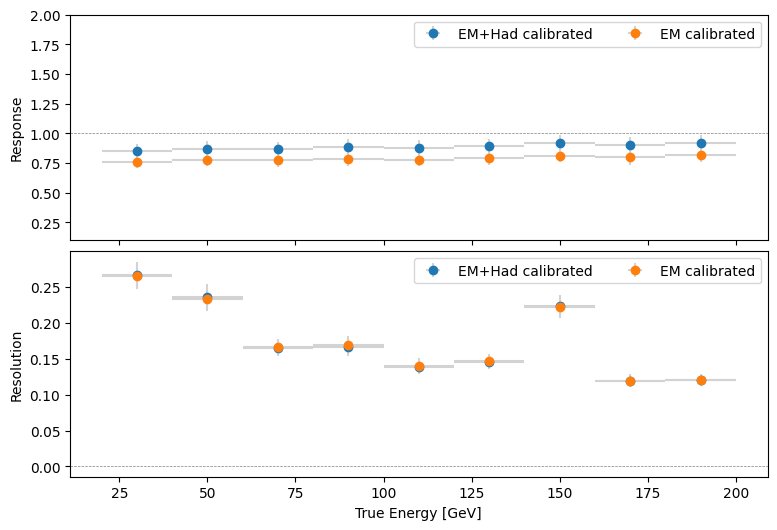

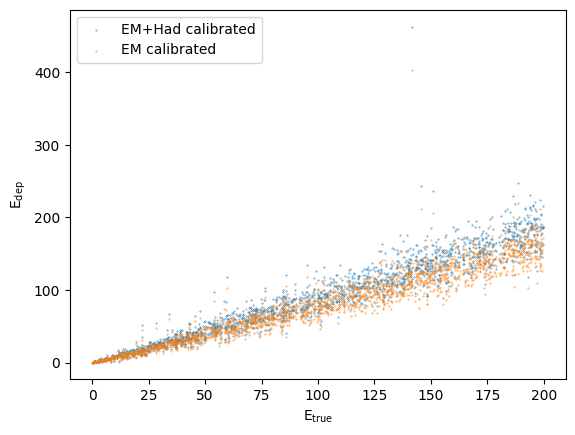

In [132]:
from plotting.general_2d_plot_extensions_2 import ResponseAndResolutionCombinedPlot

binning = np.array([20, 40, 60, 80, 100, 120,140,160,180,200])
plot = ResponseAndResolutionCombinedPlot(bins=binning, x_label='True Energy [GeV]',
                                         y_label1='Response',
                                         y_label2='Resolution',
                                         histogram_log=False,
                                         plot_background_distribution=False, resolution_by_fit=False)

plot.add_raw_values(E_true, E_dep_em_had/E_true,
                                tags={'calib':'both'})

plot.add_raw_values(E_true, E_dep_em/E_true,
                                tags={'calib':'em'})

mydict = {'em':'EM calibrated', 'both': 'EM+Had calibrated'}

name_tag_formatter = lambda x: mydict[x['calib']]
fig = plot.draw(name_tag_formatter=name_tag_formatter, markersize=6, type_='points')

fig,ax = plt.subplots()
ax.scatter(E_true, E_dep_em_had, s=0.1, label=mydict['both'])
ax.scatter(E_true, E_dep_em, s=0.1, label=mydict['em'])
ax.legend()
ax.set_xlabel('E$_\\mathrm{true}$')
ax.set_ylabel('E$_\\mathrm{dep}$')


In [133]:
print(len(had_sims))

N = min(len(had_sims), len(em_sims))
# N = min(100, N)

EM_E_dep_em_had = []
EM_E_dep_em  = []
EM_E_true = []

for i in tqdm(range(N)):
    sim = em_sims[i]

    gen_calibrated.add([sim[0]])
    result_calibrated = gen_calibrated.process()
    
    gen_calibrated_only_em.add([sim[0]])
    result_calibrated_only_em = gen_calibrated_only_em.process()
    
    e_dep_em_had = np.sum(result_calibrated['rechit_energy'])
    e_dep_em = np.sum(result_calibrated_only_em['rechit_energy'])
    e_true = sim[1]['energy']
    
    EM_E_dep_em_had += [e_dep_em_had]
    EM_E_dep_em += [e_dep_em]
    EM_E_true += [e_true]
    
    print('E', sim[1]['energy'],'E_dep [had+em calib]',\
         np.sum(result_calibrated['rechit_energy']), 'E_dep [em calib]',\
         np.sum(result_calibrated_only_em['rechit_energy']))
    
    
EM_E_dep_em_had = np.array(EM_E_dep_em_had)
EM_E_dep_em  = np.array(EM_E_dep_em)
EM_E_true = np.array(EM_E_true)
data_em = {
    'EM_E_dep_em_had':EM_E_dep_em_had,
    'EM_E_dep_em':EM_E_dep_em_had,
    'EM_E_true':EM_E_dep_em_had,
    'g_em':g_em,
    'g_had':g_had,
}

with gzip.open('em_calib_data.bin', 'wb') as f:
    pickle.dump(data_em,f) 

2000


  0%|                                                                                                                                                                                                               | 1/2000 [00:01<51:07,  1.53s/it]

E 35.301157216359826 E_dep [had+em calib] 35.80455949175923 E_dep [em calib] 34.76810961674935


  0%|▏                                                                                                                                                                                                              | 2/2000 [00:02<44:54,  1.35s/it]

E 71.63296404354519 E_dep [had+em calib] 74.40389653977634 E_dep [em calib] 72.58405161581257


  0%|▎                                                                                                                                                                                                              | 3/2000 [00:03<41:02,  1.23s/it]

E 34.338824672772695 E_dep [had+em calib] 40.0067733006712 E_dep [em calib] 39.10176548778475


  0%|▍                                                                                                                                                                                                              | 4/2000 [00:04<38:55,  1.17s/it]

E 41.17533211047677 E_dep [had+em calib] 43.74805183627318 E_dep [em calib] 43.307841607281446


  0%|▌                                                                                                                                                                                                              | 5/2000 [00:06<38:33,  1.16s/it]

E 118.80622206385247 E_dep [had+em calib] 127.31603317900598 E_dep [em calib] 121.42980830151332


  0%|▌                                                                                                                                                                                                              | 6/2000 [00:07<36:26,  1.10s/it]

E 35.36024656159128 E_dep [had+em calib] 38.478212823501764 E_dep [em calib] 38.16692581853364


  0%|▋                                                                                                                                                                                                              | 7/2000 [00:07<34:55,  1.05s/it]

E 14.115354223747184 E_dep [had+em calib] 16.260575865226752 E_dep [em calib] 16.07512092515906


  0%|▊                                                                                                                                                                                                              | 8/2000 [00:08<34:13,  1.03s/it]

E 119.2889438354378 E_dep [had+em calib] 125.58452650604237 E_dep [em calib] 123.15552657772756


  0%|▉                                                                                                                                                                                                              | 9/2000 [00:10<34:57,  1.05s/it]

E 60.78510745399226 E_dep [had+em calib] 65.39080789074647 E_dep [em calib] 63.98545345991041


  0%|█                                                                                                                                                                                                             | 10/2000 [00:11<34:32,  1.04s/it]

E 140.8172790934372 E_dep [had+em calib] 147.64378187007864 E_dep [em calib] 141.10905088736752


  1%|█▏                                                                                                                                                                                                            | 11/2000 [00:12<34:01,  1.03s/it]

E 151.59274269201904 E_dep [had+em calib] 162.14575905361312 E_dep [em calib] 154.33458718188092


  1%|█▏                                                                                                                                                                                                            | 12/2000 [00:13<33:22,  1.01s/it]

E 53.714894760608146 E_dep [had+em calib] 58.97530311445827 E_dep [em calib] 56.68717177323921


  1%|█▎                                                                                                                                                                                                            | 13/2000 [00:14<33:11,  1.00s/it]

E 82.30656296059779 E_dep [had+em calib] 94.04099154935281 E_dep [em calib] 91.82377977335001


  1%|█▍                                                                                                                                                                                                            | 14/2000 [00:15<33:10,  1.00s/it]

E 116.81198214290032 E_dep [had+em calib] 121.60857831095196 E_dep [em calib] 118.60432640924739


  1%|█▌                                                                                                                                                                                                            | 15/2000 [00:16<33:28,  1.01s/it]

E 122.39710317592218 E_dep [had+em calib] 125.93702347206606 E_dep [em calib] 122.54468773444027


  1%|█▋                                                                                                                                                                                                            | 16/2000 [00:17<32:59,  1.00it/s]

E 72.35811029447649 E_dep [had+em calib] 68.44260242504814 E_dep [em calib] 66.1144201806653


  1%|█▊                                                                                                                                                                                                            | 17/2000 [00:18<32:44,  1.01it/s]

E 179.49101230814898 E_dep [had+em calib] 192.13049773704287 E_dep [em calib] 187.82379378379792


  1%|█▊                                                                                                                                                                                                            | 18/2000 [00:19<32:36,  1.01it/s]

E 32.06458908449639 E_dep [had+em calib] 33.49792366441247 E_dep [em calib] 32.68337134250676


  1%|█▉                                                                                                                                                                                                            | 19/2000 [00:19<32:32,  1.01it/s]

E 199.99714633421945 E_dep [had+em calib] 207.20147145118435 E_dep [em calib] 196.66442445704834


  1%|██                                                                                                                                                                                                            | 20/2000 [00:21<33:02,  1.00s/it]

E 136.20070210564595 E_dep [had+em calib] 144.47230149789598 E_dep [em calib] 140.76913154413492


  1%|██▏                                                                                                                                                                                                           | 21/2000 [00:21<32:27,  1.02it/s]

E 93.56569997910253 E_dep [had+em calib] 87.61601293918845 E_dep [em calib] 83.37672485924612


  1%|██▎                                                                                                                                                                                                           | 22/2000 [00:22<32:33,  1.01it/s]

E 189.03477814059318 E_dep [had+em calib] 202.08762829942955 E_dep [em calib] 191.71724314413112


  1%|██▎                                                                                                                                                                                                           | 23/2000 [00:23<32:53,  1.00it/s]

E 133.38725326406004 E_dep [had+em calib] 143.98429254309696 E_dep [em calib] 138.73244662340696


  1%|██▍                                                                                                                                                                                                           | 24/2000 [00:25<33:03,  1.00s/it]

E 106.55871506953152 E_dep [had+em calib] 117.45781694244747 E_dep [em calib] 112.88631374650521


  1%|██▌                                                                                                                                                                                                           | 25/2000 [00:26<33:14,  1.01s/it]

E 66.10262534411594 E_dep [had+em calib] 68.85678041577125 E_dep [em calib] 65.56632798134673


  1%|██▋                                                                                                                                                                                                           | 26/2000 [00:27<33:15,  1.01s/it]

E 165.86448324468628 E_dep [had+em calib] 178.50464984545923 E_dep [em calib] 164.25325649303898


  1%|██▊                                                                                                                                                                                                           | 27/2000 [00:28<33:27,  1.02s/it]

E 186.91158953857922 E_dep [had+em calib] 186.96474652933907 E_dep [em calib] 180.39507222856676


  1%|██▉                                                                                                                                                                                                           | 28/2000 [00:29<33:50,  1.03s/it]

E 34.36817528006717 E_dep [had+em calib] 38.78114722699127 E_dep [em calib] 37.64960096214693


  1%|██▉                                                                                                                                                                                                           | 29/2000 [00:30<33:58,  1.03s/it]

E 158.39485169520336 E_dep [had+em calib] 161.50405073594013 E_dep [em calib] 151.58093686138196


  2%|███                                                                                                                                                                                                           | 30/2000 [00:31<34:29,  1.05s/it]

E 169.90838801839743 E_dep [had+em calib] 175.45524335112637 E_dep [em calib] 168.71347248169693


  2%|███▏                                                                                                                                                                                                          | 31/2000 [00:32<33:49,  1.03s/it]

E 64.20497932411182 E_dep [had+em calib] 69.17920221151658 E_dep [em calib] 66.89761254244254


  2%|███▎                                                                                                                                                                                                          | 32/2000 [00:33<33:00,  1.01s/it]

E 120.871268252857 E_dep [had+em calib] 127.09969585959713 E_dep [em calib] 120.5586071613152


  2%|███▍                                                                                                                                                                                                          | 33/2000 [00:34<32:36,  1.01it/s]

E 3.58786177119592 E_dep [had+em calib] 4.052497716071063 E_dep [em calib] 4.052497716072712


  2%|███▌                                                                                                                                                                                                          | 34/2000 [00:35<33:21,  1.02s/it]

E 140.07346668300303 E_dep [had+em calib] 157.0315677548619 E_dep [em calib] 152.71088622319277


  2%|███▌                                                                                                                                                                                                          | 35/2000 [00:36<32:26,  1.01it/s]

E 151.76236081962008 E_dep [had+em calib] 168.9318300481784 E_dep [em calib] 164.21723509235778


  2%|███▋                                                                                                                                                                                                          | 36/2000 [00:37<31:28,  1.04it/s]

E 2.642328590891199 E_dep [had+em calib] 2.315553232612751 E_dep [em calib] 2.284931747099715


  2%|███▊                                                                                                                                                                                                          | 37/2000 [00:37<30:50,  1.06it/s]

E 172.4466864960685 E_dep [had+em calib] 181.53202726608637 E_dep [em calib] 174.1796572228695


  2%|███▉                                                                                                                                                                                                          | 38/2000 [00:38<30:15,  1.08it/s]

E 44.89582098075909 E_dep [had+em calib] 51.0008554475958 E_dep [em calib] 49.78664036679828


  2%|████                                                                                                                                                                                                          | 39/2000 [00:39<29:56,  1.09it/s]

E 21.905560195414576 E_dep [had+em calib] 23.558052306580677 E_dep [em calib] 23.126547000385624


  2%|████                                                                                                                                                                                                          | 40/2000 [00:40<29:29,  1.11it/s]

E 96.65453826054959 E_dep [had+em calib] 103.4083026774591 E_dep [em calib] 99.31709231191145


  2%|████▏                                                                                                                                                                                                         | 41/2000 [00:41<29:11,  1.12it/s]

E 15.752181566621013 E_dep [had+em calib] 16.57908452996512 E_dep [em calib] 16.07243631786565


  2%|████▎                                                                                                                                                                                                         | 42/2000 [00:42<29:25,  1.11it/s]

E 27.771890278294965 E_dep [had+em calib] 31.513213571027812 E_dep [em calib] 31.1863045065574


  2%|████▍                                                                                                                                                                                                         | 43/2000 [00:43<29:58,  1.09it/s]

E 199.43153620949244 E_dep [had+em calib] 212.34901385143385 E_dep [em calib] 206.8194544922815


  2%|████▌                                                                                                                                                                                                         | 44/2000 [00:44<30:28,  1.07it/s]

E 14.841548213786414 E_dep [had+em calib] 15.471820333079465 E_dep [em calib] 15.336327376436843


  2%|████▋                                                                                                                                                                                                         | 45/2000 [00:45<30:18,  1.08it/s]

E 61.29624061799704 E_dep [had+em calib] 67.3533139133037 E_dep [em calib] 65.93015085169345


  2%|████▋                                                                                                                                                                                                         | 46/2000 [00:46<30:40,  1.06it/s]

E 155.0269714979067 E_dep [had+em calib] 161.2977548924266 E_dep [em calib] 140.51610725060203


  2%|████▊                                                                                                                                                                                                         | 47/2000 [00:47<30:47,  1.06it/s]

E 99.18708645529557 E_dep [had+em calib] 99.66774488443343 E_dep [em calib] 95.19991307079448


  2%|████▉                                                                                                                                                                                                         | 48/2000 [00:48<30:40,  1.06it/s]

E 135.8701105438688 E_dep [had+em calib] 146.72148566999851 E_dep [em calib] 141.40382017243124


  2%|█████                                                                                                                                                                                                         | 49/2000 [00:49<30:52,  1.05it/s]

E 53.99453828328806 E_dep [had+em calib] 58.9628841581855 E_dep [em calib] 54.623539190422115


  2%|█████▏                                                                                                                                                                                                        | 50/2000 [00:50<30:36,  1.06it/s]

E 127.19404172462778 E_dep [had+em calib] 135.9399480112999 E_dep [em calib] 129.7755823797025


  3%|█████▎                                                                                                                                                                                                        | 51/2000 [00:50<30:08,  1.08it/s]

E 6.348771509043595 E_dep [had+em calib] 7.20385946118165 E_dep [em calib] 7.1779184322451455


  3%|█████▎                                                                                                                                                                                                        | 52/2000 [00:51<30:07,  1.08it/s]

E 20.750279532998753 E_dep [had+em calib] 23.461466463120356 E_dep [em calib] 23.216467473046844


  3%|█████▍                                                                                                                                                                                                        | 53/2000 [00:52<29:54,  1.09it/s]

E 108.88967659791906 E_dep [had+em calib] 109.55167331643888 E_dep [em calib] 102.49130570015626


  3%|█████▌                                                                                                                                                                                                        | 54/2000 [00:53<30:07,  1.08it/s]

E 107.14555403823215 E_dep [had+em calib] 102.67610021268744 E_dep [em calib] 94.57871261677555


  3%|█████▋                                                                                                                                                                                                        | 55/2000 [00:54<29:52,  1.09it/s]

E 37.62044649525936 E_dep [had+em calib] 40.2824759452563 E_dep [em calib] 39.47912322992578


  3%|█████▊                                                                                                                                                                                                        | 56/2000 [00:55<29:42,  1.09it/s]

E 53.04290899385249 E_dep [had+em calib] 54.634840413081506 E_dep [em calib] 52.39364249165931


  3%|█████▊                                                                                                                                                                                                        | 57/2000 [00:56<29:51,  1.08it/s]

E 100.97215336758885 E_dep [had+em calib] 94.78612308242162 E_dep [em calib] 88.19531511818862


  3%|█████▉                                                                                                                                                                                                        | 58/2000 [00:57<30:04,  1.08it/s]

E 126.66195147539544 E_dep [had+em calib] 133.18018162967707 E_dep [em calib] 130.0199721908802


  3%|██████                                                                                                                                                                                                        | 59/2000 [00:58<30:40,  1.05it/s]

E 196.94123337734163 E_dep [had+em calib] 199.5696255427217 E_dep [em calib] 191.54886965435617


  3%|██████▏                                                                                                                                                                                                       | 60/2000 [00:59<30:24,  1.06it/s]

E 28.029781887779855 E_dep [had+em calib] 28.819651879379915 E_dep [em calib] 28.29690629369442


  3%|██████▎                                                                                                                                                                                                       | 61/2000 [01:00<30:15,  1.07it/s]

E 96.88449868617121 E_dep [had+em calib] 92.8796793669092 E_dep [em calib] 90.14692567390462


  3%|██████▍                                                                                                                                                                                                       | 62/2000 [01:01<30:31,  1.06it/s]

E 94.15079274335955 E_dep [had+em calib] 91.61746362075235 E_dep [em calib] 87.38226184542225


  3%|██████▍                                                                                                                                                                                                       | 63/2000 [01:02<32:23,  1.00s/it]

E 137.90896150667325 E_dep [had+em calib] 143.34639950950324 E_dep [em calib] 138.35379302907398


  3%|██████▌                                                                                                                                                                                                       | 64/2000 [01:03<32:13,  1.00it/s]

E 88.49158156900734 E_dep [had+em calib] 96.04846279777954 E_dep [em calib] 92.034125976154


  3%|██████▋                                                                                                                                                                                                       | 65/2000 [01:04<32:18,  1.00s/it]

E 189.61255551433896 E_dep [had+em calib] 191.62015162473153 E_dep [em calib] 182.32431601174167


  3%|██████▊                                                                                                                                                                                                       | 66/2000 [01:05<31:55,  1.01it/s]

E 9.951299691953848 E_dep [had+em calib] 13.32895182719139 E_dep [em calib] 12.9335464171495


  3%|██████▉                                                                                                                                                                                                       | 67/2000 [01:06<31:51,  1.01it/s]

E 65.55085772161415 E_dep [had+em calib] 64.86012527557338 E_dep [em calib] 60.11926366281976


  3%|███████                                                                                                                                                                                                       | 68/2000 [01:07<32:29,  1.01s/it]

E 63.092095995754235 E_dep [had+em calib] 63.8039922837508 E_dep [em calib] 61.457628857957275


  3%|███████                                                                                                                                                                                                       | 69/2000 [01:08<32:13,  1.00s/it]

E 44.98503413243031 E_dep [had+em calib] 48.40935815578564 E_dep [em calib] 45.821359502135216


  4%|███████▏                                                                                                                                                                                                      | 70/2000 [01:09<32:09,  1.00it/s]

E 101.29336409472654 E_dep [had+em calib] 101.07271336940791 E_dep [em calib] 92.06255311352687


  4%|███████▎                                                                                                                                                                                                      | 71/2000 [01:10<32:01,  1.00it/s]

E 150.7921760002496 E_dep [had+em calib] 155.98152264150661 E_dep [em calib] 149.71367387982676


  4%|███████▍                                                                                                                                                                                                      | 72/2000 [01:11<32:27,  1.01s/it]

E 5.752255256506788 E_dep [had+em calib] 5.642545700705622 E_dep [em calib] 5.480981366602969


  4%|███████▌                                                                                                                                                                                                      | 73/2000 [01:12<32:57,  1.03s/it]

E 171.6297880357649 E_dep [had+em calib] 183.2476170555181 E_dep [em calib] 167.753660618929


  4%|███████▌                                                                                                                                                                                                      | 74/2000 [01:13<32:27,  1.01s/it]

E 38.139168206651235 E_dep [had+em calib] 40.39475360286586 E_dep [em calib] 40.10950886399838


  4%|███████▋                                                                                                                                                                                                      | 75/2000 [01:14<32:03,  1.00it/s]

E 87.82035420012932 E_dep [had+em calib] 92.71059935732872 E_dep [em calib] 90.03541888449065


  4%|███████▊                                                                                                                                                                                                      | 76/2000 [01:15<31:55,  1.00it/s]

E 131.84992000146877 E_dep [had+em calib] 144.6790140401761 E_dep [em calib] 137.84417106725041


  4%|███████▉                                                                                                                                                                                                      | 77/2000 [01:16<31:24,  1.02it/s]

E 71.10026389324884 E_dep [had+em calib] 75.63506759269092 E_dep [em calib] 73.41886710173647


  4%|████████                                                                                                                                                                                                      | 78/2000 [01:17<31:51,  1.01it/s]

E 140.46296320004552 E_dep [had+em calib] 146.1254818803142 E_dep [em calib] 143.6356530379978


  4%|████████▏                                                                                                                                                                                                     | 79/2000 [01:18<32:14,  1.01s/it]

E 181.77074386000683 E_dep [had+em calib] 192.5446586510098 E_dep [em calib] 183.69475888083215


  4%|████████▏                                                                                                                                                                                                     | 80/2000 [01:19<31:51,  1.00it/s]

E 29.22201342423509 E_dep [had+em calib] 31.005630409825987 E_dep [em calib] 30.642116018505057


  4%|████████▎                                                                                                                                                                                                     | 81/2000 [01:20<31:05,  1.03it/s]

E 62.347820629409284 E_dep [had+em calib] 62.13612455110507 E_dep [em calib] 58.009313010614775


  4%|████████▍                                                                                                                                                                                                     | 82/2000 [01:21<30:18,  1.05it/s]

E 22.97737496011451 E_dep [had+em calib] 25.933164634466472 E_dep [em calib] 25.50519393149358


  4%|████████▌                                                                                                                                                                                                     | 83/2000 [01:22<30:11,  1.06it/s]

E 18.139412519329312 E_dep [had+em calib] 19.172672252796986 E_dep [em calib] 19.088303173815568


  4%|████████▋                                                                                                                                                                                                     | 84/2000 [01:23<30:34,  1.04it/s]

E 49.31110776610359 E_dep [had+em calib] 53.34759118331127 E_dep [em calib] 52.72811089660295


  4%|████████▊                                                                                                                                                                                                     | 85/2000 [01:23<30:12,  1.06it/s]

E 159.78242396044755 E_dep [had+em calib] 166.66040400225592 E_dep [em calib] 161.6714563108325


  4%|████████▊                                                                                                                                                                                                     | 86/2000 [01:24<30:27,  1.05it/s]

E 42.14536013774357 E_dep [had+em calib] 46.34687310681825 E_dep [em calib] 45.3268399066803


  4%|████████▉                                                                                                                                                                                                     | 87/2000 [01:25<30:38,  1.04it/s]

E 53.78038325506757 E_dep [had+em calib] 52.46478412615116 E_dep [em calib] 50.491255402228674


  4%|█████████                                                                                                                                                                                                     | 88/2000 [01:26<30:32,  1.04it/s]

E 19.492808216603123 E_dep [had+em calib] 21.861621436136886 E_dep [em calib] 21.510392497927526


  4%|█████████▏                                                                                                                                                                                                    | 89/2000 [01:27<30:20,  1.05it/s]

E 17.91259380169373 E_dep [had+em calib] 19.897688772029152 E_dep [em calib] 19.668806158709383


  4%|█████████▎                                                                                                                                                                                                    | 90/2000 [01:28<30:01,  1.06it/s]

E 129.94034536806583 E_dep [had+em calib] 136.44021866405043 E_dep [em calib] 132.1807788934788


  5%|█████████▎                                                                                                                                                                                                    | 91/2000 [01:29<29:58,  1.06it/s]

E 117.1843253035175 E_dep [had+em calib] 125.89500447930256 E_dep [em calib] 123.08860150788242


  5%|█████████▍                                                                                                                                                                                                    | 92/2000 [01:30<30:03,  1.06it/s]

E 25.269669058281607 E_dep [had+em calib] 26.891541904857394 E_dep [em calib] 26.50124054796244


  5%|█████████▌                                                                                                                                                                                                    | 93/2000 [01:31<30:48,  1.03it/s]

E 58.783953780632274 E_dep [had+em calib] 67.01254311834454 E_dep [em calib] 65.50426659957203


  5%|█████████▋                                                                                                                                                                                                    | 94/2000 [01:32<31:00,  1.02it/s]

E 168.29377163635615 E_dep [had+em calib] 179.3342981588651 E_dep [em calib] 176.22530644345161


  5%|█████████▊                                                                                                                                                                                                    | 95/2000 [01:33<31:01,  1.02it/s]

E 74.46248526962198 E_dep [had+em calib] 75.87460814898495 E_dep [em calib] 74.50348176115179


  5%|█████████▉                                                                                                                                                                                                    | 96/2000 [01:34<30:53,  1.03it/s]

E 135.79541188457475 E_dep [had+em calib] 139.54677186309814 E_dep [em calib] 136.43190788270323


  5%|█████████▉                                                                                                                                                                                                    | 97/2000 [01:35<30:54,  1.03it/s]

E 12.063069070850746 E_dep [had+em calib] 10.845681738821293 E_dep [em calib] 10.228437575370926


  5%|██████████                                                                                                                                                                                                    | 98/2000 [01:36<31:12,  1.02it/s]

E 181.69762656887195 E_dep [had+em calib] 203.08185515876875 E_dep [em calib] 197.07759557267323


  5%|██████████▏                                                                                                                                                                                                   | 99/2000 [01:37<31:12,  1.02it/s]

E 44.45831261542073 E_dep [had+em calib] 47.67927449066743 E_dep [em calib] 46.59316094638434


  5%|██████████▎                                                                                                                                                                                                  | 100/2000 [01:38<30:55,  1.02it/s]

E 6.737092230400195 E_dep [had+em calib] 5.730607486514474 E_dep [em calib] 5.43672551542249


  5%|██████████▎                                                                                                                                                                                                  | 101/2000 [01:39<30:57,  1.02it/s]

E 106.94439936471734 E_dep [had+em calib] 117.20145264516673 E_dep [em calib] 113.78938432344682


  5%|██████████▍                                                                                                                                                                                                  | 102/2000 [01:40<31:03,  1.02it/s]

E 192.6692999567552 E_dep [had+em calib] 199.97748757647523 E_dep [em calib] 185.70738035772976


  5%|██████████▌                                                                                                                                                                                                  | 103/2000 [01:41<33:00,  1.04s/it]

E 93.13570939948133 E_dep [had+em calib] 94.44274853944273 E_dep [em calib] 91.37031502660604


  5%|██████████▋                                                                                                                                                                                                  | 104/2000 [01:42<33:28,  1.06s/it]

E 88.06737683740656 E_dep [had+em calib] 87.0231910023548 E_dep [em calib] 84.70421115641133


  5%|██████████▊                                                                                                                                                                                                  | 105/2000 [01:44<36:35,  1.16s/it]

E 128.20822318223088 E_dep [had+em calib] 127.04061471268334 E_dep [em calib] 114.93922242265201


  5%|██████████▊                                                                                                                                                                                                  | 106/2000 [01:45<40:16,  1.28s/it]

E 134.87154161585792 E_dep [had+em calib] 132.81553265183746 E_dep [em calib] 127.59476728994652


  5%|██████████▉                                                                                                                                                                                                  | 107/2000 [01:46<40:18,  1.28s/it]

E 151.36630391342484 E_dep [had+em calib] 154.4814261292237 E_dep [em calib] 147.07367778031224


  5%|███████████                                                                                                                                                                                                  | 108/2000 [01:48<38:53,  1.23s/it]

E 147.27290725134952 E_dep [had+em calib] 147.24251580685362 E_dep [em calib] 144.7625814326827


  5%|███████████▏                                                                                                                                                                                                 | 109/2000 [01:49<37:20,  1.18s/it]

E 35.74917359815165 E_dep [had+em calib] 37.055289852155774 E_dep [em calib] 35.95497147591481


  6%|███████████▎                                                                                                                                                                                                 | 110/2000 [01:50<35:42,  1.13s/it]

E 59.150576121868255 E_dep [had+em calib] 65.49758174203019 E_dep [em calib] 64.00198487566777


  6%|███████████▍                                                                                                                                                                                                 | 111/2000 [01:51<34:20,  1.09s/it]

E 90.64730189485928 E_dep [had+em calib] 93.0794459132412 E_dep [em calib] 86.59337347334674


  6%|███████████▍                                                                                                                                                                                                 | 112/2000 [01:52<33:25,  1.06s/it]

E 144.32751984486785 E_dep [had+em calib] 141.55440169321383 E_dep [em calib] 130.8965114834924


  6%|███████████▌                                                                                                                                                                                                 | 113/2000 [01:53<33:46,  1.07s/it]

E 137.5566452277862 E_dep [had+em calib] 145.83353788482512 E_dep [em calib] 140.00795140216533


  6%|███████████▋                                                                                                                                                                                                 | 114/2000 [01:54<36:53,  1.17s/it]

E 31.136043494854984 E_dep [had+em calib] 32.17978080445891 E_dep [em calib] 30.09098772917667


  6%|███████████▊                                                                                                                                                                                                 | 115/2000 [01:55<36:46,  1.17s/it]

E 41.41192742870763 E_dep [had+em calib] 45.815450078327814 E_dep [em calib] 44.72514299271079


  6%|███████████▉                                                                                                                                                                                                 | 116/2000 [01:57<37:23,  1.19s/it]

E 64.0653324855056 E_dep [had+em calib] 68.33745303108513 E_dep [em calib] 65.33482523319199


  6%|███████████▉                                                                                                                                                                                                 | 117/2000 [01:58<37:36,  1.20s/it]

E 140.96998726841258 E_dep [had+em calib] 146.01569877303706 E_dep [em calib] 141.16200681867429


  6%|████████████                                                                                                                                                                                                 | 118/2000 [01:59<37:16,  1.19s/it]

E 12.193354519719264 E_dep [had+em calib] 11.669730015075697 E_dep [em calib] 11.28234669460126


  6%|████████████▏                                                                                                                                                                                                | 119/2000 [02:00<36:24,  1.16s/it]

E 138.15304419920204 E_dep [had+em calib] 149.32882469609885 E_dep [em calib] 144.59560996721908


  6%|████████████▎                                                                                                                                                                                                | 120/2000 [02:01<37:12,  1.19s/it]

E 15.636621859788393 E_dep [had+em calib] 17.642648541176353 E_dep [em calib] 17.487860180985585


  6%|████████████▍                                                                                                                                                                                                | 121/2000 [02:03<37:50,  1.21s/it]

E 169.75998044614073 E_dep [had+em calib] 175.81471660146542 E_dep [em calib] 168.88782984153443


  6%|████████████▌                                                                                                                                                                                                | 122/2000 [02:04<38:59,  1.25s/it]

E 107.25264638956817 E_dep [had+em calib] 107.441778580363 E_dep [em calib] 104.51770028490255


  6%|████████████▌                                                                                                                                                                                                | 123/2000 [02:05<38:49,  1.24s/it]

E 197.17926148969468 E_dep [had+em calib] 209.11766178337032 E_dep [em calib] 200.82415731262677


  6%|████████████▋                                                                                                                                                                                                | 124/2000 [02:06<36:43,  1.17s/it]

E 114.17719758794759 E_dep [had+em calib] 107.86916439302868 E_dep [em calib] 100.69886850679109


  6%|████████████▊                                                                                                                                                                                                | 125/2000 [02:07<35:48,  1.15s/it]

E 107.43425599909476 E_dep [had+em calib] 111.3298971628005 E_dep [em calib] 109.40521697185424


  6%|████████████▉                                                                                                                                                                                                | 126/2000 [02:08<33:39,  1.08s/it]

E 51.95039395109908 E_dep [had+em calib] 53.83483922880687 E_dep [em calib] 52.869714453809294


  6%|█████████████                                                                                                                                                                                                | 127/2000 [02:09<31:58,  1.02s/it]

E 49.226340038318774 E_dep [had+em calib] 49.51322935004509 E_dep [em calib] 48.01924603543587


  6%|█████████████                                                                                                                                                                                                | 128/2000 [02:10<31:26,  1.01s/it]

E 85.20002739221867 E_dep [had+em calib] 88.27237854819266 E_dep [em calib] 86.97775279039774


  6%|█████████████▏                                                                                                                                                                                               | 129/2000 [02:11<30:57,  1.01it/s]

E 120.42329299671846 E_dep [had+em calib] 127.81238461175516 E_dep [em calib] 123.87650264353907


  6%|█████████████▎                                                                                                                                                                                               | 130/2000 [02:12<30:20,  1.03it/s]

E 128.00962383788735 E_dep [had+em calib] 125.14206975465021 E_dep [em calib] 121.01718119145167


  7%|█████████████▍                                                                                                                                                                                               | 131/2000 [02:13<30:33,  1.02it/s]

E 145.97213128105318 E_dep [had+em calib] 144.6824424292244 E_dep [em calib] 140.41204342568898


  7%|█████████████▌                                                                                                                                                                                               | 132/2000 [02:14<30:23,  1.02it/s]

E 7.019972416660605 E_dep [had+em calib] 7.269325503901174 E_dep [em calib] 7.017228462102323


  7%|█████████████▋                                                                                                                                                                                               | 133/2000 [02:15<30:03,  1.04it/s]

E 24.08888697858186 E_dep [had+em calib] 26.654953562596038 E_dep [em calib] 26.304752497987202


  7%|█████████████▋                                                                                                                                                                                               | 134/2000 [02:16<29:33,  1.05it/s]

E 10.916967036597939 E_dep [had+em calib] 11.388670060102957 E_dep [em calib] 11.343273243785303


  7%|█████████████▊                                                                                                                                                                                               | 135/2000 [02:17<29:32,  1.05it/s]

E 86.94511325232449 E_dep [had+em calib] 95.34379743096697 E_dep [em calib] 93.68481049978541


  7%|█████████████▉                                                                                                                                                                                               | 136/2000 [02:18<29:07,  1.07it/s]

E 11.690413591106228 E_dep [had+em calib] 12.360199338713132 E_dep [em calib] 12.323934800766553


  7%|██████████████                                                                                                                                                                                               | 137/2000 [02:18<28:29,  1.09it/s]

E 37.65085018996271 E_dep [had+em calib] 40.07639307600898 E_dep [em calib] 39.224418011894045


  7%|██████████████▏                                                                                                                                                                                              | 138/2000 [02:19<28:33,  1.09it/s]

E 74.62777399177047 E_dep [had+em calib] 71.92733636072862 E_dep [em calib] 69.28251114600084


  7%|██████████████▏                                                                                                                                                                                              | 139/2000 [02:20<28:20,  1.09it/s]

E 72.441746390929 E_dep [had+em calib] 78.03628873584108 E_dep [em calib] 76.67457907245692


  7%|██████████████▎                                                                                                                                                                                              | 140/2000 [02:21<28:18,  1.10it/s]

E 149.69934614631902 E_dep [had+em calib] 160.20425800515343 E_dep [em calib] 147.47976598295028


  7%|██████████████▍                                                                                                                                                                                              | 141/2000 [02:22<28:20,  1.09it/s]

E 38.42598721354581 E_dep [had+em calib] 41.54132181052956 E_dep [em calib] 40.408902864143364


  7%|██████████████▌                                                                                                                                                                                              | 142/2000 [02:23<29:09,  1.06it/s]

E 80.6822582669415 E_dep [had+em calib] 83.10781040098581 E_dep [em calib] 78.79153643076842


  7%|██████████████▋                                                                                                                                                                                              | 143/2000 [02:24<28:53,  1.07it/s]

E 8.18454190763022 E_dep [had+em calib] 9.298224132315534 E_dep [em calib] 9.17042303726663


  7%|██████████████▊                                                                                                                                                                                              | 144/2000 [02:25<29:27,  1.05it/s]

E 157.84448441363634 E_dep [had+em calib] 173.67150294579102 E_dep [em calib] 169.40314548657088


  7%|██████████████▊                                                                                                                                                                                              | 145/2000 [02:26<29:03,  1.06it/s]

E 4.133756674149201 E_dep [had+em calib] 4.397357527676416 E_dep [em calib] 4.397357527692756


  7%|██████████████▉                                                                                                                                                                                              | 146/2000 [02:27<28:58,  1.07it/s]

E 148.41139447696284 E_dep [had+em calib] 154.28475332634176 E_dep [em calib] 149.49172529109046


  7%|███████████████                                                                                                                                                                                              | 147/2000 [02:28<28:52,  1.07it/s]

E 69.37781121899121 E_dep [had+em calib] 75.50381130838885 E_dep [em calib] 73.79075362474225


  7%|███████████████▏                                                                                                                                                                                             | 148/2000 [02:29<28:33,  1.08it/s]

E 129.31084295817132 E_dep [had+em calib] 131.3195074294922 E_dep [em calib] 118.70616974129035


  7%|███████████████▎                                                                                                                                                                                             | 149/2000 [02:30<29:31,  1.04it/s]

E 33.69009569196928 E_dep [had+em calib] 39.20676608180739 E_dep [em calib] 37.86791408092467


  8%|███████████████▍                                                                                                                                                                                             | 150/2000 [02:31<30:11,  1.02it/s]

E 95.24973271222403 E_dep [had+em calib] 101.17423006733057 E_dep [em calib] 98.47057207164767


  8%|███████████████▍                                                                                                                                                                                             | 151/2000 [02:32<30:10,  1.02it/s]

E 54.669783003339106 E_dep [had+em calib] 57.659266370574656 E_dep [em calib] 56.81948115336703


  8%|███████████████▌                                                                                                                                                                                             | 152/2000 [02:33<30:19,  1.02it/s]

E 138.97414042117785 E_dep [had+em calib] 146.04580661120224 E_dep [em calib] 143.17646626639998


  8%|███████████████▋                                                                                                                                                                                             | 153/2000 [02:34<30:16,  1.02it/s]

E 43.62591048647584 E_dep [had+em calib] 43.913092335774756 E_dep [em calib] 43.124138036091836


  8%|███████████████▊                                                                                                                                                                                             | 154/2000 [02:35<30:25,  1.01it/s]

E 85.38910976956582 E_dep [had+em calib] 87.27864612612684 E_dep [em calib] 83.30608768437338


  8%|███████████████▉                                                                                                                                                                                             | 155/2000 [02:36<30:22,  1.01it/s]

E 26.891185509492114 E_dep [had+em calib] 30.68222745197308 E_dep [em calib] 29.944105506498428


  8%|███████████████▉                                                                                                                                                                                             | 156/2000 [02:37<29:40,  1.04it/s]

E 116.36917434141272 E_dep [had+em calib] 120.00609413175691 E_dep [em calib] 112.23207698172007


  8%|████████████████                                                                                                                                                                                             | 157/2000 [02:38<28:52,  1.06it/s]

E 18.815869534290144 E_dep [had+em calib] 20.924008394874956 E_dep [em calib] 20.86151879305851


  8%|████████████████▏                                                                                                                                                                                            | 158/2000 [02:38<28:16,  1.09it/s]

E 23.92251675848571 E_dep [had+em calib] 25.184093379673495 E_dep [em calib] 24.6899952193148


  8%|████████████████▎                                                                                                                                                                                            | 159/2000 [02:39<28:05,  1.09it/s]

E 184.52556626640984 E_dep [had+em calib] 193.34289730250666 E_dep [em calib] 187.82189252311304


  8%|████████████████▍                                                                                                                                                                                            | 160/2000 [02:40<27:41,  1.11it/s]

E 144.91102195639436 E_dep [had+em calib] 158.2676072671784 E_dep [em calib] 154.00537482501664


  8%|████████████████▌                                                                                                                                                                                            | 161/2000 [02:41<27:18,  1.12it/s]

E 164.8467143327726 E_dep [had+em calib] 158.49735476042792 E_dep [em calib] 152.15362747076625


  8%|████████████████▌                                                                                                                                                                                            | 162/2000 [02:42<27:36,  1.11it/s]

E 94.21931777684715 E_dep [had+em calib] 99.33512159769975 E_dep [em calib] 95.11148801753403


  8%|████████████████▋                                                                                                                                                                                            | 163/2000 [02:43<27:42,  1.10it/s]

E 82.7869120844363 E_dep [had+em calib] 89.65285859323262 E_dep [em calib] 86.91179852066902


  8%|████████████████▊                                                                                                                                                                                            | 164/2000 [02:44<28:21,  1.08it/s]

E 56.680044142441325 E_dep [had+em calib] 61.38932446407973 E_dep [em calib] 59.92498272728677


  8%|████████████████▉                                                                                                                                                                                            | 165/2000 [02:45<28:32,  1.07it/s]

E 65.69855434833893 E_dep [had+em calib] 71.27280674576059 E_dep [em calib] 69.46831897124775


  8%|█████████████████                                                                                                                                                                                            | 166/2000 [02:46<28:03,  1.09it/s]

E 147.90451939862172 E_dep [had+em calib] 153.3248668795977 E_dep [em calib] 148.92675123013942


  8%|█████████████████                                                                                                                                                                                            | 167/2000 [02:47<27:45,  1.10it/s]

E 34.84707233458619 E_dep [had+em calib] 40.46206106309242 E_dep [em calib] 38.54561970201656


  8%|█████████████████▏                                                                                                                                                                                           | 168/2000 [02:48<28:23,  1.08it/s]

E 25.21058944926872 E_dep [had+em calib] 23.532533981548053 E_dep [em calib] 22.42100079190497


  8%|█████████████████▎                                                                                                                                                                                           | 169/2000 [02:49<28:49,  1.06it/s]

E 153.48643050702154 E_dep [had+em calib] 167.2718111660422 E_dep [em calib] 161.8191670098685


  8%|█████████████████▍                                                                                                                                                                                           | 170/2000 [02:49<29:07,  1.05it/s]

E 173.82249891748899 E_dep [had+em calib] 172.3355368857759 E_dep [em calib] 164.9419054745319


  9%|█████████████████▌                                                                                                                                                                                           | 171/2000 [02:51<29:38,  1.03it/s]

E 169.0820383189309 E_dep [had+em calib] 180.96685679431192 E_dep [em calib] 175.98720575747393


  9%|█████████████████▋                                                                                                                                                                                           | 172/2000 [02:52<32:36,  1.07s/it]

E 116.10221779191893 E_dep [had+em calib] 128.1352241595868 E_dep [em calib] 123.96056284487663


  9%|█████████████████▋                                                                                                                                                                                           | 173/2000 [02:53<34:14,  1.12s/it]

E 23.168147306834552 E_dep [had+em calib] 25.441472318301997 E_dep [em calib] 25.08462103701277


  9%|█████████████████▊                                                                                                                                                                                           | 174/2000 [02:54<33:33,  1.10s/it]

E 40.81009407805295 E_dep [had+em calib] 38.88279624943986 E_dep [em calib] 37.289661409906536


  9%|█████████████████▉                                                                                                                                                                                           | 175/2000 [02:55<32:56,  1.08s/it]

E 46.50548735675557 E_dep [had+em calib] 46.23860608554622 E_dep [em calib] 44.289359619637644


  9%|██████████████████                                                                                                                                                                                           | 176/2000 [02:56<31:58,  1.05s/it]

E 178.1767626450201 E_dep [had+em calib] 171.79145109793365 E_dep [em calib] 158.1193801639869


  9%|██████████████████▏                                                                                                                                                                                          | 177/2000 [02:57<31:28,  1.04s/it]

E 172.02098239028382 E_dep [had+em calib] 173.48843974782463 E_dep [em calib] 168.09519374415555


  9%|██████████████████▏                                                                                                                                                                                          | 178/2000 [02:58<31:46,  1.05s/it]

E 42.994665894929064 E_dep [had+em calib] 53.98977356065223 E_dep [em calib] 52.01582098013432


  9%|██████████████████▎                                                                                                                                                                                          | 179/2000 [02:59<31:56,  1.05s/it]

E 163.51795578245327 E_dep [had+em calib] 153.2234444527012 E_dep [em calib] 143.37272943054992


  9%|██████████████████▍                                                                                                                                                                                          | 180/2000 [03:00<32:00,  1.06s/it]

E 128.1352834535427 E_dep [had+em calib] 133.97120117941 E_dep [em calib] 126.26974696770824


  9%|██████████████████▌                                                                                                                                                                                          | 181/2000 [03:01<31:48,  1.05s/it]

E 5.544728596574878 E_dep [had+em calib] 6.035670424160984 E_dep [em calib] 5.969578757316701


  9%|██████████████████▋                                                                                                                                                                                          | 182/2000 [03:02<31:30,  1.04s/it]

E 98.23218153938122 E_dep [had+em calib] 93.6845180005938 E_dep [em calib] 86.3799077565544


  9%|██████████████████▊                                                                                                                                                                                          | 183/2000 [03:03<31:11,  1.03s/it]

E 40.288130818430254 E_dep [had+em calib] 42.44172269808056 E_dep [em calib] 41.70856661815556


  9%|██████████████████▊                                                                                                                                                                                          | 184/2000 [03:04<31:11,  1.03s/it]

E 2.5740200022347732 E_dep [had+em calib] 3.3200234486950517 E_dep [em calib] 3.2614477828116155


  9%|██████████████████▉                                                                                                                                                                                          | 185/2000 [03:05<31:12,  1.03s/it]

E 19.644464875237805 E_dep [had+em calib] 20.14572835382569 E_dep [em calib] 19.794574324325723


  9%|███████████████████                                                                                                                                                                                          | 186/2000 [03:06<30:45,  1.02s/it]

E 116.3667378482195 E_dep [had+em calib] 126.02927620914976 E_dep [em calib] 119.93160018581922


  9%|███████████████████▏                                                                                                                                                                                         | 187/2000 [03:07<30:31,  1.01s/it]

E 54.61498513060265 E_dep [had+em calib] 57.8514299899754 E_dep [em calib] 55.199184335001306


  9%|███████████████████▎                                                                                                                                                                                         | 188/2000 [03:08<30:05,  1.00it/s]

E 171.7129045002465 E_dep [had+em calib] 179.61193163850845 E_dep [em calib] 175.14183635618264


  9%|███████████████████▎                                                                                                                                                                                         | 189/2000 [03:09<29:47,  1.01it/s]

E 176.84065156719538 E_dep [had+em calib] 192.6792875289164 E_dep [em calib] 185.27036838173075


 10%|███████████████████▍                                                                                                                                                                                         | 190/2000 [03:10<29:55,  1.01it/s]

E 123.4510556993504 E_dep [had+em calib] 129.7751990834118 E_dep [em calib] 125.65913085552236


 10%|███████████████████▌                                                                                                                                                                                         | 191/2000 [03:11<29:45,  1.01it/s]

E 57.9773036270093 E_dep [had+em calib] 62.064040677679856 E_dep [em calib] 60.99446706817678


 10%|███████████████████▋                                                                                                                                                                                         | 192/2000 [03:12<29:32,  1.02it/s]

E 166.56608420216034 E_dep [had+em calib] 179.5402212931015 E_dep [em calib] 173.84569446430976


 10%|███████████████████▊                                                                                                                                                                                         | 193/2000 [03:13<29:22,  1.03it/s]

E 23.30603960651297 E_dep [had+em calib] 25.934246850353674 E_dep [em calib] 25.143822610418866


 10%|███████████████████▉                                                                                                                                                                                         | 194/2000 [03:14<29:17,  1.03it/s]

E 97.74343930950786 E_dep [had+em calib] 99.41457943490052 E_dep [em calib] 96.56589573250812


 10%|███████████████████▉                                                                                                                                                                                         | 195/2000 [03:15<29:21,  1.02it/s]

E 48.93064720511037 E_dep [had+em calib] 50.63911655405143 E_dep [em calib] 48.128925599411104


 10%|████████████████████                                                                                                                                                                                         | 196/2000 [03:16<29:43,  1.01it/s]

E 51.179780928086785 E_dep [had+em calib] 52.864514400821356 E_dep [em calib] 51.86053148439937


 10%|████████████████████▏                                                                                                                                                                                        | 197/2000 [03:17<31:04,  1.03s/it]

E 183.0510608531181 E_dep [had+em calib] 191.66639748775927 E_dep [em calib] 185.71512857804896


 10%|████████████████████▎                                                                                                                                                                                        | 198/2000 [03:18<31:18,  1.04s/it]

E 96.91080667946851 E_dep [had+em calib] 99.50499960088821 E_dep [em calib] 97.62023324340043


 10%|████████████████████▍                                                                                                                                                                                        | 199/2000 [03:20<31:39,  1.05s/it]

E 45.64103909263531 E_dep [had+em calib] 50.54207265298864 E_dep [em calib] 49.51641153819493


 10%|████████████████████▌                                                                                                                                                                                        | 200/2000 [03:21<33:12,  1.11s/it]

E 17.1998402538916 E_dep [had+em calib] 17.76572860894146 E_dep [em calib] 17.259689781240755


 10%|████████████████████▌                                                                                                                                                                                        | 201/2000 [03:22<34:11,  1.14s/it]

E 89.44382674318632 E_dep [had+em calib] 95.67632156437872 E_dep [em calib] 92.80468289334242


 10%|████████████████████▋                                                                                                                                                                                        | 202/2000 [03:23<33:28,  1.12s/it]

E 67.66679742463754 E_dep [had+em calib] 69.38161510213806 E_dep [em calib] 67.33402903411348


 10%|████████████████████▊                                                                                                                                                                                        | 203/2000 [03:24<33:06,  1.11s/it]

E 137.508530818527 E_dep [had+em calib] 146.83670692698814 E_dep [em calib] 143.93726816080823


 10%|████████████████████▉                                                                                                                                                                                        | 204/2000 [03:25<31:51,  1.06s/it]

E 10.823214015120227 E_dep [had+em calib] 11.937061168258234 E_dep [em calib] 11.737354769199323


 10%|█████████████████████                                                                                                                                                                                        | 205/2000 [03:26<31:02,  1.04s/it]

E 96.98342229268762 E_dep [had+em calib] 105.19638365608915 E_dep [em calib] 103.09456987072802


 10%|█████████████████████                                                                                                                                                                                        | 206/2000 [03:27<30:33,  1.02s/it]

E 142.05787198396618 E_dep [had+em calib] 133.65885899573678 E_dep [em calib] 125.21422844866426


 10%|█████████████████████▏                                                                                                                                                                                       | 207/2000 [03:28<29:42,  1.01it/s]

E 99.83378442820896 E_dep [had+em calib] 104.94608650407733 E_dep [em calib] 103.10213443633451


 10%|█████████████████████▎                                                                                                                                                                                       | 208/2000 [03:29<29:12,  1.02it/s]

E 41.980642973979215 E_dep [had+em calib] 46.03039965934687 E_dep [em calib] 44.684230254854924


 10%|█████████████████████▍                                                                                                                                                                                       | 209/2000 [03:30<29:25,  1.01it/s]

E 59.03353745375234 E_dep [had+em calib] 63.861830329322274 E_dep [em calib] 60.73420825824068


 10%|█████████████████████▌                                                                                                                                                                                       | 210/2000 [03:31<29:21,  1.02it/s]

E 94.7905584965202 E_dep [had+em calib] 96.57326232646288 E_dep [em calib] 92.71938889922197


 11%|█████████████████████▋                                                                                                                                                                                       | 211/2000 [03:32<29:37,  1.01it/s]

E 21.044904884730116 E_dep [had+em calib] 23.959711087556904 E_dep [em calib] 23.83077140219455


 11%|█████████████████████▋                                                                                                                                                                                       | 212/2000 [03:33<29:43,  1.00it/s]

E 0.9632340885733621 E_dep [had+em calib] 0.6710115475982539 E_dep [em calib] 0.6710115478000591


 11%|█████████████████████▊                                                                                                                                                                                       | 213/2000 [03:34<29:35,  1.01it/s]

E 18.117849092168996 E_dep [had+em calib] 20.373407292593598 E_dep [em calib] 19.722796981488553


 11%|█████████████████████▉                                                                                                                                                                                       | 214/2000 [03:35<29:12,  1.02it/s]

E 96.70093444352084 E_dep [had+em calib] 97.52408638574653 E_dep [em calib] 93.83029877686867


 11%|██████████████████████                                                                                                                                                                                       | 215/2000 [03:36<29:07,  1.02it/s]

E 142.79004260510507 E_dep [had+em calib] 153.23651173192948 E_dep [em calib] 147.03699561302795


 11%|██████████████████████▏                                                                                                                                                                                      | 216/2000 [03:37<28:52,  1.03it/s]

E 169.35683454030269 E_dep [had+em calib] 178.72530528484833 E_dep [em calib] 168.87294187221232


 11%|██████████████████████▏                                                                                                                                                                                      | 217/2000 [03:38<29:10,  1.02it/s]

E 140.50048173312183 E_dep [had+em calib] 148.25176911910035 E_dep [em calib] 141.89894039612562


 11%|██████████████████████▎                                                                                                                                                                                      | 218/2000 [03:39<29:15,  1.02it/s]

E 38.850789840463044 E_dep [had+em calib] 43.10383631730183 E_dep [em calib] 42.050437799605


 11%|██████████████████████▍                                                                                                                                                                                      | 219/2000 [03:40<28:48,  1.03it/s]

E 103.8274235275182 E_dep [had+em calib] 112.66817479196014 E_dep [em calib] 109.6534980526362


 11%|██████████████████████▌                                                                                                                                                                                      | 220/2000 [03:41<28:50,  1.03it/s]

E 28.5936980333593 E_dep [had+em calib] 30.24183644477618 E_dep [em calib] 29.88092737685643


 11%|██████████████████████▋                                                                                                                                                                                      | 221/2000 [03:42<28:27,  1.04it/s]

E 104.1418849556849 E_dep [had+em calib] 108.29788953567436 E_dep [em calib] 105.30827162622931


 11%|██████████████████████▊                                                                                                                                                                                      | 222/2000 [03:43<28:53,  1.03it/s]

E 108.9383227643977 E_dep [had+em calib] 112.93621576515007 E_dep [em calib] 110.35457816641322


 11%|██████████████████████▊                                                                                                                                                                                      | 223/2000 [03:44<29:03,  1.02it/s]

E 188.83141972649088 E_dep [had+em calib] 192.12746805220863 E_dep [em calib] 180.57348796171283


 11%|██████████████████████▉                                                                                                                                                                                      | 224/2000 [03:45<28:46,  1.03it/s]

E 191.41582786763576 E_dep [had+em calib] 201.0887810900751 E_dep [em calib] 195.9548549193429


 11%|███████████████████████                                                                                                                                                                                      | 225/2000 [03:46<28:49,  1.03it/s]

E 66.77928635283381 E_dep [had+em calib] 71.25688728993484 E_dep [em calib] 66.96395296049089


 11%|███████████████████████▏                                                                                                                                                                                     | 226/2000 [03:46<28:30,  1.04it/s]

E 3.1919868773261646 E_dep [had+em calib] 4.343081030562417 E_dep [em calib] 4.284696225999735


 11%|███████████████████████▎                                                                                                                                                                                     | 227/2000 [03:47<28:39,  1.03it/s]

E 192.78795938849487 E_dep [had+em calib] 199.37778351112712 E_dep [em calib] 192.11988028549504


 11%|███████████████████████▎                                                                                                                                                                                     | 228/2000 [03:48<29:06,  1.01it/s]

E 151.87786569598455 E_dep [had+em calib] 157.77901845245376 E_dep [em calib] 152.54882126377174


 11%|███████████████████████▍                                                                                                                                                                                     | 229/2000 [03:50<30:02,  1.02s/it]

E 9.215637293860283 E_dep [had+em calib] 9.692323481848184 E_dep [em calib] 9.438299409478795


 12%|███████████████████████▌                                                                                                                                                                                     | 230/2000 [03:51<30:34,  1.04s/it]

E 58.88273064216742 E_dep [had+em calib] 57.3022435160694 E_dep [em calib] 54.305304076875984


 12%|███████████████████████▋                                                                                                                                                                                     | 231/2000 [03:52<31:10,  1.06s/it]

E 114.49219655427548 E_dep [had+em calib] 110.61182795512613 E_dep [em calib] 101.12694524157253


 12%|███████████████████████▊                                                                                                                                                                                     | 232/2000 [03:53<32:19,  1.10s/it]

E 170.16399288250085 E_dep [had+em calib] 181.72237462549606 E_dep [em calib] 173.82077113451686


 12%|███████████████████████▉                                                                                                                                                                                     | 233/2000 [03:54<36:02,  1.22s/it]

E 70.19618291086391 E_dep [had+em calib] 76.42162496396975 E_dep [em calib] 74.51704465345655


 12%|███████████████████████▉                                                                                                                                                                                     | 234/2000 [03:56<36:08,  1.23s/it]

E 28.9514886426782 E_dep [had+em calib] 28.97614474017168 E_dep [em calib] 27.992281662493102


 12%|████████████████████████                                                                                                                                                                                     | 235/2000 [03:57<37:22,  1.27s/it]

E 145.12202509475676 E_dep [had+em calib] 152.9662897315911 E_dep [em calib] 149.09866991343264


 12%|████████████████████████▏                                                                                                                                                                                    | 236/2000 [03:58<37:43,  1.28s/it]

E 5.680839535745859 E_dep [had+em calib] 6.266736332564864 E_dep [em calib] 6.17649142468246


 12%|████████████████████████▎                                                                                                                                                                                    | 237/2000 [04:00<36:53,  1.26s/it]

E 114.03026523217916 E_dep [had+em calib] 112.61643264132655 E_dep [em calib] 108.28896719478854


 12%|████████████████████████▍                                                                                                                                                                                    | 238/2000 [04:01<35:22,  1.20s/it]

E 157.20493404612932 E_dep [had+em calib] 164.70822564085174 E_dep [em calib] 161.18777353270406


 12%|████████████████████████▍                                                                                                                                                                                    | 239/2000 [04:02<36:25,  1.24s/it]

E 14.561824328815732 E_dep [had+em calib] 15.530712622333393 E_dep [em calib] 15.38813733341298


 12%|████████████████████████▌                                                                                                                                                                                    | 240/2000 [04:03<36:49,  1.26s/it]

E 146.40157300870976 E_dep [had+em calib] 152.52101401764315 E_dep [em calib] 147.4668740541529


 12%|████████████████████████▋                                                                                                                                                                                    | 241/2000 [04:05<38:33,  1.31s/it]

E 133.00431781724728 E_dep [had+em calib] 137.52067190883668 E_dep [em calib] 129.05956121850417


 12%|████████████████████████▊                                                                                                                                                                                    | 242/2000 [04:06<37:44,  1.29s/it]

E 16.816823599949227 E_dep [had+em calib] 17.97334727381672 E_dep [em calib] 17.55607236003699


 12%|████████████████████████▉                                                                                                                                                                                    | 243/2000 [04:07<35:54,  1.23s/it]

E 41.67500497521284 E_dep [had+em calib] 43.77259011414007 E_dep [em calib] 42.5083879685395


 12%|█████████████████████████                                                                                                                                                                                    | 244/2000 [04:08<35:46,  1.22s/it]

E 25.832508942602754 E_dep [had+em calib] 25.461648756105923 E_dep [em calib] 24.566007633139147


 12%|█████████████████████████                                                                                                                                                                                    | 245/2000 [04:09<35:39,  1.22s/it]

E 164.88969244546226 E_dep [had+em calib] 174.4866070640509 E_dep [em calib] 168.9803321788529


 12%|█████████████████████████▏                                                                                                                                                                                   | 246/2000 [04:11<34:52,  1.19s/it]

E 115.34620746090327 E_dep [had+em calib] 123.23086765251654 E_dep [em calib] 120.34801280742126


 12%|█████████████████████████▎                                                                                                                                                                                   | 247/2000 [04:12<35:06,  1.20s/it]

E 122.64550832273763 E_dep [had+em calib] 120.09407595026472 E_dep [em calib] 115.04290575582345


 12%|█████████████████████████▍                                                                                                                                                                                   | 248/2000 [04:13<35:20,  1.21s/it]

E 13.74320140087249 E_dep [had+em calib] 12.810471639856653 E_dep [em calib] 12.636110277342922


 12%|█████████████████████████▌                                                                                                                                                                                   | 249/2000 [04:14<36:02,  1.24s/it]

E 176.13954407686748 E_dep [had+em calib] 193.4087157475426 E_dep [em calib] 185.72742477010715


 12%|█████████████████████████▋                                                                                                                                                                                   | 250/2000 [04:16<36:09,  1.24s/it]

E 164.50746154415774 E_dep [had+em calib] 182.33746133525378 E_dep [em calib] 179.22556663126582


 13%|█████████████████████████▋                                                                                                                                                                                   | 251/2000 [04:17<35:38,  1.22s/it]

E 27.935279434710118 E_dep [had+em calib] 31.626211411403343 E_dep [em calib] 31.02357895534473


 13%|█████████████████████████▊                                                                                                                                                                                   | 252/2000 [04:18<34:55,  1.20s/it]

E 30.63519676183496 E_dep [had+em calib] 31.35845757483589 E_dep [em calib] 30.186832872469658


 13%|█████████████████████████▉                                                                                                                                                                                   | 253/2000 [04:19<35:50,  1.23s/it]

E 24.00078399875136 E_dep [had+em calib] 26.41870367589092 E_dep [em calib] 25.361513453727493


 13%|██████████████████████████                                                                                                                                                                                   | 254/2000 [04:20<36:00,  1.24s/it]

E 199.3566716027813 E_dep [had+em calib] 220.83159194701284 E_dep [em calib] 206.81651999699307


 13%|██████████████████████████▏                                                                                                                                                                                  | 255/2000 [04:22<34:33,  1.19s/it]

E 8.703597547269702 E_dep [had+em calib] 8.325152761463999 E_dep [em calib] 8.223775134884924


 13%|██████████████████████████▏                                                                                                                                                                                  | 256/2000 [04:23<34:03,  1.17s/it]

E 95.15019122726729 E_dep [had+em calib] 98.00434668561242 E_dep [em calib] 93.3879854528904


 13%|██████████████████████████▎                                                                                                                                                                                  | 257/2000 [04:24<32:36,  1.12s/it]

E 27.273986626344286 E_dep [had+em calib] 29.741223061917367 E_dep [em calib] 29.052687495574123


 13%|██████████████████████████▍                                                                                                                                                                                  | 258/2000 [04:25<31:47,  1.10s/it]

E 2.3975016343310163 E_dep [had+em calib] 2.450578999086726 E_dep [em calib] 2.4377841311734247


 13%|██████████████████████████▌                                                                                                                                                                                  | 259/2000 [04:26<30:49,  1.06s/it]

E 75.02324123783411 E_dep [had+em calib] 81.33958857465902 E_dep [em calib] 78.99376601331187


 13%|██████████████████████████▋                                                                                                                                                                                  | 260/2000 [04:27<30:02,  1.04s/it]

E 50.18429674684243 E_dep [had+em calib] 56.32519930977952 E_dep [em calib] 55.79666416954185


 13%|██████████████████████████▊                                                                                                                                                                                  | 261/2000 [04:28<29:18,  1.01s/it]

E 176.18967466020368 E_dep [had+em calib] 194.02437379940554 E_dep [em calib] 182.01397949301816


 13%|██████████████████████████▊                                                                                                                                                                                  | 262/2000 [04:29<28:51,  1.00it/s]

E 102.95008900959778 E_dep [had+em calib] 105.1077925620659 E_dep [em calib] 100.58973172166945


 13%|██████████████████████████▉                                                                                                                                                                                  | 263/2000 [04:30<28:28,  1.02it/s]

E 17.008675798257173 E_dep [had+em calib] 15.733286378417052 E_dep [em calib] 15.504905995108427


 13%|███████████████████████████                                                                                                                                                                                  | 264/2000 [04:31<28:00,  1.03it/s]

E 141.0563243791452 E_dep [had+em calib] 149.43440300004136 E_dep [em calib] 142.93408237922853


 13%|███████████████████████████▏                                                                                                                                                                                 | 265/2000 [04:32<28:21,  1.02it/s]

E 58.00583843940757 E_dep [had+em calib] 61.30223442194804 E_dep [em calib] 59.01924406429932


 13%|███████████████████████████▎                                                                                                                                                                                 | 266/2000 [04:33<28:28,  1.02it/s]

E 11.431235057146235 E_dep [had+em calib] 12.510190361033851 E_dep [em calib] 12.413241757372772


 13%|███████████████████████████▎                                                                                                                                                                                 | 267/2000 [04:33<28:17,  1.02it/s]

E 101.10096631850338 E_dep [had+em calib] 105.81009096021172 E_dep [em calib] 103.15154723785508


 13%|███████████████████████████▍                                                                                                                                                                                 | 268/2000 [04:34<28:24,  1.02it/s]

E 150.47870202740575 E_dep [had+em calib] 152.2714632855656 E_dep [em calib] 146.21235876313463


 13%|███████████████████████████▌                                                                                                                                                                                 | 269/2000 [04:35<28:30,  1.01it/s]

E 191.78056014878885 E_dep [had+em calib] 196.88564729378356 E_dep [em calib] 184.37210567772806


 14%|███████████████████████████▋                                                                                                                                                                                 | 270/2000 [04:36<28:51,  1.00s/it]

E 152.2393156778826 E_dep [had+em calib] 155.27624291518134 E_dep [em calib] 148.42228733809213


 14%|███████████████████████████▊                                                                                                                                                                                 | 271/2000 [04:38<29:03,  1.01s/it]

E 20.64424036152548 E_dep [had+em calib] 22.436772571016206 E_dep [em calib] 21.939972327165005


 14%|███████████████████████████▉                                                                                                                                                                                 | 272/2000 [04:38<28:36,  1.01it/s]

E 150.65800765208354 E_dep [had+em calib] 148.2151477185706 E_dep [em calib] 138.10694692910147


 14%|███████████████████████████▉                                                                                                                                                                                 | 273/2000 [04:40<28:56,  1.01s/it]

E 186.25315386546544 E_dep [had+em calib] 187.1670343574955 E_dep [em calib] 174.19688475360712


 14%|████████████████████████████                                                                                                                                                                                 | 274/2000 [04:41<30:09,  1.05s/it]

E 43.59979671196814 E_dep [had+em calib] 42.34632092421393 E_dep [em calib] 41.593026681594175


 14%|████████████████████████████▏                                                                                                                                                                                | 275/2000 [04:42<34:34,  1.20s/it]

E 142.81439620310613 E_dep [had+em calib] 135.6667078031114 E_dep [em calib] 132.1256017970463


 14%|████████████████████████████▎                                                                                                                                                                                | 276/2000 [04:44<36:02,  1.25s/it]

E 115.67425943265694 E_dep [had+em calib] 118.66611794755921 E_dep [em calib] 115.48562893985557


 14%|████████████████████████████▍                                                                                                                                                                                | 277/2000 [04:45<40:41,  1.42s/it]

E 154.70170546328634 E_dep [had+em calib] 167.43983882042622 E_dep [em calib] 159.72541006364588


 14%|████████████████████████████▍                                                                                                                                                                                | 278/2000 [04:47<42:53,  1.49s/it]

E 140.92913329714173 E_dep [had+em calib] 150.31229449798252 E_dep [em calib] 143.0121461355776


 14%|████████████████████████████▌                                                                                                                                                                                | 279/2000 [04:48<40:40,  1.42s/it]

E 43.608883795740454 E_dep [had+em calib] 45.73433987507835 E_dep [em calib] 45.443109622188345


 14%|████████████████████████████▋                                                                                                                                                                                | 280/2000 [04:49<37:32,  1.31s/it]

E 43.00645931400448 E_dep [had+em calib] 47.66589991230775 E_dep [em calib] 46.75350146766391


 14%|████████████████████████████▊                                                                                                                                                                                | 281/2000 [04:50<34:06,  1.19s/it]

E 138.61914235025276 E_dep [had+em calib] 143.4910907476892 E_dep [em calib] 135.88961316257132


 14%|████████████████████████████▉                                                                                                                                                                                | 282/2000 [04:51<31:35,  1.10s/it]

E 55.61777597354699 E_dep [had+em calib] 57.9770543223592 E_dep [em calib] 56.90282879310655


 14%|█████████████████████████████                                                                                                                                                                                | 283/2000 [04:52<31:07,  1.09s/it]

E 94.77001115579345 E_dep [had+em calib] 103.15999525802704 E_dep [em calib] 95.26465241077176


 14%|█████████████████████████████                                                                                                                                                                                | 284/2000 [04:53<30:11,  1.06s/it]

E 3.750986052390571 E_dep [had+em calib] 3.8279737257469346 E_dep [em calib] 3.8032906332076464


 14%|█████████████████████████████▏                                                                                                                                                                               | 285/2000 [04:54<29:24,  1.03s/it]

E 49.1066755528294 E_dep [had+em calib] 49.36746231692787 E_dep [em calib] 47.07626894234704


 14%|█████████████████████████████▎                                                                                                                                                                               | 286/2000 [04:55<29:10,  1.02s/it]

E 199.69411845564417 E_dep [had+em calib] 206.97311878960707 E_dep [em calib] 197.91316929969656


 14%|█████████████████████████████▍                                                                                                                                                                               | 287/2000 [04:56<28:48,  1.01s/it]

E 122.8117857796838 E_dep [had+em calib] 124.465409060035 E_dep [em calib] 121.42016741611585


 14%|█████████████████████████████▌                                                                                                                                                                               | 288/2000 [04:57<30:21,  1.06s/it]

E 128.11592060755032 E_dep [had+em calib] 133.8597815877037 E_dep [em calib] 129.19913216824114


 14%|█████████████████████████████▌                                                                                                                                                                               | 289/2000 [04:58<30:50,  1.08s/it]

E 75.69351030335983 E_dep [had+em calib] 81.74706730163453 E_dep [em calib] 80.2370414788007


 14%|█████████████████████████████▋                                                                                                                                                                               | 290/2000 [05:00<30:48,  1.08s/it]

E 15.892768875746306 E_dep [had+em calib] 17.864072556422485 E_dep [em calib] 17.659726430409886


 15%|█████████████████████████████▊                                                                                                                                                                               | 291/2000 [05:01<30:28,  1.07s/it]

E 132.5080369992887 E_dep [had+em calib] 132.60635271198572 E_dep [em calib] 127.83448521629325


 15%|█████████████████████████████▉                                                                                                                                                                               | 292/2000 [05:02<32:18,  1.13s/it]

E 72.60288362375447 E_dep [had+em calib] 70.89661070826631 E_dep [em calib] 66.13382966520602


 15%|██████████████████████████████                                                                                                                                                                               | 293/2000 [05:03<33:22,  1.17s/it]

E 161.8842603299064 E_dep [had+em calib] 170.94284276197365 E_dep [em calib] 166.73955744022234


 15%|██████████████████████████████▏                                                                                                                                                                              | 294/2000 [05:04<34:48,  1.22s/it]

E 137.56803030350179 E_dep [had+em calib] 146.50698688924527 E_dep [em calib] 141.91482777808397


 15%|██████████████████████████████▏                                                                                                                                                                              | 295/2000 [05:06<34:29,  1.21s/it]

E 194.0026474437653 E_dep [had+em calib] 204.77358169125498 E_dep [em calib] 197.73050234621164


 15%|██████████████████████████████▎                                                                                                                                                                              | 296/2000 [05:07<33:32,  1.18s/it]

E 21.614557524297204 E_dep [had+em calib] 24.367010043859896 E_dep [em calib] 23.97464156181228


 15%|██████████████████████████████▍                                                                                                                                                                              | 297/2000 [05:08<33:25,  1.18s/it]

E 66.05280790553908 E_dep [had+em calib] 70.31273536092927 E_dep [em calib] 68.52725615408029


 15%|██████████████████████████████▌                                                                                                                                                                              | 298/2000 [05:09<33:42,  1.19s/it]

E 116.25003697021155 E_dep [had+em calib] 124.58669394964525 E_dep [em calib] 122.02557962434356


 15%|██████████████████████████████▋                                                                                                                                                                              | 299/2000 [05:11<35:00,  1.23s/it]

E 25.14578415511203 E_dep [had+em calib] 29.933789825902554 E_dep [em calib] 29.43365824026396


 15%|██████████████████████████████▊                                                                                                                                                                              | 300/2000 [05:12<34:53,  1.23s/it]

E 193.03812020523492 E_dep [had+em calib] 211.76797681075664 E_dep [em calib] 202.93978938965918


 15%|██████████████████████████████▊                                                                                                                                                                              | 301/2000 [05:14<39:43,  1.40s/it]

E 180.0039251359894 E_dep [had+em calib] 187.14353248840357 E_dep [em calib] 179.3821053199992


 15%|██████████████████████████████▉                                                                                                                                                                              | 302/2000 [05:15<41:06,  1.45s/it]

E 31.82808465747341 E_dep [had+em calib] 34.92584649777132 E_dep [em calib] 34.52328380226185


 15%|███████████████████████████████                                                                                                                                                                              | 303/2000 [05:16<37:43,  1.33s/it]

E 148.95120213501193 E_dep [had+em calib] 154.3543910674167 E_dep [em calib] 143.98599025804003


 15%|███████████████████████████████▏                                                                                                                                                                             | 304/2000 [05:17<35:10,  1.24s/it]

E 74.81739838541478 E_dep [had+em calib] 77.31789476967226 E_dep [em calib] 74.0228533301213


 15%|███████████████████████████████▎                                                                                                                                                                             | 305/2000 [05:18<32:49,  1.16s/it]

E 45.491182022385836 E_dep [had+em calib] 46.72349111840595 E_dep [em calib] 44.95719356859837


 15%|███████████████████████████████▎                                                                                                                                                                             | 306/2000 [05:19<31:15,  1.11s/it]

E 199.6409895965158 E_dep [had+em calib] 189.43633780060037 E_dep [em calib] 176.84032308613888


 15%|███████████████████████████████▍                                                                                                                                                                             | 307/2000 [05:20<30:25,  1.08s/it]

E 90.06933128392386 E_dep [had+em calib] 96.01403881945465 E_dep [em calib] 93.66255380741678


 15%|███████████████████████████████▌                                                                                                                                                                             | 308/2000 [05:21<29:47,  1.06s/it]

E 30.194659631572268 E_dep [had+em calib] 31.240585867971816 E_dep [em calib] 30.61052517242758


 15%|███████████████████████████████▋                                                                                                                                                                             | 309/2000 [05:22<29:12,  1.04s/it]

E 173.85318503002668 E_dep [had+em calib] 174.1490761646128 E_dep [em calib] 167.28058754752755


 16%|███████████████████████████████▊                                                                                                                                                                             | 310/2000 [05:23<28:30,  1.01s/it]

E 137.08504886771172 E_dep [had+em calib] 137.6313693327839 E_dep [em calib] 134.36992650247498


 16%|███████████████████████████████▉                                                                                                                                                                             | 311/2000 [05:24<27:57,  1.01it/s]

E 42.61773377012289 E_dep [had+em calib] 47.547404408844386 E_dep [em calib] 45.84103023839228


 16%|███████████████████████████████▉                                                                                                                                                                             | 312/2000 [05:25<27:50,  1.01it/s]

E 32.840986799661735 E_dep [had+em calib] 35.38746376113992 E_dep [em calib] 34.25251451091876


 16%|████████████████████████████████                                                                                                                                                                             | 313/2000 [05:26<27:33,  1.02it/s]

E 21.913379545868658 E_dep [had+em calib] 25.200758847568228 E_dep [em calib] 24.91977716373818


 16%|████████████████████████████████▏                                                                                                                                                                            | 314/2000 [05:27<27:33,  1.02it/s]

E 113.50446169163278 E_dep [had+em calib] 116.2125846319208 E_dep [em calib] 111.83120123148224


 16%|████████████████████████████████▎                                                                                                                                                                            | 315/2000 [05:28<27:36,  1.02it/s]

E 189.64885401470588 E_dep [had+em calib] 196.54832362081083 E_dep [em calib] 188.43363619371732


 16%|████████████████████████████████▍                                                                                                                                                                            | 316/2000 [05:29<27:35,  1.02it/s]

E 17.86550505222006 E_dep [had+em calib] 19.743088287536896 E_dep [em calib] 19.280848161320183


 16%|████████████████████████████████▍                                                                                                                                                                            | 317/2000 [05:30<27:37,  1.02it/s]

E 157.6077412698993 E_dep [had+em calib] 164.8423520023867 E_dep [em calib] 160.49721916457847


 16%|████████████████████████████████▌                                                                                                                                                                            | 318/2000 [05:31<27:28,  1.02it/s]

E 81.4285768758269 E_dep [had+em calib] 86.3011954240417 E_dep [em calib] 81.68236957857097


 16%|████████████████████████████████▋                                                                                                                                                                            | 319/2000 [05:32<28:02,  1.00s/it]

E 15.302002933424916 E_dep [had+em calib] 18.1888083705284 E_dep [em calib] 17.82643360959936


 16%|████████████████████████████████▊                                                                                                                                                                            | 320/2000 [05:33<29:05,  1.04s/it]

E 54.81940282296611 E_dep [had+em calib] 57.438225184909804 E_dep [em calib] 55.48217609574432


 16%|████████████████████████████████▉                                                                                                                                                                            | 321/2000 [05:34<29:04,  1.04s/it]

E 93.5921038350848 E_dep [had+em calib] 95.02767820932769 E_dep [em calib] 89.55204000084308


 16%|█████████████████████████████████                                                                                                                                                                            | 322/2000 [05:35<28:05,  1.00s/it]

E 34.20518644210035 E_dep [had+em calib] 36.39156938537723 E_dep [em calib] 36.0588382824101


 16%|█████████████████████████████████                                                                                                                                                                            | 323/2000 [05:36<27:27,  1.02it/s]

E 86.79315141732685 E_dep [had+em calib] 88.07163186151845 E_dep [em calib] 85.7134968731259


 16%|█████████████████████████████████▏                                                                                                                                                                           | 324/2000 [05:37<27:16,  1.02it/s]

E 178.61604006264525 E_dep [had+em calib] 179.72844531052192 E_dep [em calib] 170.9446875696944


 16%|█████████████████████████████████▎                                                                                                                                                                           | 325/2000 [05:38<27:21,  1.02it/s]

E 8.200910674807032 E_dep [had+em calib] 9.120999758688228 E_dep [em calib] 9.055047396006435


 16%|█████████████████████████████████▍                                                                                                                                                                           | 326/2000 [05:39<27:11,  1.03it/s]

E 68.55163774874349 E_dep [had+em calib] 70.28423468886108 E_dep [em calib] 66.09522511776531


 16%|█████████████████████████████████▌                                                                                                                                                                           | 327/2000 [05:40<27:18,  1.02it/s]

E 45.94655330427945 E_dep [had+em calib] 46.563681622525145 E_dep [em calib] 45.180645138131915


 16%|█████████████████████████████████▌                                                                                                                                                                           | 328/2000 [05:41<26:57,  1.03it/s]

E 154.0772245557394 E_dep [had+em calib] 171.11614883963392 E_dep [em calib] 166.48330022654199


 16%|█████████████████████████████████▋                                                                                                                                                                           | 329/2000 [05:42<26:35,  1.05it/s]

E 66.66076457610352 E_dep [had+em calib] 72.24475694763585 E_dep [em calib] 69.3038521407333


 16%|█████████████████████████████████▊                                                                                                                                                                           | 330/2000 [05:43<26:02,  1.07it/s]

E 156.3099454435207 E_dep [had+em calib] 167.01662773211035 E_dep [em calib] 164.1980654968103


 17%|█████████████████████████████████▉                                                                                                                                                                           | 331/2000 [05:44<26:04,  1.07it/s]

E 28.30111514962564 E_dep [had+em calib] 27.986340464995518 E_dep [em calib] 26.80682322763274


 17%|██████████████████████████████████                                                                                                                                                                           | 332/2000 [05:45<26:01,  1.07it/s]

E 197.6299436313045 E_dep [had+em calib] 209.37329130735978 E_dep [em calib] 203.7783137471996


 17%|██████████████████████████████████▏                                                                                                                                                                          | 333/2000 [05:46<26:34,  1.05it/s]

E 167.0106009448943 E_dep [had+em calib] 185.8209146913769 E_dep [em calib] 181.300740852752


 17%|██████████████████████████████████▏                                                                                                                                                                          | 334/2000 [05:46<26:16,  1.06it/s]

E 3.838081393244132 E_dep [had+em calib] 4.62538117847647 E_dep [em calib] 4.5681734711198025


 17%|██████████████████████████████████▎                                                                                                                                                                          | 335/2000 [05:47<25:24,  1.09it/s]

E 176.88878307232073 E_dep [had+em calib] 183.12484241532636 E_dep [em calib] 173.38735460307583


 17%|██████████████████████████████████▍                                                                                                                                                                          | 336/2000 [05:48<24:24,  1.14it/s]

E 135.2022191875408 E_dep [had+em calib] 148.2736766944088 E_dep [em calib] 142.66003296266732


 17%|██████████████████████████████████▌                                                                                                                                                                          | 337/2000 [05:49<25:34,  1.08it/s]

E 39.596596794166665 E_dep [had+em calib] 43.113032206963524 E_dep [em calib] 42.572198409895066


 17%|██████████████████████████████████▋                                                                                                                                                                          | 338/2000 [05:50<25:28,  1.09it/s]

E 62.95605331322238 E_dep [had+em calib] 65.52174313598498 E_dep [em calib] 64.5312676278167


 17%|██████████████████████████████████▋                                                                                                                                                                          | 339/2000 [05:51<26:09,  1.06it/s]

E 144.6138991091987 E_dep [had+em calib] 143.27362912255904 E_dep [em calib] 134.53596706383743


 17%|██████████████████████████████████▊                                                                                                                                                                          | 340/2000 [05:52<25:52,  1.07it/s]

E 154.45217859079682 E_dep [had+em calib] 167.84741387035558 E_dep [em calib] 160.2591860170623


 17%|██████████████████████████████████▉                                                                                                                                                                          | 341/2000 [05:53<25:41,  1.08it/s]

E 180.24797484669568 E_dep [had+em calib] 195.62651069701533 E_dep [em calib] 188.99161429134958


 17%|███████████████████████████████████                                                                                                                                                                          | 342/2000 [05:54<25:37,  1.08it/s]

E 90.69390283995484 E_dep [had+em calib] 98.18222194777901 E_dep [em calib] 94.78325836669696


 17%|███████████████████████████████████▏                                                                                                                                                                         | 343/2000 [05:55<25:33,  1.08it/s]

E 199.3754367179619 E_dep [had+em calib] 208.6261426799454 E_dep [em calib] 202.12433608626054


 17%|███████████████████████████████████▎                                                                                                                                                                         | 344/2000 [05:56<25:23,  1.09it/s]

E 197.88129766834425 E_dep [had+em calib] 206.27212750599355 E_dep [em calib] 197.5733392804137


 17%|███████████████████████████████████▎                                                                                                                                                                         | 345/2000 [05:57<25:29,  1.08it/s]

E 33.5927905575893 E_dep [had+em calib] 37.2036174050297 E_dep [em calib] 36.545435695832836


 17%|███████████████████████████████████▍                                                                                                                                                                         | 346/2000 [05:57<25:43,  1.07it/s]

E 58.003135666868054 E_dep [had+em calib] 66.01969699408193 E_dep [em calib] 64.15259059196272


 17%|███████████████████████████████████▌                                                                                                                                                                         | 347/2000 [05:58<25:34,  1.08it/s]

E 78.35384053845901 E_dep [had+em calib] 81.27790770935835 E_dep [em calib] 78.07059328158704


 17%|███████████████████████████████████▋                                                                                                                                                                         | 348/2000 [05:59<25:16,  1.09it/s]

E 39.710786532366534 E_dep [had+em calib] 43.09805254439381 E_dep [em calib] 42.700493606380114


 17%|███████████████████████████████████▊                                                                                                                                                                         | 349/2000 [06:00<25:10,  1.09it/s]

E 174.1313459582762 E_dep [had+em calib] 173.18841427366584 E_dep [em calib] 165.05870451836643


 18%|███████████████████████████████████▉                                                                                                                                                                         | 350/2000 [06:01<25:27,  1.08it/s]

E 5.581903223793896 E_dep [had+em calib] 5.892966893630203 E_dep [em calib] 5.833314508913862


 18%|███████████████████████████████████▉                                                                                                                                                                         | 351/2000 [06:02<25:34,  1.07it/s]

E 127.53134432167903 E_dep [had+em calib] 130.61246695995013 E_dep [em calib] 121.29391145602438


 18%|████████████████████████████████████                                                                                                                                                                         | 352/2000 [06:03<25:36,  1.07it/s]

E 38.25235135076635 E_dep [had+em calib] 41.338862355506905 E_dep [em calib] 40.13194892898612


 18%|████████████████████████████████████▏                                                                                                                                                                        | 353/2000 [06:04<25:19,  1.08it/s]

E 80.45808598659107 E_dep [had+em calib] 85.26223672856368 E_dep [em calib] 83.25484542404553


 18%|████████████████████████████████████▎                                                                                                                                                                        | 354/2000 [06:05<25:04,  1.09it/s]

E 89.47442537886032 E_dep [had+em calib] 96.77269450433964 E_dep [em calib] 95.47890961193491


 18%|████████████████████████████████████▍                                                                                                                                                                        | 355/2000 [06:06<25:06,  1.09it/s]

E 35.78520747120579 E_dep [had+em calib] 38.25941825932586 E_dep [em calib] 37.580200197762814


 18%|████████████████████████████████████▍                                                                                                                                                                        | 356/2000 [06:07<24:55,  1.10it/s]

E 91.03429903375114 E_dep [had+em calib] 92.3865830254228 E_dep [em calib] 87.15119623092886


 18%|████████████████████████████████████▌                                                                                                                                                                        | 357/2000 [06:08<25:16,  1.08it/s]

E 122.98111740523413 E_dep [had+em calib] 125.46515574158359 E_dep [em calib] 117.43490060682055


 18%|████████████████████████████████████▋                                                                                                                                                                        | 358/2000 [06:08<24:46,  1.10it/s]

E 90.02618110295892 E_dep [had+em calib] 96.37629922007612 E_dep [em calib] 94.11727759373613


 18%|████████████████████████████████████▊                                                                                                                                                                        | 359/2000 [06:09<24:55,  1.10it/s]

E 115.13805664648115 E_dep [had+em calib] 116.66820552588322 E_dep [em calib] 110.20438987616035


 18%|████████████████████████████████████▉                                                                                                                                                                        | 360/2000 [06:10<25:19,  1.08it/s]

E 29.79150693702811 E_dep [had+em calib] 29.98083321000922 E_dep [em calib] 29.414808298289753


 18%|█████████████████████████████████████                                                                                                                                                                        | 361/2000 [06:11<25:11,  1.08it/s]

E 57.19007473207974 E_dep [had+em calib] 63.71412948051783 E_dep [em calib] 62.32031566502848


 18%|█████████████████████████████████████                                                                                                                                                                        | 362/2000 [06:12<24:52,  1.10it/s]

E 57.295270299363274 E_dep [had+em calib] 58.23782647341472 E_dep [em calib] 55.150942093521785


 18%|█████████████████████████████████████▏                                                                                                                                                                       | 363/2000 [06:13<24:50,  1.10it/s]

E 68.12159443648785 E_dep [had+em calib] 67.33347141360613 E_dep [em calib] 66.08658082395208


 18%|█████████████████████████████████████▎                                                                                                                                                                       | 364/2000 [06:14<24:57,  1.09it/s]

E 59.19447739381366 E_dep [had+em calib] 61.69376415314223 E_dep [em calib] 59.78960346710431


 18%|█████████████████████████████████████▍                                                                                                                                                                       | 365/2000 [06:15<24:33,  1.11it/s]

E 190.60147967960742 E_dep [had+em calib] 191.9692440005423 E_dep [em calib] 178.7015333922109


 18%|█████████████████████████████████████▌                                                                                                                                                                       | 366/2000 [06:16<24:39,  1.10it/s]

E 78.92315356305843 E_dep [had+em calib] 80.98009794609148 E_dep [em calib] 79.02339047974857


 18%|█████████████████████████████████████▌                                                                                                                                                                       | 367/2000 [06:17<24:21,  1.12it/s]

E 76.31205202754914 E_dep [had+em calib] 77.40316755570112 E_dep [em calib] 75.75063720325225


 18%|█████████████████████████████████████▋                                                                                                                                                                       | 368/2000 [06:17<23:36,  1.15it/s]

E 94.2124763675377 E_dep [had+em calib] 85.6055927763742 E_dep [em calib] 78.58059396722753


 18%|█████████████████████████████████████▊                                                                                                                                                                       | 369/2000 [06:18<22:33,  1.21it/s]

E 191.73997900350696 E_dep [had+em calib] 197.53586246309266 E_dep [em calib] 189.1088534806497


 18%|█████████████████████████████████████▉                                                                                                                                                                       | 370/2000 [06:19<21:48,  1.25it/s]

E 121.59081683990253 E_dep [had+em calib] 131.47083674868423 E_dep [em calib] 126.49497416881535


 19%|██████████████████████████████████████                                                                                                                                                                       | 371/2000 [06:20<21:17,  1.28it/s]

E 147.67309277036395 E_dep [had+em calib] 147.11920340492182 E_dep [em calib] 142.7668080936168


 19%|██████████████████████████████████████▏                                                                                                                                                                      | 372/2000 [06:20<21:23,  1.27it/s]

E 196.55154230166812 E_dep [had+em calib] 197.04245489840827 E_dep [em calib] 192.56260309295945


 19%|██████████████████████████████████████▏                                                                                                                                                                      | 373/2000 [06:21<21:21,  1.27it/s]

E 50.85368912420445 E_dep [had+em calib] 55.022034537750926 E_dep [em calib] 53.82808916716248


 19%|██████████████████████████████████████▎                                                                                                                                                                      | 374/2000 [06:22<21:05,  1.28it/s]

E 139.32589552636517 E_dep [had+em calib] 141.73626334880527 E_dep [em calib] 134.1978976255348


 19%|██████████████████████████████████████▍                                                                                                                                                                      | 375/2000 [06:23<20:48,  1.30it/s]

E 138.72291595424966 E_dep [had+em calib] 141.48347565078043 E_dep [em calib] 128.6290087423184


 19%|██████████████████████████████████████▌                                                                                                                                                                      | 376/2000 [06:23<20:35,  1.31it/s]

E 165.0052011849652 E_dep [had+em calib] 179.42051379475149 E_dep [em calib] 174.7760476245937


 19%|██████████████████████████████████████▋                                                                                                                                                                      | 377/2000 [06:24<20:40,  1.31it/s]

E 51.70052035132466 E_dep [had+em calib] 58.13207165462343 E_dep [em calib] 56.5796216379118


 19%|██████████████████████████████████████▋                                                                                                                                                                      | 378/2000 [06:25<21:14,  1.27it/s]

E 19.61234206585694 E_dep [had+em calib] 19.233714041635476 E_dep [em calib] 19.04271276461427


 19%|██████████████████████████████████████▊                                                                                                                                                                      | 379/2000 [06:26<20:50,  1.30it/s]

E 106.28240092176885 E_dep [had+em calib] 115.92533497489582 E_dep [em calib] 114.1421759070968


 19%|██████████████████████████████████████▉                                                                                                                                                                      | 380/2000 [06:27<21:10,  1.28it/s]

E 192.97459904826061 E_dep [had+em calib] 196.55934146978947 E_dep [em calib] 188.03936416105674


 19%|███████████████████████████████████████                                                                                                                                                                      | 381/2000 [06:27<21:34,  1.25it/s]

E 48.177838058241825 E_dep [had+em calib] 53.43854074279217 E_dep [em calib] 52.310087635786054


 19%|███████████████████████████████████████▏                                                                                                                                                                     | 382/2000 [06:28<22:29,  1.20it/s]

E 115.9863467627842 E_dep [had+em calib] 122.53279160950977 E_dep [em calib] 119.3181694604895


 19%|███████████████████████████████████████▎                                                                                                                                                                     | 383/2000 [06:29<23:08,  1.16it/s]

E 125.93856203889548 E_dep [had+em calib] 128.17700534069746 E_dep [em calib] 122.21960755574705


 19%|███████████████████████████████████████▎                                                                                                                                                                     | 384/2000 [06:30<23:35,  1.14it/s]

E 24.198995750259886 E_dep [had+em calib] 28.086458537780988 E_dep [em calib] 27.231366627677698


 19%|███████████████████████████████████████▍                                                                                                                                                                     | 385/2000 [06:31<24:57,  1.08it/s]

E 77.9175254526234 E_dep [had+em calib] 84.62463471446424 E_dep [em calib] 82.48037847528065


 19%|███████████████████████████████████████▌                                                                                                                                                                     | 386/2000 [06:32<25:27,  1.06it/s]

E 125.1544116156627 E_dep [had+em calib] 139.21806673762268 E_dep [em calib] 136.71362428704202


 19%|███████████████████████████████████████▋                                                                                                                                                                     | 387/2000 [06:33<25:18,  1.06it/s]

E 68.99708650314174 E_dep [had+em calib] 73.19308859116178 E_dep [em calib] 70.71731370829578


 19%|███████████████████████████████████████▊                                                                                                                                                                     | 388/2000 [06:34<25:17,  1.06it/s]

E 16.62320859043261 E_dep [had+em calib] 17.152208621088374 E_dep [em calib] 17.08924628414486


 19%|███████████████████████████████████████▊                                                                                                                                                                     | 389/2000 [06:35<25:07,  1.07it/s]

E 77.01269955062051 E_dep [had+em calib] 79.7980915836214 E_dep [em calib] 75.39564008963909


 20%|███████████████████████████████████████▉                                                                                                                                                                     | 390/2000 [06:36<24:46,  1.08it/s]

E 104.94896911796195 E_dep [had+em calib] 111.15204285080762 E_dep [em calib] 108.95052502551871


 20%|████████████████████████████████████████                                                                                                                                                                     | 391/2000 [06:37<24:05,  1.11it/s]

E 20.287891901109283 E_dep [had+em calib] 24.480729050744735 E_dep [em calib] 24.158456878607577


 20%|████████████████████████████████████████▏                                                                                                                                                                    | 392/2000 [06:38<23:37,  1.13it/s]

E 188.06872684372814 E_dep [had+em calib] 192.5216460539019 E_dep [em calib] 181.46389640144005


 20%|████████████████████████████████████████▎                                                                                                                                                                    | 393/2000 [06:38<23:04,  1.16it/s]

E 128.0522753067682 E_dep [had+em calib] 129.635051678757 E_dep [em calib] 126.94795900465297


 20%|████████████████████████████████████████▍                                                                                                                                                                    | 394/2000 [06:39<22:38,  1.18it/s]

E 13.5255984982277 E_dep [had+em calib] 12.65857053761971 E_dep [em calib] 12.588925169982023


 20%|████████████████████████████████████████▍                                                                                                                                                                    | 395/2000 [06:40<22:11,  1.21it/s]

E 185.30753169731983 E_dep [had+em calib] 188.3670775611129 E_dep [em calib] 170.39414768368593


 20%|████████████████████████████████████████▌                                                                                                                                                                    | 396/2000 [06:41<21:55,  1.22it/s]

E 73.89271392409071 E_dep [had+em calib] 78.91465199861442 E_dep [em calib] 76.8044797128997


 20%|████████████████████████████████████████▋                                                                                                                                                                    | 397/2000 [06:42<21:39,  1.23it/s]

E 144.52410013047384 E_dep [had+em calib] 148.5652271136971 E_dep [em calib] 141.45000618023465


 20%|████████████████████████████████████████▊                                                                                                                                                                    | 398/2000 [06:42<21:40,  1.23it/s]

E 194.39851018711266 E_dep [had+em calib] 175.7247879149478 E_dep [em calib] 161.4652663790111


 20%|████████████████████████████████████████▉                                                                                                                                                                    | 399/2000 [06:43<22:02,  1.21it/s]

E 54.84789932559429 E_dep [had+em calib] 54.320995548067515 E_dep [em calib] 51.324550876406775


 20%|█████████████████████████████████████████                                                                                                                                                                    | 400/2000 [06:44<22:38,  1.18it/s]

E 87.30225062185315 E_dep [had+em calib] 90.35294468211225 E_dep [em calib] 88.35499115804605


 20%|█████████████████████████████████████████                                                                                                                                                                    | 401/2000 [06:45<22:52,  1.16it/s]

E 125.01852371161307 E_dep [had+em calib] 127.29830850312457 E_dep [em calib] 122.8085986466515


 20%|█████████████████████████████████████████▏                                                                                                                                                                   | 402/2000 [06:46<23:12,  1.15it/s]

E 70.64915248855458 E_dep [had+em calib] 81.00396159862328 E_dep [em calib] 78.24764411400193


 20%|█████████████████████████████████████████▎                                                                                                                                                                   | 403/2000 [06:47<23:26,  1.14it/s]

E 167.50053945160704 E_dep [had+em calib] 171.03952311826032 E_dep [em calib] 164.67983707587229


 20%|█████████████████████████████████████████▍                                                                                                                                                                   | 404/2000 [06:48<22:48,  1.17it/s]

E 97.72084367015347 E_dep [had+em calib] 102.0894713713941 E_dep [em calib] 99.36694572172009


 20%|█████████████████████████████████████████▌                                                                                                                                                                   | 405/2000 [06:49<22:31,  1.18it/s]

E 189.21002779430282 E_dep [had+em calib] 204.28923164143467 E_dep [em calib] 198.86323701049423


 20%|█████████████████████████████████████████▌                                                                                                                                                                   | 406/2000 [06:49<22:04,  1.20it/s]

E 85.87212271616484 E_dep [had+em calib] 88.45277450651753 E_dep [em calib] 84.49209609573414


 20%|█████████████████████████████████████████▋                                                                                                                                                                   | 407/2000 [06:50<21:46,  1.22it/s]

E 112.18233368344437 E_dep [had+em calib] 114.57281131773392 E_dep [em calib] 112.2018051109226


 20%|█████████████████████████████████████████▊                                                                                                                                                                   | 408/2000 [06:51<22:02,  1.20it/s]

E 145.72559784516943 E_dep [had+em calib] 154.10525626417382 E_dep [em calib] 143.93304717886005


 20%|█████████████████████████████████████████▉                                                                                                                                                                   | 409/2000 [06:52<21:55,  1.21it/s]

E 191.7327931094906 E_dep [had+em calib] 200.76323339002607 E_dep [em calib] 194.46556387345035


 20%|██████████████████████████████████████████                                                                                                                                                                   | 410/2000 [06:53<21:27,  1.23it/s]

E 76.5063779206383 E_dep [had+em calib] 78.45292879081835 E_dep [em calib] 72.06157612756971


 21%|██████████████████████████████████████████▏                                                                                                                                                                  | 411/2000 [06:53<21:48,  1.21it/s]

E 113.58217598873146 E_dep [had+em calib] 112.02907052488406 E_dep [em calib] 104.18286863297544


 21%|██████████████████████████████████████████▏                                                                                                                                                                  | 412/2000 [06:54<21:35,  1.23it/s]

E 142.1585339087004 E_dep [had+em calib] 146.89505815219457 E_dep [em calib] 143.1486882515228


 21%|██████████████████████████████████████████▎                                                                                                                                                                  | 413/2000 [06:55<21:20,  1.24it/s]

E 68.27467617028725 E_dep [had+em calib] 65.1031568081962 E_dep [em calib] 62.26497329270436


 21%|██████████████████████████████████████████▍                                                                                                                                                                  | 414/2000 [06:56<22:00,  1.20it/s]

E 141.32690145593693 E_dep [had+em calib] 155.59812856805334 E_dep [em calib] 151.9167565436959


 21%|██████████████████████████████████████████▌                                                                                                                                                                  | 415/2000 [06:57<22:36,  1.17it/s]

E 165.2633241634145 E_dep [had+em calib] 165.94122408627683 E_dep [em calib] 156.72880562678193


 21%|██████████████████████████████████████████▋                                                                                                                                                                  | 416/2000 [06:58<23:12,  1.14it/s]

E 85.0431857596741 E_dep [had+em calib] 89.26438496293314 E_dep [em calib] 84.55698083817109


 21%|██████████████████████████████████████████▋                                                                                                                                                                  | 417/2000 [06:59<23:11,  1.14it/s]

E 177.1807419222491 E_dep [had+em calib] 179.4195835066603 E_dep [em calib] 175.20023214126917


 21%|██████████████████████████████████████████▊                                                                                                                                                                  | 418/2000 [06:59<23:06,  1.14it/s]

E 91.7778309076422 E_dep [had+em calib] 97.05367521631234 E_dep [em calib] 94.83870405616787


 21%|██████████████████████████████████████████▉                                                                                                                                                                  | 419/2000 [07:00<23:00,  1.15it/s]

E 122.18260545431393 E_dep [had+em calib] 131.15492345989642 E_dep [em calib] 122.36409198621311


 21%|███████████████████████████████████████████                                                                                                                                                                  | 420/2000 [07:01<22:45,  1.16it/s]

E 20.971820246402473 E_dep [had+em calib] 19.73426403197127 E_dep [em calib] 19.202408187009958


 21%|███████████████████████████████████████████▏                                                                                                                                                                 | 421/2000 [07:02<22:53,  1.15it/s]

E 105.10844698341658 E_dep [had+em calib] 109.28245860613701 E_dep [em calib] 103.40451451420871


 21%|███████████████████████████████████████████▎                                                                                                                                                                 | 422/2000 [07:03<23:06,  1.14it/s]

E 181.17802082227604 E_dep [had+em calib] 191.474040204438 E_dep [em calib] 183.6987309821565


 21%|███████████████████████████████████████████▎                                                                                                                                                                 | 423/2000 [07:04<22:59,  1.14it/s]

E 43.64436950111039 E_dep [had+em calib] 46.86956922387726 E_dep [em calib] 46.509356293008494


 21%|███████████████████████████████████████████▍                                                                                                                                                                 | 424/2000 [07:05<22:52,  1.15it/s]

E 130.83097579233566 E_dep [had+em calib] 139.6465384746695 E_dep [em calib] 135.8484434668566


 21%|███████████████████████████████████████████▌                                                                                                                                                                 | 425/2000 [07:06<22:18,  1.18it/s]

E 58.17650856476427 E_dep [had+em calib] 64.4571253285357 E_dep [em calib] 63.75448619733397


 21%|███████████████████████████████████████████▋                                                                                                                                                                 | 426/2000 [07:06<21:56,  1.20it/s]

E 142.37729421415673 E_dep [had+em calib] 147.56947303162747 E_dep [em calib] 136.96690388268104


 21%|███████████████████████████████████████████▊                                                                                                                                                                 | 427/2000 [07:07<21:55,  1.20it/s]

E 72.24501719848546 E_dep [had+em calib] 70.94996464334388 E_dep [em calib] 68.38452935826085


 21%|███████████████████████████████████████████▊                                                                                                                                                                 | 428/2000 [07:08<21:49,  1.20it/s]

E 21.65440838422824 E_dep [had+em calib] 22.73533977047036 E_dep [em calib] 22.520407862252746


 21%|███████████████████████████████████████████▉                                                                                                                                                                 | 429/2000 [07:09<21:21,  1.23it/s]

E 197.32927802931763 E_dep [had+em calib] 210.39197392435528 E_dep [em calib] 201.15931034190422


 22%|████████████████████████████████████████████                                                                                                                                                                 | 430/2000 [07:10<21:29,  1.22it/s]

E 99.52939704843236 E_dep [had+em calib] 104.77667243753224 E_dep [em calib] 101.85023124208588


 22%|████████████████████████████████████████████▏                                                                                                                                                                | 431/2000 [07:10<21:43,  1.20it/s]

E 135.5715019503884 E_dep [had+em calib] 140.83024262886303 E_dep [em calib] 137.01527621378634


 22%|████████████████████████████████████████████▎                                                                                                                                                                | 432/2000 [07:11<22:01,  1.19it/s]

E 152.7521015765514 E_dep [had+em calib] 158.7287225052136 E_dep [em calib] 154.6551836212003


 22%|████████████████████████████████████████████▍                                                                                                                                                                | 433/2000 [07:12<21:59,  1.19it/s]

E 127.3111264888791 E_dep [had+em calib] 135.95200103088825 E_dep [em calib] 133.18209446107417


 22%|████████████████████████████████████████████▍                                                                                                                                                                | 434/2000 [07:13<21:59,  1.19it/s]

E 114.69538956400521 E_dep [had+em calib] 121.50666289101099 E_dep [em calib] 118.78876152012687


 22%|████████████████████████████████████████████▌                                                                                                                                                                | 435/2000 [07:14<21:21,  1.22it/s]

E 78.14552206891058 E_dep [had+em calib] 83.94509780942934 E_dep [em calib] 82.76797295367034


 22%|████████████████████████████████████████████▋                                                                                                                                                                | 436/2000 [07:15<21:55,  1.19it/s]

E 25.588161578433017 E_dep [had+em calib] 23.974035268561952 E_dep [em calib] 23.1595541438707


 22%|████████████████████████████████████████████▊                                                                                                                                                                | 437/2000 [07:16<22:10,  1.17it/s]

E 93.09807875321899 E_dep [had+em calib] 87.56023330900317 E_dep [em calib] 85.4299148016002


 22%|████████████████████████████████████████████▉                                                                                                                                                                | 438/2000 [07:16<22:04,  1.18it/s]

E 166.6384263885101 E_dep [had+em calib] 172.35159221248273 E_dep [em calib] 161.25654661748456


 22%|████████████████████████████████████████████▉                                                                                                                                                                | 439/2000 [07:17<21:36,  1.20it/s]

E 110.57608785473994 E_dep [had+em calib] 113.3977428809589 E_dep [em calib] 102.4911371011715


 22%|█████████████████████████████████████████████                                                                                                                                                                | 440/2000 [07:18<21:16,  1.22it/s]

E 8.99022195997832 E_dep [had+em calib] 8.773669748528034 E_dep [em calib] 8.696100424542639


 22%|█████████████████████████████████████████████▏                                                                                                                                                               | 441/2000 [07:19<21:26,  1.21it/s]

E 106.2999047441332 E_dep [had+em calib] 114.0185503193673 E_dep [em calib] 107.80752208999907


 22%|█████████████████████████████████████████████▎                                                                                                                                                               | 442/2000 [07:20<21:18,  1.22it/s]

E 185.1009535701419 E_dep [had+em calib] 195.30371056948036 E_dep [em calib] 184.82232332150303


 22%|█████████████████████████████████████████████▍                                                                                                                                                               | 443/2000 [07:20<21:31,  1.21it/s]

E 139.65639363463683 E_dep [had+em calib] 150.98915314413438 E_dep [em calib] 147.02629703051096


 22%|█████████████████████████████████████████████▌                                                                                                                                                               | 444/2000 [07:21<21:31,  1.20it/s]

E 159.87655660587419 E_dep [had+em calib] 158.35467109007786 E_dep [em calib] 149.69485334023497


 22%|█████████████████████████████████████████████▌                                                                                                                                                               | 445/2000 [07:22<21:38,  1.20it/s]

E 20.19463936714288 E_dep [had+em calib] 23.011711687635465 E_dep [em calib] 22.73747535324791


 22%|█████████████████████████████████████████████▋                                                                                                                                                               | 446/2000 [07:23<22:07,  1.17it/s]

E 193.86152835331845 E_dep [had+em calib] 207.64965312514587 E_dep [em calib] 198.76103909140167


 22%|█████████████████████████████████████████████▊                                                                                                                                                               | 447/2000 [07:24<22:20,  1.16it/s]

E 107.1103029572831 E_dep [had+em calib] 99.70034664244443 E_dep [em calib] 91.13007564998692


 22%|█████████████████████████████████████████████▉                                                                                                                                                               | 448/2000 [07:25<22:13,  1.16it/s]

E 168.23986540629875 E_dep [had+em calib] 179.01875045144627 E_dep [em calib] 170.40647837570023


 22%|██████████████████████████████████████████████                                                                                                                                                               | 449/2000 [07:26<22:26,  1.15it/s]

E 71.66666744807662 E_dep [had+em calib] 75.12631954168987 E_dep [em calib] 72.43760941580567


 22%|██████████████████████████████████████████████▏                                                                                                                                                              | 450/2000 [07:27<22:19,  1.16it/s]

E 163.89520487884582 E_dep [had+em calib] 174.05179295093438 E_dep [em calib] 165.53632123432178


 23%|██████████████████████████████████████████████▏                                                                                                                                                              | 451/2000 [07:27<22:15,  1.16it/s]

E 53.71739758549327 E_dep [had+em calib] 60.32115390460082 E_dep [em calib] 59.37336536738622


 23%|██████████████████████████████████████████████▎                                                                                                                                                              | 452/2000 [07:28<21:40,  1.19it/s]

E 45.06711566221624 E_dep [had+em calib] 43.542213939246075 E_dep [em calib] 41.18952525157693


 23%|██████████████████████████████████████████████▍                                                                                                                                                              | 453/2000 [07:29<21:17,  1.21it/s]

E 106.19936945788507 E_dep [had+em calib] 111.88443313003734 E_dep [em calib] 108.55677391176434


 23%|██████████████████████████████████████████████▌                                                                                                                                                              | 454/2000 [07:30<21:04,  1.22it/s]

E 128.27401625405477 E_dep [had+em calib] 130.82301138691534 E_dep [em calib] 124.49217763289747


 23%|██████████████████████████████████████████████▋                                                                                                                                                              | 455/2000 [07:31<20:56,  1.23it/s]

E 127.52196035330121 E_dep [had+em calib] 133.7639432117337 E_dep [em calib] 128.69703152535362


 23%|██████████████████████████████████████████████▋                                                                                                                                                              | 456/2000 [07:31<20:52,  1.23it/s]

E 16.815723390150733 E_dep [had+em calib] 16.43044620644286 E_dep [em calib] 15.782031720549625


 23%|██████████████████████████████████████████████▊                                                                                                                                                              | 457/2000 [07:32<21:16,  1.21it/s]

E 149.70576199306325 E_dep [had+em calib] 156.2538950015206 E_dep [em calib] 137.71435980291582


 23%|██████████████████████████████████████████████▉                                                                                                                                                              | 458/2000 [07:33<21:17,  1.21it/s]

E 198.20384386929837 E_dep [had+em calib] 199.67543921407764 E_dep [em calib] 191.38341061511727


 23%|███████████████████████████████████████████████                                                                                                                                                              | 459/2000 [07:34<21:17,  1.21it/s]

E 161.66137995457294 E_dep [had+em calib] 172.2641380626002 E_dep [em calib] 167.34576911226702


 23%|███████████████████████████████████████████████▏                                                                                                                                                             | 460/2000 [07:35<21:17,  1.21it/s]

E 134.10992390286444 E_dep [had+em calib] 140.45076584514572 E_dep [em calib] 136.98591375900068


 23%|███████████████████████████████████████████████▎                                                                                                                                                             | 461/2000 [07:36<21:23,  1.20it/s]

E 94.69662182015595 E_dep [had+em calib] 104.95821283486612 E_dep [em calib] 103.01697971452258


 23%|███████████████████████████████████████████████▎                                                                                                                                                             | 462/2000 [07:36<21:35,  1.19it/s]

E 151.35810446486622 E_dep [had+em calib] 158.76289594008037 E_dep [em calib] 154.97101467614172


 23%|███████████████████████████████████████████████▍                                                                                                                                                             | 463/2000 [07:37<21:53,  1.17it/s]

E 146.14783495804247 E_dep [had+em calib] 148.02090777314032 E_dep [em calib] 140.64348899455285


 23%|███████████████████████████████████████████████▌                                                                                                                                                             | 464/2000 [07:38<22:06,  1.16it/s]

E 192.76753886310712 E_dep [had+em calib] 196.39899896815584 E_dep [em calib] 189.44724259828635


 23%|███████████████████████████████████████████████▋                                                                                                                                                             | 465/2000 [07:39<22:05,  1.16it/s]

E 145.11958375479583 E_dep [had+em calib] 132.54333460413764 E_dep [em calib] 120.8419935954176


 23%|███████████████████████████████████████████████▊                                                                                                                                                             | 466/2000 [07:40<22:15,  1.15it/s]

E 112.22617634337355 E_dep [had+em calib] 119.24983023239731 E_dep [em calib] 116.43222566205468


 23%|███████████████████████████████████████████████▊                                                                                                                                                             | 467/2000 [07:41<22:15,  1.15it/s]

E 191.07482272484475 E_dep [had+em calib] 195.7124403736718 E_dep [em calib] 186.73206507514323


 23%|███████████████████████████████████████████████▉                                                                                                                                                             | 468/2000 [07:42<22:06,  1.16it/s]

E 129.204393774371 E_dep [had+em calib] 135.3701186035706 E_dep [em calib] 130.97816320398925


 23%|████████████████████████████████████████████████                                                                                                                                                             | 469/2000 [07:42<21:46,  1.17it/s]

E 65.55928653305578 E_dep [had+em calib] 64.13017587714745 E_dep [em calib] 62.62445840703692


 24%|████████████████████████████████████████████████▏                                                                                                                                                            | 470/2000 [07:43<21:24,  1.19it/s]

E 156.45393298659525 E_dep [had+em calib] 154.7021973809245 E_dep [em calib] 139.35979986584965


 24%|████████████████████████████████████████████████▎                                                                                                                                                            | 471/2000 [07:44<21:11,  1.20it/s]

E 41.42257855308161 E_dep [had+em calib] 37.73857494270807 E_dep [em calib] 36.41253967766315


 24%|████████████████████████████████████████████████▍                                                                                                                                                            | 472/2000 [07:45<21:08,  1.20it/s]

E 186.95311636969205 E_dep [had+em calib] 204.68470415739222 E_dep [em calib] 198.03185527337965


 24%|████████████████████████████████████████████████▍                                                                                                                                                            | 473/2000 [07:46<21:16,  1.20it/s]

E 61.64149167974367 E_dep [had+em calib] 64.40937942021401 E_dep [em calib] 63.01601571828238


 24%|████████████████████████████████████████████████▌                                                                                                                                                            | 474/2000 [07:47<21:32,  1.18it/s]

E 148.46009851925305 E_dep [had+em calib] 152.46767810392566 E_dep [em calib] 145.20595619210945


 24%|████████████████████████████████████████████████▋                                                                                                                                                            | 475/2000 [07:48<21:54,  1.16it/s]

E 161.57690536283937 E_dep [had+em calib] 163.56800725702348 E_dep [em calib] 153.53477310828657


 24%|████████████████████████████████████████████████▊                                                                                                                                                            | 476/2000 [07:48<22:10,  1.15it/s]

E 11.729507303933785 E_dep [had+em calib] 12.507842581353959 E_dep [em calib] 12.398212270135211


 24%|████████████████████████████████████████████████▉                                                                                                                                                            | 477/2000 [07:49<22:12,  1.14it/s]

E 98.2346063328322 E_dep [had+em calib] 106.94262194023035 E_dep [em calib] 104.32258417078872


 24%|████████████████████████████████████████████████▉                                                                                                                                                            | 478/2000 [07:50<22:08,  1.15it/s]

E 92.50825944974028 E_dep [had+em calib] 96.89980720019504 E_dep [em calib] 94.63563942953175


 24%|█████████████████████████████████████████████████                                                                                                                                                            | 479/2000 [07:51<22:02,  1.15it/s]

E 191.83177656703424 E_dep [had+em calib] 208.98596841213728 E_dep [em calib] 202.23057213912665


 24%|█████████████████████████████████████████████████▏                                                                                                                                                           | 480/2000 [07:52<21:50,  1.16it/s]

E 107.40754786210667 E_dep [had+em calib] 115.99363057500223 E_dep [em calib] 113.14891187643363


 24%|█████████████████████████████████████████████████▎                                                                                                                                                           | 481/2000 [07:53<21:26,  1.18it/s]

E 194.0221183240561 E_dep [had+em calib] 192.89703256464725 E_dep [em calib] 182.8305002681959


 24%|█████████████████████████████████████████████████▍                                                                                                                                                           | 482/2000 [07:54<21:11,  1.19it/s]

E 100.04074947815086 E_dep [had+em calib] 106.16235902872519 E_dep [em calib] 100.53208414298942


 24%|█████████████████████████████████████████████████▌                                                                                                                                                           | 483/2000 [07:54<20:53,  1.21it/s]

E 164.1755996466605 E_dep [had+em calib] 167.54344967871376 E_dep [em calib] 156.31817827519325


 24%|█████████████████████████████████████████████████▌                                                                                                                                                           | 484/2000 [07:55<20:52,  1.21it/s]

E 176.92414503963866 E_dep [had+em calib] 193.7196575770383 E_dep [em calib] 190.06088968142936


 24%|█████████████████████████████████████████████████▋                                                                                                                                                           | 485/2000 [07:56<20:48,  1.21it/s]

E 71.21896470331025 E_dep [had+em calib] 77.5294183106503 E_dep [em calib] 76.37944506047391


 24%|█████████████████████████████████████████████████▊                                                                                                                                                           | 486/2000 [07:57<20:53,  1.21it/s]

E 49.69505872666193 E_dep [had+em calib] 47.667691010738054 E_dep [em calib] 46.014434829287


 24%|█████████████████████████████████████████████████▉                                                                                                                                                           | 487/2000 [07:58<20:54,  1.21it/s]

E 90.30319774470001 E_dep [had+em calib] 95.20796575356057 E_dep [em calib] 92.83118080720524


 24%|██████████████████████████████████████████████████                                                                                                                                                           | 488/2000 [07:58<20:57,  1.20it/s]

E 67.19904831591447 E_dep [had+em calib] 71.68912349506756 E_dep [em calib] 70.22324903658661


 24%|██████████████████████████████████████████████████                                                                                                                                                           | 489/2000 [07:59<20:44,  1.21it/s]

E 50.33339513869766 E_dep [had+em calib] 56.48568536941654 E_dep [em calib] 54.007081666593386


 24%|██████████████████████████████████████████████████▏                                                                                                                                                          | 490/2000 [08:00<20:52,  1.21it/s]

E 91.2893396378176 E_dep [had+em calib] 100.23372616492378 E_dep [em calib] 97.41148126327555


 25%|██████████████████████████████████████████████████▎                                                                                                                                                          | 491/2000 [08:01<20:51,  1.21it/s]

E 96.85308456566067 E_dep [had+em calib] 103.53361950393105 E_dep [em calib] 101.08321800036381


 25%|██████████████████████████████████████████████████▍                                                                                                                                                          | 492/2000 [08:02<20:41,  1.21it/s]

E 60.52415713503732 E_dep [had+em calib] 54.39373715927897 E_dep [em calib] 50.35745718411837


 25%|██████████████████████████████████████████████████▌                                                                                                                                                          | 493/2000 [08:03<20:38,  1.22it/s]

E 21.17201863640962 E_dep [had+em calib] 19.761025135001997 E_dep [em calib] 19.68182017056081


 25%|██████████████████████████████████████████████████▋                                                                                                                                                          | 494/2000 [08:03<20:38,  1.22it/s]

E 137.26859368372752 E_dep [had+em calib] 144.12593550772252 E_dep [em calib] 137.94858823553838


 25%|██████████████████████████████████████████████████▋                                                                                                                                                          | 495/2000 [08:04<21:29,  1.17it/s]

E 117.06872327578368 E_dep [had+em calib] 124.61232258062948 E_dep [em calib] 121.16997038694693


 25%|██████████████████████████████████████████████████▊                                                                                                                                                          | 496/2000 [08:06<24:38,  1.02it/s]

E 170.2105698495998 E_dep [had+em calib] 180.08113060002933 E_dep [em calib] 175.51875379101108


 25%|██████████████████████████████████████████████████▉                                                                                                                                                          | 497/2000 [08:07<27:53,  1.11s/it]

E 173.18316686698356 E_dep [had+em calib] 190.29786088440946 E_dep [em calib] 185.80948049783515


 25%|███████████████████████████████████████████████████                                                                                                                                                          | 498/2000 [08:08<28:57,  1.16s/it]

E 164.01056609627688 E_dep [had+em calib] 166.12273367534635 E_dep [em calib] 156.86494448673835


 25%|███████████████████████████████████████████████████▏                                                                                                                                                         | 499/2000 [08:09<28:11,  1.13s/it]

E 152.68222991781394 E_dep [had+em calib] 160.1215465662015 E_dep [em calib] 153.8550470922431


 25%|███████████████████████████████████████████████████▎                                                                                                                                                         | 500/2000 [08:10<27:10,  1.09s/it]

E 60.40441430863694 E_dep [had+em calib] 63.72560029314669 E_dep [em calib] 62.96964457178649


 25%|███████████████████████████████████████████████████▎                                                                                                                                                         | 501/2000 [08:11<25:53,  1.04s/it]

E 193.1193073080686 E_dep [had+em calib] 192.15184221821147 E_dep [em calib] 182.45183334427594


 25%|███████████████████████████████████████████████████▍                                                                                                                                                         | 502/2000 [08:12<25:07,  1.01s/it]

E 4.9698801418142695 E_dep [had+em calib] 5.157504338373863 E_dep [em calib] 5.1253437709912


 25%|███████████████████████████████████████████████████▌                                                                                                                                                         | 503/2000 [08:13<24:12,  1.03it/s]

E 161.61813084335498 E_dep [had+em calib] 169.6497573108688 E_dep [em calib] 162.03478204975877


 25%|███████████████████████████████████████████████████▋                                                                                                                                                         | 504/2000 [08:14<23:42,  1.05it/s]

E 129.08472532545878 E_dep [had+em calib] 124.34051861960855 E_dep [em calib] 121.04697195765954


 25%|███████████████████████████████████████████████████▊                                                                                                                                                         | 505/2000 [08:15<23:22,  1.07it/s]

E 31.30192961121593 E_dep [had+em calib] 32.98759650035336 E_dep [em calib] 32.16615872952868


 25%|███████████████████████████████████████████████████▊                                                                                                                                                         | 506/2000 [08:16<23:08,  1.08it/s]

E 136.59953110891013 E_dep [had+em calib] 149.62152985222477 E_dep [em calib] 146.16197972072246


 25%|███████████████████████████████████████████████████▉                                                                                                                                                         | 507/2000 [08:17<23:05,  1.08it/s]

E 15.986706139809147 E_dep [had+em calib] 15.392277170141629 E_dep [em calib] 15.29665928591197


 25%|████████████████████████████████████████████████████                                                                                                                                                         | 508/2000 [08:18<22:50,  1.09it/s]

E 120.82669348761824 E_dep [had+em calib] 122.79473003972576 E_dep [em calib] 118.7655246999052


 25%|████████████████████████████████████████████████████▏                                                                                                                                                        | 509/2000 [08:19<22:28,  1.11it/s]

E 178.79646947065027 E_dep [had+em calib] 181.37649047164444 E_dep [em calib] 166.51707277994723


 26%|████████████████████████████████████████████████████▎                                                                                                                                                        | 510/2000 [08:19<22:23,  1.11it/s]

E 142.9978364205053 E_dep [had+em calib] 151.58369089616983 E_dep [em calib] 143.73882759334484


 26%|████████████████████████████████████████████████████▍                                                                                                                                                        | 511/2000 [08:20<22:15,  1.12it/s]

E 53.389505938127705 E_dep [had+em calib] 50.30333938110026 E_dep [em calib] 46.436361740249914


 26%|████████████████████████████████████████████████████▍                                                                                                                                                        | 512/2000 [08:21<21:50,  1.14it/s]

E 184.78008341022934 E_dep [had+em calib] 195.78880421680716 E_dep [em calib] 186.11789090280786


 26%|████████████████████████████████████████████████████▌                                                                                                                                                        | 513/2000 [08:22<21:50,  1.14it/s]

E 38.05041543616251 E_dep [had+em calib] 38.64485648669722 E_dep [em calib] 37.4423211128308


 26%|████████████████████████████████████████████████████▋                                                                                                                                                        | 514/2000 [08:23<21:38,  1.14it/s]

E 92.43815168210128 E_dep [had+em calib] 88.24716261221037 E_dep [em calib] 84.26232477210615


 26%|████████████████████████████████████████████████████▊                                                                                                                                                        | 515/2000 [08:24<21:43,  1.14it/s]

E 29.664000606442624 E_dep [had+em calib] 31.256198067719385 E_dep [em calib] 30.554330894594976


 26%|████████████████████████████████████████████████████▉                                                                                                                                                        | 516/2000 [08:25<20:54,  1.18it/s]

E 1.6238929782971208 E_dep [had+em calib] 1.6174567383084526 E_dep [em calib] 1.6174567381988945


 26%|████████████████████████████████████████████████████▉                                                                                                                                                        | 517/2000 [08:25<20:56,  1.18it/s]

E 134.2595679204821 E_dep [had+em calib] 132.7643820144842 E_dep [em calib] 125.94320872710304


 26%|█████████████████████████████████████████████████████                                                                                                                                                        | 518/2000 [08:26<20:38,  1.20it/s]

E 142.74609417995921 E_dep [had+em calib] 153.2644210317175 E_dep [em calib] 145.88715185564104


 26%|█████████████████████████████████████████████████████▏                                                                                                                                                       | 519/2000 [08:27<20:52,  1.18it/s]

E 109.61255118236066 E_dep [had+em calib] 109.47397303523265 E_dep [em calib] 103.0056959717368


 26%|█████████████████████████████████████████████████████▎                                                                                                                                                       | 520/2000 [08:28<20:54,  1.18it/s]

E 87.81724920613841 E_dep [had+em calib] 92.32059817077112 E_dep [em calib] 90.54965873911408


 26%|█████████████████████████████████████████████████████▍                                                                                                                                                       | 521/2000 [08:29<20:58,  1.18it/s]

E 58.001306515408906 E_dep [had+em calib] 62.374143855108194 E_dep [em calib] 59.42621108458576


 26%|█████████████████████████████████████████████████████▌                                                                                                                                                       | 522/2000 [08:30<21:04,  1.17it/s]

E 42.05283228601125 E_dep [had+em calib] 45.887184130325004 E_dep [em calib] 45.21177455261475


 26%|█████████████████████████████████████████████████████▌                                                                                                                                                       | 523/2000 [08:31<21:11,  1.16it/s]

E 45.13499518527236 E_dep [had+em calib] 47.00811110140792 E_dep [em calib] 44.83250926915162


 26%|█████████████████████████████████████████████████████▋                                                                                                                                                       | 524/2000 [08:31<20:58,  1.17it/s]

E 29.991807559140263 E_dep [had+em calib] 33.886502863928676 E_dep [em calib] 33.55465478818263


 26%|█████████████████████████████████████████████████████▊                                                                                                                                                       | 525/2000 [08:32<20:45,  1.18it/s]

E 197.73676547470635 E_dep [had+em calib] 209.40118905097964 E_dep [em calib] 203.2213316642525


 26%|█████████████████████████████████████████████████████▉                                                                                                                                                       | 526/2000 [08:33<20:49,  1.18it/s]

E 83.29944384808567 E_dep [had+em calib] 93.9920507780188 E_dep [em calib] 91.29624503591748


 26%|██████████████████████████████████████████████████████                                                                                                                                                       | 527/2000 [08:34<20:56,  1.17it/s]

E 91.54574310700046 E_dep [had+em calib] 98.2779807026453 E_dep [em calib] 94.8130005308776


 26%|██████████████████████████████████████████████████████                                                                                                                                                       | 528/2000 [08:35<21:00,  1.17it/s]

E 185.01119817989112 E_dep [had+em calib] 191.79244371255442 E_dep [em calib] 185.0661659320844


 26%|██████████████████████████████████████████████████████▏                                                                                                                                                      | 529/2000 [08:36<20:41,  1.18it/s]

E 109.22122986705446 E_dep [had+em calib] 116.50420271071249 E_dep [em calib] 110.14519367406083


 26%|██████████████████████████████████████████████████████▎                                                                                                                                                      | 530/2000 [08:36<20:11,  1.21it/s]

E 194.130048856331 E_dep [had+em calib] 210.43074761784965 E_dep [em calib] 204.160792351604


 27%|██████████████████████████████████████████████████████▍                                                                                                                                                      | 531/2000 [08:37<20:21,  1.20it/s]

E 149.83531489834854 E_dep [had+em calib] 159.50948509254516 E_dep [em calib] 154.4939931041443


 27%|██████████████████████████████████████████████████████▌                                                                                                                                                      | 532/2000 [08:38<20:04,  1.22it/s]

E 167.30958589087032 E_dep [had+em calib] 178.01414194283615 E_dep [em calib] 172.5307858296703


 27%|██████████████████████████████████████████████████████▋                                                                                                                                                      | 533/2000 [08:39<19:54,  1.23it/s]

E 15.084409211968081 E_dep [had+em calib] 17.283513648264417 E_dep [em calib] 16.968947314641845


 27%|██████████████████████████████████████████████████████▋                                                                                                                                                      | 534/2000 [08:40<19:46,  1.24it/s]

E 52.112233484968336 E_dep [had+em calib] 55.39198075808372 E_dep [em calib] 54.17331365736167


 27%|██████████████████████████████████████████████████████▊                                                                                                                                                      | 535/2000 [08:40<20:00,  1.22it/s]

E 122.71088508205638 E_dep [had+em calib] 127.51690550444219 E_dep [em calib] 124.21406223339454


 27%|██████████████████████████████████████████████████████▉                                                                                                                                                      | 536/2000 [08:42<21:54,  1.11it/s]

E 21.691525261745706 E_dep [had+em calib] 22.52965891611441 E_dep [em calib] 22.34545086763584


 27%|███████████████████████████████████████████████████████                                                                                                                                                      | 537/2000 [08:42<22:16,  1.09it/s]

E 78.81459218053412 E_dep [had+em calib] 76.56512307560614 E_dep [em calib] 69.48611415900231


 27%|███████████████████████████████████████████████████████▏                                                                                                                                                     | 538/2000 [08:43<22:32,  1.08it/s]

E 119.08426168468883 E_dep [had+em calib] 128.8419961579658 E_dep [em calib] 124.66771520890101


 27%|███████████████████████████████████████████████████████▏                                                                                                                                                     | 539/2000 [08:44<22:45,  1.07it/s]

E 20.813151689712754 E_dep [had+em calib] 22.610821790012672 E_dep [em calib] 22.466727664230596


 27%|███████████████████████████████████████████████████████▎                                                                                                                                                     | 540/2000 [08:45<22:21,  1.09it/s]

E 97.55398204851423 E_dep [had+em calib] 107.03328195411822 E_dep [em calib] 104.6540707453393


 27%|███████████████████████████████████████████████████████▍                                                                                                                                                     | 541/2000 [08:46<21:53,  1.11it/s]

E 115.35914435170477 E_dep [had+em calib] 127.75378111222503 E_dep [em calib] 124.39011122088414


 27%|███████████████████████████████████████████████████████▌                                                                                                                                                     | 542/2000 [08:47<21:45,  1.12it/s]

E 89.59174902233478 E_dep [had+em calib] 99.36735572528771 E_dep [em calib] 97.29885226330963


 27%|███████████████████████████████████████████████████████▋                                                                                                                                                     | 543/2000 [08:48<21:38,  1.12it/s]

E 178.26154163611147 E_dep [had+em calib] 169.0354130982371 E_dep [em calib] 157.55561115068465


 27%|███████████████████████████████████████████████████████▊                                                                                                                                                     | 544/2000 [08:49<21:27,  1.13it/s]

E 94.15000536430553 E_dep [had+em calib] 98.13238635459159 E_dep [em calib] 96.35356912444223


 27%|███████████████████████████████████████████████████████▊                                                                                                                                                     | 545/2000 [08:50<20:52,  1.16it/s]

E 168.54050640470535 E_dep [had+em calib] 169.40995862464516 E_dep [em calib] 155.29331651811876


 27%|███████████████████████████████████████████████████████▉                                                                                                                                                     | 546/2000 [08:50<20:15,  1.20it/s]

E 3.34843753773148 E_dep [had+em calib] 3.854509543189605 E_dep [em calib] 3.7526950064822664


 27%|████████████████████████████████████████████████████████                                                                                                                                                     | 547/2000 [08:51<20:14,  1.20it/s]

E 167.1251889057081 E_dep [had+em calib] 175.48579551359273 E_dep [em calib] 169.63091131340002


 27%|████████████████████████████████████████████████████████▏                                                                                                                                                    | 548/2000 [08:52<20:23,  1.19it/s]

E 71.24080872674234 E_dep [had+em calib] 76.424315398505 E_dep [em calib] 73.12571250422182


 27%|████████████████████████████████████████████████████████▎                                                                                                                                                    | 549/2000 [08:53<20:42,  1.17it/s]

E 17.499681249066995 E_dep [had+em calib] 22.394833594853466 E_dep [em calib] 21.851973517402765


 28%|████████████████████████████████████████████████████████▍                                                                                                                                                    | 550/2000 [08:54<20:56,  1.15it/s]

E 168.5270741234262 E_dep [had+em calib] 176.3224782780818 E_dep [em calib] 170.36043020964533


 28%|████████████████████████████████████████████████████████▍                                                                                                                                                    | 551/2000 [08:55<21:04,  1.15it/s]

E 119.03394848087112 E_dep [had+em calib] 125.67579992820538 E_dep [em calib] 118.99073731938931


 28%|████████████████████████████████████████████████████████▌                                                                                                                                                    | 552/2000 [08:56<20:58,  1.15it/s]

E 85.64339529716261 E_dep [had+em calib] 86.02174734632986 E_dep [em calib] 81.22682190912761


 28%|████████████████████████████████████████████████████████▋                                                                                                                                                    | 553/2000 [08:56<20:59,  1.15it/s]

E 156.55876006259194 E_dep [had+em calib] 167.23712359346362 E_dep [em calib] 163.17808294299073


 28%|████████████████████████████████████████████████████████▊                                                                                                                                                    | 554/2000 [08:57<20:57,  1.15it/s]

E 177.25280680992853 E_dep [had+em calib] 186.45143983424632 E_dep [em calib] 180.13726904780162


 28%|████████████████████████████████████████████████████████▉                                                                                                                                                    | 555/2000 [08:58<21:31,  1.12it/s]

E 48.623457548704884 E_dep [had+em calib] 53.74070112544827 E_dep [em calib] 51.46421146314558


 28%|████████████████████████████████████████████████████████▉                                                                                                                                                    | 556/2000 [08:59<21:43,  1.11it/s]

E 95.16663057496142 E_dep [had+em calib] 99.91016346193784 E_dep [em calib] 97.18111866761782


 28%|█████████████████████████████████████████████████████████                                                                                                                                                    | 557/2000 [09:00<21:47,  1.10it/s]

E 112.8518160930316 E_dep [had+em calib] 119.19920639166088 E_dep [em calib] 115.6832508083877


 28%|█████████████████████████████████████████████████████████▏                                                                                                                                                   | 558/2000 [09:01<21:39,  1.11it/s]

E 76.30991972657996 E_dep [had+em calib] 78.56794060687092 E_dep [em calib] 77.09496875459408


 28%|█████████████████████████████████████████████████████████▎                                                                                                                                                   | 559/2000 [09:02<21:45,  1.10it/s]

E 70.03912743378585 E_dep [had+em calib] 78.70568000331566 E_dep [em calib] 76.55693371004435


 28%|█████████████████████████████████████████████████████████▍                                                                                                                                                   | 560/2000 [09:03<21:37,  1.11it/s]

E 115.75611159179753 E_dep [had+em calib] 123.05203569445334 E_dep [em calib] 117.94030146595212


 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                   | 561/2000 [09:04<21:23,  1.12it/s]

E 129.99875201442538 E_dep [had+em calib] 132.0434775087399 E_dep [em calib] 120.17662781240738


 28%|█████████████████████████████████████████████████████████▌                                                                                                                                                   | 562/2000 [09:04<20:58,  1.14it/s]

E 71.68524113148959 E_dep [had+em calib] 76.6032946001488 E_dep [em calib] 74.2754380697589


 28%|█████████████████████████████████████████████████████████▋                                                                                                                                                   | 563/2000 [09:06<22:24,  1.07it/s]

E 54.1947406005881 E_dep [had+em calib] 50.360213880301686 E_dep [em calib] 48.02495263267706


 28%|█████████████████████████████████████████████████████████▊                                                                                                                                                   | 564/2000 [09:07<23:50,  1.00it/s]

E 31.29410695210198 E_dep [had+em calib] 33.50505645129781 E_dep [em calib] 30.57824135973732


 28%|█████████████████████████████████████████████████████████▉                                                                                                                                                   | 565/2000 [09:08<23:38,  1.01it/s]

E 165.71962374478395 E_dep [had+em calib] 156.99597516144516 E_dep [em calib] 148.14220138882683


 28%|██████████████████████████████████████████████████████████                                                                                                                                                   | 566/2000 [09:09<23:22,  1.02it/s]

E 141.90477066663848 E_dep [had+em calib] 153.18011397441117 E_dep [em calib] 147.55674925903133


 28%|██████████████████████████████████████████████████████████                                                                                                                                                   | 567/2000 [09:10<22:51,  1.05it/s]

E 13.458555498374148 E_dep [had+em calib] 15.067536691373107 E_dep [em calib] 14.841713236852101


 28%|██████████████████████████████████████████████████████████▏                                                                                                                                                  | 568/2000 [09:10<22:28,  1.06it/s]

E 147.99824118490523 E_dep [had+em calib] 144.80657457682074 E_dep [em calib] 134.06498278615837


 28%|██████████████████████████████████████████████████████████▎                                                                                                                                                  | 569/2000 [09:11<22:19,  1.07it/s]

E 29.68898161536483 E_dep [had+em calib] 31.620028993730088 E_dep [em calib] 31.219523264343668


 28%|██████████████████████████████████████████████████████████▍                                                                                                                                                  | 570/2000 [09:12<22:17,  1.07it/s]

E 45.174296998769265 E_dep [had+em calib] 45.73948976895286 E_dep [em calib] 43.11382106109573


 29%|██████████████████████████████████████████████████████████▌                                                                                                                                                  | 571/2000 [09:13<22:29,  1.06it/s]

E 135.90728796189305 E_dep [had+em calib] 136.04479804440473 E_dep [em calib] 129.82592893901625


 29%|██████████████████████████████████████████████████████████▋                                                                                                                                                  | 572/2000 [09:14<22:18,  1.07it/s]

E 102.45712333051534 E_dep [had+em calib] 109.46649666366466 E_dep [em calib] 105.14897106799448


 29%|██████████████████████████████████████████████████████████▋                                                                                                                                                  | 573/2000 [09:15<21:55,  1.08it/s]

E 140.2434266163077 E_dep [had+em calib] 144.79354207380297 E_dep [em calib] 138.44908020234672


 29%|██████████████████████████████████████████████████████████▊                                                                                                                                                  | 574/2000 [09:16<22:09,  1.07it/s]

E 104.04634417930332 E_dep [had+em calib] 96.98733845221054 E_dep [em calib] 91.19434894290706


 29%|██████████████████████████████████████████████████████████▉                                                                                                                                                  | 575/2000 [09:17<21:54,  1.08it/s]

E 74.1313202620919 E_dep [had+em calib] 76.40942103372838 E_dep [em calib] 71.85121910605383


 29%|███████████████████████████████████████████████████████████                                                                                                                                                  | 576/2000 [09:18<21:32,  1.10it/s]

E 5.242724263552841 E_dep [had+em calib] 5.070342102309191 E_dep [em calib] 5.029980245949125


 29%|███████████████████████████████████████████████████████████▏                                                                                                                                                 | 577/2000 [09:19<21:13,  1.12it/s]

E 109.24915879397253 E_dep [had+em calib] 110.84215641668779 E_dep [em calib] 104.24790107783139


 29%|███████████████████████████████████████████████████████████▏                                                                                                                                                 | 578/2000 [09:20<21:02,  1.13it/s]

E 71.98980599561916 E_dep [had+em calib] 75.31581970544386 E_dep [em calib] 73.6426496036831


 29%|███████████████████████████████████████████████████████████▎                                                                                                                                                 | 579/2000 [09:20<20:50,  1.14it/s]

E 27.36245568524918 E_dep [had+em calib] 29.84265617515898 E_dep [em calib] 29.25456659497027


 29%|███████████████████████████████████████████████████████████▍                                                                                                                                                 | 580/2000 [09:21<20:54,  1.13it/s]

E 169.68781453056826 E_dep [had+em calib] 182.3119528005091 E_dep [em calib] 179.46622119590646


 29%|███████████████████████████████████████████████████████████▌                                                                                                                                                 | 581/2000 [09:22<20:57,  1.13it/s]

E 70.01755734791534 E_dep [had+em calib] 75.08431371069683 E_dep [em calib] 73.45242233981764


 29%|███████████████████████████████████████████████████████████▋                                                                                                                                                 | 582/2000 [09:23<21:32,  1.10it/s]

E 199.40930832390245 E_dep [had+em calib] 211.65493225353197 E_dep [em calib] 204.60834187562386


 29%|███████████████████████████████████████████████████████████▊                                                                                                                                                 | 583/2000 [09:24<22:09,  1.07it/s]

E 99.31394816236836 E_dep [had+em calib] 108.99266104044429 E_dep [em calib] 105.3000787034326


 29%|███████████████████████████████████████████████████████████▊                                                                                                                                                 | 584/2000 [09:25<22:16,  1.06it/s]

E 160.63730959501248 E_dep [had+em calib] 172.82974157196287 E_dep [em calib] 167.57852459893408


 29%|███████████████████████████████████████████████████████████▉                                                                                                                                                 | 585/2000 [09:26<21:54,  1.08it/s]

E 99.27704521882062 E_dep [had+em calib] 105.14636813139752 E_dep [em calib] 101.88522112238668


 29%|████████████████████████████████████████████████████████████                                                                                                                                                 | 586/2000 [09:27<21:40,  1.09it/s]

E 10.569473614460106 E_dep [had+em calib] 11.597618910143936 E_dep [em calib] 11.380336117148811


 29%|████████████████████████████████████████████████████████████▏                                                                                                                                                | 587/2000 [09:28<21:12,  1.11it/s]

E 95.1511701974643 E_dep [had+em calib] 100.23676120848627 E_dep [em calib] 97.76385929983368


 29%|████████████████████████████████████████████████████████████▎                                                                                                                                                | 588/2000 [09:29<20:52,  1.13it/s]

E 7.512987589350713 E_dep [had+em calib] 6.504516292768608 E_dep [em calib] 6.425464262874255


 29%|████████████████████████████████████████████████████████████▎                                                                                                                                                | 589/2000 [09:30<20:57,  1.12it/s]

E 194.83287529542528 E_dep [had+em calib] 209.15322839942203 E_dep [em calib] 200.57409694552368


 30%|████████████████████████████████████████████████████████████▍                                                                                                                                                | 590/2000 [09:30<20:38,  1.14it/s]

E 101.07931101279006 E_dep [had+em calib] 102.63744840893003 E_dep [em calib] 98.05492717455033


 30%|████████████████████████████████████████████████████████████▌                                                                                                                                                | 591/2000 [09:31<20:34,  1.14it/s]

E 167.64574519164654 E_dep [had+em calib] 179.47705489308507 E_dep [em calib] 175.64558685314498


 30%|████████████████████████████████████████████████████████████▋                                                                                                                                                | 592/2000 [09:32<20:34,  1.14it/s]

E 134.46329270523063 E_dep [had+em calib] 140.38742758236364 E_dep [em calib] 135.0362628569923


 30%|████████████████████████████████████████████████████████████▊                                                                                                                                                | 593/2000 [09:33<20:20,  1.15it/s]

E 165.29856695846038 E_dep [had+em calib] 179.99380303316048 E_dep [em calib] 173.70947302422402


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                                | 594/2000 [09:34<20:20,  1.15it/s]

E 141.8065533968589 E_dep [had+em calib] 147.96446683681188 E_dep [em calib] 143.66525124673265


 30%|████████████████████████████████████████████████████████████▉                                                                                                                                                | 595/2000 [09:35<20:25,  1.15it/s]

E 68.7241350311947 E_dep [had+em calib] 74.4780721012765 E_dep [em calib] 72.77781798432574


 30%|█████████████████████████████████████████████████████████████                                                                                                                                                | 596/2000 [09:36<20:34,  1.14it/s]

E 23.967412249296622 E_dep [had+em calib] 27.77957861386615 E_dep [em calib] 27.38871165500504


 30%|█████████████████████████████████████████████████████████████▏                                                                                                                                               | 597/2000 [09:36<20:40,  1.13it/s]

E 176.1772146862863 E_dep [had+em calib] 185.12090737963103 E_dep [em calib] 177.69623192860794


 30%|█████████████████████████████████████████████████████████████▎                                                                                                                                               | 598/2000 [09:37<20:32,  1.14it/s]

E 88.94156169772357 E_dep [had+em calib] 92.83444415666746 E_dep [em calib] 90.16763502945722


 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                               | 599/2000 [09:38<20:19,  1.15it/s]

E 90.12099442134958 E_dep [had+em calib] 96.85238376450617 E_dep [em calib] 91.98081087918568


 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                               | 600/2000 [09:39<20:06,  1.16it/s]

E 25.93716038068903 E_dep [had+em calib] 24.998221031036625 E_dep [em calib] 24.570709173041326


 30%|█████████████████████████████████████████████████████████████▌                                                                                                                                               | 601/2000 [09:40<19:57,  1.17it/s]

E 65.30553250424286 E_dep [had+em calib] 69.09244265572019 E_dep [em calib] 67.1301582824813


 30%|█████████████████████████████████████████████████████████████▋                                                                                                                                               | 602/2000 [09:41<19:52,  1.17it/s]

E 42.80316437709337 E_dep [had+em calib] 49.51810042711236 E_dep [em calib] 48.43144516996986


 30%|█████████████████████████████████████████████████████████████▊                                                                                                                                               | 603/2000 [09:42<20:05,  1.16it/s]

E 111.93771418824109 E_dep [had+em calib] 119.10451519889182 E_dep [em calib] 115.5350862934344


 30%|█████████████████████████████████████████████████████████████▉                                                                                                                                               | 604/2000 [09:43<20:15,  1.15it/s]

E 61.51788276242543 E_dep [had+em calib] 57.92996107582454 E_dep [em calib] 55.34858187113188


 30%|██████████████████████████████████████████████████████████████                                                                                                                                               | 605/2000 [09:43<20:04,  1.16it/s]

E 193.77212087687923 E_dep [had+em calib] 212.50740591563752 E_dep [em calib] 205.9998254499368


 30%|██████████████████████████████████████████████████████████████                                                                                                                                               | 606/2000 [09:44<19:48,  1.17it/s]

E 42.885411198006544 E_dep [had+em calib] 42.291303481334104 E_dep [em calib] 40.7487439725084


 30%|██████████████████████████████████████████████████████████████▏                                                                                                                                              | 607/2000 [09:45<19:56,  1.16it/s]

E 121.13737127915459 E_dep [had+em calib] 119.86389918049635 E_dep [em calib] 111.19395237990203


 30%|██████████████████████████████████████████████████████████████▎                                                                                                                                              | 608/2000 [09:46<20:02,  1.16it/s]

E 2.966056369937755 E_dep [had+em calib] 2.5015441849755504 E_dep [em calib] 2.5015441850344606


 30%|██████████████████████████████████████████████████████████████▍                                                                                                                                              | 609/2000 [09:47<20:03,  1.16it/s]

E 67.04015011684676 E_dep [had+em calib] 70.3632825249955 E_dep [em calib] 68.87959446061001


 30%|██████████████████████████████████████████████████████████████▌                                                                                                                                              | 610/2000 [09:48<20:02,  1.16it/s]

E 13.598884860079266 E_dep [had+em calib] 12.684880412682013 E_dep [em calib] 12.501306357997334


 31%|██████████████████████████████████████████████████████████████▋                                                                                                                                              | 611/2000 [09:49<19:58,  1.16it/s]

E 114.46112444646413 E_dep [had+em calib] 123.42137980883938 E_dep [em calib] 120.39516191433157


 31%|██████████████████████████████████████████████████████████████▋                                                                                                                                              | 612/2000 [09:49<19:49,  1.17it/s]

E 128.67831888260056 E_dep [had+em calib] 132.832012154497 E_dep [em calib] 128.33799685897296


 31%|██████████████████████████████████████████████████████████████▊                                                                                                                                              | 613/2000 [09:50<19:40,  1.17it/s]

E 121.88782741649705 E_dep [had+em calib] 122.84394221418889 E_dep [em calib] 118.24488631619138


 31%|██████████████████████████████████████████████████████████████▉                                                                                                                                              | 614/2000 [09:51<19:38,  1.18it/s]

E 30.67807835901099 E_dep [had+em calib] 31.26648014465969 E_dep [em calib] 30.974951184616483


 31%|███████████████████████████████████████████████████████████████                                                                                                                                              | 615/2000 [09:52<19:53,  1.16it/s]

E 45.24505005634332 E_dep [had+em calib] 49.24756542627046 E_dep [em calib] 48.62593545979772


 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                             | 616/2000 [09:53<20:19,  1.13it/s]

E 107.76534449966026 E_dep [had+em calib] 116.08736557339522 E_dep [em calib] 113.82933780002838


 31%|███████████████████████████████████████████████████████████████▏                                                                                                                                             | 617/2000 [09:54<20:23,  1.13it/s]

E 45.229645190476454 E_dep [had+em calib] 47.01194777088479 E_dep [em calib] 43.76108302462097


 31%|███████████████████████████████████████████████████████████████▎                                                                                                                                             | 618/2000 [09:55<20:24,  1.13it/s]

E 183.73861438105922 E_dep [had+em calib] 186.0612271929674 E_dep [em calib] 175.80356425088345


 31%|███████████████████████████████████████████████████████████████▍                                                                                                                                             | 619/2000 [09:56<20:22,  1.13it/s]

E 51.318224276608206 E_dep [had+em calib] 54.086793531467386 E_dep [em calib] 52.74660685255586


 31%|███████████████████████████████████████████████████████████████▌                                                                                                                                             | 620/2000 [09:56<20:18,  1.13it/s]

E 66.21269308725034 E_dep [had+em calib] 66.72183925227239 E_dep [em calib] 65.5851850378177


 31%|███████████████████████████████████████████████████████████████▋                                                                                                                                             | 621/2000 [09:57<20:12,  1.14it/s]

E 41.54637536049444 E_dep [had+em calib] 44.03113444905393 E_dep [em calib] 42.88321801468724


 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                             | 622/2000 [09:58<19:56,  1.15it/s]

E 159.75725301969 E_dep [had+em calib] 161.73344202638722 E_dep [em calib] 157.63556157751836


 31%|███████████████████████████████████████████████████████████████▊                                                                                                                                             | 623/2000 [09:59<20:04,  1.14it/s]

E 111.81844418921469 E_dep [had+em calib] 115.4933444665398 E_dep [em calib] 110.38668013406419


 31%|███████████████████████████████████████████████████████████████▉                                                                                                                                             | 624/2000 [10:00<20:15,  1.13it/s]

E 51.9236547759533 E_dep [had+em calib] 53.64796632449219 E_dep [em calib] 51.84685473257784


 31%|████████████████████████████████████████████████████████████████                                                                                                                                             | 625/2000 [10:01<20:33,  1.12it/s]

E 35.99684054538952 E_dep [had+em calib] 35.780627079331275 E_dep [em calib] 34.30491661005052


 31%|████████████████████████████████████████████████████████████████▏                                                                                                                                            | 626/2000 [10:02<20:46,  1.10it/s]

E 123.56556254483452 E_dep [had+em calib] 133.759222748413 E_dep [em calib] 129.07349692004505


 31%|████████████████████████████████████████████████████████████████▎                                                                                                                                            | 627/2000 [10:03<21:02,  1.09it/s]

E 140.1962207625272 E_dep [had+em calib] 154.01010932340517 E_dep [em calib] 146.44770888966355


 31%|████████████████████████████████████████████████████████████████▎                                                                                                                                            | 628/2000 [10:04<20:54,  1.09it/s]

E 57.19862737666761 E_dep [had+em calib] 61.37777643818183 E_dep [em calib] 60.19177271289834


 31%|████████████████████████████████████████████████████████████████▍                                                                                                                                            | 629/2000 [10:04<20:34,  1.11it/s]

E 167.34909997533273 E_dep [had+em calib] 173.79439647584914 E_dep [em calib] 164.99274737475392


 32%|████████████████████████████████████████████████████████████████▌                                                                                                                                            | 630/2000 [10:05<20:24,  1.12it/s]

E 82.5099195866827 E_dep [had+em calib] 93.13859415942918 E_dep [em calib] 91.47434249023755


 32%|████████████████████████████████████████████████████████████████▋                                                                                                                                            | 631/2000 [10:06<20:36,  1.11it/s]

E 130.1689237254844 E_dep [had+em calib] 134.09102937199845 E_dep [em calib] 128.42717512221344


 32%|████████████████████████████████████████████████████████████████▊                                                                                                                                            | 632/2000 [10:07<20:33,  1.11it/s]

E 162.4817580569139 E_dep [had+em calib] 167.59248928962785 E_dep [em calib] 159.4271842331894


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                            | 633/2000 [10:08<20:16,  1.12it/s]

E 198.9386327983343 E_dep [had+em calib] 206.76176348356535 E_dep [em calib] 185.74673166079978


 32%|████████████████████████████████████████████████████████████████▉                                                                                                                                            | 634/2000 [10:09<20:04,  1.13it/s]

E 19.00462551618701 E_dep [had+em calib] 21.058994343215087 E_dep [em calib] 20.880551758769954


 32%|█████████████████████████████████████████████████████████████████                                                                                                                                            | 635/2000 [10:10<19:52,  1.14it/s]

E 142.90520774010292 E_dep [had+em calib] 143.5220729228028 E_dep [em calib] 139.48655011441824


 32%|█████████████████████████████████████████████████████████████████▏                                                                                                                                           | 636/2000 [10:11<19:53,  1.14it/s]

E 68.38434056788768 E_dep [had+em calib] 73.4097793469258 E_dep [em calib] 71.41142000717925


 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                           | 637/2000 [10:12<20:09,  1.13it/s]

E 127.75212777235882 E_dep [had+em calib] 135.17536002024607 E_dep [em calib] 131.9113579629692


 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                           | 638/2000 [10:12<20:23,  1.11it/s]

E 32.850122442070514 E_dep [had+em calib] 36.62465298897056 E_dep [em calib] 35.65074251072616


 32%|█████████████████████████████████████████████████████████████████▍                                                                                                                                           | 639/2000 [10:13<20:07,  1.13it/s]

E 11.160412135823673 E_dep [had+em calib] 10.774540510449771 E_dep [em calib] 10.625529587380356


 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                           | 640/2000 [10:14<20:03,  1.13it/s]

E 84.97055851872999 E_dep [had+em calib] 81.00579236641077 E_dep [em calib] 74.89879648332841


 32%|█████████████████████████████████████████████████████████████████▋                                                                                                                                           | 641/2000 [10:15<20:03,  1.13it/s]

E 166.69692503224272 E_dep [had+em calib] 164.89348625043274 E_dep [em calib] 157.52532012442768


 32%|█████████████████████████████████████████████████████████████████▊                                                                                                                                           | 642/2000 [10:16<19:59,  1.13it/s]

E 138.48741738676026 E_dep [had+em calib] 156.04462150900346 E_dep [em calib] 152.34099181802512


 32%|█████████████████████████████████████████████████████████████████▉                                                                                                                                           | 643/2000 [10:17<19:58,  1.13it/s]

E 107.95588521709136 E_dep [had+em calib] 116.81085099450034 E_dep [em calib] 109.24502710002378


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                           | 644/2000 [10:18<20:07,  1.12it/s]

E 140.9920781970259 E_dep [had+em calib] 132.10955058206116 E_dep [em calib] 125.44254285901678


 32%|██████████████████████████████████████████████████████████████████                                                                                                                                           | 645/2000 [10:19<19:57,  1.13it/s]

E 71.55169213773843 E_dep [had+em calib] 74.8324029451252 E_dep [em calib] 71.53211167129406


 32%|██████████████████████████████████████████████████████████████████▏                                                                                                                                          | 646/2000 [10:20<21:49,  1.03it/s]

E 32.62878898770276 E_dep [had+em calib] 34.129810230770175 E_dep [em calib] 33.13450032978348


 32%|██████████████████████████████████████████████████████████████████▎                                                                                                                                          | 647/2000 [10:21<23:19,  1.03s/it]

E 40.23774485464215 E_dep [had+em calib] 40.8302699022905 E_dep [em calib] 39.284898488310404


 32%|██████████████████████████████████████████████████████████████████▍                                                                                                                                          | 648/2000 [10:22<23:15,  1.03s/it]

E 115.88445386221379 E_dep [had+em calib] 122.12415196427644 E_dep [em calib] 118.28505495446272


 32%|██████████████████████████████████████████████████████████████████▌                                                                                                                                          | 649/2000 [10:23<22:32,  1.00s/it]

E 170.4982677516926 E_dep [had+em calib] 174.57919604927523 E_dep [em calib] 170.84554584704765


 32%|██████████████████████████████████████████████████████████████████▋                                                                                                                                          | 650/2000 [10:24<21:40,  1.04it/s]

E 101.52510081903328 E_dep [had+em calib] 108.24026287803332 E_dep [em calib] 104.75448757311129


 33%|██████████████████████████████████████████████████████████████████▋                                                                                                                                          | 651/2000 [10:25<20:54,  1.07it/s]

E 136.53294422303654 E_dep [had+em calib] 141.27380509884154 E_dep [em calib] 137.60565229493739


 33%|██████████████████████████████████████████████████████████████████▊                                                                                                                                          | 652/2000 [10:26<20:23,  1.10it/s]

E 112.0083381760198 E_dep [had+em calib] 104.73814557217777 E_dep [em calib] 100.51480076851001


 33%|██████████████████████████████████████████████████████████████████▉                                                                                                                                          | 653/2000 [10:26<19:59,  1.12it/s]

E 157.67625315373883 E_dep [had+em calib] 161.07972277141565 E_dep [em calib] 154.1841302592393


 33%|███████████████████████████████████████████████████████████████████                                                                                                                                          | 654/2000 [10:27<19:40,  1.14it/s]

E 96.65104647384346 E_dep [had+em calib] 110.38617491214279 E_dep [em calib] 107.77734220143377


 33%|███████████████████████████████████████████████████████████████████▏                                                                                                                                         | 655/2000 [10:28<19:15,  1.16it/s]

E 117.33693717467261 E_dep [had+em calib] 126.7942482185552 E_dep [em calib] 122.99209803362588


 33%|███████████████████████████████████████████████████████████████████▏                                                                                                                                         | 656/2000 [10:29<18:51,  1.19it/s]

E 132.38529748388913 E_dep [had+em calib] 137.03198676013673 E_dep [em calib] 122.61257054554304


 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                         | 657/2000 [10:30<18:36,  1.20it/s]

E 53.19150905052219 E_dep [had+em calib] 56.10027993425354 E_dep [em calib] 54.48480108187004


 33%|███████████████████████████████████████████████████████████████████▍                                                                                                                                         | 658/2000 [10:30<18:31,  1.21it/s]

E 114.4917338709087 E_dep [had+em calib] 117.21744315950244 E_dep [em calib] 113.24516648196553


 33%|███████████████████████████████████████████████████████████████████▌                                                                                                                                         | 659/2000 [10:31<18:21,  1.22it/s]

E 125.64495118349825 E_dep [had+em calib] 138.79670843479244 E_dep [em calib] 129.58414442962146


 33%|███████████████████████████████████████████████████████████████████▋                                                                                                                                         | 660/2000 [10:32<18:29,  1.21it/s]

E 82.19348497573095 E_dep [had+em calib] 84.8612478677115 E_dep [em calib] 80.88861070193262


 33%|███████████████████████████████████████████████████████████████████▊                                                                                                                                         | 661/2000 [10:33<18:39,  1.20it/s]

E 76.06346972671874 E_dep [had+em calib] 82.491925598349 E_dep [em calib] 80.44145898384039


 33%|███████████████████████████████████████████████████████████████████▊                                                                                                                                         | 662/2000 [10:34<18:49,  1.18it/s]

E 158.36953968950553 E_dep [had+em calib] 161.79223044376394 E_dep [em calib] 156.4532124450153


 33%|███████████████████████████████████████████████████████████████████▉                                                                                                                                         | 663/2000 [10:35<18:49,  1.18it/s]

E 117.8041858103038 E_dep [had+em calib] 109.3323400085124 E_dep [em calib] 100.41497919737576


 33%|████████████████████████████████████████████████████████████████████                                                                                                                                         | 664/2000 [10:36<18:54,  1.18it/s]

E 74.52445168108993 E_dep [had+em calib] 82.47647217857032 E_dep [em calib] 80.5805156145119


 33%|████████████████████████████████████████████████████████████████████▏                                                                                                                                        | 665/2000 [10:36<19:03,  1.17it/s]

E 86.5649326088543 E_dep [had+em calib] 88.73852301272368 E_dep [em calib] 83.90883274019853


 33%|████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 666/2000 [10:37<18:53,  1.18it/s]

E 170.53909814338311 E_dep [had+em calib] 174.78867565848319 E_dep [em calib] 165.5027598722272


 33%|████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 667/2000 [10:38<18:36,  1.19it/s]

E 182.08583481217588 E_dep [had+em calib] 187.55126722574667 E_dep [em calib] 181.800242560244


 33%|████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 668/2000 [10:39<18:23,  1.21it/s]

E 152.05456436909998 E_dep [had+em calib] 159.86774796838552 E_dep [em calib] 153.67646269162142


 33%|████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 669/2000 [10:40<18:53,  1.17it/s]

E 45.27246005617856 E_dep [had+em calib] 48.57130393707708 E_dep [em calib] 47.70882365205928


 34%|████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 670/2000 [10:41<20:42,  1.07it/s]

E 60.09349379682342 E_dep [had+em calib] 59.282598256266574 E_dep [em calib] 56.13861619616673


 34%|████████████████████████████████████████████████████████████████████▊                                                                                                                                        | 671/2000 [10:42<21:57,  1.01it/s]

E 113.60710200004105 E_dep [had+em calib] 125.74465480649849 E_dep [em calib] 122.61104962881073


 34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 672/2000 [10:43<22:27,  1.01s/it]

E 89.88101635455848 E_dep [had+em calib] 87.765614803 E_dep [em calib] 84.70707256393099


 34%|████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 673/2000 [10:44<22:39,  1.02s/it]

E 126.3695806470318 E_dep [had+em calib] 130.39767200513293 E_dep [em calib] 126.42212160844167


 34%|█████████████████████████████████████████████████████████████████████                                                                                                                                        | 674/2000 [10:45<22:53,  1.04s/it]

E 144.7924661064798 E_dep [had+em calib] 151.28500523023328 E_dep [em calib] 147.97002740546054


 34%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 675/2000 [10:46<22:27,  1.02s/it]

E 175.78447989728875 E_dep [had+em calib] 187.2926586956271 E_dep [em calib] 182.15292761633984


 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 676/2000 [10:47<21:41,  1.02it/s]

E 187.60114213767076 E_dep [had+em calib] 178.44168700708337 E_dep [em calib] 172.21682028492683


 34%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 677/2000 [10:48<21:07,  1.04it/s]

E 164.23809273344986 E_dep [had+em calib] 177.40863672968322 E_dep [em calib] 171.66861251551606


 34%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                       | 678/2000 [10:49<20:33,  1.07it/s]

E 150.27824678817387 E_dep [had+em calib] 155.18318060846303 E_dep [em calib] 146.13946506389595


 34%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 679/2000 [10:50<20:05,  1.10it/s]

E 118.46193699055762 E_dep [had+em calib] 128.4848077319332 E_dep [em calib] 124.47744798477595


 34%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 680/2000 [10:51<19:39,  1.12it/s]

E 14.430136738487283 E_dep [had+em calib] 17.32264129602234 E_dep [em calib] 16.58746513600753


 34%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                       | 681/2000 [10:51<19:16,  1.14it/s]

E 127.38820772741414 E_dep [had+em calib] 133.60781333421494 E_dep [em calib] 124.07780651888228


 34%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 682/2000 [10:52<18:47,  1.17it/s]

E 138.68375973686426 E_dep [had+em calib] 145.15891915003223 E_dep [em calib] 140.85338367643638


 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                       | 683/2000 [10:53<18:24,  1.19it/s]

E 182.78911312574036 E_dep [had+em calib] 183.6916719397421 E_dep [em calib] 170.96220151056124


 34%|██████████████████████████████████████████████████████████████████████                                                                                                                                       | 684/2000 [10:54<18:35,  1.18it/s]

E 144.46820941899458 E_dep [had+em calib] 151.40300502111245 E_dep [em calib] 147.22265691593927


 34%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 685/2000 [10:55<19:03,  1.15it/s]

E 12.819371766403272 E_dep [had+em calib] 13.981342898282476 E_dep [em calib] 13.32432303379608


 34%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 686/2000 [10:56<19:10,  1.14it/s]

E 176.67521088853596 E_dep [had+em calib] 177.65180554906044 E_dep [em calib] 168.75675846791611


 34%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 687/2000 [10:57<19:02,  1.15it/s]

E 76.605440632428 E_dep [had+em calib] 75.97083607856726 E_dep [em calib] 70.86140807238468


 34%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 688/2000 [10:57<18:56,  1.15it/s]

E 175.48389667816554 E_dep [had+em calib] 187.01342106762817 E_dep [em calib] 181.7028520771851


 34%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 689/2000 [10:58<18:52,  1.16it/s]

E 76.27081641872124 E_dep [had+em calib] 77.85434856259731 E_dep [em calib] 75.1768874205104


 34%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                      | 690/2000 [10:59<18:46,  1.16it/s]

E 16.253188198058027 E_dep [had+em calib] 16.462682749412913 E_dep [em calib] 16.10789933510401


 35%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 691/2000 [11:00<18:25,  1.18it/s]

E 69.46673661054426 E_dep [had+em calib] 75.35192590191359 E_dep [em calib] 73.0333361744833


 35%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                      | 692/2000 [11:01<18:10,  1.20it/s]

E 9.86182640211651 E_dep [had+em calib] 10.204365009256104 E_dep [em calib] 10.122528866033077


 35%|███████████████████████████████████████████████████████████████████████                                                                                                                                      | 693/2000 [11:02<17:54,  1.22it/s]

E 23.51042075988661 E_dep [had+em calib] 22.624055022583157 E_dep [em calib] 22.39503970047193


 35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 694/2000 [11:02<17:40,  1.23it/s]

E 20.45457593298231 E_dep [had+em calib] 20.20037590726122 E_dep [em calib] 19.856194253688425


 35%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 695/2000 [11:03<17:32,  1.24it/s]

E 151.49781617458612 E_dep [had+em calib] 153.8978596769492 E_dep [em calib] 150.1048349010586


 35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                     | 696/2000 [11:04<17:29,  1.24it/s]

E 154.39314687637196 E_dep [had+em calib] 163.26262287757237 E_dep [em calib] 155.92583637654613


 35%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 697/2000 [11:05<17:45,  1.22it/s]

E 44.415023334736986 E_dep [had+em calib] 46.50358923438975 E_dep [em calib] 46.172598954371054


 35%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                     | 698/2000 [11:06<17:33,  1.24it/s]

E 172.95694079517375 E_dep [had+em calib] 176.02436895578015 E_dep [em calib] 169.36375736174233


 35%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 699/2000 [11:06<17:26,  1.24it/s]

E 106.24708250707441 E_dep [had+em calib] 116.50422831748513 E_dep [em calib] 113.23129667357288


 35%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 700/2000 [11:07<17:50,  1.21it/s]

E 174.55089357574175 E_dep [had+em calib] 189.19372443007254 E_dep [em calib] 184.90653427462632


 35%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 701/2000 [11:08<18:07,  1.19it/s]

E 112.79915336311903 E_dep [had+em calib] 113.79572998819886 E_dep [em calib] 110.1684169850469


 35%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                     | 702/2000 [11:09<18:16,  1.18it/s]

E 1.7273027524258882 E_dep [had+em calib] 2.35145505013354 E_dep [em calib] 2.323454728264518


 35%|████████████████████████████████████████████████████████████████████████                                                                                                                                     | 703/2000 [11:10<18:25,  1.17it/s]

E 94.9420492380902 E_dep [had+em calib] 99.66452009671832 E_dep [em calib] 96.14811376116256


 35%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                    | 704/2000 [11:11<18:17,  1.18it/s]

E 128.10702219986538 E_dep [had+em calib] 134.53523073513554 E_dep [em calib] 131.47095893229317


 35%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 705/2000 [11:11<18:08,  1.19it/s]

E 93.67167139215603 E_dep [had+em calib] 100.88306277671244 E_dep [em calib] 99.13568488952589


 35%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 706/2000 [11:12<17:54,  1.20it/s]

E 125.59503189413888 E_dep [had+em calib] 123.6697812214086 E_dep [em calib] 113.22997390205028


 35%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 707/2000 [11:13<17:27,  1.23it/s]

E 62.97612794113591 E_dep [had+em calib] 65.8566628355872 E_dep [em calib] 63.96888380861888


 35%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 708/2000 [11:14<17:14,  1.25it/s]

E 14.820840058915774 E_dep [had+em calib] 16.139513516602296 E_dep [em calib] 15.948410460856326


 35%|████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 709/2000 [11:15<17:44,  1.21it/s]

E 184.35401803295034 E_dep [had+em calib] 196.81494664284128 E_dep [em calib] 190.70729917181131


 36%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 710/2000 [11:16<18:25,  1.17it/s]

E 103.07606414240001 E_dep [had+em calib] 105.29574774526546 E_dep [em calib] 102.72829469675743


 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 711/2000 [11:16<18:20,  1.17it/s]

E 58.231529713599606 E_dep [had+em calib] 56.65003879068788 E_dep [em calib] 53.86627746559094


 36%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 712/2000 [11:17<18:06,  1.19it/s]

E 107.51638353994416 E_dep [had+em calib] 108.46023731003606 E_dep [em calib] 104.48356857486061


 36%|█████████████████████████████████████████████████████████████████████████                                                                                                                                    | 713/2000 [11:18<18:10,  1.18it/s]

E 175.1336256275763 E_dep [had+em calib] 177.21165193585256 E_dep [em calib] 166.67259284313678


 36%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 714/2000 [11:19<18:19,  1.17it/s]

E 176.76678757915994 E_dep [had+em calib] 182.94957974803594 E_dep [em calib] 166.0466586410787


 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 715/2000 [11:20<18:34,  1.15it/s]

E 134.78538453438043 E_dep [had+em calib] 135.8483570484208 E_dep [em calib] 131.58916178254384


 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 716/2000 [11:21<18:37,  1.15it/s]

E 92.7692056719493 E_dep [had+em calib] 104.43971974419196 E_dep [em calib] 101.65818018437652


 36%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 717/2000 [11:22<18:53,  1.13it/s]

E 167.9104375585456 E_dep [had+em calib] 181.71572597047452 E_dep [em calib] 161.23805743184533


 36%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 718/2000 [11:23<18:46,  1.14it/s]

E 156.763025456669 E_dep [had+em calib] 168.0783461181866 E_dep [em calib] 163.38271712873302


 36%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 719/2000 [11:24<19:12,  1.11it/s]

E 143.42404718248403 E_dep [had+em calib] 152.93874976018012 E_dep [em calib] 143.1076014019787


 36%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 720/2000 [11:24<19:22,  1.10it/s]

E 124.77781617874662 E_dep [had+em calib] 130.7205144728219 E_dep [em calib] 126.33700415262426


 36%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 721/2000 [11:25<19:04,  1.12it/s]

E 170.73955770070154 E_dep [had+em calib] 175.08229654203473 E_dep [em calib] 168.07907198607495


 36%|██████████████████████████████████████████████████████████████████████████                                                                                                                                   | 722/2000 [11:26<18:59,  1.12it/s]

E 144.55957049912587 E_dep [had+em calib] 156.67451684437995 E_dep [em calib] 152.2224350046285


 36%|██████████████████████████████████████████████████████████████████████████                                                                                                                                   | 723/2000 [11:27<18:55,  1.12it/s]

E 162.82162261123182 E_dep [had+em calib] 161.39435339024834 E_dep [em calib] 154.61958424857923


 36%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 724/2000 [11:28<18:40,  1.14it/s]

E 54.048726629317386 E_dep [had+em calib] 54.19235559744544 E_dep [em calib] 52.26178454504613


 36%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 725/2000 [11:29<18:30,  1.15it/s]

E 87.32644890587389 E_dep [had+em calib] 95.2773031821065 E_dep [em calib] 93.95237255367654


 36%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 726/2000 [11:30<18:26,  1.15it/s]

E 169.52121526364843 E_dep [had+em calib] 182.9266461501266 E_dep [em calib] 175.85176601050003


 36%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 727/2000 [11:31<18:23,  1.15it/s]

E 159.81098399573318 E_dep [had+em calib] 170.8470502452673 E_dep [em calib] 165.08609378514365


 36%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 728/2000 [11:31<18:37,  1.14it/s]

E 97.08462064048696 E_dep [had+em calib] 107.06697744541636 E_dep [em calib] 105.21101986553296


 36%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 729/2000 [11:32<18:42,  1.13it/s]

E 21.125963482769137 E_dep [had+em calib] 22.132686528852915 E_dep [em calib] 20.035838076805256


 36%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 730/2000 [11:33<19:20,  1.09it/s]

E 144.4397842227157 E_dep [had+em calib] 149.23561558183712 E_dep [em calib] 142.49808959352316


 37%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 731/2000 [11:34<20:40,  1.02it/s]

E 157.67551275945053 E_dep [had+em calib] 165.30585593970633 E_dep [em calib] 160.21842820306


 37%|███████████████████████████████████████████████████████████████████████████                                                                                                                                  | 732/2000 [11:35<20:30,  1.03it/s]

E 165.81909756333596 E_dep [had+em calib] 166.92847591130865 E_dep [em calib] 158.98245954505992


 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 733/2000 [11:36<20:19,  1.04it/s]

E 2.1194802527827084 E_dep [had+em calib] 2.674394824748863 E_dep [em calib] 2.6743948246605953


 37%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 734/2000 [11:37<20:07,  1.05it/s]

E 10.529041795656129 E_dep [had+em calib] 12.411916371188394 E_dep [em calib] 12.236598863109991


 37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                 | 735/2000 [11:38<19:48,  1.06it/s]

E 117.79694077347672 E_dep [had+em calib] 124.45851039525812 E_dep [em calib] 111.44501402670517


 37%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 736/2000 [11:39<19:27,  1.08it/s]

E 149.00104365298 E_dep [had+em calib] 135.4728889083283 E_dep [em calib] 125.23251707641371


 37%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 737/2000 [11:40<19:11,  1.10it/s]

E 186.35895180359913 E_dep [had+em calib] 184.3900109046874 E_dep [em calib] 169.0734893942164


 37%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 738/2000 [11:41<19:06,  1.10it/s]

E 132.69833416060652 E_dep [had+em calib] 138.8260845936022 E_dep [em calib] 134.00926035049565


 37%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 739/2000 [11:42<20:47,  1.01it/s]

E 156.0019046333057 E_dep [had+em calib] 154.87580721308865 E_dep [em calib] 148.94280086159034


 37%|███████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 740/2000 [11:43<21:06,  1.01s/it]

E 62.28945048191191 E_dep [had+em calib] 64.59335607444356 E_dep [em calib] 63.07505893760456


 37%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 741/2000 [11:44<20:54,  1.00it/s]

E 23.27310561223198 E_dep [had+em calib] 26.037766912704427 E_dep [em calib] 25.633921345072174


 37%|████████████████████████████████████████████████████████████████████████████                                                                                                                                 | 742/2000 [11:45<20:36,  1.02it/s]

E 134.6523507172084 E_dep [had+em calib] 133.82362951330322 E_dep [em calib] 130.74958057960148


 37%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 743/2000 [11:46<20:00,  1.05it/s]

E 40.11023164523304 E_dep [had+em calib] 40.21866217722563 E_dep [em calib] 38.18675392943086


 37%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 744/2000 [11:47<19:19,  1.08it/s]

E 3.3700474871531676 E_dep [had+em calib] 3.7141625019463267 E_dep [em calib] 3.666647950200417


 37%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 745/2000 [11:48<18:58,  1.10it/s]

E 80.24456870629503 E_dep [had+em calib] 83.54049820009992 E_dep [em calib] 79.35553783214884


 37%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 746/2000 [11:48<18:46,  1.11it/s]

E 195.39060448181326 E_dep [had+em calib] 212.48486814825876 E_dep [em calib] 200.1013264003029


 37%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 747/2000 [11:49<18:33,  1.12it/s]

E 25.815926509565276 E_dep [had+em calib] 27.955727129219696 E_dep [em calib] 27.36303351518288


 37%|████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 748/2000 [11:50<18:13,  1.15it/s]

E 167.2749764196797 E_dep [had+em calib] 177.29838563413614 E_dep [em calib] 173.12531699737642


 37%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 749/2000 [11:51<18:26,  1.13it/s]

E 6.081444024148474 E_dep [had+em calib] 6.067466805408534 E_dep [em calib] 6.067466805516512


 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 750/2000 [11:52<18:36,  1.12it/s]

E 59.521589486845656 E_dep [had+em calib] 66.94342287717083 E_dep [em calib] 65.48784207338886


 38%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 751/2000 [11:53<18:26,  1.13it/s]

E 57.049678327854366 E_dep [had+em calib] 60.88407921893957 E_dep [em calib] 59.097609303067486


 38%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                | 752/2000 [11:54<18:17,  1.14it/s]

E 31.216061028743603 E_dep [had+em calib] 33.167372365421244 E_dep [em calib] 32.453814385223524


 38%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 753/2000 [11:55<18:12,  1.14it/s]

E 152.6157623059311 E_dep [had+em calib] 152.9029936772577 E_dep [em calib] 145.1278541413963


 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 754/2000 [11:55<18:07,  1.15it/s]

E 50.55774691396792 E_dep [had+em calib] 52.88691687564528 E_dep [em calib] 51.690104864045665


 38%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 755/2000 [11:56<18:17,  1.13it/s]

E 27.837845097132778 E_dep [had+em calib] 29.88479112465145 E_dep [em calib] 28.563749673623622


 38%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 756/2000 [11:57<18:47,  1.10it/s]

E 98.8458229877147 E_dep [had+em calib] 102.28460265064113 E_dep [em calib] 100.7175716816714


 38%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 757/2000 [11:58<18:55,  1.09it/s]

E 91.19732036307767 E_dep [had+em calib] 95.15705231848912 E_dep [em calib] 92.90631565356463


 38%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                               | 758/2000 [11:59<18:59,  1.09it/s]

E 22.527005459861275 E_dep [had+em calib] 24.635167073764986 E_dep [em calib] 24.24847204165372


 38%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 759/2000 [12:00<19:01,  1.09it/s]

E 33.08902245868574 E_dep [had+em calib] 37.0351476006711 E_dep [em calib] 36.259114983819735


 38%|█████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 760/2000 [12:01<18:50,  1.10it/s]

E 74.42830804877192 E_dep [had+em calib] 78.39647451981197 E_dep [em calib] 75.66553799215055


 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                               | 761/2000 [12:02<18:57,  1.09it/s]

E 166.4499421140708 E_dep [had+em calib] 174.2174175479663 E_dep [em calib] 167.08107523825663


 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                               | 762/2000 [12:03<18:54,  1.09it/s]

E 175.69529870340355 E_dep [had+em calib] 178.68825918394498 E_dep [em calib] 174.11886656964634


 38%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 763/2000 [12:04<19:47,  1.04it/s]

E 25.18136191014443 E_dep [had+em calib] 27.76044574379851 E_dep [em calib] 27.630232604572413


 38%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 764/2000 [12:05<22:17,  1.08s/it]

E 177.1105487388351 E_dep [had+em calib] 173.46181977654524 E_dep [em calib] 168.3967749760296


 38%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 765/2000 [12:06<22:27,  1.09s/it]

E 27.38164494090028 E_dep [had+em calib] 28.697221919262315 E_dep [em calib] 27.878823619973726


 38%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 766/2000 [12:08<22:31,  1.10s/it]

E 110.64731953891726 E_dep [had+em calib] 121.98797940038699 E_dep [em calib] 118.05365999559687


 38%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 767/2000 [12:09<22:03,  1.07s/it]

E 86.1132247965856 E_dep [had+em calib] 93.97356213939537 E_dep [em calib] 89.50556300705541


 38%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                              | 768/2000 [12:10<21:24,  1.04s/it]

E 139.9597059627205 E_dep [had+em calib] 143.2071332136819 E_dep [em calib] 138.32220285708686


 38%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 769/2000 [12:10<20:48,  1.01s/it]

E 29.07338117366966 E_dep [had+em calib] 31.33275833654258 E_dep [em calib] 30.914577952872055


 38%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 770/2000 [12:12<21:05,  1.03s/it]

E 171.94964302949518 E_dep [had+em calib] 165.00868915473518 E_dep [em calib] 158.16248972637948


 39%|███████████████████████████████████████████████████████████████████████████████                                                                                                                              | 771/2000 [12:13<20:55,  1.02s/it]

E 55.19170966275673 E_dep [had+em calib] 62.92052935710454 E_dep [em calib] 61.26354395996064


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 772/2000 [12:13<20:18,  1.01it/s]

E 28.914078494017243 E_dep [had+em calib] 31.818560458413067 E_dep [em calib] 31.222447895525498


 39%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 773/2000 [12:14<19:47,  1.03it/s]

E 191.1803860596364 E_dep [had+em calib] 192.05154286509662 E_dep [em calib] 185.23280676785652


 39%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 774/2000 [12:15<19:08,  1.07it/s]

E 150.7431612191394 E_dep [had+em calib] 147.2156372143449 E_dep [em calib] 140.40149848474042


 39%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 775/2000 [12:16<18:38,  1.10it/s]

E 149.2808888433465 E_dep [had+em calib] 150.3627198953391 E_dep [em calib] 146.25742557960947


 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 776/2000 [12:17<18:19,  1.11it/s]

E 191.99660715777034 E_dep [had+em calib] 180.42776099578515 E_dep [em calib] 168.66203529777536


 39%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 777/2000 [12:18<18:04,  1.13it/s]

E 148.54542760931957 E_dep [had+em calib] 148.7329358056859 E_dep [em calib] 139.72124918613457


 39%|███████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 778/2000 [12:19<18:04,  1.13it/s]

E 163.77241639031382 E_dep [had+em calib] 168.9927905620349 E_dep [em calib] 163.69006217357537


 39%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                             | 779/2000 [12:20<17:55,  1.14it/s]

E 193.3128221727087 E_dep [had+em calib] 196.2594893447197 E_dep [em calib] 185.49653619042627


 39%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 780/2000 [12:20<17:33,  1.16it/s]

E 16.232353579201934 E_dep [had+em calib] 16.14409356458042 E_dep [em calib] 14.572849527140674


 39%|████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 781/2000 [12:21<17:08,  1.18it/s]

E 103.1418472018762 E_dep [had+em calib] 112.24755104823156 E_dep [em calib] 108.62197309494952


 39%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 782/2000 [12:22<16:44,  1.21it/s]

E 99.83437941786835 E_dep [had+em calib] 102.02384946234369 E_dep [em calib] 98.45811350601238


 39%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 783/2000 [12:23<16:26,  1.23it/s]

E 175.24092005046344 E_dep [had+em calib] 192.6352342389925 E_dep [em calib] 181.3659454247729


 39%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 784/2000 [12:24<16:33,  1.22it/s]

E 23.883320460974236 E_dep [had+em calib] 24.23151864234714 E_dep [em calib] 22.85755814815915


 39%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 785/2000 [12:24<16:52,  1.20it/s]

E 45.83391173232573 E_dep [had+em calib] 47.915254485023105 E_dep [em calib] 47.35651954411634


 39%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 786/2000 [12:26<18:18,  1.11it/s]

E 13.015287143295051 E_dep [had+em calib] 14.22408972596093 E_dep [em calib] 14.056892185372693


 39%|████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 787/2000 [12:26<18:29,  1.09it/s]

E 105.86106994033995 E_dep [had+em calib] 108.75716548644927 E_dep [em calib] 104.57767912618374


 39%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 788/2000 [12:27<18:36,  1.09it/s]

E 191.3584103194602 E_dep [had+em calib] 203.4081154722589 E_dep [em calib] 196.74149068686592


 39%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 789/2000 [12:28<18:42,  1.08it/s]

E 74.441623292963 E_dep [had+em calib] 70.40182598967355 E_dep [em calib] 68.01288471004236


 40%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 790/2000 [12:29<18:42,  1.08it/s]

E 27.441594649171993 E_dep [had+em calib] 28.359272089963145 E_dep [em calib] 27.960181041920222


 40%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                            | 791/2000 [12:30<18:33,  1.09it/s]

E 142.58027090167644 E_dep [had+em calib] 138.6155522591179 E_dep [em calib] 130.7961583773026


 40%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 792/2000 [12:31<18:01,  1.12it/s]

E 79.77358349306611 E_dep [had+em calib] 80.63376402002412 E_dep [em calib] 77.87109959648738


 40%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 793/2000 [12:32<17:50,  1.13it/s]

E 62.076434504802194 E_dep [had+em calib] 73.73576867288246 E_dep [em calib] 72.62325074891503


 40%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 794/2000 [12:33<17:35,  1.14it/s]

E 79.50142295309209 E_dep [had+em calib] 89.91959919708604 E_dep [em calib] 86.69297823132197


 40%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 795/2000 [12:34<17:18,  1.16it/s]

E 120.58369061260595 E_dep [had+em calib] 120.79862719002337 E_dep [em calib] 115.63671660422207


 40%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 796/2000 [12:34<16:56,  1.18it/s]

E 129.29258396555488 E_dep [had+em calib] 133.32581415570863 E_dep [em calib] 127.01964192356175


 40%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 797/2000 [12:35<16:46,  1.20it/s]

E 186.41980744262668 E_dep [had+em calib] 201.23611415940795 E_dep [em calib] 192.91977395914466


 40%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 798/2000 [12:36<16:36,  1.21it/s]

E 173.8649134336856 E_dep [had+em calib] 176.9955947176943 E_dep [em calib] 168.79506764801573


 40%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 799/2000 [12:37<16:37,  1.20it/s]

E 21.533390500764696 E_dep [had+em calib] 21.988590818736203 E_dep [em calib] 21.48215487737938


 40%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 800/2000 [12:38<16:53,  1.18it/s]

E 103.3228950438108 E_dep [had+em calib] 111.93556162754821 E_dep [em calib] 110.38495690524131


 40%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 801/2000 [12:38<16:33,  1.21it/s]

E 93.04886546225012 E_dep [had+em calib] 100.32913825919361 E_dep [em calib] 98.19152281223603


 40%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 802/2000 [12:39<16:09,  1.24it/s]

E 3.3239090198826133 E_dep [had+em calib] 3.2635411909818357 E_dep [em calib] 3.2635411912484393


 40%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                          | 803/2000 [12:40<15:49,  1.26it/s]

E 37.289387659922056 E_dep [had+em calib] 32.79429928187736 E_dep [em calib] 29.996136930747955


 40%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 804/2000 [12:41<15:50,  1.26it/s]

E 14.919325948034114 E_dep [had+em calib] 14.414112102226234 E_dep [em calib] 14.165636518327846


 40%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 805/2000 [12:42<16:11,  1.23it/s]

E 139.81442623130536 E_dep [had+em calib] 142.12118601671676 E_dep [em calib] 136.63008788039934


 40%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 806/2000 [12:43<16:28,  1.21it/s]

E 85.33126992494871 E_dep [had+em calib] 87.26659973909376 E_dep [em calib] 84.3251150682872


 40%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 807/2000 [12:43<16:33,  1.20it/s]

E 112.68880859265776 E_dep [had+em calib] 116.8113563316272 E_dep [em calib] 113.23765063806397


 40%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 808/2000 [12:44<17:28,  1.14it/s]

E 130.45729592916055 E_dep [had+em calib] 140.14045677914513 E_dep [em calib] 136.30033730445442


 40%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 809/2000 [12:45<18:08,  1.09it/s]

E 65.62689680938972 E_dep [had+em calib] 72.26518170827985 E_dep [em calib] 71.41066059876357


 40%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                          | 810/2000 [12:46<18:16,  1.09it/s]

E 131.5205496421885 E_dep [had+em calib] 142.5532616789673 E_dep [em calib] 139.22771076631489


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 811/2000 [12:47<18:26,  1.07it/s]

E 29.633011730204792 E_dep [had+em calib] 33.0333246755411 E_dep [em calib] 32.569555372094044


 41%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 812/2000 [12:48<18:32,  1.07it/s]

E 124.56508383348802 E_dep [had+em calib] 137.114148031098 E_dep [em calib] 133.55174005866166


 41%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 813/2000 [12:49<17:51,  1.11it/s]

E 168.7987243201438 E_dep [had+em calib] 169.5188006809885 E_dep [em calib] 160.2897724701445


 41%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 814/2000 [12:50<17:47,  1.11it/s]

E 164.54219010233854 E_dep [had+em calib] 166.46582335957544 E_dep [em calib] 155.54088981567418


 41%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 815/2000 [12:51<17:25,  1.13it/s]

E 84.9667677535637 E_dep [had+em calib] 88.57002065355712 E_dep [em calib] 86.5847553509725


 41%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 816/2000 [12:52<17:07,  1.15it/s]

E 9.398063449253746 E_dep [had+em calib] 10.430827667648028 E_dep [em calib] 10.403485216602647


 41%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 817/2000 [12:52<16:34,  1.19it/s]

E 167.57829647852552 E_dep [had+em calib] 185.22609525902146 E_dep [em calib] 180.482928595659


 41%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 818/2000 [12:53<16:20,  1.21it/s]

E 147.01192326721784 E_dep [had+em calib] 156.09280788450843 E_dep [em calib] 150.36195124345676


 41%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 819/2000 [12:54<16:07,  1.22it/s]

E 199.85257197908717 E_dep [had+em calib] 202.40290745964657 E_dep [em calib] 185.1018417428201


 41%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 820/2000 [12:55<17:07,  1.15it/s]

E 2.9510129777711978 E_dep [had+em calib] 3.604571290328333 E_dep [em calib] 3.586365699146589


 41%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 821/2000 [12:56<17:45,  1.11it/s]

E 45.620277325755616 E_dep [had+em calib] 51.70750968376963 E_dep [em calib] 51.21674289746147


 41%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 822/2000 [12:57<17:38,  1.11it/s]

E 60.42632272579581 E_dep [had+em calib] 64.46989062436182 E_dep [em calib] 62.74523419519402


 41%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 823/2000 [12:58<17:05,  1.15it/s]

E 59.35079070361744 E_dep [had+em calib] 60.82152547761171 E_dep [em calib] 59.65576284779919


 41%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 824/2000 [12:58<16:57,  1.16it/s]

E 157.82885895766142 E_dep [had+em calib] 167.37501211574636 E_dep [em calib] 160.2573553924358


 41%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 825/2000 [12:59<16:39,  1.18it/s]

E 105.29854816343871 E_dep [had+em calib] 108.05719518322275 E_dep [em calib] 96.3935638599876


 41%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 826/2000 [13:00<16:29,  1.19it/s]

E 146.53360422948938 E_dep [had+em calib] 151.378522994544 E_dep [em calib] 143.62102404523108


 41%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 827/2000 [13:01<16:35,  1.18it/s]

E 129.49676310362415 E_dep [had+em calib] 131.07450910410307 E_dep [em calib] 123.29876489546653


 41%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 828/2000 [13:02<16:36,  1.18it/s]

E 102.24704337710489 E_dep [had+em calib] 108.39513016933006 E_dep [em calib] 106.2041843206874


 41%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 829/2000 [13:03<16:28,  1.19it/s]

E 13.176227236744003 E_dep [had+em calib] 13.497336698251605 E_dep [em calib] 13.309596990708375


 42%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 830/2000 [13:03<16:17,  1.20it/s]

E 145.6160116296822 E_dep [had+em calib] 151.824012653166 E_dep [em calib] 142.76312832272012


 42%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 831/2000 [13:04<16:10,  1.20it/s]

E 45.87365840716553 E_dep [had+em calib] 49.276341663946134 E_dep [em calib] 47.46397232367172


 42%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 832/2000 [13:05<16:11,  1.20it/s]

E 71.43499937673188 E_dep [had+em calib] 76.1551609720421 E_dep [em calib] 74.88944540411819


 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 833/2000 [13:06<16:47,  1.16it/s]

E 68.13928660691334 E_dep [had+em calib] 57.96553806406644 E_dep [em calib] 54.01643757576381


 42%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 834/2000 [13:07<17:08,  1.13it/s]

E 83.96045948482416 E_dep [had+em calib] 90.63001485211494 E_dep [em calib] 88.78616233204455


 42%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 835/2000 [13:08<17:14,  1.13it/s]

E 37.6038073168921 E_dep [had+em calib] 34.92751158536173 E_dep [em calib] 33.33521096603023


 42%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 836/2000 [13:09<17:22,  1.12it/s]

E 127.24360835328133 E_dep [had+em calib] 124.02903651966375 E_dep [em calib] 116.95217854568452


 42%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 837/2000 [13:10<17:19,  1.12it/s]

E 33.003548425159174 E_dep [had+em calib] 32.357719527820265 E_dep [em calib] 31.52285479052404


 42%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 838/2000 [13:11<17:30,  1.11it/s]

E 110.96473944770446 E_dep [had+em calib] 119.10456496401127 E_dep [em calib] 115.43381002380008


 42%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 839/2000 [13:11<17:11,  1.13it/s]

E 185.99824449547887 E_dep [had+em calib] 180.01575354513068 E_dep [em calib] 173.97947454704618


 42%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 840/2000 [13:12<16:57,  1.14it/s]

E 147.4036754466424 E_dep [had+em calib] 169.06761420787214 E_dep [em calib] 163.16600386617841


 42%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 841/2000 [13:13<16:40,  1.16it/s]

E 192.9508585143005 E_dep [had+em calib] 209.6266938095891 E_dep [em calib] 204.34242148250456


 42%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 842/2000 [13:14<16:27,  1.17it/s]

E 49.35376983387179 E_dep [had+em calib] 50.93636335063669 E_dep [em calib] 49.3769397366283


 42%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 843/2000 [13:15<16:21,  1.18it/s]

E 78.3372893925235 E_dep [had+em calib] 80.86645137806926 E_dep [em calib] 77.2000349867598


 42%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 844/2000 [13:16<16:46,  1.15it/s]

E 125.4220982738375 E_dep [had+em calib] 130.4260297001724 E_dep [em calib] 127.06185722655894


 42%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                      | 845/2000 [13:17<16:40,  1.15it/s]

E 126.57458294182045 E_dep [had+em calib] 132.7996221118258 E_dep [em calib] 116.74472432530519


 42%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 846/2000 [13:17<16:37,  1.16it/s]

E 53.06993743566816 E_dep [had+em calib] 47.86744418342875 E_dep [em calib] 44.34420036432947


 42%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 847/2000 [13:18<16:36,  1.16it/s]

E 111.21225273299065 E_dep [had+em calib] 80.5765628365149 E_dep [em calib] 76.72686153696196


 42%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                      | 848/2000 [13:19<16:41,  1.15it/s]

E 0.83068880657394 E_dep [had+em calib] 0.8146190899141343 E_dep [em calib] 0.8146190898765835


 42%|███████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 849/2000 [13:20<16:37,  1.15it/s]

E 31.51105810880357 E_dep [had+em calib] 33.1952143106769 E_dep [em calib] 32.816496769045486


 42%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 850/2000 [13:21<17:04,  1.12it/s]

E 21.53578681856681 E_dep [had+em calib] 23.905749897621195 E_dep [em calib] 23.686868501204078


 43%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                     | 851/2000 [13:22<16:55,  1.13it/s]

E 24.384994574419277 E_dep [had+em calib] 27.794712149308705 E_dep [em calib] 27.543126561043497


 43%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 852/2000 [13:23<17:10,  1.11it/s]

E 139.3696345174317 E_dep [had+em calib] 145.89309961341354 E_dep [em calib] 139.1678038293183


 43%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 853/2000 [13:24<16:56,  1.13it/s]

E 6.3149489844248885 E_dep [had+em calib] 6.747645522893691 E_dep [em calib] 6.6947157168019755


 43%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 854/2000 [13:25<16:47,  1.14it/s]

E 33.36058379441831 E_dep [had+em calib] 36.582739185940795 E_dep [em calib] 35.67409148786686


 43%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 855/2000 [13:25<16:41,  1.14it/s]

E 9.248269678994475 E_dep [had+em calib] 9.836796355116396 E_dep [em calib] 9.644568281277053


 43%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 856/2000 [13:26<16:21,  1.17it/s]

E 27.318340867115552 E_dep [had+em calib] 27.423125774200162 E_dep [em calib] 26.14076277246689


 43%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                     | 857/2000 [13:27<16:06,  1.18it/s]

E 102.69664328642664 E_dep [had+em calib] 107.48446921535066 E_dep [em calib] 103.2042346096751


 43%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 858/2000 [13:28<16:33,  1.15it/s]

E 44.48489238668356 E_dep [had+em calib] 49.32421105010737 E_dep [em calib] 43.43071792572551


 43%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 859/2000 [13:29<16:37,  1.14it/s]

E 85.77577975578404 E_dep [had+em calib] 92.87548193934866 E_dep [em calib] 89.17690889705499


 43%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 860/2000 [13:30<17:02,  1.12it/s]

E 91.58762000294017 E_dep [had+em calib] 99.20106025158096 E_dep [em calib] 96.59815384470961


 43%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 861/2000 [13:31<17:47,  1.07it/s]

E 87.90963090181353 E_dep [had+em calib] 92.56836525210342 E_dep [em calib] 90.60467164713056


 43%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 862/2000 [13:32<17:50,  1.06it/s]

E 65.72060193197274 E_dep [had+em calib] 65.01491657207048 E_dep [em calib] 61.90523147887345


 43%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                    | 863/2000 [13:33<17:30,  1.08it/s]

E 104.17832448816392 E_dep [had+em calib] 113.7326585066119 E_dep [em calib] 110.69804207259332


 43%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 864/2000 [13:34<17:26,  1.09it/s]

E 90.29038413742454 E_dep [had+em calib] 89.85791150382798 E_dep [em calib] 86.6185740907485


 43%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 865/2000 [13:35<17:30,  1.08it/s]

E 8.982528714852238 E_dep [had+em calib] 9.240859575514556 E_dep [em calib] 9.084567844028873


 43%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 866/2000 [13:35<17:39,  1.07it/s]

E 94.0392919797509 E_dep [had+em calib] 94.25722022316933 E_dep [em calib] 91.37709295484007


 43%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 867/2000 [13:36<17:40,  1.07it/s]

E 39.17360381112014 E_dep [had+em calib] 43.75238152549718 E_dep [em calib] 42.34026226181756


 43%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 868/2000 [13:37<17:41,  1.07it/s]

E 56.548279096843615 E_dep [had+em calib] 54.89047772282346 E_dep [em calib] 51.17877491584844


 43%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 869/2000 [13:38<17:44,  1.06it/s]

E 8.403469486501038 E_dep [had+em calib] 7.922891763907777 E_dep [em calib] 7.778952866657625


 44%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 870/2000 [13:39<17:48,  1.06it/s]

E 104.40017903411572 E_dep [had+em calib] 114.48443352575342 E_dep [em calib] 109.17062180162408


 44%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 871/2000 [13:40<17:42,  1.06it/s]

E 78.18982786110567 E_dep [had+em calib] 74.74226563425142 E_dep [em calib] 72.5670790341378


 44%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 872/2000 [13:41<17:25,  1.08it/s]

E 64.24707827484995 E_dep [had+em calib] 70.04417113755227 E_dep [em calib] 67.6403936879773


 44%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                   | 873/2000 [13:42<17:45,  1.06it/s]

E 166.3356990685029 E_dep [had+em calib] 167.28761623898004 E_dep [em calib] 159.53765077924743


 44%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 874/2000 [13:43<17:52,  1.05it/s]

E 134.65806689094106 E_dep [had+em calib] 136.9302432091178 E_dep [em calib] 134.775935801164


 44%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 875/2000 [13:44<17:52,  1.05it/s]

E 80.08130627016294 E_dep [had+em calib] 82.75711629026763 E_dep [em calib] 79.50946517399994


 44%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 876/2000 [13:45<17:35,  1.06it/s]

E 168.41389698213004 E_dep [had+em calib] 170.4445115345481 E_dep [em calib] 161.73672197199735


 44%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 877/2000 [13:46<17:30,  1.07it/s]

E 149.5956268063566 E_dep [had+em calib] 162.357141776866 E_dep [em calib] 155.8582596910451


 44%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 878/2000 [13:47<17:26,  1.07it/s]

E 105.34428976065205 E_dep [had+em calib] 115.23559285550749 E_dep [em calib] 111.59999610113339


 44%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 879/2000 [13:48<17:15,  1.08it/s]

E 9.968157907164688 E_dep [had+em calib] 10.08520591243091 E_dep [em calib] 10.018623317182678


 44%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 880/2000 [13:49<17:13,  1.08it/s]

E 174.6086420548519 E_dep [had+em calib] 188.10145793434052 E_dep [em calib] 181.41388079305435


 44%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 881/2000 [13:49<17:06,  1.09it/s]

E 191.3306756752001 E_dep [had+em calib] 194.9534326040031 E_dep [em calib] 182.53267500281632


 44%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 882/2000 [13:50<16:59,  1.10it/s]

E 140.4536675623781 E_dep [had+em calib] 146.3778315478147 E_dep [em calib] 135.04750229962144


 44%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 883/2000 [13:51<16:37,  1.12it/s]

E 79.76925358162971 E_dep [had+em calib] 84.17844395427564 E_dep [em calib] 78.19149596190277


 44%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                  | 884/2000 [13:52<16:31,  1.13it/s]

E 30.19854131651645 E_dep [had+em calib] 29.201424730630333 E_dep [em calib] 27.790796206668688


 44%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 885/2000 [13:53<16:28,  1.13it/s]

E 82.99105125811322 E_dep [had+em calib] 89.78476308461312 E_dep [em calib] 85.0499937099286


 44%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 886/2000 [13:54<16:29,  1.13it/s]

E 133.37984874010243 E_dep [had+em calib] 142.66931224625682 E_dep [em calib] 136.43461539058134


 44%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 887/2000 [13:55<16:24,  1.13it/s]

E 41.31884936628523 E_dep [had+em calib] 45.234096253913876 E_dep [em calib] 44.748027907723


 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 888/2000 [13:56<16:15,  1.14it/s]

E 137.88491148678835 E_dep [had+em calib] 144.10433126271792 E_dep [em calib] 139.78772172689807


 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 889/2000 [13:56<16:11,  1.14it/s]

E 88.17230853818968 E_dep [had+em calib] 85.75341108696486 E_dep [em calib] 81.09250070076673


 44%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                 | 890/2000 [13:57<15:52,  1.17it/s]

E 102.04851526124621 E_dep [had+em calib] 97.3820616004588 E_dep [em calib] 91.40148704073799


 45%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 891/2000 [13:58<15:43,  1.17it/s]

E 126.18188438712843 E_dep [had+em calib] 131.14857621956932 E_dep [em calib] 127.14120056751364


 45%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 892/2000 [13:59<15:19,  1.20it/s]

E 92.03617729346435 E_dep [had+em calib] 89.14490766371298 E_dep [em calib] 87.20976507238343


 45%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 893/2000 [14:00<15:05,  1.22it/s]

E 32.12557269141899 E_dep [had+em calib] 34.638633201605515 E_dep [em calib] 34.01099869381598


 45%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 894/2000 [14:01<17:03,  1.08it/s]

E 39.82765052872813 E_dep [had+em calib] 41.33639435924184 E_dep [em calib] 40.60984427430911


 45%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                 | 895/2000 [14:02<18:52,  1.03s/it]

E 78.83510912247436 E_dep [had+em calib] 84.53984780795328 E_dep [em calib] 82.8795438456204


 45%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 896/2000 [14:03<18:44,  1.02s/it]

E 134.2846710549953 E_dep [had+em calib] 134.95923917051985 E_dep [em calib] 127.01161811960537


 45%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 897/2000 [14:04<18:30,  1.01s/it]

E 133.8113892111074 E_dep [had+em calib] 138.96513588210135 E_dep [em calib] 131.34209617516674


 45%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 898/2000 [14:05<17:53,  1.03it/s]

E 90.33444137978672 E_dep [had+em calib] 85.812855938226 E_dep [em calib] 80.34724684717557


 45%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 899/2000 [14:06<17:27,  1.05it/s]

E 93.70518340576807 E_dep [had+em calib] 94.08913170333452 E_dep [em calib] 90.85397143996326


 45%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 900/2000 [14:07<17:07,  1.07it/s]

E 28.736416777810682 E_dep [had+em calib] 30.561572664959144 E_dep [em calib] 30.1018078249343


 45%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 901/2000 [14:08<16:39,  1.10it/s]

E 1.3717221778067556 E_dep [had+em calib] 1.3264300427629543 E_dep [em calib] 1.3264300434441558


 45%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 902/2000 [14:09<16:20,  1.12it/s]

E 63.34680462012566 E_dep [had+em calib] 67.1969303133726 E_dep [em calib] 65.62928972488396


 45%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 903/2000 [14:09<16:32,  1.10it/s]

E 148.31351625807886 E_dep [had+em calib] 159.78577834573014 E_dep [em calib] 156.18901038419196


 45%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 904/2000 [14:10<16:27,  1.11it/s]

E 120.08596768665666 E_dep [had+em calib] 119.70430235063422 E_dep [em calib] 116.06233642508782


 45%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 905/2000 [14:11<16:38,  1.10it/s]

E 106.62570957339975 E_dep [had+em calib] 116.8856873282649 E_dep [em calib] 115.06709666542741


 45%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 906/2000 [14:12<16:44,  1.09it/s]

E 58.61791209461909 E_dep [had+em calib] 60.68234563866348 E_dep [em calib] 57.154101503260044


 45%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 907/2000 [14:13<16:47,  1.09it/s]

E 36.485260367172586 E_dep [had+em calib] 43.63506935765799 E_dep [em calib] 39.938056342116425


 45%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 908/2000 [14:14<16:32,  1.10it/s]

E 98.54772335780316 E_dep [had+em calib] 102.88298995883079 E_dep [em calib] 97.13901671802205


 45%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 909/2000 [14:15<16:11,  1.12it/s]

E 81.46407986345356 E_dep [had+em calib] 81.78561001577816 E_dep [em calib] 78.62678466453748


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 910/2000 [14:16<15:43,  1.16it/s]

E 172.0851476563959 E_dep [had+em calib] 177.25768882008094 E_dep [em calib] 172.71068765812026


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 911/2000 [14:16<15:16,  1.19it/s]

E 115.76672838267228 E_dep [had+em calib] 123.16230141087966 E_dep [em calib] 120.11645376683906


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 912/2000 [14:17<14:56,  1.21it/s]

E 22.17784190734625 E_dep [had+em calib] 24.980811108664327 E_dep [em calib] 24.150343764707046


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 913/2000 [14:18<14:45,  1.23it/s]

E 31.895506709877655 E_dep [had+em calib] 37.51635112701629 E_dep [em calib] 36.67764605636654


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                               | 914/2000 [14:19<14:42,  1.23it/s]

E 148.37669516668598 E_dep [had+em calib] 155.57602031337163 E_dep [em calib] 150.11097620553016


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 915/2000 [14:20<14:30,  1.25it/s]

E 51.38414541006173 E_dep [had+em calib] 62.06381036607364 E_dep [em calib] 60.223863511129615


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 916/2000 [14:20<14:41,  1.23it/s]

E 36.51790863821484 E_dep [had+em calib] 38.07078693736747 E_dep [em calib] 37.21417670290623


 46%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 917/2000 [14:21<15:03,  1.20it/s]

E 135.18973439743488 E_dep [had+em calib] 144.43609539398372 E_dep [em calib] 138.52645209358514


 46%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 918/2000 [14:22<15:12,  1.19it/s]

E 50.78560399460395 E_dep [had+em calib] 52.97145677675216 E_dep [em calib] 50.50634248465054


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 919/2000 [14:23<15:24,  1.17it/s]

E 152.76862419950552 E_dep [had+em calib] 168.79679697587392 E_dep [em calib] 165.631234992569


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                              | 920/2000 [14:24<15:13,  1.18it/s]

E 180.43859162675346 E_dep [had+em calib] 190.08160385793798 E_dep [em calib] 178.56219380241822


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 921/2000 [14:25<14:56,  1.20it/s]

E 163.3657385626851 E_dep [had+em calib] 173.93841550957995 E_dep [em calib] 168.60109205134813


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 922/2000 [14:26<14:43,  1.22it/s]

E 173.61934003779893 E_dep [had+em calib] 172.52098305385513 E_dep [em calib] 162.9266067133051


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 923/2000 [14:26<14:30,  1.24it/s]

E 124.7415138644911 E_dep [had+em calib] 134.0745333474236 E_dep [em calib] 131.31947514049145


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 924/2000 [14:27<14:24,  1.24it/s]

E 52.78522111381766 E_dep [had+em calib] 48.34034945003117 E_dep [em calib] 47.14582416058811


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 925/2000 [14:28<14:14,  1.26it/s]

E 94.64676278405835 E_dep [had+em calib] 97.63477486517957 E_dep [em calib] 95.01278947699635


 46%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                              | 926/2000 [14:29<14:40,  1.22it/s]

E 154.51584911781794 E_dep [had+em calib] 156.77023619290765 E_dep [em calib] 150.90807227434067


 46%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 927/2000 [14:30<16:17,  1.10it/s]

E 18.577759087191104 E_dep [had+em calib] 17.45884935825332 E_dep [em calib] 17.188709126981905


 46%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 928/2000 [14:31<17:18,  1.03it/s]

E 54.3236916769922 E_dep [had+em calib] 59.618503442811786 E_dep [em calib] 58.10978063709074


 46%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 929/2000 [14:32<17:10,  1.04it/s]

E 41.19376221924735 E_dep [had+em calib] 43.89159792717963 E_dep [em calib] 43.32659165231588


 46%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 930/2000 [14:33<16:49,  1.06it/s]

E 68.78398832587656 E_dep [had+em calib] 73.63085193270933 E_dep [em calib] 72.51260514686922


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 931/2000 [14:34<16:34,  1.07it/s]

E 33.53129608854366 E_dep [had+em calib] 37.87034747901477 E_dep [em calib] 36.95669669292434


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                             | 932/2000 [14:35<16:21,  1.09it/s]

E 50.68574479430267 E_dep [had+em calib] 58.39215998175647 E_dep [em calib] 56.95989564843518


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 933/2000 [14:35<16:05,  1.11it/s]

E 190.273297740633 E_dep [had+em calib] 185.7109921779561 E_dep [em calib] 177.36440697412806


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 934/2000 [14:36<15:32,  1.14it/s]

E 161.41957567517048 E_dep [had+em calib] 169.1996525710601 E_dep [em calib] 162.6680838999793


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 935/2000 [14:37<15:16,  1.16it/s]

E 53.784560496672704 E_dep [had+em calib] 55.94641283744222 E_dep [em calib] 55.28688671553917


 47%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 936/2000 [14:38<14:52,  1.19it/s]

E 174.70294302732424 E_dep [had+em calib] 188.56348769901518 E_dep [em calib] 180.09846093602556


 47%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 937/2000 [14:39<14:31,  1.22it/s]

E 136.51179734904252 E_dep [had+em calib] 154.75598729022443 E_dep [em calib] 151.09232383870932


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 938/2000 [14:39<14:21,  1.23it/s]

E 55.14949482651555 E_dep [had+em calib] 60.82071990663535 E_dep [em calib] 60.06849559885968


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 939/2000 [14:40<14:10,  1.25it/s]

E 179.65155486261042 E_dep [had+em calib] 193.03087796606602 E_dep [em calib] 185.77226418856145


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 940/2000 [14:41<14:03,  1.26it/s]

E 181.91613880417123 E_dep [had+em calib] 188.40473163969227 E_dep [em calib] 178.79787218180837


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                            | 941/2000 [14:42<14:36,  1.21it/s]

E 108.37806171407446 E_dep [had+em calib] 101.30177018798564 E_dep [em calib] 95.98081530583042


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 942/2000 [14:43<15:20,  1.15it/s]

E 162.51139089033816 E_dep [had+em calib] 174.74834735003503 E_dep [em calib] 169.13403513623652


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 943/2000 [14:44<15:26,  1.14it/s]

E 181.84732979765084 E_dep [had+em calib] 184.29491198935165 E_dep [em calib] 177.45291228298458


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 944/2000 [14:45<15:21,  1.15it/s]

E 2.3452434519264904 E_dep [had+em calib] 2.588582456735155 E_dep [em calib] 2.571836543043068


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 945/2000 [14:46<15:23,  1.14it/s]

E 89.65874355491799 E_dep [had+em calib] 96.40731362975107 E_dep [em calib] 94.13305984893466


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 946/2000 [14:46<14:51,  1.18it/s]

E 159.7938096147024 E_dep [had+em calib] 163.66775019074143 E_dep [em calib] 159.16017449996764


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 947/2000 [14:47<14:55,  1.18it/s]

E 14.793056139562873 E_dep [had+em calib] 15.550955822443544 E_dep [em calib] 15.424638651704466


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 948/2000 [14:48<14:45,  1.19it/s]

E 73.64894527279361 E_dep [had+em calib] 85.71278176344475 E_dep [em calib] 83.87602735897177


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 949/2000 [14:49<14:49,  1.18it/s]

E 53.00084150332486 E_dep [had+em calib] 50.72925987438094 E_dep [em calib] 47.78547629334951


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 950/2000 [14:50<14:36,  1.20it/s]

E 14.072438513665933 E_dep [had+em calib] 15.766980997504843 E_dep [em calib] 15.636322985566064


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 951/2000 [14:50<14:12,  1.23it/s]

E 156.78342707929926 E_dep [had+em calib] 162.6532352356574 E_dep [em calib] 158.1504398838393


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 952/2000 [14:51<13:59,  1.25it/s]

E 9.637788818696439 E_dep [had+em calib] 11.002089466572524 E_dep [em calib] 10.872760866374463


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                           | 953/2000 [14:52<13:56,  1.25it/s]

E 123.34422703726341 E_dep [had+em calib] 126.83538443064127 E_dep [em calib] 124.06907404020289


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 954/2000 [14:53<13:45,  1.27it/s]

E 15.766316558558765 E_dep [had+em calib] 17.892193991217923 E_dep [em calib] 17.790002403227422


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 955/2000 [14:54<13:37,  1.28it/s]

E 23.97287286645501 E_dep [had+em calib] 26.124125958186717 E_dep [em calib] 25.76836920405696


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                           | 956/2000 [14:54<13:43,  1.27it/s]

E 184.4513492061554 E_dep [had+em calib] 190.74915387420992 E_dep [em calib] 181.98401030488304


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 957/2000 [14:55<13:29,  1.29it/s]

E 70.87130652934766 E_dep [had+em calib] 75.08078322141873 E_dep [em calib] 72.90198804872482


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 958/2000 [14:56<13:29,  1.29it/s]

E 77.17682661849484 E_dep [had+em calib] 84.48906563380824 E_dep [em calib] 82.16401417486038


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 959/2000 [14:57<13:52,  1.25it/s]

E 28.07222674690264 E_dep [had+em calib] 28.116730095541765 E_dep [em calib] 27.098495966202474


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 960/2000 [14:58<14:32,  1.19it/s]

E 95.20503692223745 E_dep [had+em calib] 102.56263195258398 E_dep [em calib] 98.71330258671739


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 961/2000 [14:59<15:13,  1.14it/s]

E 122.12855864050236 E_dep [had+em calib] 131.4024911436363 E_dep [em calib] 119.51337048935605


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 962/2000 [14:59<15:08,  1.14it/s]

E 44.91077174600704 E_dep [had+em calib] 46.70243939145271 E_dep [em calib] 45.614922277917


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 963/2000 [15:00<15:01,  1.15it/s]

E 10.91542115543579 E_dep [had+em calib] 12.779538999453077 E_dep [em calib] 12.473558653613598


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 964/2000 [15:01<14:51,  1.16it/s]

E 6.15295537547702 E_dep [had+em calib] 5.905748429994751 E_dep [em calib] 5.905748429539651


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 965/2000 [15:02<14:26,  1.19it/s]

E 106.51592484893004 E_dep [had+em calib] 113.49340367585997 E_dep [em calib] 110.93635260131374


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 966/2000 [15:03<14:26,  1.19it/s]

E 89.80848415953244 E_dep [had+em calib] 94.84566172242363 E_dep [em calib] 91.99576415657809


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 967/2000 [15:04<14:57,  1.15it/s]

E 114.98348512566916 E_dep [had+em calib] 107.523556441135 E_dep [em calib] 100.52349035749484


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 968/2000 [15:05<14:35,  1.18it/s]

E 2.7374134548167386 E_dep [had+em calib] 2.5360823100403285 E_dep [em calib] 2.536082310880658


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 969/2000 [15:05<14:44,  1.17it/s]

E 118.83523063259767 E_dep [had+em calib] 118.27059179324876 E_dep [em calib] 112.2518120771675


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 970/2000 [15:06<14:18,  1.20it/s]

E 39.620955159823055 E_dep [had+em calib] 43.421761203172274 E_dep [em calib] 42.713378827109416


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 971/2000 [15:07<14:30,  1.18it/s]

E 164.6423364743602 E_dep [had+em calib] 167.54715434207827 E_dep [em calib] 161.94211488534208


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 972/2000 [15:08<14:05,  1.22it/s]

E 174.44431316644472 E_dep [had+em calib] 189.04012599249467 E_dep [em calib] 186.7687884201114


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 973/2000 [15:09<14:02,  1.22it/s]

E 59.55924568530897 E_dep [had+em calib] 61.821702340782814 E_dep [em calib] 59.17988562537328


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 974/2000 [15:09<13:59,  1.22it/s]

E 12.388675985397606 E_dep [had+em calib] 14.278779198525932 E_dep [em calib] 14.273556487323232


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 975/2000 [15:10<13:58,  1.22it/s]

E 35.927998105543544 E_dep [had+em calib] 36.6243924885729 E_dep [em calib] 35.87493854972212


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 976/2000 [15:11<14:54,  1.15it/s]

E 136.97570223499307 E_dep [had+em calib] 142.14635959859368 E_dep [em calib] 129.17585475021897


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 977/2000 [15:12<15:23,  1.11it/s]

E 116.60616123948661 E_dep [had+em calib] 126.3371322714743 E_dep [em calib] 123.44534639668029


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 978/2000 [15:13<15:23,  1.11it/s]

E 178.56696165470095 E_dep [had+em calib] 180.73867462619663 E_dep [em calib] 171.97588605284315


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 979/2000 [15:14<14:52,  1.14it/s]

E 121.15593351368891 E_dep [had+em calib] 133.61472677065746 E_dep [em calib] 125.21344691973951


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 980/2000 [15:15<14:23,  1.18it/s]

E 166.74300661520743 E_dep [had+em calib] 171.6273267240993 E_dep [em calib] 164.4968560722633


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 981/2000 [15:16<14:16,  1.19it/s]

E 129.13049847230397 E_dep [had+em calib] 138.6474594861423 E_dep [em calib] 132.6670410190322


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 982/2000 [15:16<13:51,  1.22it/s]

E 135.06058507567212 E_dep [had+em calib] 140.31591239615497 E_dep [em calib] 136.93632538190676


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 983/2000 [15:17<13:40,  1.24it/s]

E 78.66876360779509 E_dep [had+em calib] 83.40424548340351 E_dep [em calib] 80.80251038022301


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 984/2000 [15:18<13:38,  1.24it/s]

E 160.75004050305276 E_dep [had+em calib] 168.64746537348137 E_dep [em calib] 163.67736286487863


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 985/2000 [15:19<13:42,  1.23it/s]

E 69.9530050170943 E_dep [had+em calib] 76.92561108371369 E_dep [em calib] 73.78163634537601


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 986/2000 [15:20<14:05,  1.20it/s]

E 156.42235775065214 E_dep [had+em calib] 165.82218663110345 E_dep [em calib] 162.01587837997567


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 987/2000 [15:21<14:19,  1.18it/s]

E 134.77810980330315 E_dep [had+em calib] 139.95840404578678 E_dep [em calib] 134.73333115049184


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 988/2000 [15:21<14:18,  1.18it/s]

E 141.444128687688 E_dep [had+em calib] 150.9321089586822 E_dep [em calib] 142.80588970468224


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 989/2000 [15:22<13:57,  1.21it/s]

E 59.4940464550932 E_dep [had+em calib] 70.8179455509664 E_dep [em calib] 69.58207855617461


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 990/2000 [15:23<13:46,  1.22it/s]

E 173.25956013099008 E_dep [had+em calib] 186.0334102725994 E_dep [em calib] 180.85273014838478


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 991/2000 [15:24<13:33,  1.24it/s]

E 129.4887997372841 E_dep [had+em calib] 130.2983983557542 E_dep [em calib] 126.12507815467518


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 992/2000 [15:25<13:29,  1.25it/s]

E 143.52829408154335 E_dep [had+em calib] 153.0227712124872 E_dep [em calib] 149.08675254907453


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 993/2000 [15:25<13:35,  1.23it/s]

E 96.08916245586173 E_dep [had+em calib] 99.70223212524824 E_dep [em calib] 97.358189967384


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 994/2000 [15:26<13:48,  1.21it/s]

E 163.93039253211444 E_dep [had+em calib] 171.1452044135469 E_dep [em calib] 164.61349632082872


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 995/2000 [15:27<14:02,  1.19it/s]

E 126.83167927032767 E_dep [had+em calib] 127.00117068152188 E_dep [em calib] 121.51948174435742


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 996/2000 [15:28<14:12,  1.18it/s]

E 64.43083726567188 E_dep [had+em calib] 72.94190919458302 E_dep [em calib] 69.99135082157939


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 997/2000 [15:29<14:26,  1.16it/s]

E 69.9250056295763 E_dep [had+em calib] 65.51288639996216 E_dep [em calib] 60.346808585591155


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 998/2000 [15:30<14:24,  1.16it/s]

E 168.27316160803593 E_dep [had+em calib] 177.2664741661769 E_dep [em calib] 172.22117898329768


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 999/2000 [15:30<13:51,  1.20it/s]

E 6.175201015693911 E_dep [had+em calib] 5.98644728323595 E_dep [em calib] 5.946841466840086


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1000/2000 [15:31<13:42,  1.22it/s]

E 45.44222244314081 E_dep [had+em calib] 45.04775345568698 E_dep [em calib] 42.41005086754083


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 1001/2000 [15:32<13:31,  1.23it/s]

E 117.40916771097118 E_dep [had+em calib] 124.63603764768376 E_dep [em calib] 111.15548599360024


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 1002/2000 [15:33<13:52,  1.20it/s]

E 85.72959120924008 E_dep [had+em calib] 97.55080467582168 E_dep [em calib] 95.15686264906172


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 1003/2000 [15:34<14:02,  1.18it/s]

E 176.33707443450652 E_dep [had+em calib] 181.94495580428313 E_dep [em calib] 172.88366580219954


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 1004/2000 [15:35<14:04,  1.18it/s]

E 128.7867804406394 E_dep [had+em calib] 136.79566056871488 E_dep [em calib] 133.9514432217385


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1005/2000 [15:35<13:55,  1.19it/s]

E 44.064931374455576 E_dep [had+em calib] 45.7004043533297 E_dep [em calib] 44.01649568296799


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 1006/2000 [15:36<14:03,  1.18it/s]

E 0.35033963840532945 E_dep [had+em calib] 0.30789356650592675 E_dep [em calib] 0.30789356665884166


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 1007/2000 [15:37<14:28,  1.14it/s]

E 170.72931039724386 E_dep [had+em calib] 175.31141779166674 E_dep [em calib] 167.55172339854474


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 1008/2000 [15:38<14:47,  1.12it/s]

E 6.2163905949161755 E_dep [had+em calib] 6.801400564526057 E_dep [em calib] 6.666455567912589


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 1009/2000 [15:39<14:45,  1.12it/s]

E 84.03877365771218 E_dep [had+em calib] 88.96975283252546 E_dep [em calib] 84.54329420653274


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1010/2000 [15:40<15:29,  1.06it/s]

E 74.26283730081396 E_dep [had+em calib] 78.66255403261403 E_dep [em calib] 75.6972925097161


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 1011/2000 [15:42<18:29,  1.12s/it]

E 190.3081422869118 E_dep [had+em calib] 196.80372124135837 E_dep [em calib] 191.3004664272196


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 1012/2000 [15:43<19:24,  1.18s/it]

E 62.2405706166745 E_dep [had+em calib] 66.2388671008993 E_dep [em calib] 65.61188411685467


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 1013/2000 [15:44<19:04,  1.16s/it]

E 96.65090384580287 E_dep [had+em calib] 96.6183968766622 E_dep [em calib] 93.88563614736414


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1014/2000 [15:45<18:33,  1.13s/it]

E 12.175378948311398 E_dep [had+em calib] 14.44605001855035 E_dep [em calib] 14.256530196973715


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 1015/2000 [15:46<18:10,  1.11s/it]

E 181.65717865558818 E_dep [had+em calib] 181.73764906100013 E_dep [em calib] 172.1708858464206


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1016/2000 [15:47<17:41,  1.08s/it]

E 54.58637410597805 E_dep [had+em calib] 59.71238487431692 E_dep [em calib] 58.73540681307183


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 1017/2000 [15:48<17:22,  1.06s/it]

E 14.216871382583426 E_dep [had+em calib] 14.096957428809892 E_dep [em calib] 13.496504973450847


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 1018/2000 [15:49<17:05,  1.04s/it]

E 73.96034122959976 E_dep [had+em calib] 77.91134132943304 E_dep [em calib] 76.32286880443995


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 1019/2000 [15:50<16:46,  1.03s/it]

E 67.64105018838814 E_dep [had+em calib] 70.00664147909173 E_dep [em calib] 68.19075220059317


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 1020/2000 [15:51<16:51,  1.03s/it]

E 91.0235787185165 E_dep [had+em calib] 93.76972597136131 E_dep [em calib] 89.14820745037834


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1021/2000 [15:52<16:44,  1.03s/it]

E 140.24645306697047 E_dep [had+em calib] 142.05173161644294 E_dep [em calib] 136.43421063170263


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 1022/2000 [15:53<16:33,  1.02s/it]

E 145.44408688641684 E_dep [had+em calib] 150.68662003888733 E_dep [em calib] 146.82254464911023


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 1023/2000 [15:54<16:32,  1.02s/it]

E 2.3959999107360392 E_dep [had+em calib] 2.2007770575982746 E_dep [em calib] 2.037238650350444


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 1024/2000 [15:55<16:13,  1.00it/s]

E 163.65118045686472 E_dep [had+em calib] 172.12657235164548 E_dep [em calib] 164.41925986619208


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 1025/2000 [15:56<15:50,  1.03it/s]

E 103.18896631673032 E_dep [had+em calib] 111.19983035034618 E_dep [em calib] 108.72414293599105


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 1026/2000 [15:57<16:00,  1.01it/s]

E 132.9476094336499 E_dep [had+em calib] 127.02539981391111 E_dep [em calib] 112.22752993754388


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1027/2000 [15:58<16:11,  1.00it/s]

E 23.442739176736616 E_dep [had+em calib] 23.948044954629694 E_dep [em calib] 23.839814273393415


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 1028/2000 [15:59<16:12,  1.00s/it]

E 170.81568947554095 E_dep [had+em calib] 178.6557914722118 E_dep [em calib] 171.58444508398412


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 1029/2000 [16:00<15:48,  1.02it/s]

E 127.31478099931444 E_dep [had+em calib] 135.815463267078 E_dep [em calib] 129.99844263560126


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 1030/2000 [16:01<15:27,  1.05it/s]

E 28.575107654014353 E_dep [had+em calib] 30.79816579106619 E_dep [em calib] 30.237031488715846


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1031/2000 [16:02<15:28,  1.04it/s]

E 173.26072396581918 E_dep [had+em calib] 177.4614762922312 E_dep [em calib] 171.34919391559092


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1032/2000 [16:03<15:26,  1.04it/s]

E 111.26750020576023 E_dep [had+em calib] 111.73466418408002 E_dep [em calib] 105.95289574276546


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 1033/2000 [16:04<15:34,  1.03it/s]

E 183.21266195211834 E_dep [had+em calib] 189.97325178512946 E_dep [em calib] 179.26045022084625


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 1034/2000 [16:05<15:44,  1.02it/s]

E 167.05358559970955 E_dep [had+em calib] 166.64820927702078 E_dep [em calib] 157.107003330272


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 1035/2000 [16:06<15:35,  1.03it/s]

E 137.08701071475173 E_dep [had+em calib] 145.867781328363 E_dep [em calib] 141.61278189036244


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 1036/2000 [16:07<15:22,  1.05it/s]

E 154.39483214680948 E_dep [had+em calib] 162.16263999177676 E_dep [em calib] 158.05120252209443


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                  | 1037/2000 [16:08<15:08,  1.06it/s]

E 73.46448549675436 E_dep [had+em calib] 75.51109899133724 E_dep [em calib] 74.35807834953772


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1038/2000 [16:09<14:53,  1.08it/s]

E 163.51512103253182 E_dep [had+em calib] 170.67301575453087 E_dep [em calib] 162.25189213050098


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 1039/2000 [16:10<14:48,  1.08it/s]

E 35.86794846785163 E_dep [had+em calib] 39.231035255260565 E_dep [em calib] 38.10198420832894


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 1040/2000 [16:11<14:56,  1.07it/s]

E 0.6224822302843976 E_dep [had+em calib] 0.46958279929918556 E_dep [em calib] 0.4695827993232717


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 1041/2000 [16:12<15:08,  1.06it/s]

E 146.14946947997436 E_dep [had+em calib] 148.27049034230464 E_dep [em calib] 145.63896841309412


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1042/2000 [16:13<15:18,  1.04it/s]

E 15.290568479929075 E_dep [had+em calib] 17.04334476407175 E_dep [em calib] 16.65880072480333


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1043/2000 [16:14<15:32,  1.03it/s]

E 198.16687094318607 E_dep [had+em calib] 217.39523452418902 E_dep [em calib] 206.45516394514829


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                 | 1044/2000 [16:14<15:31,  1.03it/s]

E 52.4293367633394 E_dep [had+em calib] 52.10090431947974 E_dep [em calib] 51.32701107840585


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 1045/2000 [16:16<16:00,  1.01s/it]

E 124.37551367703254 E_dep [had+em calib] 129.62291460085942 E_dep [em calib] 123.92485490779674


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 1046/2000 [16:17<16:10,  1.02s/it]

E 154.00026124613822 E_dep [had+em calib] 145.40691357934054 E_dep [em calib] 136.8225176326187


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 1047/2000 [16:18<16:11,  1.02s/it]

E 67.57595010396741 E_dep [had+em calib] 72.60169956459988 E_dep [em calib] 71.57650694116353


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1048/2000 [16:19<16:15,  1.02s/it]

E 72.24330150355605 E_dep [had+em calib] 77.16672452827765 E_dep [em calib] 74.60590658754113


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 1049/2000 [16:20<16:25,  1.04s/it]

E 172.54644400473123 E_dep [had+em calib] 165.97437352895597 E_dep [em calib] 156.8459372368464


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 1050/2000 [16:21<16:10,  1.02s/it]

E 29.606494470231652 E_dep [had+em calib] 30.598972390479545 E_dep [em calib] 29.831417167591667


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 1051/2000 [16:22<15:39,  1.01it/s]

E 9.49648267176311 E_dep [had+em calib] 11.778725769594566 E_dep [em calib] 11.597842511165112


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 1052/2000 [16:23<15:37,  1.01it/s]

E 185.79110019859866 E_dep [had+em calib] 185.95866621078204 E_dep [em calib] 177.00232625036534


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 1053/2000 [16:24<15:43,  1.00it/s]

E 102.78010989735124 E_dep [had+em calib] 105.30013235745713 E_dep [em calib] 102.98896412182323


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1054/2000 [16:25<15:42,  1.00it/s]

E 63.861864809211525 E_dep [had+em calib] 66.83371736216746 E_dep [em calib] 65.80362453567218


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 1055/2000 [16:26<15:15,  1.03it/s]

E 79.67179869400648 E_dep [had+em calib] 76.83747441357556 E_dep [em calib] 70.39847532477481


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 1056/2000 [16:27<15:16,  1.03it/s]

E 113.60899339603581 E_dep [had+em calib] 113.9868911256689 E_dep [em calib] 110.76133841517286


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 1057/2000 [16:28<15:42,  1.00it/s]

E 112.105112481189 E_dep [had+em calib] 115.7742568646641 E_dep [em calib] 112.03153138912606


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 1058/2000 [16:29<15:59,  1.02s/it]

E 54.838925415183404 E_dep [had+em calib] 57.27681834068029 E_dep [em calib] 52.37461397369998


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1059/2000 [16:30<16:07,  1.03s/it]

E 8.523387839876987 E_dep [had+em calib] 8.636964177128922 E_dep [em calib] 8.381464956734016


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 1060/2000 [16:31<16:39,  1.06s/it]

E 53.48365268500847 E_dep [had+em calib] 55.338296522176044 E_dep [em calib] 53.930956545292155


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 1061/2000 [16:32<17:35,  1.12s/it]

E 115.44726304068524 E_dep [had+em calib] 120.45804649467624 E_dep [em calib] 115.96441662382252


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 1062/2000 [16:33<18:09,  1.16s/it]

E 20.365128119669254 E_dep [had+em calib] 23.41238877405055 E_dep [em calib] 23.210226035644666


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 1063/2000 [16:35<18:34,  1.19s/it]

E 143.95266416507795 E_dep [had+em calib] 145.33154191471573 E_dep [em calib] 133.70367528217486


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 1064/2000 [16:36<18:36,  1.19s/it]

E 98.11566350131211 E_dep [had+em calib] 99.11460082061647 E_dep [em calib] 95.19760868981294


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1065/2000 [16:37<18:25,  1.18s/it]

E 186.3106009130268 E_dep [had+em calib] 192.10001784489032 E_dep [em calib] 184.80211562608702


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 1066/2000 [16:38<18:23,  1.18s/it]

E 70.12576044675025 E_dep [had+em calib] 76.75996581642042 E_dep [em calib] 73.16404481224413


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 1067/2000 [16:39<17:43,  1.14s/it]

E 140.87732203627024 E_dep [had+em calib] 147.02657053330475 E_dep [em calib] 143.11892850261424


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 1068/2000 [16:40<17:24,  1.12s/it]

E 106.58198950345427 E_dep [had+em calib] 111.85048038306608 E_dep [em calib] 108.44025031330106


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 1069/2000 [16:41<16:58,  1.09s/it]

E 61.73014044437291 E_dep [had+em calib] 65.6494439378436 E_dep [em calib] 63.60733766598919


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1070/2000 [16:42<16:32,  1.07s/it]

E 118.25861352361771 E_dep [had+em calib] 124.67432958123476 E_dep [em calib] 122.04995773129772


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 1071/2000 [16:43<16:20,  1.06s/it]

E 12.81670113370488 E_dep [had+em calib] 14.46653689977939 E_dep [em calib] 14.313487363870223


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 1072/2000 [16:44<15:57,  1.03s/it]

E 122.52522566738102 E_dep [had+em calib] 133.24716413332925 E_dep [em calib] 130.9084190670061


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 1073/2000 [16:45<15:48,  1.02s/it]

E 179.60921853531823 E_dep [had+em calib] 184.28004718847146 E_dep [em calib] 176.04908896031642


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 1074/2000 [16:46<15:42,  1.02s/it]

E 142.44978822972303 E_dep [had+em calib] 147.24880985664515 E_dep [em calib] 132.88456070015587


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 1075/2000 [16:47<15:38,  1.02s/it]

E 159.04911373825746 E_dep [had+em calib] 153.36802359811892 E_dep [em calib] 138.2530660121048


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1076/2000 [16:48<15:23,  1.00it/s]

E 18.150717621975062 E_dep [had+em calib] 15.945032291573533 E_dep [em calib] 15.523612425473882


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 1077/2000 [16:49<15:12,  1.01it/s]

E 36.34555786263442 E_dep [had+em calib] 39.30657707097567 E_dep [em calib] 38.71227821216282


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 1078/2000 [16:50<14:59,  1.02it/s]

E 178.0016001677622 E_dep [had+em calib] 183.33324703515282 E_dep [em calib] 173.5494458585222


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 1079/2000 [16:51<14:56,  1.03it/s]

E 103.86005488538316 E_dep [had+em calib] 103.38268659010741 E_dep [em calib] 98.86720618839425


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 1080/2000 [16:52<14:45,  1.04it/s]

E 25.946213627652863 E_dep [had+em calib] 28.431689837621395 E_dep [em calib] 28.134340104266574


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1081/2000 [16:53<14:39,  1.04it/s]

E 137.440793252544 E_dep [had+em calib] 137.03400337603253 E_dep [em calib] 133.31788315664986


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 1082/2000 [16:54<14:28,  1.06it/s]

E 162.5542839177619 E_dep [had+em calib] 176.97875863817947 E_dep [em calib] 172.82481614208132


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 1083/2000 [16:55<14:17,  1.07it/s]

E 155.98732542311993 E_dep [had+em calib] 163.45338830694587 E_dep [em calib] 158.50600315874797


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 1084/2000 [16:56<14:08,  1.08it/s]

E 161.60180984062066 E_dep [had+em calib] 164.7542143908075 E_dep [em calib] 160.27138303132


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 1085/2000 [16:57<14:01,  1.09it/s]

E 63.86398560817741 E_dep [had+em calib] 70.7587786537178 E_dep [em calib] 69.67088155521736


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1086/2000 [16:58<14:02,  1.08it/s]

E 177.56758028810393 E_dep [had+em calib] 191.48055884274456 E_dep [em calib] 178.11811507624046


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 1087/2000 [16:59<14:04,  1.08it/s]

E 98.91346770865277 E_dep [had+em calib] 99.41526975411324 E_dep [em calib] 96.2797925962831


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 1088/2000 [16:59<14:01,  1.08it/s]

E 124.76532636559946 E_dep [had+em calib] 133.05159143907477 E_dep [em calib] 130.74973342614157


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                             | 1089/2000 [17:00<13:52,  1.09it/s]

E 111.29856205465343 E_dep [had+em calib] 119.2396289761778 E_dep [em calib] 115.63266033146392


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 1090/2000 [17:01<13:52,  1.09it/s]

E 169.88106097683934 E_dep [had+em calib] 173.2029558812374 E_dep [em calib] 167.87161550201347


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 1091/2000 [17:02<13:54,  1.09it/s]

E 34.37889092471358 E_dep [had+em calib] 34.07527262194823 E_dep [em calib] 33.19896183150079


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1092/2000 [17:03<13:56,  1.09it/s]

E 42.248068412096806 E_dep [had+em calib] 46.454694471633644 E_dep [em calib] 45.59225030846482


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 1093/2000 [17:04<13:58,  1.08it/s]

E 125.68429167628584 E_dep [had+em calib] 122.47633387727414 E_dep [em calib] 115.99341082134603


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 1094/2000 [17:05<14:04,  1.07it/s]

E 136.4468328529647 E_dep [had+em calib] 146.19995720764305 E_dep [em calib] 142.52812898118836


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1095/2000 [17:06<14:01,  1.08it/s]

E 147.85326733867353 E_dep [had+em calib] 159.47108404634665 E_dep [em calib] 153.19767536318682


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 1096/2000 [17:07<14:01,  1.07it/s]

E 168.53679414590948 E_dep [had+em calib] 170.23181773329136 E_dep [em calib] 157.52526651504596


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1097/2000 [17:08<13:50,  1.09it/s]

E 44.402098823116525 E_dep [had+em calib] 50.999438876465035 E_dep [em calib] 50.2675780550493


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 1098/2000 [17:09<13:59,  1.07it/s]

E 60.375787789804185 E_dep [had+em calib] 62.23218180778281 E_dep [em calib] 57.40261714343583


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 1099/2000 [17:10<14:02,  1.07it/s]

E 49.00159566638344 E_dep [had+em calib] 48.51268502267012 E_dep [em calib] 47.768922193004585


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 1100/2000 [17:11<13:52,  1.08it/s]

E 105.21886091167337 E_dep [had+em calib] 109.76855624571769 E_dep [em calib] 107.39565616020558


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1101/2000 [17:12<14:08,  1.06it/s]

E 89.5974020183506 E_dep [had+em calib] 97.90876400875011 E_dep [em calib] 96.81991320734772


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 1102/2000 [17:12<13:52,  1.08it/s]

E 181.5014368385791 E_dep [had+em calib] 194.53649658715787 E_dep [em calib] 186.05718967501042


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1103/2000 [17:13<13:41,  1.09it/s]

E 43.64040921426901 E_dep [had+em calib] 48.223962726828326 E_dep [em calib] 47.13495180753626


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 1104/2000 [17:14<13:41,  1.09it/s]

E 125.06706501352915 E_dep [had+em calib] 126.32867240254514 E_dep [em calib] 122.6825525418402


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 1105/2000 [17:15<13:52,  1.07it/s]

E 56.488599360319625 E_dep [had+em calib] 58.543329544815585 E_dep [em calib] 57.64252176279634


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 1106/2000 [17:16<13:49,  1.08it/s]

E 4.673263643628628 E_dep [had+em calib] 4.767136473427443 E_dep [em calib] 4.724791932944836


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 1107/2000 [17:17<13:46,  1.08it/s]

E 131.7782237160987 E_dep [had+em calib] 138.11906318043856 E_dep [em calib] 133.7850105391106


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1108/2000 [17:18<13:35,  1.09it/s]

E 185.13002962274666 E_dep [had+em calib] 192.08098166019565 E_dep [em calib] 187.38333411120746


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 1109/2000 [17:19<13:41,  1.08it/s]

E 188.00789890767055 E_dep [had+em calib] 186.83542480272126 E_dep [em calib] 177.5668622639615


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 1110/2000 [17:20<13:51,  1.07it/s]

E 137.4012141717394 E_dep [had+em calib] 132.84952880935023 E_dep [em calib] 128.23379915645774


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 1111/2000 [17:21<13:50,  1.07it/s]

E 69.71462771323145 E_dep [had+em calib] 71.28409791070523 E_dep [em calib] 66.91823639140048


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 1112/2000 [17:22<13:53,  1.07it/s]

E 130.35794820380247 E_dep [had+em calib] 140.02530249759357 E_dep [em calib] 137.8162042134466


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 1113/2000 [17:23<13:50,  1.07it/s]

E 41.54957040682913 E_dep [had+em calib] 42.62542172805617 E_dep [em calib] 41.627046374372334


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1114/2000 [17:24<13:56,  1.06it/s]

E 18.04990431876586 E_dep [had+em calib] 16.41031252480723 E_dep [em calib] 16.193526752900663


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 1115/2000 [17:25<14:05,  1.05it/s]

E 91.28918655294142 E_dep [had+em calib] 96.56993467622898 E_dep [em calib] 91.78452739780728


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 1116/2000 [17:26<14:27,  1.02it/s]

E 2.673733075199825 E_dep [had+em calib] 2.7311461783389843 E_dep [em calib] 2.731146177763772


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 1117/2000 [17:27<14:38,  1.00it/s]

E 99.45510711301554 E_dep [had+em calib] 106.3435157397794 E_dep [em calib] 103.11985538901332


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 1118/2000 [17:28<14:38,  1.00it/s]

E 102.40262484491474 E_dep [had+em calib] 109.2700699211975 E_dep [em calib] 105.53272524406272


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1119/2000 [17:29<14:53,  1.01s/it]

E 5.0815311657618185 E_dep [had+em calib] 5.426693033995301 E_dep [em calib] 5.393046279170432


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 1120/2000 [17:30<15:36,  1.06s/it]

E 42.21884431019535 E_dep [had+em calib] 47.268658636831994 E_dep [em calib] 46.41775485185423


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 1121/2000 [17:31<15:42,  1.07s/it]

E 151.9285995265237 E_dep [had+em calib] 153.4395707403908 E_dep [em calib] 142.34463361529657


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 1122/2000 [17:32<16:28,  1.13s/it]

E 44.34710494107697 E_dep [had+em calib] 47.09831992435203 E_dep [em calib] 46.16165278925701


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 1123/2000 [17:34<17:47,  1.22s/it]

E 162.84670361799104 E_dep [had+em calib] 171.5620426544387 E_dep [em calib] 164.99638133275062


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 1124/2000 [17:35<17:18,  1.19s/it]

E 20.760470137098267 E_dep [had+em calib] 23.77091461406079 E_dep [em calib] 23.736863526229822


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1125/2000 [17:36<17:10,  1.18s/it]

E 116.69174312894343 E_dep [had+em calib] 127.53211902672543 E_dep [em calib] 122.88607896421048


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 1126/2000 [17:37<17:00,  1.17s/it]

E 140.7865895590386 E_dep [had+em calib] 142.24348889021937 E_dep [em calib] 135.15399120491503


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 1127/2000 [17:38<16:30,  1.13s/it]

E 156.95281203567225 E_dep [had+em calib] 158.02187057997622 E_dep [em calib] 146.8950790435986


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 1128/2000 [17:39<16:20,  1.12s/it]

E 139.16355050340536 E_dep [had+em calib] 150.32866943529834 E_dep [em calib] 146.88409369773635


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 1129/2000 [17:40<15:43,  1.08s/it]

E 48.49949115529484 E_dep [had+em calib] 50.26031884730793 E_dep [em calib] 49.69454191498068


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1130/2000 [17:41<15:00,  1.03s/it]

E 78.38627583916242 E_dep [had+em calib] 79.86845543903655 E_dep [em calib] 77.30547397914074


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 1131/2000 [17:42<14:38,  1.01s/it]

E 177.208228181018 E_dep [had+em calib] 182.79221210258908 E_dep [em calib] 176.4658056905762


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 1132/2000 [17:43<14:23,  1.01it/s]

E 130.381290791908 E_dep [had+em calib] 135.82192786502742 E_dep [em calib] 132.2069307121688


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 1133/2000 [17:44<14:32,  1.01s/it]

E 0.46017331594346844 E_dep [had+em calib] 0.39177170044128845 E_dep [em calib] 0.3917717006718348


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 1134/2000 [17:45<15:09,  1.05s/it]

E 24.1038230971547 E_dep [had+em calib] 26.273740167278785 E_dep [em calib] 26.07120866249613


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1135/2000 [17:46<15:22,  1.07s/it]

E 149.49811238105596 E_dep [had+em calib] 161.33892864282342 E_dep [em calib] 156.17172601720176


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 1136/2000 [17:47<15:30,  1.08s/it]

E 20.768693354519662 E_dep [had+em calib] 23.493316939762224 E_dep [em calib] 23.15204240049864


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 1137/2000 [17:49<15:28,  1.08s/it]

E 106.39121035638418 E_dep [had+em calib] 120.81214588231714 E_dep [em calib] 117.56738337499438


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 1138/2000 [17:50<15:51,  1.10s/it]

E 135.92674396145847 E_dep [had+em calib] 133.59647998186355 E_dep [em calib] 126.63780375721771


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 1139/2000 [17:51<16:33,  1.15s/it]

E 160.34528598078953 E_dep [had+em calib] 170.0734618485905 E_dep [em calib] 162.86648289224792


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 1140/2000 [17:52<16:12,  1.13s/it]

E 164.4112250484691 E_dep [had+em calib] 181.56916477494102 E_dep [em calib] 173.64299574149967


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1141/2000 [17:53<16:18,  1.14s/it]

E 23.775340730322494 E_dep [had+em calib] 28.26026781660266 E_dep [em calib] 27.90990239783079


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 1142/2000 [17:54<15:53,  1.11s/it]

E 151.4877343214668 E_dep [had+em calib] 149.95391982188934 E_dep [em calib] 142.3980111712996


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 1143/2000 [17:55<15:29,  1.09s/it]

E 80.33079774718527 E_dep [had+em calib] 85.73219308126528 E_dep [em calib] 83.7035891574538


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 1144/2000 [17:56<15:26,  1.08s/it]

E 29.98187275792293 E_dep [had+em calib] 32.23041981719776 E_dep [em calib] 31.84012557959067


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 1145/2000 [17:58<16:53,  1.19s/it]

E 199.078884094086 E_dep [had+em calib] 204.30021545797186 E_dep [em calib] 198.5966135323787


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1146/2000 [17:59<17:11,  1.21s/it]

E 35.668887085997945 E_dep [had+em calib] 35.098576417135185 E_dep [em calib] 34.47572276210641


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 1147/2000 [18:00<16:45,  1.18s/it]

E 146.74774335215787 E_dep [had+em calib] 155.7141327902904 E_dep [em calib] 151.66395212801697


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 1148/2000 [18:01<16:24,  1.16s/it]

E 198.9009734818876 E_dep [had+em calib] 199.07952752094693 E_dep [em calib] 185.64713674103263


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 1149/2000 [18:02<16:21,  1.15s/it]

E 64.92620069057406 E_dep [had+em calib] 66.2629924384501 E_dep [em calib] 61.2329320840838


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 1150/2000 [18:03<15:57,  1.13s/it]

E 158.14339229333274 E_dep [had+em calib] 160.627615010607 E_dep [em calib] 154.29859568590086


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 1151/2000 [18:04<15:10,  1.07s/it]

E 152.42144281030988 E_dep [had+em calib] 151.16897123700463 E_dep [em calib] 144.16212673590607


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1152/2000 [18:05<14:45,  1.04s/it]

E 90.14133547366734 E_dep [had+em calib] 96.63268557226878 E_dep [em calib] 93.89613106409463


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 1153/2000 [18:06<14:22,  1.02s/it]

E 10.540386404544945 E_dep [had+em calib] 10.815570440443176 E_dep [em calib] 10.719128558815818


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 1154/2000 [18:07<14:16,  1.01s/it]

E 151.6257436620531 E_dep [had+em calib] 161.24666908914182 E_dep [em calib] 145.90506748934564


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 1155/2000 [18:08<14:03,  1.00it/s]

E 182.57981609288964 E_dep [had+em calib] 191.03710358453412 E_dep [em calib] 186.42354717550828


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 1156/2000 [18:09<14:10,  1.01s/it]

E 84.46626389188462 E_dep [had+em calib] 86.75312016425369 E_dep [em calib] 82.78757871075281


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1157/2000 [18:10<14:08,  1.01s/it]

E 148.41623195611797 E_dep [had+em calib] 159.1893027115703 E_dep [em calib] 154.52766080448848


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      | 1158/2000 [18:11<14:06,  1.01s/it]

E 156.49601716416575 E_dep [had+em calib] 157.40469725121704 E_dep [em calib] 151.33841118130192


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 1159/2000 [18:12<14:22,  1.03s/it]

E 18.695694317703023 E_dep [had+em calib] 18.93916907969533 E_dep [em calib] 18.43260897437048


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 1160/2000 [18:13<14:24,  1.03s/it]

E 137.48720798405978 E_dep [had+em calib] 145.06882603255363 E_dep [em calib] 137.52063918804737


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 1161/2000 [18:14<14:10,  1.01s/it]

E 55.04070611793169 E_dep [had+em calib] 54.45295820693796 E_dep [em calib] 52.476178373804494


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 1162/2000 [18:15<14:02,  1.01s/it]

E 76.78038396355562 E_dep [had+em calib] 81.35458404145504 E_dep [em calib] 80.6957328071304


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1163/2000 [18:16<14:10,  1.02s/it]

E 37.754345095327956 E_dep [had+em calib] 40.39070164233296 E_dep [em calib] 39.51452622966103


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 1164/2000 [18:17<13:43,  1.02it/s]

E 127.78836704607282 E_dep [had+em calib] 138.66169160325208 E_dep [em calib] 132.81229835663981


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 1165/2000 [18:18<13:37,  1.02it/s]

E 113.46258872665211 E_dep [had+em calib] 122.90283415431655 E_dep [em calib] 119.1355515017431


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 1166/2000 [18:19<13:14,  1.05it/s]

E 51.27275049899246 E_dep [had+em calib] 50.439784255587476 E_dep [em calib] 48.05394386310947


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 1167/2000 [18:20<13:30,  1.03it/s]

E 114.05312836622856 E_dep [had+em calib] 120.33131181709193 E_dep [em calib] 115.07355081859303


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1168/2000 [18:22<15:25,  1.11s/it]

E 57.12570953307885 E_dep [had+em calib] 57.45596836574121 E_dep [em calib] 55.79418360840553


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 1169/2000 [18:24<18:21,  1.33s/it]

E 88.49835220491448 E_dep [had+em calib] 88.79104675599439 E_dep [em calib] 86.10808165424349


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1170/2000 [18:25<17:10,  1.24s/it]

E 159.48082416532068 E_dep [had+em calib] 159.31150970410738 E_dep [em calib] 152.95599669786614


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 1171/2000 [18:26<16:00,  1.16s/it]

E 75.82879900736329 E_dep [had+em calib] 78.71809626452864 E_dep [em calib] 76.00964821267237


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1172/2000 [18:26<15:03,  1.09s/it]

E 102.14689076322384 E_dep [had+em calib] 108.46001230929589 E_dep [em calib] 105.30081048959173


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1173/2000 [18:28<18:09,  1.32s/it]

E 28.93282712910554 E_dep [had+em calib] 33.32405837960887 E_dep [em calib] 32.84542362140787


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 1174/2000 [18:29<17:22,  1.26s/it]

E 93.78951949415752 E_dep [had+em calib] 93.08519452605528 E_dep [em calib] 89.27823175193471


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 1175/2000 [18:30<16:21,  1.19s/it]

E 1.3635081226345018 E_dep [had+em calib] 1.4435557477549503 E_dep [em calib] 1.4435557472736065


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 1176/2000 [18:31<15:17,  1.11s/it]

E 124.96879040963134 E_dep [had+em calib] 132.34511124365488 E_dep [em calib] 128.3840971859314


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 1177/2000 [18:32<14:36,  1.07s/it]

E 40.073554329955314 E_dep [had+em calib] 38.91055842743279 E_dep [em calib] 36.88051210495813


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 1178/2000 [18:33<13:54,  1.02s/it]

E 21.188180584219687 E_dep [had+em calib] 25.15701130142418 E_dep [em calib] 24.39706762994974


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1179/2000 [18:34<13:31,  1.01it/s]

E 168.44796529987696 E_dep [had+em calib] 178.06479272871977 E_dep [em calib] 173.33653322160393


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 1180/2000 [18:35<12:56,  1.06it/s]

E 50.77827427356078 E_dep [had+em calib] 55.56339811426664 E_dep [em calib] 54.064468806549904


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 1181/2000 [18:36<12:34,  1.09it/s]

E 118.69544170850085 E_dep [had+em calib] 127.56361151047177 E_dep [em calib] 122.47123206539659


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 1182/2000 [18:37<12:17,  1.11it/s]

E 142.3469607584173 E_dep [had+em calib] 150.95935221191434 E_dep [em calib] 145.14093910849985


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 1183/2000 [18:38<12:17,  1.11it/s]

E 185.81167929714368 E_dep [had+em calib] 191.43504414992498 E_dep [em calib] 181.70368297974542


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1184/2000 [18:39<12:16,  1.11it/s]

E 154.87141904464596 E_dep [had+em calib] 152.82661881136906 E_dep [em calib] 142.60137682472873


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 1185/2000 [18:39<12:07,  1.12it/s]

E 178.65470707281503 E_dep [had+em calib] 191.19444832354867 E_dep [em calib] 179.78830451145376


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 1186/2000 [18:40<12:02,  1.13it/s]

E 115.92615474342531 E_dep [had+em calib] 123.40807250775754 E_dep [em calib] 119.75281295365687


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 1187/2000 [18:41<12:06,  1.12it/s]

E 133.52331089453546 E_dep [had+em calib] 132.5727495329458 E_dep [em calib] 122.90599021596114


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 1188/2000 [18:42<12:04,  1.12it/s]

E 49.420535688521596 E_dep [had+em calib] 54.99794884422089 E_dep [em calib] 54.699128892854034


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 1189/2000 [18:43<12:10,  1.11it/s]

E 61.39532055133921 E_dep [had+em calib] 62.189731806977015 E_dep [em calib] 59.982587964435886


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1190/2000 [18:44<12:05,  1.12it/s]

E 0.7768133768086675 E_dep [had+em calib] 0.968293996849537 E_dep [em calib] 0.9682939968977934


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 1191/2000 [18:45<11:49,  1.14it/s]

E 67.61553249392404 E_dep [had+em calib] 71.77679312892697 E_dep [em calib] 69.8606615433552


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 1192/2000 [18:46<11:37,  1.16it/s]

E 156.02343268217345 E_dep [had+em calib] 154.01572087339824 E_dep [em calib] 148.73605728988048


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 1193/2000 [18:46<11:25,  1.18it/s]

E 126.83934185522678 E_dep [had+em calib] 139.06162744108843 E_dep [em calib] 135.11702516635896


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 1194/2000 [18:47<11:40,  1.15it/s]

E 55.214990589115175 E_dep [had+em calib] 56.426258778071556 E_dep [em calib] 54.98207175652163


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1195/2000 [18:48<11:40,  1.15it/s]

E 179.39027594286597 E_dep [had+em calib] 181.71897462126748 E_dep [em calib] 172.78412818248646


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 1196/2000 [18:49<11:45,  1.14it/s]

E 25.433581807494086 E_dep [had+em calib] 29.536693458129868 E_dep [em calib] 29.202099584173258


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 1197/2000 [18:50<11:41,  1.14it/s]

E 187.09168418992053 E_dep [had+em calib] 197.63501603282987 E_dep [em calib] 187.34548126135795


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 1198/2000 [18:51<11:41,  1.14it/s]

E 44.67885561659073 E_dep [had+em calib] 43.99965730237928 E_dep [em calib] 42.70797646454932


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 1199/2000 [18:52<11:37,  1.15it/s]

E 191.73545871272566 E_dep [had+em calib] 220.33530497110044 E_dep [em calib] 192.7561402046897


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 1200/2000 [18:53<11:30,  1.16it/s]

E 187.38194700691773 E_dep [had+em calib] 200.11854454691849 E_dep [em calib] 194.45425342631745


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1201/2000 [18:53<11:21,  1.17it/s]

E 104.90429599184192 E_dep [had+em calib] 107.28877590720887 E_dep [em calib] 104.72364247410202


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 1202/2000 [18:54<11:11,  1.19it/s]

E 24.33794873214976 E_dep [had+em calib] 25.51782205689765 E_dep [em calib] 25.18229862823646


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 1203/2000 [18:55<11:05,  1.20it/s]

E 121.48913815729459 E_dep [had+em calib] 137.34523792854188 E_dep [em calib] 132.4518026581953


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 1204/2000 [18:56<11:13,  1.18it/s]

E 125.94252657602459 E_dep [had+em calib] 134.9838481788684 E_dep [em calib] 132.12647055185528


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 1205/2000 [18:57<11:30,  1.15it/s]

E 167.0738832143139 E_dep [had+em calib] 172.50971661379765 E_dep [em calib] 155.52265106908357


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1206/2000 [18:58<11:36,  1.14it/s]

E 167.6874698745309 E_dep [had+em calib] 168.87217210553374 E_dep [em calib] 160.88065447345176


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 1207/2000 [18:59<11:28,  1.15it/s]

E 99.30632784038441 E_dep [had+em calib] 104.18184773134088 E_dep [em calib] 101.66625523742694


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 1208/2000 [18:59<11:21,  1.16it/s]

E 2.3460588590364337 E_dep [had+em calib] 3.059181633284059 E_dep [em calib] 3.059181632744273


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 1209/2000 [19:00<11:06,  1.19it/s]

E 197.6161618349751 E_dep [had+em calib] 213.92824254036543 E_dep [em calib] 204.86966565644855


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 1210/2000 [19:01<10:59,  1.20it/s]

E 152.48356593902395 E_dep [had+em calib] 155.6408639387491 E_dep [em calib] 147.9171816196046


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1211/2000 [19:02<10:36,  1.24it/s]

E 197.21764492485065 E_dep [had+em calib] 206.09304826135153 E_dep [em calib] 198.39178681069959


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 1212/2000 [19:03<10:40,  1.23it/s]

E 174.01748247162564 E_dep [had+em calib] 186.90599403525317 E_dep [em calib] 184.12888914752978


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 1213/2000 [19:03<10:21,  1.27it/s]

E 93.93536264006343 E_dep [had+em calib] 100.2056092587968 E_dep [em calib] 92.63169591689493


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 1214/2000 [19:04<10:24,  1.26it/s]

E 57.04885078188185 E_dep [had+em calib] 57.62189150263699 E_dep [em calib] 53.752055501203415


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 1215/2000 [19:05<10:48,  1.21it/s]

E 165.22970394878485 E_dep [had+em calib] 162.23516380402384 E_dep [em calib] 152.47233334914554


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 1216/2000 [19:06<10:57,  1.19it/s]

E 1.8308282415239967 E_dep [had+em calib] 2.2647052213394296 E_dep [em calib] 2.244247304496162


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1217/2000 [19:07<11:43,  1.11it/s]

E 111.71495533291582 E_dep [had+em calib] 110.81847018186966 E_dep [em calib] 106.61081051400784


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 1218/2000 [19:08<12:13,  1.07it/s]

E 136.06465176245288 E_dep [had+em calib] 139.2238306098533 E_dep [em calib] 136.86880203363222


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 1219/2000 [19:09<12:15,  1.06it/s]

E 71.17345474391277 E_dep [had+em calib] 72.19753732249963 E_dep [em calib] 70.45326289956402


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 1220/2000 [19:10<12:28,  1.04it/s]

E 178.75925099595872 E_dep [had+em calib] 181.34894760523994 E_dep [em calib] 174.98605590292635


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 1221/2000 [19:11<12:35,  1.03it/s]

E 130.83176048106796 E_dep [had+em calib] 134.643128071878 E_dep [em calib] 131.25633132662867


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1222/2000 [19:12<12:33,  1.03it/s]

E 152.3497138571233 E_dep [had+em calib] 157.34723803269216 E_dep [em calib] 147.69115473052585


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 1223/2000 [19:13<12:18,  1.05it/s]

E 183.41260825673137 E_dep [had+em calib] 204.2363450586958 E_dep [em calib] 196.50659119334273


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 1224/2000 [19:14<12:05,  1.07it/s]

E 99.92704412179165 E_dep [had+em calib] 106.06083674213174 E_dep [em calib] 103.29324051183029


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 1225/2000 [19:15<11:57,  1.08it/s]

E 177.81572096595175 E_dep [had+em calib] 176.75432544545367 E_dep [em calib] 169.91995397493795


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 1226/2000 [19:15<11:54,  1.08it/s]

E 169.820914563782 E_dep [had+em calib] 176.3819840317528 E_dep [em calib] 166.8580472668067


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 1227/2000 [19:16<11:44,  1.10it/s]

E 95.20973735209712 E_dep [had+em calib] 95.68064272068271 E_dep [em calib] 92.86427921669068


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1228/2000 [19:17<11:36,  1.11it/s]

E 57.49934737507337 E_dep [had+em calib] 60.49638766995652 E_dep [em calib] 58.93234255865619


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 1229/2000 [19:18<11:32,  1.11it/s]

E 137.9573874824584 E_dep [had+em calib] 136.52833941034615 E_dep [em calib] 132.36754047227743


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 1230/2000 [19:19<11:27,  1.12it/s]

E 3.761415596328146 E_dep [had+em calib] 3.749346444801286 E_dep [em calib] 3.7253947419916345


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 1231/2000 [19:20<12:52,  1.01s/it]

E 47.211426364079195 E_dep [had+em calib] 48.506290224211405 E_dep [em calib] 48.042434512609155


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 1232/2000 [19:22<14:32,  1.14s/it]

E 90.19934954064168 E_dep [had+em calib] 89.32471894955847 E_dep [em calib] 85.65239475424748


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1233/2000 [19:23<14:15,  1.12s/it]

E 115.29551652710083 E_dep [had+em calib] 111.62346822565127 E_dep [em calib] 107.99948645624094


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 1234/2000 [19:24<13:31,  1.06s/it]

E 47.32414757955343 E_dep [had+em calib] 49.31224701172575 E_dep [em calib] 48.44766352223177


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 1235/2000 [19:25<12:55,  1.01s/it]

E 87.8823354783499 E_dep [had+em calib] 86.87958254810033 E_dep [em calib] 84.20894051303274


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 1236/2000 [19:26<12:30,  1.02it/s]

E 80.39030579324351 E_dep [had+em calib] 74.12053803592534 E_dep [em calib] 69.55812937197875


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 1237/2000 [19:26<12:07,  1.05it/s]

E 77.29662633579281 E_dep [had+em calib] 84.48139599101508 E_dep [em calib] 80.66399951735109


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 1238/2000 [19:28<14:39,  1.15s/it]

E 29.02058436539367 E_dep [had+em calib] 29.85852351363909 E_dep [em calib] 29.115851594276972


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1239/2000 [19:29<15:15,  1.20s/it]

E 194.607199264025 E_dep [had+em calib] 203.8645177063081 E_dep [em calib] 196.35607582685736


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1240/2000 [19:30<14:33,  1.15s/it]

E 117.8583456818357 E_dep [had+em calib] 124.555249497377 E_dep [em calib] 120.2402644260891


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 1241/2000 [19:31<13:37,  1.08s/it]

E 139.92044093637932 E_dep [had+em calib] 143.6645116859545 E_dep [em calib] 137.6122055489792


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 1242/2000 [19:32<13:00,  1.03s/it]

E 64.98842416396718 E_dep [had+em calib] 66.14272412549671 E_dep [em calib] 64.68047305138474


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 1243/2000 [19:33<12:30,  1.01it/s]

E 56.502685424849176 E_dep [had+em calib] 57.757966252035345 E_dep [em calib] 56.85188688962188


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1244/2000 [19:34<12:28,  1.01it/s]

E 108.48738103947603 E_dep [had+em calib] 112.14614695982918 E_dep [em calib] 108.08494425235841


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 1245/2000 [19:35<12:28,  1.01it/s]

E 57.23905600213735 E_dep [had+em calib] 58.44384837599113 E_dep [em calib] 56.03388453657837


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 1246/2000 [19:36<12:22,  1.02it/s]

E 11.729129218813018 E_dep [had+em calib] 12.601296740102812 E_dep [em calib] 12.507493504982934


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 1247/2000 [19:37<12:16,  1.02it/s]

E 123.99776290672223 E_dep [had+em calib] 130.2454962212537 E_dep [em calib] 127.49458141797852


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 1248/2000 [19:38<12:06,  1.03it/s]

E 78.94620396428864 E_dep [had+em calib] 87.55812974733237 E_dep [em calib] 85.91344460587894


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 1249/2000 [19:39<12:02,  1.04it/s]

E 19.468528638498654 E_dep [had+em calib] 22.550107490172994 E_dep [em calib] 22.32912308590959


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1250/2000 [19:40<12:03,  1.04it/s]

E 12.447054901821199 E_dep [had+em calib] 13.14378913689058 E_dep [em calib] 13.039067973929114


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 1251/2000 [19:41<11:58,  1.04it/s]

E 95.84592895423903 E_dep [had+em calib] 107.2088541938949 E_dep [em calib] 103.57463975523783


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 1252/2000 [19:42<11:54,  1.05it/s]

E 143.79364985930215 E_dep [had+em calib] 148.5279883300148 E_dep [em calib] 144.52122978237054


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 1253/2000 [19:43<12:01,  1.04it/s]

E 18.640313366870863 E_dep [had+em calib] 20.807502578168435 E_dep [em calib] 20.6789484648859


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 1254/2000 [19:44<11:55,  1.04it/s]

E 66.89702468404644 E_dep [had+em calib] 67.78736932811928 E_dep [em calib] 66.6186276540641


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1255/2000 [19:45<11:44,  1.06it/s]

E 73.23003101023798 E_dep [had+em calib] 77.0340012272854 E_dep [em calib] 74.4135318452958


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 1256/2000 [19:46<11:33,  1.07it/s]

E 45.20212903291829 E_dep [had+em calib] 55.0636832298995 E_dep [em calib] 53.60228036266494


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 1257/2000 [19:46<11:28,  1.08it/s]

E 137.05690961079435 E_dep [had+em calib] 139.34931918590416 E_dep [em calib] 131.43401960151678


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 1258/2000 [19:47<11:29,  1.08it/s]

E 124.60841162735126 E_dep [had+em calib] 133.41888268094675 E_dep [em calib] 130.84960905547098


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 1259/2000 [19:48<11:50,  1.04it/s]

E 171.46957256270144 E_dep [had+em calib] 169.2608235837732 E_dep [em calib] 162.06688499390074


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1260/2000 [19:49<12:01,  1.03it/s]

E 27.58536782883947 E_dep [had+em calib] 30.675089062952416 E_dep [em calib] 29.88125246033884


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 1261/2000 [19:50<12:02,  1.02it/s]

E 28.091110424101846 E_dep [had+em calib] 24.679125491383626 E_dep [em calib] 24.16973492172983


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 1262/2000 [19:51<11:44,  1.05it/s]

E 59.97346037727306 E_dep [had+em calib] 62.24083451452543 E_dep [em calib] 59.39630840733201


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 1263/2000 [19:52<11:27,  1.07it/s]

E 88.77432684710259 E_dep [had+em calib] 81.94832712744595 E_dep [em calib] 77.21692570412789


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 1264/2000 [19:53<11:10,  1.10it/s]

E 20.9134060318438 E_dep [had+em calib] 20.191237860060976 E_dep [em calib] 19.799176123547987


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 1265/2000 [19:54<10:54,  1.12it/s]

E 140.77526871259008 E_dep [had+em calib] 147.8498923059938 E_dep [em calib] 144.18746975096016


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1266/2000 [19:55<10:46,  1.13it/s]

E 188.09454657541662 E_dep [had+em calib] 200.9297207717875 E_dep [em calib] 194.2420363592095


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 1267/2000 [19:56<10:35,  1.15it/s]

E 138.73637067660403 E_dep [had+em calib] 149.75927279344378 E_dep [em calib] 141.6944675995494


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 1268/2000 [19:56<10:31,  1.16it/s]

E 3.123206005742044 E_dep [had+em calib] 4.509340223392241 E_dep [em calib] 4.367664197389147


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 1269/2000 [19:57<10:46,  1.13it/s]

E 48.99195822469178 E_dep [had+em calib] 48.601713598629495 E_dep [em calib] 46.78870159695141


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 1270/2000 [19:58<10:50,  1.12it/s]

E 147.92026147964245 E_dep [had+em calib] 149.1327926990871 E_dep [em calib] 142.84775651123144


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1271/2000 [19:59<10:40,  1.14it/s]

E 130.71498543407716 E_dep [had+em calib] 144.7166140345499 E_dep [em calib] 139.25821621892754


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 1272/2000 [20:00<10:20,  1.17it/s]

E 110.55941719296537 E_dep [had+em calib] 116.0963653943592 E_dep [em calib] 112.26809152306974


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 1273/2000 [20:01<10:18,  1.18it/s]

E 133.15665574910224 E_dep [had+em calib] 129.5635541041729 E_dep [em calib] 125.0768632978883


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 1274/2000 [20:02<10:04,  1.20it/s]

E 53.40596755167796 E_dep [had+em calib] 54.92377631588475 E_dep [em calib] 54.33156966352107


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 1275/2000 [20:02<10:00,  1.21it/s]

E 141.928734046724 E_dep [had+em calib] 142.90435295793756 E_dep [em calib] 135.39996559574834


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 1276/2000 [20:03<10:03,  1.20it/s]

E 192.28671925639858 E_dep [had+em calib] 200.0198638826173 E_dep [em calib] 193.486035819773


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1277/2000 [20:04<10:05,  1.19it/s]

E 135.47729549910093 E_dep [had+em calib] 142.97044035283858 E_dep [em calib] 137.81979504211353


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 1278/2000 [20:05<10:07,  1.19it/s]

E 49.13433617406737 E_dep [had+em calib] 54.14045883026655 E_dep [em calib] 53.07606584722506


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 1279/2000 [20:06<10:05,  1.19it/s]

E 109.55930397859682 E_dep [had+em calib] 113.97479374996512 E_dep [em calib] 109.04621406258433


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 1280/2000 [20:07<10:05,  1.19it/s]

E 197.92131735129692 E_dep [had+em calib] 207.67252624998815 E_dep [em calib] 198.2015643320432


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 1281/2000 [20:07<10:03,  1.19it/s]

E 70.52632766004125 E_dep [had+em calib] 73.82701669437628 E_dep [em calib] 70.10196494330404


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1282/2000 [20:08<10:07,  1.18it/s]

E 91.6318229204111 E_dep [had+em calib] 96.25392993788701 E_dep [em calib] 91.36088023374904


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 1283/2000 [20:09<10:02,  1.19it/s]

E 96.53303379908218 E_dep [had+em calib] 98.76716960958251 E_dep [em calib] 96.58692946623114


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 1284/2000 [20:10<09:57,  1.20it/s]

E 113.81025753161153 E_dep [had+em calib] 121.16980601276536 E_dep [em calib] 118.8754335515972


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 1285/2000 [20:11<09:51,  1.21it/s]

E 58.18689829516692 E_dep [had+em calib] 58.31334438690283 E_dep [em calib] 57.08896929660733


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 1286/2000 [20:12<09:54,  1.20it/s]

E 7.099976760772419 E_dep [had+em calib] 8.331466206994472 E_dep [em calib] 8.239375329020847


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 1287/2000 [20:12<09:55,  1.20it/s]

E 179.94913610231956 E_dep [had+em calib] 196.87698771123462 E_dep [em calib] 182.37314149860987


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1288/2000 [20:13<10:01,  1.18it/s]

E 89.4484918084946 E_dep [had+em calib] 98.31450371860994 E_dep [em calib] 96.66359988478756


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 1289/2000 [20:14<09:51,  1.20it/s]

E 56.22742253444649 E_dep [had+em calib] 64.01552769140692 E_dep [em calib] 62.93546705025805


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 1290/2000 [20:15<09:55,  1.19it/s]

E 125.1384703550279 E_dep [had+em calib] 136.43071347726854 E_dep [em calib] 133.6064105376733


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 1291/2000 [20:16<09:51,  1.20it/s]

E 98.96122808042338 E_dep [had+em calib] 94.81518768929853 E_dep [em calib] 90.73715408456668


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 1292/2000 [20:17<09:51,  1.20it/s]

E 13.62016849444801 E_dep [had+em calib] 14.853642633373754 E_dep [em calib] 14.691381968414056


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1293/2000 [20:17<09:37,  1.22it/s]

E 104.54346017097404 E_dep [had+em calib] 103.57392372929124 E_dep [em calib] 99.1587208728143


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 1294/2000 [20:18<09:30,  1.24it/s]

E 99.23222505390984 E_dep [had+em calib] 103.48184430800026 E_dep [em calib] 99.50421097529983


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 1295/2000 [20:19<09:31,  1.23it/s]

E 136.9984518558297 E_dep [had+em calib] 138.3496803846174 E_dep [em calib] 131.534276884205


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 1296/2000 [20:20<09:38,  1.22it/s]

E 49.7538907702612 E_dep [had+em calib] 55.01771218487577 E_dep [em calib] 54.32475238765875


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 1297/2000 [20:21<09:45,  1.20it/s]

E 198.90293733237468 E_dep [had+em calib] 194.99896974620586 E_dep [em calib] 189.1544138460229


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1298/2000 [20:22<09:43,  1.20it/s]

E 39.61486869726016 E_dep [had+em calib] 38.8355066971898 E_dep [em calib] 36.9302054285427


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 1299/2000 [20:22<09:36,  1.22it/s]

E 80.96842176102535 E_dep [had+em calib] 79.46032354325986 E_dep [em calib] 75.07909932028915


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 1300/2000 [20:23<09:43,  1.20it/s]

E 178.82857588898835 E_dep [had+em calib] 186.32453510756216 E_dep [em calib] 178.38386597984888


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 1301/2000 [20:24<09:45,  1.19it/s]

E 119.54134898529377 E_dep [had+em calib] 121.38790364508752 E_dep [em calib] 115.56209510187266


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 1302/2000 [20:25<10:35,  1.10it/s]

E 16.053258153699808 E_dep [had+em calib] 18.852820593897768 E_dep [em calib] 18.573461016336893


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 1303/2000 [20:26<10:55,  1.06it/s]

E 103.50643108204046 E_dep [had+em calib] 107.913055889165 E_dep [em calib] 104.41116763219082


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1304/2000 [20:27<11:37,  1.00s/it]

E 12.667112646053658 E_dep [had+em calib] 14.843671634326382 E_dep [em calib] 14.520989200241358


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 1305/2000 [20:28<12:00,  1.04s/it]

E 178.34925989379593 E_dep [had+em calib] 192.86149105721032 E_dep [em calib] 187.66344822112558


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 1306/2000 [20:29<11:56,  1.03s/it]

E 181.8389679747074 E_dep [had+em calib] 185.93152859336064 E_dep [em calib] 177.27159785340103


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 1307/2000 [20:30<11:56,  1.03s/it]

E 15.116948667952103 E_dep [had+em calib] 15.560494823427335 E_dep [em calib] 15.51558250605124


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1308/2000 [20:32<12:17,  1.07s/it]

E 196.96220885273075 E_dep [had+em calib] 200.97349597366758 E_dep [em calib] 188.96707652783684


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1309/2000 [20:33<12:19,  1.07s/it]

E 184.55908044630874 E_dep [had+em calib] 200.8372432126153 E_dep [em calib] 195.69613044841694


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 1310/2000 [20:34<12:03,  1.05s/it]

E 61.389390466354016 E_dep [had+em calib] 66.0762352646198 E_dep [em calib] 65.02335370639476


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 1311/2000 [20:35<11:45,  1.02s/it]

E 112.49451802040778 E_dep [had+em calib] 116.45426552868392 E_dep [em calib] 112.9254753879402


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 1312/2000 [20:36<11:28,  1.00s/it]

E 28.697411399322313 E_dep [had+em calib] 32.40457867347335 E_dep [em calib] 31.949329597431664


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 1313/2000 [20:36<11:11,  1.02it/s]

E 150.18833721698664 E_dep [had+em calib] 156.74714131069476 E_dep [em calib] 146.4586653747768


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1314/2000 [20:37<10:55,  1.05it/s]

E 66.77214928600996 E_dep [had+em calib] 73.59865891053848 E_dep [em calib] 72.20779964256191


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1315/2000 [20:38<10:46,  1.06it/s]

E 185.75487842386212 E_dep [had+em calib] 202.91390688003963 E_dep [em calib] 196.7679993369884


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 1316/2000 [20:39<10:36,  1.07it/s]

E 36.77529136129883 E_dep [had+em calib] 40.25459296556838 E_dep [em calib] 38.4370638415063


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 1317/2000 [20:40<10:25,  1.09it/s]

E 6.450696113754162 E_dep [had+em calib] 6.494938969520821 E_dep [em calib] 6.463109036261437


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 1318/2000 [20:41<10:17,  1.10it/s]

E 62.959705115910786 E_dep [had+em calib] 70.77214778928976 E_dep [em calib] 69.02784335857028


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 1319/2000 [20:42<10:43,  1.06it/s]

E 5.129466434567755 E_dep [had+em calib] 5.769267545933623 E_dep [em calib] 5.631292339493124


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1320/2000 [20:43<10:58,  1.03it/s]

E 75.01853493972241 E_dep [had+em calib] 77.07625107974586 E_dep [em calib] 75.71630120617289


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 1321/2000 [20:44<10:55,  1.04it/s]

E 66.7024096288711 E_dep [had+em calib] 75.18782115157431 E_dep [em calib] 72.26448634273123


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 1322/2000 [20:45<11:09,  1.01it/s]

E 112.02401691702784 E_dep [had+em calib] 117.30273804610201 E_dep [em calib] 114.86856963327045


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 1323/2000 [20:46<11:28,  1.02s/it]

E 46.01478918190612 E_dep [had+em calib] 50.53811437573211 E_dep [em calib] 48.583060730526505


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 1324/2000 [20:47<11:20,  1.01s/it]

E 129.02211254572316 E_dep [had+em calib] 133.02126504232035 E_dep [em calib] 124.78121906915428


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 1325/2000 [20:49<12:40,  1.13s/it]

E 148.0844689243879 E_dep [had+em calib] 147.68257412830906 E_dep [em calib] 142.0511061179788


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1326/2000 [20:50<12:51,  1.14s/it]

E 108.02641293282889 E_dep [had+em calib] 112.3755415223188 E_dep [em calib] 110.23992413909167


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 1327/2000 [20:51<12:48,  1.14s/it]

E 3.7958405632058 E_dep [had+em calib] 4.356085160146791 E_dep [em calib] 4.356085159910095


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 1328/2000 [20:52<12:33,  1.12s/it]

E 23.37820890923169 E_dep [had+em calib] 24.67292736442451 E_dep [em calib] 24.46374043986572


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 1329/2000 [20:53<12:03,  1.08s/it]

E 63.941473513206915 E_dep [had+em calib] 69.17232642751291 E_dep [em calib] 67.24358970126478


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 1330/2000 [20:54<11:36,  1.04s/it]

E 2.0801739721566506 E_dep [had+em calib] 2.3988158308385454 E_dep [em calib] 2.3553841203878667


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1331/2000 [20:55<11:30,  1.03s/it]

E 197.7818016258876 E_dep [had+em calib] 209.0658476835555 E_dep [em calib] 198.08523809000874


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1332/2000 [20:56<11:21,  1.02s/it]

E 0.7090958152240541 E_dep [had+em calib] 0.6489416639530161 E_dep [em calib] 0.6407646911281033


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 1333/2000 [20:57<11:16,  1.01s/it]

E 131.89434762574254 E_dep [had+em calib] 133.66462142309098 E_dep [em calib] 129.32981664133123


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 1334/2000 [20:58<11:42,  1.05s/it]

E 103.07940667644637 E_dep [had+em calib] 104.04553738858165 E_dep [em calib] 100.44357090473464


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 1335/2000 [20:59<12:06,  1.09s/it]

E 91.68323288614774 E_dep [had+em calib] 87.4882147688451 E_dep [em calib] 78.81105784404927


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1336/2000 [21:00<11:43,  1.06s/it]

E 193.75492470974092 E_dep [had+em calib] 203.1713093133283 E_dep [em calib] 197.08214947039056


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 1337/2000 [21:01<11:36,  1.05s/it]

E 164.30077287280096 E_dep [had+em calib] 174.43570003650882 E_dep [em calib] 170.38045397008963


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1338/2000 [21:02<11:12,  1.02s/it]

E 41.323222544195666 E_dep [had+em calib] 48.742294673182315 E_dep [em calib] 46.676288976506726


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 1339/2000 [21:03<10:49,  1.02it/s]

E 98.50690044313164 E_dep [had+em calib] 109.61688343819431 E_dep [em calib] 106.50899398008067


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 1340/2000 [21:04<10:27,  1.05it/s]

E 164.35773663662084 E_dep [had+em calib] 175.03641624799442 E_dep [em calib] 169.24058152526982


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1341/2000 [21:05<10:14,  1.07it/s]

E 157.75047636941994 E_dep [had+em calib] 161.98294626004787 E_dep [em calib] 155.44733203477494


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1342/2000 [21:06<10:43,  1.02it/s]

E 14.577901759648963 E_dep [had+em calib] 15.337210374288896 E_dep [em calib] 15.072352417865858


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 1343/2000 [21:07<11:03,  1.01s/it]

E 13.415615311590965 E_dep [had+em calib] 14.54349065885107 E_dep [em calib] 14.360357673957827


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 1344/2000 [21:08<11:11,  1.02s/it]

E 133.41907033514534 E_dep [had+em calib] 137.01191483604998 E_dep [em calib] 132.85690608818913


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 1345/2000 [21:09<11:29,  1.05s/it]

E 100.43387918268671 E_dep [had+em calib] 100.89730830319276 E_dep [em calib] 89.43566002500783


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 1346/2000 [21:10<11:33,  1.06s/it]

E 101.75374641446464 E_dep [had+em calib] 106.72230086775848 E_dep [em calib] 103.05288417587323


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1347/2000 [21:11<12:17,  1.13s/it]

E 25.275634947492815 E_dep [had+em calib] 29.282014629232684 E_dep [em calib] 28.0848782108676


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 1348/2000 [21:13<12:37,  1.16s/it]

E 118.8812887687055 E_dep [had+em calib] 132.54907700374503 E_dep [em calib] 128.75475837982958


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 1349/2000 [21:14<12:16,  1.13s/it]

E 185.25862732263124 E_dep [had+em calib] 201.83056253559656 E_dep [em calib] 197.01596954607103


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 1350/2000 [21:15<11:51,  1.09s/it]

E 122.74439186453347 E_dep [had+em calib] 130.3382986267025 E_dep [em calib] 123.86944396060908


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 1351/2000 [21:16<11:16,  1.04s/it]

E 135.35201740264867 E_dep [had+em calib] 148.39185290797462 E_dep [em calib] 144.9308899689671


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 1352/2000 [21:17<10:47,  1.00it/s]

E 45.04992091283111 E_dep [had+em calib] 48.927174920522674 E_dep [em calib] 48.53804407534148


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1353/2000 [21:17<10:22,  1.04it/s]

E 0.8362587129006982 E_dep [had+em calib] 0.7665825968941733 E_dep [em calib] 0.7665825967399613


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 1354/2000 [21:18<10:06,  1.07it/s]

E 167.806049899619 E_dep [had+em calib] 176.55175199223186 E_dep [em calib] 161.6846641497924


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 1355/2000 [21:19<09:53,  1.09it/s]

E 33.51001805974441 E_dep [had+em calib] 31.827564781134406 E_dep [em calib] 30.34362081073638


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 1356/2000 [21:20<09:44,  1.10it/s]

E 199.45303055702828 E_dep [had+em calib] 208.42523817123214 E_dep [em calib] 202.1962235272039


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 1357/2000 [21:21<09:36,  1.12it/s]

E 130.11620033170274 E_dep [had+em calib] 133.4111205954269 E_dep [em calib] 127.92725709029013


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1358/2000 [21:22<09:33,  1.12it/s]

E 181.12215775736692 E_dep [had+em calib] 195.9736582943291 E_dep [em calib] 190.28119550049934


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 1359/2000 [21:23<09:29,  1.13it/s]

E 119.07982935578933 E_dep [had+em calib] 130.74883204304572 E_dep [em calib] 124.95581337255338


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 1360/2000 [21:24<09:27,  1.13it/s]

E 149.96415922608108 E_dep [had+em calib] 151.88660190449718 E_dep [em calib] 146.56492954308126


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1361/2000 [21:25<09:28,  1.12it/s]

E 68.14967971592964 E_dep [had+em calib] 75.24607150323612 E_dep [em calib] 73.45446276442567


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 1362/2000 [21:25<09:24,  1.13it/s]

E 78.99245508762753 E_dep [had+em calib] 85.52002291341186 E_dep [em calib] 84.07450589695713


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 1363/2000 [21:26<09:25,  1.13it/s]

E 147.99710660940755 E_dep [had+em calib] 155.68319687816467 E_dep [em calib] 148.29939678506906


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1364/2000 [21:27<09:18,  1.14it/s]

E 66.82739523978319 E_dep [had+em calib] 75.87399341406736 E_dep [em calib] 74.30575446595249


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 1365/2000 [21:28<09:13,  1.15it/s]

E 18.654017540902128 E_dep [had+em calib] 21.377641477888506 E_dep [em calib] 21.190695609743663


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 1366/2000 [21:29<09:13,  1.14it/s]

E 78.26046530278215 E_dep [had+em calib] 82.42238184749284 E_dep [em calib] 80.24467560510276


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 1367/2000 [21:30<09:14,  1.14it/s]

E 66.88968078560681 E_dep [had+em calib] 73.37397796365288 E_dep [em calib] 70.42389202291142


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 1368/2000 [21:31<09:15,  1.14it/s]

E 86.42934034894945 E_dep [had+em calib] 91.66427415911146 E_dep [em calib] 85.52501068054565


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1369/2000 [21:32<09:12,  1.14it/s]

E 58.63350745069139 E_dep [had+em calib] 64.64513182587261 E_dep [em calib] 58.82593886347891


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 1370/2000 [21:32<09:10,  1.14it/s]

E 107.05912732976333 E_dep [had+em calib] 120.07708083040929 E_dep [em calib] 117.06434072421452


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 1371/2000 [21:34<09:54,  1.06it/s]

E 158.4203228479736 E_dep [had+em calib] 164.25326412183745 E_dep [em calib] 160.09051711369224


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 1372/2000 [21:35<10:22,  1.01it/s]

E 65.84945074130655 E_dep [had+em calib] 64.34353785870601 E_dep [em calib] 61.29652404929484


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 1373/2000 [21:36<10:15,  1.02it/s]

E 7.639667678837143 E_dep [had+em calib] 7.737820609064456 E_dep [em calib] 7.7083601453180055


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 1374/2000 [21:37<10:10,  1.03it/s]

E 68.76725582438202 E_dep [had+em calib] 77.77642243051862 E_dep [em calib] 76.75281910017218


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1375/2000 [21:38<10:15,  1.02it/s]

E 152.3992698106568 E_dep [had+em calib] 162.3880652931012 E_dep [em calib] 158.58006935228613


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 1376/2000 [21:39<10:37,  1.02s/it]

E 3.362702529326616 E_dep [had+em calib] 3.082662285570818 E_dep [em calib] 3.026754538700107


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 1377/2000 [21:40<10:40,  1.03s/it]

E 99.78593439389746 E_dep [had+em calib] 98.73355764534142 E_dep [em calib] 96.5707033778188


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1378/2000 [21:41<10:21,  1.00it/s]

E 158.68643394399825 E_dep [had+em calib] 159.56936324687618 E_dep [em calib] 149.6483922266147


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 1379/2000 [21:42<10:04,  1.03it/s]

E 48.83753575054475 E_dep [had+em calib] 51.601239125137745 E_dep [em calib] 50.17690689259335


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1380/2000 [21:42<09:43,  1.06it/s]

E 46.279754174910494 E_dep [had+em calib] 44.926246830686786 E_dep [em calib] 43.384452818384176


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 1381/2000 [21:43<09:40,  1.07it/s]

E 9.812064917276619 E_dep [had+em calib] 11.902383877458636 E_dep [em calib] 11.548897710333808


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 1382/2000 [21:44<10:11,  1.01it/s]

E 28.795292330122255 E_dep [had+em calib] 29.970132324835937 E_dep [em calib] 29.606617635826446


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 1383/2000 [21:45<10:10,  1.01it/s]

E 117.39975850866371 E_dep [had+em calib] 119.7820066532846 E_dep [em calib] 115.57084382850748


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 1384/2000 [21:46<09:59,  1.03it/s]

E 150.76362524156988 E_dep [had+em calib] 153.299201624162 E_dep [em calib] 147.10342065834902


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1385/2000 [21:47<09:48,  1.05it/s]

E 23.39103421785521 E_dep [had+em calib] 25.166091113459803 E_dep [em calib] 24.971988463338903


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 1386/2000 [21:48<09:44,  1.05it/s]

E 130.15348364143793 E_dep [had+em calib] 138.18099466780174 E_dep [em calib] 133.54947839652039


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 1387/2000 [21:49<09:33,  1.07it/s]

E 131.04162459843673 E_dep [had+em calib] 143.2698446216815 E_dep [em calib] 139.99278053972154


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 1388/2000 [21:50<10:15,  1.01s/it]

E 146.56459201609093 E_dep [had+em calib] 145.24418918041803 E_dep [em calib] 137.7763435835449


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 1389/2000 [21:51<10:32,  1.04s/it]

E 131.87107252857444 E_dep [had+em calib] 136.2567610702194 E_dep [em calib] 130.0430577080909


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 1390/2000 [21:52<10:31,  1.03s/it]

E 78.91956030567515 E_dep [had+em calib] 78.17268192382357 E_dep [em calib] 74.16466938428232


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1391/2000 [21:53<10:21,  1.02s/it]

E 150.91743523516655 E_dep [had+em calib] 155.91999370366523 E_dep [em calib] 149.99792017108769


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 1392/2000 [21:54<10:07,  1.00it/s]

E 26.32939582591002 E_dep [had+em calib] 28.67815435434024 E_dep [em calib] 28.584412808857195


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 1393/2000 [21:55<10:08,  1.00s/it]

E 51.486175212703046 E_dep [had+em calib] 47.37605435323225 E_dep [em calib] 45.079402034259196


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 1394/2000 [21:56<09:53,  1.02it/s]

E 85.72489188470513 E_dep [had+em calib] 90.37580425602908 E_dep [em calib] 87.72237358797963


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 1395/2000 [21:57<10:05,  1.00s/it]

E 109.04016772936204 E_dep [had+em calib] 114.1040565896294 E_dep [em calib] 110.14647868642159


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1396/2000 [21:59<11:10,  1.11s/it]

E 118.33180363920346 E_dep [had+em calib] 126.31650349464267 E_dep [em calib] 120.13354989009224


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 1397/2000 [22:00<11:05,  1.10s/it]

E 165.6496912483347 E_dep [had+em calib] 170.24731305126744 E_dep [em calib] 160.8158696289678


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 1398/2000 [22:01<10:48,  1.08s/it]

E 181.8157848909259 E_dep [had+em calib] 182.37518340836482 E_dep [em calib] 174.3641730027748


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 1399/2000 [22:02<10:37,  1.06s/it]

E 80.30574968263952 E_dep [had+em calib] 83.560412297651 E_dep [em calib] 78.4284389833424


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 1400/2000 [22:03<10:13,  1.02s/it]

E 65.61852329971758 E_dep [had+em calib] 74.65170394013317 E_dep [em calib] 73.0837170950877


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 1401/2000 [22:04<09:54,  1.01it/s]

E 74.27500064457061 E_dep [had+em calib] 80.35399774220973 E_dep [em calib] 78.42366651698225


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1402/2000 [22:05<09:35,  1.04it/s]

E 176.86931163398543 E_dep [had+em calib] 185.70805421464428 E_dep [em calib] 179.2014412044147


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 1403/2000 [22:06<09:36,  1.04it/s]

E 128.7419615491265 E_dep [had+em calib] 129.5520055230315 E_dep [em calib] 120.45968056724516


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 1404/2000 [22:06<09:24,  1.06it/s]

E 63.36436405539279 E_dep [had+em calib] 66.41341475355951 E_dep [em calib] 63.6011350982949


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 1405/2000 [22:07<09:14,  1.07it/s]

E 36.4114307490754 E_dep [had+em calib] 36.741594211198375 E_dep [em calib] 35.50186571752301


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 1406/2000 [22:08<09:06,  1.09it/s]

E 150.1677037047976 E_dep [had+em calib] 154.58259012189737 E_dep [em calib] 148.51416671193894


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1407/2000 [22:09<09:07,  1.08it/s]

E 152.18899770581174 E_dep [had+em calib] 164.49767903287747 E_dep [em calib] 158.05496450967237


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 1408/2000 [22:10<09:03,  1.09it/s]

E 106.08078251537489 E_dep [had+em calib] 112.99006153425798 E_dep [em calib] 110.21023200412037


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 1409/2000 [22:11<08:58,  1.10it/s]

E 58.416501409123164 E_dep [had+em calib] 68.53846644631079 E_dep [em calib] 67.56110369007278


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 1410/2000 [22:12<09:05,  1.08it/s]

E 106.78633269885201 E_dep [had+em calib] 112.4908813460608 E_dep [em calib] 111.31251265419152


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 1411/2000 [22:13<09:06,  1.08it/s]

E 101.85181338251503 E_dep [had+em calib] 108.54397630727239 E_dep [em calib] 106.74972648747851


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 1412/2000 [22:14<09:08,  1.07it/s]

E 40.28719168535226 E_dep [had+em calib] 42.57331742834864 E_dep [em calib] 42.19892143050999


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1413/2000 [22:15<08:56,  1.09it/s]

E 35.53465586397409 E_dep [had+em calib] 36.962699401375 E_dep [em calib] 36.33697163641933


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1414/2000 [22:16<08:56,  1.09it/s]

E 31.579178234934293 E_dep [had+em calib] 32.21416634428884 E_dep [em calib] 31.525928628336032


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1415/2000 [22:17<08:52,  1.10it/s]

E 14.470343108187809 E_dep [had+em calib] 16.49400108729508 E_dep [em calib] 16.162894196596863


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1416/2000 [22:17<08:55,  1.09it/s]

E 13.78898890776006 E_dep [had+em calib] 15.889625625619516 E_dep [em calib] 15.596647014739847


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1417/2000 [22:19<09:24,  1.03it/s]

E 108.4200739905299 E_dep [had+em calib] 121.39780454046429 E_dep [em calib] 117.04124709090992


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1418/2000 [22:20<09:48,  1.01s/it]

E 34.14578176085486 E_dep [had+em calib] 34.198471056423834 E_dep [em calib] 33.304390527566376


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1419/2000 [22:21<09:49,  1.01s/it]

E 99.82223906947618 E_dep [had+em calib] 101.62865600472803 E_dep [em calib] 95.79124732972943


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1420/2000 [22:22<09:47,  1.01s/it]

E 2.2032248008900264 E_dep [had+em calib] 2.8122437098144735 E_dep [em calib] 2.8122437097523134


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1421/2000 [22:23<09:34,  1.01it/s]

E 14.069965860542789 E_dep [had+em calib] 16.311714901069934 E_dep [em calib] 16.0300516126134


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 1422/2000 [22:24<09:22,  1.03it/s]

E 152.71972160260694 E_dep [had+em calib] 167.27347281864218 E_dep [em calib] 164.1893382314823


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1423/2000 [22:24<09:11,  1.05it/s]

E 175.2890271678039 E_dep [had+em calib] 179.5402338028214 E_dep [em calib] 173.12995066443472


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1424/2000 [22:25<09:06,  1.05it/s]

E 30.1762400884733 E_dep [had+em calib] 30.482265073876142 E_dep [em calib] 30.119436869714402


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1425/2000 [22:26<08:59,  1.07it/s]

E 48.19503350782547 E_dep [had+em calib] 53.82638760229187 E_dep [em calib] 53.25924363986887


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1426/2000 [22:27<08:54,  1.07it/s]

E 61.697807439544405 E_dep [had+em calib] 59.61894256140966 E_dep [em calib] 57.914530482151676


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1427/2000 [22:28<08:47,  1.09it/s]

E 16.125927973141206 E_dep [had+em calib] 16.238043445226577 E_dep [em calib] 15.770127499245886


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1428/2000 [22:29<08:47,  1.08it/s]

E 193.73960109048528 E_dep [had+em calib] 205.67305649473758 E_dep [em calib] 195.69659265970537


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1429/2000 [22:30<08:59,  1.06it/s]

E 109.98443166387823 E_dep [had+em calib] 111.31202148782496 E_dep [em calib] 109.04106866164742


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1430/2000 [22:31<09:16,  1.02it/s]

E 188.16261366636064 E_dep [had+em calib] 190.952505104817 E_dep [em calib] 183.3100929061493


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1431/2000 [22:32<09:23,  1.01it/s]

E 176.23113315159196 E_dep [had+em calib] 190.29841119254183 E_dep [em calib] 184.03475244997097


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 1432/2000 [22:33<09:16,  1.02it/s]

E 182.48938403472758 E_dep [had+em calib] 185.78972968016873 E_dep [em calib] 178.33692430958365


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1433/2000 [22:34<09:04,  1.04it/s]

E 125.86047067276257 E_dep [had+em calib] 120.73130649296064 E_dep [em calib] 116.02391525266164


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1434/2000 [22:35<08:59,  1.05it/s]

E 117.45246226502452 E_dep [had+em calib] 120.96811404654284 E_dep [em calib] 114.00383616654408


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1435/2000 [22:36<08:52,  1.06it/s]

E 183.94252216881327 E_dep [had+em calib] 184.93309783866482 E_dep [em calib] 177.48992184833426


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1436/2000 [22:37<08:48,  1.07it/s]

E 176.77323722661714 E_dep [had+em calib] 188.65835844484437 E_dep [em calib] 179.68846923909672


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1437/2000 [22:38<08:40,  1.08it/s]

E 46.71999077741008 E_dep [had+em calib] 50.29551907275268 E_dep [em calib] 49.58703207951207


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1438/2000 [22:39<08:54,  1.05it/s]

E 48.843900290619366 E_dep [had+em calib] 49.77232657364686 E_dep [em calib] 48.981082726203894


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1439/2000 [22:40<09:06,  1.03it/s]

E 49.24671710144006 E_dep [had+em calib] 52.87280877413927 E_dep [em calib] 51.70588398234837


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1440/2000 [22:41<09:10,  1.02it/s]

E 8.595371990833314 E_dep [had+em calib] 9.500423930869927 E_dep [em calib] 9.425452261042036


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1441/2000 [22:42<09:09,  1.02it/s]

E 73.39653815749725 E_dep [had+em calib] 75.99199362436188 E_dep [em calib] 73.92530834276178


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 1442/2000 [22:43<09:05,  1.02it/s]

E 85.18366662081162 E_dep [had+em calib] 84.17480422312552 E_dep [em calib] 81.18281347742818


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1443/2000 [22:44<08:58,  1.04it/s]

E 164.79720779722828 E_dep [had+em calib] 169.2364844524432 E_dep [em calib] 162.97585174059478


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1444/2000 [22:45<08:51,  1.05it/s]

E 9.471077572568767 E_dep [had+em calib] 10.536156012067336 E_dep [em calib] 10.328574816829127


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1445/2000 [22:45<08:43,  1.06it/s]

E 132.85419172210058 E_dep [had+em calib] 135.3121876929318 E_dep [em calib] 128.0800167985595


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1446/2000 [22:46<08:34,  1.08it/s]

E 82.70969517549389 E_dep [had+em calib] 81.8575173753528 E_dep [em calib] 80.57411665705472


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1447/2000 [22:47<08:27,  1.09it/s]

E 5.312237867233228 E_dep [had+em calib] 6.097334679134226 E_dep [em calib] 6.097334678827163


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1448/2000 [22:48<08:32,  1.08it/s]

E 59.42712709034241 E_dep [had+em calib] 58.39496070926694 E_dep [em calib] 54.539094501138486


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1449/2000 [22:49<08:34,  1.07it/s]

E 168.22406312496108 E_dep [had+em calib] 170.76950992588974 E_dep [em calib] 166.0189083157825


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1450/2000 [22:50<08:40,  1.06it/s]

E 165.04029490085262 E_dep [had+em calib] 161.13728960345816 E_dep [em calib] 153.97112232013217


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1451/2000 [22:51<08:37,  1.06it/s]

E 115.33263739229498 E_dep [had+em calib] 117.41536700057328 E_dep [em calib] 110.65864707616913


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 1452/2000 [22:52<08:28,  1.08it/s]

E 66.01347436666762 E_dep [had+em calib] 68.33504592647581 E_dep [em calib] 66.28333170745368


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1453/2000 [22:53<08:28,  1.08it/s]

E 53.04072798344392 E_dep [had+em calib] 55.83733994884173 E_dep [em calib] 53.35331003689934


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1454/2000 [22:54<08:29,  1.07it/s]

E 129.56878977229576 E_dep [had+em calib] 135.5342598509088 E_dep [em calib] 132.951020417428


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1455/2000 [22:55<08:25,  1.08it/s]

E 177.94278334070464 E_dep [had+em calib] 183.1619605393795 E_dep [em calib] 176.21294209602428


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1456/2000 [22:56<08:18,  1.09it/s]

E 159.16114653217002 E_dep [had+em calib] 163.71277322076702 E_dep [em calib] 152.59104177146205


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1457/2000 [22:57<08:13,  1.10it/s]

E 194.50936982032349 E_dep [had+em calib] 202.87771886129204 E_dep [em calib] 197.87749335536733


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1458/2000 [22:57<08:16,  1.09it/s]

E 153.52643915145538 E_dep [had+em calib] 165.88032576884135 E_dep [em calib] 161.04683547578773


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1459/2000 [22:58<08:25,  1.07it/s]

E 152.29144806637836 E_dep [had+em calib] 162.71674049521795 E_dep [em calib] 157.6511310780719


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1460/2000 [22:59<08:36,  1.05it/s]

E 74.94018371199742 E_dep [had+em calib] 76.93080129498608 E_dep [em calib] 75.4497134783656


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1461/2000 [23:00<08:40,  1.03it/s]

E 137.1558205761399 E_dep [had+em calib] 139.2495021744727 E_dep [em calib] 134.37649957763097


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 1462/2000 [23:01<08:34,  1.04it/s]

E 142.85765899371142 E_dep [had+em calib] 146.0416531640381 E_dep [em calib] 138.80224248527736


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1463/2000 [23:02<08:37,  1.04it/s]

E 176.91639306539213 E_dep [had+em calib] 184.0888246467277 E_dep [em calib] 173.73344239194657


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1464/2000 [23:03<08:28,  1.05it/s]

E 144.63895809744005 E_dep [had+em calib] 147.49712081171216 E_dep [em calib] 144.19952496414047


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1465/2000 [23:04<08:24,  1.06it/s]

E 126.3690330113713 E_dep [had+em calib] 135.39286547239564 E_dep [em calib] 129.97621131949882


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1466/2000 [23:05<08:17,  1.07it/s]

E 133.40888951744282 E_dep [had+em calib] 142.89203741860842 E_dep [em calib] 138.0879144799791


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1467/2000 [23:06<08:24,  1.06it/s]

E 18.8701408754668 E_dep [had+em calib] 21.65390541321273 E_dep [em calib] 21.21216189244956


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1468/2000 [23:07<08:32,  1.04it/s]

E 54.34265512044432 E_dep [had+em calib] 55.1861362124441 E_dep [em calib] 52.97967887212425


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1469/2000 [23:08<08:45,  1.01it/s]

E 50.37998695073582 E_dep [had+em calib] 51.54227208803634 E_dep [em calib] 50.53434348517508


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1470/2000 [23:09<08:46,  1.01it/s]

E 61.29454624025623 E_dep [had+em calib] 59.43505455604806 E_dep [em calib] 57.87059079426952


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 1471/2000 [23:10<08:45,  1.01it/s]

E 131.9695929754189 E_dep [had+em calib] 138.02915554172404 E_dep [em calib] 124.72385846453763


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1472/2000 [23:11<08:39,  1.02it/s]

E 87.21923143217968 E_dep [had+em calib] 91.6775155391509 E_dep [em calib] 88.82058714427394


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1473/2000 [23:12<08:33,  1.03it/s]

E 159.24260658501896 E_dep [had+em calib] 164.55112096916736 E_dep [em calib] 158.7447366463089


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1474/2000 [23:13<08:59,  1.03s/it]

E 48.67166990420639 E_dep [had+em calib] 52.851233259545246 E_dep [em calib] 50.98050912487007


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1475/2000 [23:14<09:03,  1.04s/it]

E 123.7344617786845 E_dep [had+em calib] 120.36112375218305 E_dep [em calib] 112.68640944356967


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1476/2000 [23:15<08:52,  1.02s/it]

E 35.96972850611817 E_dep [had+em calib] 40.3979347490478 E_dep [em calib] 39.32091040638286


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1477/2000 [23:16<08:49,  1.01s/it]

E 153.53523102281866 E_dep [had+em calib] 166.98055405059952 E_dep [em calib] 162.01641398990904


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1478/2000 [23:17<08:44,  1.01s/it]

E 9.407826384306603 E_dep [had+em calib] 10.288363427727248 E_dep [em calib] 10.098923023983723


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1479/2000 [23:18<08:44,  1.01s/it]

E 51.3891826014695 E_dep [had+em calib] 44.258649031813526 E_dep [em calib] 41.80802262235409


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1480/2000 [23:19<08:47,  1.01s/it]

E 125.82488105151364 E_dep [had+em calib] 132.05556189094554 E_dep [em calib] 127.72115288208653


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 1481/2000 [23:20<08:47,  1.02s/it]

E 182.63369949424933 E_dep [had+em calib] 196.61992201228475 E_dep [em calib] 192.04859172248666


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1482/2000 [23:21<08:51,  1.03s/it]

E 129.1871853497002 E_dep [had+em calib] 129.9353782493156 E_dep [em calib] 127.14287390623409


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1483/2000 [23:22<08:48,  1.02s/it]

E 138.65772304624542 E_dep [had+em calib] 146.43420326079934 E_dep [em calib] 141.77459432674064


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1484/2000 [23:23<08:45,  1.02s/it]

E 31.951343437475263 E_dep [had+em calib] 35.05774913296099 E_dep [em calib] 34.685032999249444


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1485/2000 [23:24<08:32,  1.00it/s]

E 9.9260347924088 E_dep [had+em calib] 11.614283429413556 E_dep [em calib] 11.514251497468834


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1486/2000 [23:25<08:24,  1.02it/s]

E 117.64314577894511 E_dep [had+em calib] 126.97082451674643 E_dep [em calib] 121.67289394137998


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1487/2000 [23:26<08:11,  1.04it/s]

E 165.13509567590546 E_dep [had+em calib] 167.61190154003356 E_dep [em calib] 159.45301854278657


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1488/2000 [23:27<08:08,  1.05it/s]

E 106.30962410629384 E_dep [had+em calib] 115.6692975746977 E_dep [em calib] 112.83455000294788


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1489/2000 [23:28<08:22,  1.02it/s]

E 151.7824893830679 E_dep [had+em calib] 157.97038559304522 E_dep [em calib] 151.0461379571467


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1490/2000 [23:29<08:17,  1.02it/s]

E 166.7715845927548 E_dep [had+em calib] 173.46060771730922 E_dep [em calib] 167.78252604347722


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1491/2000 [23:30<08:14,  1.03it/s]

E 166.21276661509114 E_dep [had+em calib] 164.46164052353876 E_dep [em calib] 152.13759764062004


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1492/2000 [23:31<07:58,  1.06it/s]

E 146.2652539912115 E_dep [had+em calib] 148.93107302592327 E_dep [em calib] 141.72043194772226


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1493/2000 [23:32<07:57,  1.06it/s]

E 142.72359008597329 E_dep [had+em calib] 146.81888178886493 E_dep [em calib] 139.10528090542067


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1494/2000 [23:33<07:58,  1.06it/s]

E 120.63982715846778 E_dep [had+em calib] 133.92295730787106 E_dep [em calib] 128.1393458344348


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1495/2000 [23:34<07:50,  1.07it/s]

E 38.32063842835834 E_dep [had+em calib] 39.43492723340005 E_dep [em calib] 39.18770290475557


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1496/2000 [23:35<07:42,  1.09it/s]

E 76.919363853303 E_dep [had+em calib] 78.44426790401182 E_dep [em calib] 75.42606248027768


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1497/2000 [23:36<07:46,  1.08it/s]

E 120.828318161571 E_dep [had+em calib] 125.08716403198707 E_dep [em calib] 121.38912619471239


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1498/2000 [23:36<07:37,  1.10it/s]

E 45.347643329107584 E_dep [had+em calib] 53.87237521872238 E_dep [em calib] 52.624355583623384


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1499/2000 [23:37<07:37,  1.10it/s]

E 97.31049542537097 E_dep [had+em calib] 107.11567881022901 E_dep [em calib] 102.58145139709366


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1500/2000 [23:38<07:31,  1.11it/s]

E 50.28624572471463 E_dep [had+em calib] 49.198355332018934 E_dep [em calib] 47.54182476568425


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1501/2000 [23:39<07:24,  1.12it/s]

E 129.7411881545492 E_dep [had+em calib] 135.83969459000875 E_dep [em calib] 133.228150154


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1502/2000 [23:40<07:25,  1.12it/s]

E 42.521176377406604 E_dep [had+em calib] 44.427084951643174 E_dep [em calib] 43.39042059267883


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1503/2000 [23:41<07:28,  1.11it/s]

E 44.49955800239214 E_dep [had+em calib] 45.189254954217766 E_dep [em calib] 44.41913584655123


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1504/2000 [23:42<07:46,  1.06it/s]

E 162.3962950450964 E_dep [had+em calib] 166.49751291694878 E_dep [em calib] 159.50122277849343


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1505/2000 [23:43<07:43,  1.07it/s]

E 99.48972829896108 E_dep [had+em calib] 103.41992113438549 E_dep [em calib] 101.72515825159124


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1506/2000 [23:44<07:40,  1.07it/s]

E 173.78348579365138 E_dep [had+em calib] 187.23011758094793 E_dep [em calib] 175.92078557025326


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1507/2000 [23:45<07:50,  1.05it/s]

E 128.6515461523834 E_dep [had+em calib] 139.52467045990034 E_dep [em calib] 135.22572508696425


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1508/2000 [23:46<08:11,  1.00it/s]

E 195.05277576748378 E_dep [had+em calib] 203.62907883395889 E_dep [em calib] 196.5310493407608


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1509/2000 [23:47<08:56,  1.09s/it]

E 154.7523697713919 E_dep [had+em calib] 166.0926949591363 E_dep [em calib] 160.2069874751668


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1510/2000 [23:48<09:11,  1.13s/it]

E 115.72498127143311 E_dep [had+em calib] 115.76849746584227 E_dep [em calib] 112.67624170936921


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1511/2000 [23:49<09:01,  1.11s/it]

E 179.42030001108844 E_dep [had+em calib] 185.97605011628855 E_dep [em calib] 180.68604730462727


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1512/2000 [23:51<08:53,  1.09s/it]

E 197.95786578924887 E_dep [had+em calib] 208.52900841197894 E_dep [em calib] 200.5070617849571


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1513/2000 [23:52<09:11,  1.13s/it]

E 175.34846622375403 E_dep [had+em calib] 184.61595959043518 E_dep [em calib] 178.20268945291951


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1514/2000 [23:53<09:45,  1.21s/it]

E 48.2813292068005 E_dep [had+em calib] 54.28140937598976 E_dep [em calib] 53.27481491591801


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1515/2000 [23:55<10:25,  1.29s/it]

E 0.5542988189516159 E_dep [had+em calib] 0.5851130483923599 E_dep [em calib] 0.5851130482720894


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1516/2000 [23:56<10:52,  1.35s/it]

E 55.96030442885505 E_dep [had+em calib] 53.819564552339784 E_dep [em calib] 48.77985228135673


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1517/2000 [23:57<10:28,  1.30s/it]

E 26.775980824210986 E_dep [had+em calib] 29.143688075822915 E_dep [em calib] 27.904750897781287


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1518/2000 [23:58<10:12,  1.27s/it]

E 102.57161593298129 E_dep [had+em calib] 112.82833921775418 E_dep [em calib] 108.66081294661554


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1519/2000 [24:00<09:49,  1.22s/it]

E 107.27776118651855 E_dep [had+em calib] 113.88972124650964 E_dep [em calib] 108.19100161054423


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1520/2000 [24:01<09:19,  1.17s/it]

E 87.84611876977655 E_dep [had+em calib] 88.46696985776363 E_dep [em calib] 86.63367434369606


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1521/2000 [24:02<08:53,  1.11s/it]

E 90.80499851722838 E_dep [had+em calib] 94.29012479415749 E_dep [em calib] 92.67054746725414


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1522/2000 [24:03<08:37,  1.08s/it]

E 6.212685813862058 E_dep [had+em calib] 6.667417120184527 E_dep [em calib] 6.405690370719107


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1523/2000 [24:04<08:19,  1.05s/it]

E 61.35672492415424 E_dep [had+em calib] 63.34975500734584 E_dep [em calib] 61.855561394179276


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1524/2000 [24:05<08:12,  1.03s/it]

E 153.55699597002715 E_dep [had+em calib] 166.9189783776622 E_dep [em calib] 161.9124805205036


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1525/2000 [24:06<08:10,  1.03s/it]

E 150.9241576145858 E_dep [had+em calib] 156.00442433420002 E_dep [em calib] 151.46838612222822


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1526/2000 [24:07<08:07,  1.03s/it]

E 18.254254769948307 E_dep [had+em calib] 17.292302399062752 E_dep [em calib] 16.66017167613238


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1527/2000 [24:08<08:00,  1.02s/it]

E 64.63654755115242 E_dep [had+em calib] 76.06569707208844 E_dep [em calib] 74.68067095031012


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1528/2000 [24:09<07:51,  1.00it/s]

E 22.606601081657264 E_dep [had+em calib] 26.083270195847415 E_dep [em calib] 24.8678451952651


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1529/2000 [24:10<07:53,  1.00s/it]

E 158.94701609652938 E_dep [had+em calib] 166.86412576777226 E_dep [em calib] 161.92056203708827


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1530/2000 [24:11<07:56,  1.01s/it]

E 126.6461606976516 E_dep [had+em calib] 137.0226914059013 E_dep [em calib] 122.26735336257106


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1531/2000 [24:12<07:54,  1.01s/it]

E 138.07012291538254 E_dep [had+em calib] 152.67823888838404 E_dep [em calib] 150.83295659061423


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1532/2000 [24:13<07:51,  1.01s/it]

E 60.703059046072575 E_dep [had+em calib] 66.67194190940914 E_dep [em calib] 61.88330233077558


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1533/2000 [24:14<07:50,  1.01s/it]

E 48.25650820796323 E_dep [had+em calib] 54.77325884690089 E_dep [em calib] 53.86062098524636


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1534/2000 [24:15<07:53,  1.02s/it]

E 47.468377430851795 E_dep [had+em calib] 50.6774140119724 E_dep [em calib] 48.57203042908358


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1535/2000 [24:16<07:50,  1.01s/it]

E 141.96369251271776 E_dep [had+em calib] 146.8440450763418 E_dep [em calib] 140.71281636379553


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1536/2000 [24:17<07:49,  1.01s/it]

E 31.171457423183206 E_dep [had+em calib] 34.00822738081289 E_dep [em calib] 33.40813652844884


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1537/2000 [24:18<07:43,  1.00s/it]

E 24.05368752061229 E_dep [had+em calib] 25.49185372060412 E_dep [em calib] 25.103711566707815


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1538/2000 [24:19<07:39,  1.00it/s]

E 37.46097491549678 E_dep [had+em calib] 40.18900866548936 E_dep [em calib] 39.61698048279276


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1539/2000 [24:20<07:32,  1.02it/s]

E 75.60012299761966 E_dep [had+em calib] 82.94302550271236 E_dep [em calib] 80.75924405831694


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1540/2000 [24:21<07:28,  1.03it/s]

E 68.9490574743747 E_dep [had+em calib] 65.24081664538416 E_dep [em calib] 60.8560718277356


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1541/2000 [24:22<07:22,  1.04it/s]

E 22.756166594623682 E_dep [had+em calib] 23.71288160871092 E_dep [em calib] 23.370322837273292


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1542/2000 [24:22<07:18,  1.04it/s]

E 68.22111362082184 E_dep [had+em calib] 72.49248486011831 E_dep [em calib] 71.14269757038197


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1543/2000 [24:23<07:14,  1.05it/s]

E 184.41212426847363 E_dep [had+em calib] 183.0809281922343 E_dep [em calib] 174.87983170891684


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1544/2000 [24:24<07:10,  1.06it/s]

E 19.9628780356745 E_dep [had+em calib] 20.5747486788739 E_dep [em calib] 20.24858228820077


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1545/2000 [24:25<07:09,  1.06it/s]

E 25.221794323770958 E_dep [had+em calib] 27.033034934173347 E_dep [em calib] 26.11778444219371


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1546/2000 [24:26<07:13,  1.05it/s]

E 94.44966170484119 E_dep [had+em calib] 90.23421518815641 E_dep [em calib] 87.81281663892362


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1547/2000 [24:27<07:15,  1.04it/s]

E 102.71898857438134 E_dep [had+em calib] 104.4597668373455 E_dep [em calib] 101.1519526000522


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1548/2000 [24:28<07:16,  1.04it/s]

E 82.94477723486686 E_dep [had+em calib] 84.5786949906075 E_dep [em calib] 80.46855233823318


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1549/2000 [24:29<07:18,  1.03it/s]

E 83.80126430128004 E_dep [had+em calib] 83.94627476857546 E_dep [em calib] 81.14890527817843


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1550/2000 [24:30<07:14,  1.03it/s]

E 80.30136613411068 E_dep [had+em calib] 85.35173503378905 E_dep [em calib] 82.80935992680988


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1551/2000 [24:31<07:27,  1.00it/s]

E 114.61580480920523 E_dep [had+em calib] 127.3392392929495 E_dep [em calib] 122.61168040828278


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1552/2000 [24:32<07:46,  1.04s/it]

E 181.7479748307858 E_dep [had+em calib] 175.08567959182392 E_dep [em calib] 159.25824424993007


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1553/2000 [24:33<07:49,  1.05s/it]

E 99.2326234037451 E_dep [had+em calib] 99.02947206937714 E_dep [em calib] 92.47063080593426


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1554/2000 [24:34<07:47,  1.05s/it]

E 147.99048060533065 E_dep [had+em calib] 156.00978002663504 E_dep [em calib] 150.18477732802899


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1555/2000 [24:35<07:33,  1.02s/it]

E 103.9898884103484 E_dep [had+em calib] 103.39738138517099 E_dep [em calib] 100.9228326803218


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1556/2000 [24:36<07:30,  1.01s/it]

E 181.64773838133848 E_dep [had+em calib] 179.7045264744179 E_dep [em calib] 162.09081305360698


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1557/2000 [24:37<07:36,  1.03s/it]

E 99.12730502217518 E_dep [had+em calib] 103.31121546830346 E_dep [em calib] 100.59862758395585


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1558/2000 [24:39<07:38,  1.04s/it]

E 3.161516593319986 E_dep [had+em calib] 3.1887089715951777 E_dep [em calib] 3.141811248711617


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1559/2000 [24:40<07:36,  1.04s/it]

E 17.72331390800246 E_dep [had+em calib] 18.50323715857099 E_dep [em calib] 18.376775732077547


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1560/2000 [24:41<07:36,  1.04s/it]

E 32.004171823322956 E_dep [had+em calib] 34.561450408735645 E_dep [em calib] 33.41565049528834


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1561/2000 [24:42<07:30,  1.03s/it]

E 110.61903773452161 E_dep [had+em calib] 118.52130751470175 E_dep [em calib] 115.19714131610377


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1562/2000 [24:43<07:23,  1.01s/it]

E 143.96904007273415 E_dep [had+em calib] 144.97907159082177 E_dep [em calib] 140.27255104198125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1563/2000 [24:44<07:13,  1.01it/s]

E 107.25306372372418 E_dep [had+em calib] 116.38754663563358 E_dep [em calib] 112.91012559138893


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1564/2000 [24:45<07:11,  1.01it/s]

E 147.8117440577011 E_dep [had+em calib] 158.57819082480376 E_dep [em calib] 143.63887255243347


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1565/2000 [24:45<07:03,  1.03it/s]

E 44.9979523190055 E_dep [had+em calib] 42.78445377988876 E_dep [em calib] 41.91199328221078


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1566/2000 [24:46<07:03,  1.03it/s]

E 12.722002605767608 E_dep [had+em calib] 14.876089066503871 E_dep [em calib] 14.724828896026754


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1567/2000 [24:47<07:01,  1.03it/s]

E 181.66024113082003 E_dep [had+em calib] 175.89307967458157 E_dep [em calib] 158.4164140967923


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1568/2000 [24:48<06:59,  1.03it/s]

E 147.10643799445012 E_dep [had+em calib] 133.15425638311143 E_dep [em calib] 121.28759543742297


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1569/2000 [24:49<06:59,  1.03it/s]

E 4.663236483211466 E_dep [had+em calib] 5.116796426431938 E_dep [em calib] 5.116796426619909


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1570/2000 [24:50<07:06,  1.01it/s]

E 8.681235176599952 E_dep [had+em calib] 7.928791298986134 E_dep [em calib] 7.4237239564418


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1571/2000 [24:51<07:09,  1.00s/it]

E 82.46129445954173 E_dep [had+em calib] 90.82434813016907 E_dep [em calib] 88.59188026543224


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1572/2000 [24:52<07:12,  1.01s/it]

E 87.29627392834357 E_dep [had+em calib] 95.70257653063052 E_dep [em calib] 92.87510598684372


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1573/2000 [24:53<07:16,  1.02s/it]

E 179.4015100325295 E_dep [had+em calib] 182.63287134975718 E_dep [em calib] 177.43433644781248


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1574/2000 [24:55<08:03,  1.13s/it]

E 64.1055518947342 E_dep [had+em calib] 63.53271320993854 E_dep [em calib] 59.747909084771486


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1575/2000 [24:56<08:35,  1.21s/it]

E 104.94085860528173 E_dep [had+em calib] 104.04304218729114 E_dep [em calib] 94.65225812260842


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1576/2000 [24:58<08:41,  1.23s/it]

E 54.56232989172486 E_dep [had+em calib] 57.278212842971875 E_dep [em calib] 56.11590784697088


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1577/2000 [24:59<08:51,  1.26s/it]

E 74.47355868436992 E_dep [had+em calib] 83.28825795904278 E_dep [em calib] 79.28939011049064


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1578/2000 [25:00<08:49,  1.26s/it]

E 166.46869704044002 E_dep [had+em calib] 176.17979119697233 E_dep [em calib] 167.39953957676812


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1579/2000 [25:01<08:33,  1.22s/it]

E 137.92787694586482 E_dep [had+em calib] 148.3184781137548 E_dep [em calib] 142.6985339399813


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1580/2000 [25:02<08:25,  1.20s/it]

E 131.91903710101406 E_dep [had+em calib] 148.62287769365267 E_dep [em calib] 143.36809090281886


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1581/2000 [25:04<08:23,  1.20s/it]

E 93.45924257177543 E_dep [had+em calib] 96.84888989535311 E_dep [em calib] 92.04736579229511


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1582/2000 [25:05<08:23,  1.20s/it]

E 191.77383251929473 E_dep [had+em calib] 188.68797034865824 E_dep [em calib] 180.24133577862997


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1583/2000 [25:06<08:03,  1.16s/it]

E 79.8651040050918 E_dep [had+em calib] 82.32086702621876 E_dep [em calib] 81.02838108293788


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1584/2000 [25:07<07:55,  1.14s/it]

E 17.080855853126486 E_dep [had+em calib] 16.655136033634626 E_dep [em calib] 16.499982872654847


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1585/2000 [25:08<07:39,  1.11s/it]

E 183.00857327494157 E_dep [had+em calib] 184.32033210809155 E_dep [em calib] 176.9565623691562


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1586/2000 [25:09<07:27,  1.08s/it]

E 51.75479579095298 E_dep [had+em calib] 56.43332315853775 E_dep [em calib] 54.58119858087625


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1587/2000 [25:10<07:17,  1.06s/it]

E 68.74779767640946 E_dep [had+em calib] 64.0504170221302 E_dep [em calib] 61.748209597770845


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1588/2000 [25:11<07:07,  1.04s/it]

E 108.98015578019566 E_dep [had+em calib] 112.80561898615436 E_dep [em calib] 107.00085476067392


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1589/2000 [25:12<06:56,  1.01s/it]

E 7.957703697976744 E_dep [had+em calib] 7.780479615502996 E_dep [em calib] 7.624026908431008


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1590/2000 [25:13<06:48,  1.00it/s]

E 77.05705315040882 E_dep [had+em calib] 77.18692377555296 E_dep [em calib] 74.07387415885385


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1591/2000 [25:14<06:37,  1.03it/s]

E 28.73511542457653 E_dep [had+em calib] 32.16982510900286 E_dep [em calib] 31.728232954965126


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1592/2000 [25:15<06:24,  1.06it/s]

E 94.64485463535898 E_dep [had+em calib] 102.96464555025162 E_dep [em calib] 100.52801024531543


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1593/2000 [25:16<06:26,  1.05it/s]

E 175.3108214454782 E_dep [had+em calib] 179.07130339673793 E_dep [em calib] 171.58766942095482


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1594/2000 [25:17<06:26,  1.05it/s]

E 165.9235017451919 E_dep [had+em calib] 179.69340885625303 E_dep [em calib] 175.67693905536137


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1595/2000 [25:18<06:20,  1.06it/s]

E 174.49302848507887 E_dep [had+em calib] 184.43135829024396 E_dep [em calib] 178.12669885220313


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1596/2000 [25:19<06:20,  1.06it/s]

E 137.14549237607304 E_dep [had+em calib] 152.32774982852663 E_dep [em calib] 145.58811545059243


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1597/2000 [25:20<06:25,  1.05it/s]

E 144.01760233003367 E_dep [had+em calib] 149.02986081752925 E_dep [em calib] 144.2189651250822


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1598/2000 [25:21<06:29,  1.03it/s]

E 99.7755114242105 E_dep [had+em calib] 103.12010077784623 E_dep [em calib] 96.65413704958208


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1599/2000 [25:22<06:37,  1.01it/s]

E 74.8896688476313 E_dep [had+em calib] 80.85627131084598 E_dep [em calib] 77.96162715465205


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1600/2000 [25:23<06:35,  1.01it/s]

E 40.7454205347437 E_dep [had+em calib] 44.68427131425047 E_dep [em calib] 43.620936638454936


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1601/2000 [25:24<06:34,  1.01it/s]

E 30.17398103330145 E_dep [had+em calib] 31.954506914263632 E_dep [em calib] 30.90571616732218


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1602/2000 [25:24<06:26,  1.03it/s]

E 91.06926209659153 E_dep [had+em calib] 96.19626918352334 E_dep [em calib] 93.01986986112071


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1603/2000 [25:25<06:18,  1.05it/s]

E 95.06657545014741 E_dep [had+em calib] 101.30987970467848 E_dep [em calib] 99.57759051133087


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1604/2000 [25:26<06:12,  1.06it/s]

E 178.3496795573019 E_dep [had+em calib] 187.9408747449475 E_dep [em calib] 181.98215761208655


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1605/2000 [25:27<06:07,  1.07it/s]

E 159.43948049957746 E_dep [had+em calib] 167.39432159773017 E_dep [em calib] 164.09697775865942


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1606/2000 [25:28<06:05,  1.08it/s]

E 1.8029089090859725 E_dep [had+em calib] 1.6573966388650803 E_dep [em calib] 1.6188547242306972


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1607/2000 [25:29<06:07,  1.07it/s]

E 163.35427287940206 E_dep [had+em calib] 169.74212474432326 E_dep [em calib] 152.20190496710114


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1608/2000 [25:30<06:13,  1.05it/s]

E 107.40981421571345 E_dep [had+em calib] 118.6931864791803 E_dep [em calib] 116.68595214409514


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1609/2000 [25:31<06:20,  1.03it/s]

E 90.3043643902902 E_dep [had+em calib] 93.83208245336749 E_dep [em calib] 90.87461985997257


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1610/2000 [25:32<06:20,  1.02it/s]

E 96.55689344323403 E_dep [had+em calib] 106.69529014823645 E_dep [em calib] 104.08897867631327


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1611/2000 [25:33<06:19,  1.03it/s]

E 199.38217130823023 E_dep [had+em calib] 205.61125316369979 E_dep [em calib] 196.1279946339207


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1612/2000 [25:34<06:15,  1.03it/s]

E 127.7148768256458 E_dep [had+em calib] 131.39625999647546 E_dep [em calib] 124.26257202023767


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1613/2000 [25:35<06:14,  1.03it/s]

E 196.88718792049534 E_dep [had+em calib] 208.73151645276894 E_dep [em calib] 202.2518142537803


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1614/2000 [25:36<06:12,  1.03it/s]

E 111.06514948785981 E_dep [had+em calib] 121.6721743867171 E_dep [em calib] 115.82155207683859


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1615/2000 [25:37<06:11,  1.04it/s]

E 106.30552642146895 E_dep [had+em calib] 109.17942907903326 E_dep [em calib] 104.83968998613818


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1616/2000 [25:38<06:03,  1.06it/s]

E 46.26147876441326 E_dep [had+em calib] 47.34527220766229 E_dep [em calib] 46.07990906233211


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1617/2000 [25:39<05:59,  1.07it/s]

E 154.6455651076084 E_dep [had+em calib] 166.3993724291966 E_dep [em calib] 160.38028309011113


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1618/2000 [25:40<05:51,  1.09it/s]

E 43.808802687044796 E_dep [had+em calib] 44.49200458303558 E_dep [em calib] 43.023812870494304


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1619/2000 [25:40<05:45,  1.10it/s]

E 154.65808275213064 E_dep [had+em calib] 162.44750766869944 E_dep [em calib] 158.2032883874128


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1620/2000 [25:41<05:42,  1.11it/s]

E 33.77831991065844 E_dep [had+em calib] 36.346117901249194 E_dep [em calib] 35.948056328380645


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1621/2000 [25:42<05:42,  1.11it/s]

E 43.92093234282704 E_dep [had+em calib] 46.69614619234698 E_dep [em calib] 44.370422674492545


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1622/2000 [25:43<05:40,  1.11it/s]

E 137.50463007044854 E_dep [had+em calib] 143.6714308542811 E_dep [em calib] 139.42960530786684


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1623/2000 [25:44<05:41,  1.11it/s]

E 59.18928642970232 E_dep [had+em calib] 65.50464140554405 E_dep [em calib] 64.25436538250328


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1624/2000 [25:45<05:39,  1.11it/s]

E 42.70494529144614 E_dep [had+em calib] 43.776421510737954 E_dep [em calib] 40.80891115633474


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1625/2000 [25:46<05:40,  1.10it/s]

E 198.48478142969356 E_dep [had+em calib] 200.33509175935697 E_dep [em calib] 193.25617574486787


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1626/2000 [25:47<05:37,  1.11it/s]

E 126.38228750841834 E_dep [had+em calib] 127.76414547272492 E_dep [em calib] 119.56692701930865


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1627/2000 [25:48<05:46,  1.08it/s]

E 39.06801046065387 E_dep [had+em calib] 44.938751484782586 E_dep [em calib] 43.73440334349865


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1628/2000 [25:49<05:50,  1.06it/s]

E 78.57660811245538 E_dep [had+em calib] 86.79862336979413 E_dep [em calib] 83.41371840782902


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1629/2000 [25:50<05:53,  1.05it/s]

E 29.775625895413313 E_dep [had+em calib] 31.881676355756518 E_dep [em calib] 31.24371293702672


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1630/2000 [25:51<06:24,  1.04s/it]

E 22.862233202989557 E_dep [had+em calib] 23.66413750634882 E_dep [em calib] 22.984465653697164


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1631/2000 [25:52<06:25,  1.04s/it]

E 109.12137647622161 E_dep [had+em calib] 119.97585302063824 E_dep [em calib] 117.87407881400597


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1632/2000 [25:53<06:15,  1.02s/it]

E 54.565120766443236 E_dep [had+em calib] 55.03695442834671 E_dep [em calib] 49.522496270504206


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1633/2000 [25:54<06:03,  1.01it/s]

E 175.3128107987336 E_dep [had+em calib] 181.71418421239062 E_dep [em calib] 177.40878294873582


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1634/2000 [25:55<05:54,  1.03it/s]

E 3.2214523271610087 E_dep [had+em calib] 3.6486889532536364 E_dep [em calib] 3.5938564619906983


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1635/2000 [25:56<05:45,  1.06it/s]

E 27.48369477235364 E_dep [had+em calib] 28.98978818176297 E_dep [em calib] 28.73848223639626


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1636/2000 [25:57<05:37,  1.08it/s]

E 45.005329036022125 E_dep [had+em calib] 42.29547040171747 E_dep [em calib] 39.90285395426512


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1637/2000 [25:57<05:32,  1.09it/s]

E 105.03760896903117 E_dep [had+em calib] 106.12188254825092 E_dep [em calib] 102.37132430030329


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1638/2000 [25:58<05:28,  1.10it/s]

E 127.25739276237232 E_dep [had+em calib] 136.26485092959697 E_dep [em calib] 131.06133629262294


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1639/2000 [25:59<05:25,  1.11it/s]

E 165.40112040265979 E_dep [had+em calib] 179.72081437901775 E_dep [em calib] 174.94662280236216


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1640/2000 [26:00<05:25,  1.11it/s]

E 185.54460115058106 E_dep [had+em calib] 195.5189693746936 E_dep [em calib] 183.53234964770652


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1641/2000 [26:01<05:24,  1.11it/s]

E 176.71748010662154 E_dep [had+em calib] 169.62770626990823 E_dep [em calib] 158.41211619467063


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1642/2000 [26:02<05:22,  1.11it/s]

E 78.71426913400096 E_dep [had+em calib] 84.95297534767526 E_dep [em calib] 83.03552198497395


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1643/2000 [26:03<05:22,  1.11it/s]

E 140.23282082629973 E_dep [had+em calib] 152.62379351581984 E_dep [em calib] 148.21105271413907


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1644/2000 [26:04<05:21,  1.11it/s]

E 124.95037877810246 E_dep [had+em calib] 135.35176166024755 E_dep [em calib] 119.81697055478384


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1645/2000 [26:05<05:21,  1.10it/s]

E 150.7999776282549 E_dep [had+em calib] 152.92762807494736 E_dep [em calib] 148.4420984236434


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1646/2000 [26:06<05:19,  1.11it/s]

E 25.381761045480427 E_dep [had+em calib] 27.521099507164873 E_dep [em calib] 26.577970507527187


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1647/2000 [26:06<05:21,  1.10it/s]

E 50.57938576182189 E_dep [had+em calib] 53.236689939160925 E_dep [em calib] 52.31953419802688


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1648/2000 [26:07<05:25,  1.08it/s]

E 91.62828123518037 E_dep [had+em calib] 92.34677388141792 E_dep [em calib] 87.94539152897963


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1649/2000 [26:08<05:24,  1.08it/s]

E 4.508422570614583 E_dep [had+em calib] 5.460696250843366 E_dep [em calib] 5.460696251434159


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1650/2000 [26:09<05:20,  1.09it/s]

E 88.58007566067626 E_dep [had+em calib] 88.7423591722944 E_dep [em calib] 86.40951626347899


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1651/2000 [26:10<05:21,  1.09it/s]

E 83.16226571531126 E_dep [had+em calib] 85.20840993644322 E_dep [em calib] 81.95326684359382


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1652/2000 [26:11<05:18,  1.09it/s]

E 62.094944703076656 E_dep [had+em calib] 66.58443835076454 E_dep [em calib] 62.93922745078406


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1653/2000 [26:12<05:17,  1.09it/s]

E 35.23884368349892 E_dep [had+em calib] 37.87844350799566 E_dep [em calib] 37.55694273593692


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1654/2000 [26:13<05:15,  1.10it/s]

E 182.59017256901635 E_dep [had+em calib] 188.52158317425625 E_dep [em calib] 182.49939452571076


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1655/2000 [26:14<05:15,  1.09it/s]

E 82.91710171593894 E_dep [had+em calib] 84.11559667223315 E_dep [em calib] 79.86033247809449


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1656/2000 [26:15<05:15,  1.09it/s]

E 22.618831619865798 E_dep [had+em calib] 22.549968322742423 E_dep [em calib] 22.120753571379186


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1657/2000 [26:16<05:15,  1.09it/s]

E 90.37451208922467 E_dep [had+em calib] 97.33881444876396 E_dep [em calib] 95.79110313192344


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1658/2000 [26:17<05:14,  1.09it/s]

E 57.51436088496892 E_dep [had+em calib] 61.168038209375815 E_dep [em calib] 59.831576225932224


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1659/2000 [26:18<05:13,  1.09it/s]

E 45.85693568060529 E_dep [had+em calib] 48.630373555446496 E_dep [em calib] 47.78356786570551


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1660/2000 [26:18<05:11,  1.09it/s]

E 103.37219772705713 E_dep [had+em calib] 111.37896999511979 E_dep [em calib] 108.24269860242568


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1661/2000 [26:19<05:13,  1.08it/s]

E 17.60020492090978 E_dep [had+em calib] 20.788664368338804 E_dep [em calib] 20.226551122850466


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1662/2000 [26:20<05:17,  1.07it/s]

E 50.4099384643044 E_dep [had+em calib] 54.58829039755947 E_dep [em calib] 53.294116958105185


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1663/2000 [26:21<05:14,  1.07it/s]

E 77.77363509377878 E_dep [had+em calib] 79.07190900402024 E_dep [em calib] 76.10367384824954


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1664/2000 [26:22<05:09,  1.09it/s]

E 156.42764061272308 E_dep [had+em calib] 159.82365642803674 E_dep [em calib] 151.53448973224675


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1665/2000 [26:23<05:09,  1.08it/s]

E 184.46177988328407 E_dep [had+em calib] 203.66355695280208 E_dep [em calib] 194.98118960049356


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1666/2000 [26:24<05:06,  1.09it/s]

E 32.52703871666223 E_dep [had+em calib] 37.10773986797482 E_dep [em calib] 36.11932248790824


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1667/2000 [26:25<05:08,  1.08it/s]

E 72.9835991388908 E_dep [had+em calib] 73.60461106188494 E_dep [em calib] 70.14849381645104


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1668/2000 [26:26<05:04,  1.09it/s]

E 182.74567871032215 E_dep [had+em calib] 188.96186376593616 E_dep [em calib] 182.77273182603193


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1669/2000 [26:27<05:07,  1.07it/s]

E 9.997264610789697 E_dep [had+em calib] 10.14474057387386 E_dep [em calib] 9.971613215275827


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1670/2000 [26:28<05:03,  1.09it/s]

E 178.5958988312802 E_dep [had+em calib] 181.11689952415827 E_dep [em calib] 173.434427047577


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1671/2000 [26:29<05:05,  1.08it/s]

E 149.44976474887855 E_dep [had+em calib] 157.50262781801916 E_dep [em calib] 151.07742106725973


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1672/2000 [26:30<05:02,  1.08it/s]

E 42.73573517466346 E_dep [had+em calib] 46.58410110574689 E_dep [em calib] 45.78201771518291


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1673/2000 [26:30<05:00,  1.09it/s]

E 102.10938544991741 E_dep [had+em calib] 94.76259911025981 E_dep [em calib] 92.05456771752209


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1674/2000 [26:31<04:57,  1.10it/s]

E 130.491641230719 E_dep [had+em calib] 132.34864685081754 E_dep [em calib] 128.4224289236924


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1675/2000 [26:32<04:56,  1.10it/s]

E 17.141749534281388 E_dep [had+em calib] 16.753467327590403 E_dep [em calib] 16.167322153759184


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1676/2000 [26:33<04:55,  1.10it/s]

E 64.09694721960967 E_dep [had+em calib] 68.40012814533982 E_dep [em calib] 66.85442846025671


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1677/2000 [26:34<04:52,  1.10it/s]

E 106.21204696960875 E_dep [had+em calib] 115.27368565275803 E_dep [em calib] 111.49167463970983


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1678/2000 [26:35<04:53,  1.10it/s]

E 164.90726815008017 E_dep [had+em calib] 175.8542299466073 E_dep [em calib] 171.65468501968473


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1679/2000 [26:36<04:50,  1.10it/s]

E 26.17896940023665 E_dep [had+em calib] 26.80018131984931 E_dep [em calib] 26.22517298230955


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1680/2000 [26:37<04:50,  1.10it/s]

E 63.8114131956291 E_dep [had+em calib] 70.6412338291267 E_dep [em calib] 69.54194781828093


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1681/2000 [26:38<04:48,  1.10it/s]

E 176.53791780425092 E_dep [had+em calib] 192.74634773005027 E_dep [em calib] 184.0330969277219


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1682/2000 [26:39<04:51,  1.09it/s]

E 70.7072920572772 E_dep [had+em calib] 74.8691648703497 E_dep [em calib] 74.14633742130984


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1683/2000 [26:40<04:53,  1.08it/s]

E 197.80130379154815 E_dep [had+em calib] 206.34643969050697 E_dep [em calib] 191.2555434761217


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1684/2000 [26:41<04:53,  1.08it/s]

E 45.415766699517214 E_dep [had+em calib] 46.16631228768508 E_dep [em calib] 45.375861637090985


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1685/2000 [26:41<04:52,  1.08it/s]

E 65.78582650801773 E_dep [had+em calib] 66.62740575146213 E_dep [em calib] 64.78019667606539


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1686/2000 [26:42<04:46,  1.09it/s]

E 65.17166288909492 E_dep [had+em calib] 69.47322445008145 E_dep [em calib] 68.17207435194358


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1687/2000 [26:43<04:45,  1.10it/s]

E 37.72132246559573 E_dep [had+em calib] 40.77028968202463 E_dep [em calib] 38.398402743343894


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1688/2000 [26:44<04:42,  1.10it/s]

E 96.53565993884021 E_dep [had+em calib] 100.83634199673018 E_dep [em calib] 96.74112396534328


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1689/2000 [26:45<04:39,  1.11it/s]

E 55.230465834095476 E_dep [had+em calib] 60.44852711385095 E_dep [em calib] 59.17270121320396


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1690/2000 [26:46<04:37,  1.12it/s]

E 118.62039278620993 E_dep [had+em calib] 120.7343891463558 E_dep [em calib] 116.90894460128536


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1691/2000 [26:47<04:36,  1.12it/s]

E 189.95190643194658 E_dep [had+em calib] 198.1900281729308 E_dep [em calib] 192.7085582059343


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1692/2000 [26:48<04:36,  1.11it/s]

E 160.75892516765862 E_dep [had+em calib] 150.4976259508217 E_dep [em calib] 142.73513628599196


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1693/2000 [26:49<04:36,  1.11it/s]

E 83.40947468570965 E_dep [had+em calib] 88.64014391928089 E_dep [em calib] 86.78930048943576


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1694/2000 [26:50<04:35,  1.11it/s]

E 48.372194522251775 E_dep [had+em calib] 51.99495193947086 E_dep [em calib] 49.79849227848345


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1695/2000 [26:50<04:34,  1.11it/s]

E 161.6170958189524 E_dep [had+em calib] 166.10262256508716 E_dep [em calib] 161.4036372176191


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1696/2000 [26:51<04:33,  1.11it/s]

E 120.70588070822983 E_dep [had+em calib] 126.91325961291578 E_dep [em calib] 123.85391157844533


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1697/2000 [26:52<04:35,  1.10it/s]

E 21.04060776675866 E_dep [had+em calib] 22.716821105517997 E_dep [em calib] 22.601163685743522


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1698/2000 [26:53<04:34,  1.10it/s]

E 121.49335433571827 E_dep [had+em calib] 121.32153854302271 E_dep [em calib] 117.7017660639272


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1699/2000 [26:54<04:34,  1.10it/s]

E 70.18284742265965 E_dep [had+em calib] 75.43338139842771 E_dep [em calib] 73.66187577610029


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1700/2000 [26:55<04:49,  1.04it/s]

E 40.03046154427877 E_dep [had+em calib] 42.00916945967331 E_dep [em calib] 41.65417689914841


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1701/2000 [26:56<05:00,  1.01s/it]

E 71.76152456868813 E_dep [had+em calib] 74.04951646160636 E_dep [em calib] 71.8060703340158


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1702/2000 [26:57<04:57,  1.00it/s]

E 81.73606827956328 E_dep [had+em calib] 84.89795987197489 E_dep [em calib] 82.8470764875112


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1703/2000 [26:58<04:50,  1.02it/s]

E 14.986719663239663 E_dep [had+em calib] 16.471458412358388 E_dep [em calib] 16.249671375069738


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1704/2000 [26:59<04:46,  1.03it/s]

E 38.64189925801391 E_dep [had+em calib] 43.38574208152642 E_dep [em calib] 42.25386306565074


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1705/2000 [27:00<04:43,  1.04it/s]

E 8.36682737544979 E_dep [had+em calib] 9.281876700870416 E_dep [em calib] 9.27580142934112


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1706/2000 [27:01<04:43,  1.04it/s]

E 42.30015476925459 E_dep [had+em calib] 46.51276719829023 E_dep [em calib] 45.50081007199667


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1707/2000 [27:02<04:43,  1.03it/s]

E 63.78625683561041 E_dep [had+em calib] 69.34056713377693 E_dep [em calib] 67.93879812598209


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1708/2000 [27:03<04:39,  1.04it/s]

E 24.00925612519562 E_dep [had+em calib] 24.16158139159686 E_dep [em calib] 23.45075054819154


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1709/2000 [27:04<04:40,  1.04it/s]

E 61.387049030003624 E_dep [had+em calib] 62.74575932897682 E_dep [em calib] 57.98994412039355


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1710/2000 [27:05<04:37,  1.05it/s]

E 178.33644239571043 E_dep [had+em calib] 193.42341129120538 E_dep [em calib] 189.84286541777252


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1711/2000 [27:06<04:37,  1.04it/s]

E 29.976278989584994 E_dep [had+em calib] 32.430067780198485 E_dep [em calib] 31.532583018219796


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1712/2000 [27:07<04:39,  1.03it/s]

E 124.96208954821746 E_dep [had+em calib] 123.56023931308839 E_dep [em calib] 117.4828948749092


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1713/2000 [27:08<04:36,  1.04it/s]

E 34.13264681422664 E_dep [had+em calib] 37.54270587436013 E_dep [em calib] 36.437206242968124


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1714/2000 [27:09<04:40,  1.02it/s]

E 51.192210108104646 E_dep [had+em calib] 47.3983323262202 E_dep [em calib] 45.45208173258212


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1715/2000 [27:10<04:41,  1.01it/s]

E 48.533169342140425 E_dep [had+em calib] 52.60897700616502 E_dep [em calib] 51.79932566664849


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1716/2000 [27:11<04:41,  1.01it/s]

E 17.506951839777777 E_dep [had+em calib] 16.43262166204756 E_dep [em calib] 16.318430223038025


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1717/2000 [27:12<04:34,  1.03it/s]

E 122.7037630598697 E_dep [had+em calib] 139.36112658599373 E_dep [em calib] 135.47537898998291


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1718/2000 [27:13<04:30,  1.04it/s]

E 195.02637713595658 E_dep [had+em calib] 203.04749510242374 E_dep [em calib] 195.07866489285863


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1719/2000 [27:14<04:25,  1.06it/s]

E 20.727650779270277 E_dep [had+em calib] 21.943371546596378 E_dep [em calib] 21.43397345239976


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1720/2000 [27:14<04:20,  1.07it/s]

E 138.505843018129 E_dep [had+em calib] 146.33823783915625 E_dep [em calib] 139.58476549144484


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1721/2000 [27:15<04:17,  1.08it/s]

E 125.58426412045704 E_dep [had+em calib] 135.78318074300142 E_dep [em calib] 131.01537148545432


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1722/2000 [27:16<04:16,  1.08it/s]

E 192.56522039777215 E_dep [had+em calib] 202.02180557299238 E_dep [em calib] 192.904920613414


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1723/2000 [27:17<04:15,  1.08it/s]

E 76.5891789088881 E_dep [had+em calib] 76.12587898931508 E_dep [em calib] 73.78591330947265


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1724/2000 [27:18<04:13,  1.09it/s]

E 34.161292515961335 E_dep [had+em calib] 34.951350924332914 E_dep [em calib] 34.78370254151495


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1725/2000 [27:19<04:13,  1.09it/s]

E 137.04755506466904 E_dep [had+em calib] 145.81957655814043 E_dep [em calib] 141.83104738587113


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1726/2000 [27:20<04:11,  1.09it/s]

E 22.219084807367107 E_dep [had+em calib] 20.7319267163759 E_dep [em calib] 19.68151628545251


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1727/2000 [27:21<04:08,  1.10it/s]

E 57.48075184965415 E_dep [had+em calib] 63.85222043844626 E_dep [em calib] 60.890492362268745


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1728/2000 [27:22<04:08,  1.10it/s]

E 20.542220929153817 E_dep [had+em calib] 23.43101271007679 E_dep [em calib] 22.998828874493718


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1729/2000 [27:23<04:09,  1.09it/s]

E 15.731877219767599 E_dep [had+em calib] 15.897280305903552 E_dep [em calib] 15.125545746072815


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1730/2000 [27:24<04:04,  1.10it/s]

E 5.819769858721291 E_dep [had+em calib] 5.988950911463443 E_dep [em calib] 5.981622073306329


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1731/2000 [27:24<04:02,  1.11it/s]

E 68.99616823284846 E_dep [had+em calib] 74.86048621175877 E_dep [em calib] 73.05606695167768


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1732/2000 [27:25<04:02,  1.11it/s]

E 187.18638593015837 E_dep [had+em calib] 196.8994695051182 E_dep [em calib] 189.0026976608894


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1733/2000 [27:26<04:01,  1.11it/s]

E 112.93007788134248 E_dep [had+em calib] 119.85308336845341 E_dep [em calib] 115.07821934665506


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1734/2000 [27:27<04:00,  1.11it/s]

E 87.60823321240902 E_dep [had+em calib] 90.43375950816959 E_dep [em calib] 87.85439759463833


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1735/2000 [27:28<04:17,  1.03it/s]

E 8.57988918285345 E_dep [had+em calib] 8.747913579146964 E_dep [em calib] 8.747913579212039


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1736/2000 [27:30<04:36,  1.05s/it]

E 138.70989058092576 E_dep [had+em calib] 141.23668263117088 E_dep [em calib] 137.0120641131758


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1737/2000 [27:31<04:36,  1.05s/it]

E 16.575355522784054 E_dep [had+em calib] 17.197292868448145 E_dep [em calib] 16.986495246304994


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1738/2000 [27:32<04:25,  1.01s/it]

E 125.10472659536265 E_dep [had+em calib] 128.4425603087591 E_dep [em calib] 123.18769270295736


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1739/2000 [27:32<04:20,  1.00it/s]

E 121.74884743098767 E_dep [had+em calib] 127.5637520777433 E_dep [em calib] 124.76671432137393


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1740/2000 [27:33<04:17,  1.01it/s]

E 93.94076035727524 E_dep [had+em calib] 94.78365617069049 E_dep [em calib] 91.7447861579262


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1741/2000 [27:34<04:17,  1.00it/s]

E 2.7101959012015344 E_dep [had+em calib] 3.3035429659323996 E_dep [em calib] 3.294695485312923


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1742/2000 [27:36<04:22,  1.02s/it]

E 151.98033197251885 E_dep [had+em calib] 160.2241807422243 E_dep [em calib] 156.04328055713282


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1743/2000 [27:37<04:24,  1.03s/it]

E 11.110651485934362 E_dep [had+em calib] 11.943233282483302 E_dep [em calib] 11.85377139233658


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1744/2000 [27:38<04:20,  1.02s/it]

E 196.95749233087625 E_dep [had+em calib] 194.44137155305623 E_dep [em calib] 183.63824462071813


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1745/2000 [27:39<04:17,  1.01s/it]

E 44.81529234403892 E_dep [had+em calib] 47.48716809681222 E_dep [em calib] 46.73227442094096


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1746/2000 [27:40<04:17,  1.01s/it]

E 110.24838762458201 E_dep [had+em calib] 119.83082409144247 E_dep [em calib] 117.3261132900446


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1747/2000 [27:41<04:12,  1.00it/s]

E 18.748579875495743 E_dep [had+em calib] 19.169783138018 E_dep [em calib] 18.914352024395793


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1748/2000 [27:42<04:10,  1.01it/s]

E 56.49076244612731 E_dep [had+em calib] 57.97547096535043 E_dep [em calib] 57.27080380955758


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1749/2000 [27:43<04:09,  1.00it/s]

E 99.10779344008365 E_dep [had+em calib] 104.38199682395883 E_dep [em calib] 99.27185138167685


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1750/2000 [27:44<04:10,  1.00s/it]

E 165.51337757988 E_dep [had+em calib] 175.77133355337702 E_dep [em calib] 164.3532460091291


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1751/2000 [27:45<04:07,  1.01it/s]

E 174.15113810420172 E_dep [had+em calib] 171.646471673605 E_dep [em calib] 160.3547787539414


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1752/2000 [27:46<04:09,  1.00s/it]

E 107.71482473061238 E_dep [had+em calib] 111.07367517406507 E_dep [em calib] 103.82564981833121


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1753/2000 [27:47<04:09,  1.01s/it]

E 33.929003304845985 E_dep [had+em calib] 39.19754186507951 E_dep [em calib] 37.73024397893829


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1754/2000 [27:48<04:06,  1.00s/it]

E 46.541005559779386 E_dep [had+em calib] 47.87990314967726 E_dep [em calib] 47.049811989999434


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1755/2000 [27:49<04:02,  1.01it/s]

E 39.43465203554813 E_dep [had+em calib] 37.98152874866843 E_dep [em calib] 35.71326206091844


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1756/2000 [27:50<04:04,  1.00s/it]

E 15.702873709150122 E_dep [had+em calib] 20.132871261809612 E_dep [em calib] 19.632894269185268


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1757/2000 [27:51<04:03,  1.00s/it]

E 14.800340587602285 E_dep [had+em calib] 16.937457961109 E_dep [em calib] 16.59163284356916


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1758/2000 [27:52<04:00,  1.01it/s]

E 85.27931647630275 E_dep [had+em calib] 88.81476330654571 E_dep [em calib] 86.77800520564


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1759/2000 [27:53<04:00,  1.00it/s]

E 192.02986468478719 E_dep [had+em calib] 191.11686834463828 E_dep [em calib] 172.65334021573003


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1760/2000 [27:54<04:01,  1.01s/it]

E 74.74324249144468 E_dep [had+em calib] 72.87099150103197 E_dep [em calib] 67.28685568983929


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1761/2000 [27:55<04:00,  1.01s/it]

E 100.74158685508898 E_dep [had+em calib] 99.64328374981432 E_dep [em calib] 88.94535371056995


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1762/2000 [27:56<03:56,  1.01it/s]

E 146.27926057811257 E_dep [had+em calib] 152.0727227491219 E_dep [em calib] 148.373612923431


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1763/2000 [27:57<03:54,  1.01it/s]

E 32.91424623765617 E_dep [had+em calib] 35.788432275270296 E_dep [em calib] 34.57127115974046


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1764/2000 [27:58<03:55,  1.00it/s]

E 181.64760829334006 E_dep [had+em calib] 186.1089537212885 E_dep [em calib] 181.3949849640542


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1765/2000 [27:59<03:54,  1.00it/s]

E 95.57753520589037 E_dep [had+em calib] 99.34411141899189 E_dep [em calib] 96.71701165321848


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1766/2000 [28:00<04:06,  1.05s/it]

E 32.12225751151715 E_dep [had+em calib] 33.05305914034658 E_dep [em calib] 32.1500574889092


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1767/2000 [28:01<04:07,  1.06s/it]

E 102.93880497046496 E_dep [had+em calib] 110.9672537781738 E_dep [em calib] 108.41533350291878


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1768/2000 [28:02<04:06,  1.06s/it]

E 99.68224644303318 E_dep [had+em calib] 101.38699710014977 E_dep [em calib] 93.87883762878643


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1769/2000 [28:03<04:01,  1.04s/it]

E 173.2499537910746 E_dep [had+em calib] 176.91516923136146 E_dep [em calib] 170.4159744240777


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1770/2000 [28:04<03:55,  1.02s/it]

E 88.2172632898436 E_dep [had+em calib] 90.45624301744978 E_dep [em calib] 88.70096906644375


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1771/2000 [28:05<03:46,  1.01it/s]

E 152.4042379520027 E_dep [had+em calib] 161.16089781276324 E_dep [em calib] 154.52478015389082


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1772/2000 [28:06<03:39,  1.04it/s]

E 184.36675032390318 E_dep [had+em calib] 193.1569817298746 E_dep [em calib] 185.46468256174867


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1773/2000 [28:07<03:37,  1.04it/s]

E 105.1906747278002 E_dep [had+em calib] 111.60016385765789 E_dep [em calib] 109.51368239588862


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1774/2000 [28:08<03:34,  1.05it/s]

E 63.98533769544065 E_dep [had+em calib] 68.17239929010726 E_dep [em calib] 66.9185872598968


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1775/2000 [28:09<03:34,  1.05it/s]

E 82.33125537005154 E_dep [had+em calib] 88.63988750687288 E_dep [em calib] 87.0287361909756


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1776/2000 [28:09<03:31,  1.06it/s]

E 11.547477374387116 E_dep [had+em calib] 13.365629379636426 E_dep [em calib] 13.177644817311673


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1777/2000 [28:10<03:27,  1.08it/s]

E 139.29646009075 E_dep [had+em calib] 146.29318138609767 E_dep [em calib] 141.6361303531819


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1778/2000 [28:11<03:25,  1.08it/s]

E 132.35212417037732 E_dep [had+em calib] 138.51089153371635 E_dep [em calib] 132.1959841024358


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1779/2000 [28:12<03:20,  1.10it/s]

E 90.15864015831109 E_dep [had+em calib] 92.63997273178994 E_dep [em calib] 88.33259308094128


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1780/2000 [28:13<03:18,  1.11it/s]

E 96.51146402791943 E_dep [had+em calib] 97.99189398472743 E_dep [em calib] 94.07693050893862


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1781/2000 [28:14<03:15,  1.12it/s]

E 41.645439701991116 E_dep [had+em calib] 45.03113900930831 E_dep [em calib] 44.58994926093231


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1782/2000 [28:15<03:15,  1.12it/s]

E 197.64394971541523 E_dep [had+em calib] 209.4158960013681 E_dep [em calib] 203.19311468967797


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1783/2000 [28:16<03:13,  1.12it/s]

E 167.51167203919607 E_dep [had+em calib] 168.12775135997435 E_dep [em calib] 159.6567549686404


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1784/2000 [28:17<03:12,  1.12it/s]

E 45.41637585208113 E_dep [had+em calib] 46.95656348167878 E_dep [em calib] 46.536961469042396


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1785/2000 [28:17<03:11,  1.12it/s]

E 0.20296621340430887 E_dep [had+em calib] 0.2868164029822608 E_dep [em calib] 0.2868164032722455


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1786/2000 [28:18<03:11,  1.12it/s]

E 152.42656554764784 E_dep [had+em calib] 152.3153054370822 E_dep [em calib] 146.57026003041673


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1787/2000 [28:19<03:10,  1.12it/s]

E 190.7446050457804 E_dep [had+em calib] 206.12190451026248 E_dep [em calib] 200.00910501356566


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1788/2000 [28:20<03:09,  1.12it/s]

E 151.90835664829928 E_dep [had+em calib] 159.6827170067926 E_dep [em calib] 155.93576539575835


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1789/2000 [28:21<03:07,  1.12it/s]

E 169.65054143250023 E_dep [had+em calib] 169.4616334756781 E_dep [em calib] 163.99272661958966


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1790/2000 [28:22<03:05,  1.13it/s]

E 25.02848770732947 E_dep [had+em calib] 26.035213222718365 E_dep [em calib] 25.2046694765708


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1791/2000 [28:23<03:05,  1.13it/s]

E 3.4249521660314066 E_dep [had+em calib] 5.56738235325917 E_dep [em calib] 5.480577282631297


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1792/2000 [28:24<03:05,  1.12it/s]

E 165.43305941851582 E_dep [had+em calib] 163.89900278794477 E_dep [em calib] 158.90727030509302


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1793/2000 [28:25<03:04,  1.12it/s]

E 12.1521239202733 E_dep [had+em calib] 13.533243068479791 E_dep [em calib] 13.320879399581756


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1794/2000 [28:25<03:05,  1.11it/s]

E 110.72075913713589 E_dep [had+em calib] 115.15386853444191 E_dep [em calib] 110.34378701912098


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1795/2000 [28:26<03:03,  1.12it/s]

E 150.3771426704181 E_dep [had+em calib] 159.777775597853 E_dep [em calib] 154.8289735732123


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1796/2000 [28:27<03:02,  1.12it/s]

E 99.86170002670637 E_dep [had+em calib] 107.75979870788177 E_dep [em calib] 104.68287129538564


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1797/2000 [28:28<02:59,  1.13it/s]

E 42.702294706597165 E_dep [had+em calib] 48.78773502698075 E_dep [em calib] 47.70846605950257


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1798/2000 [28:29<02:59,  1.13it/s]

E 39.8152060128798 E_dep [had+em calib] 37.221115680561724 E_dep [em calib] 35.57141670018057


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1799/2000 [28:30<02:58,  1.12it/s]

E 12.742465141761683 E_dep [had+em calib] 15.405149507126028 E_dep [em calib] 15.089933117598868


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1800/2000 [28:31<02:56,  1.13it/s]

E 51.934621006142244 E_dep [had+em calib] 54.58992310479559 E_dep [em calib] 53.44047156733775


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1801/2000 [28:32<02:56,  1.13it/s]

E 62.285920354728646 E_dep [had+em calib] 64.58677604532988 E_dep [em calib] 61.49874863262494


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1802/2000 [28:33<02:56,  1.12it/s]

E 22.560507794417653 E_dep [had+em calib] 24.54305650678064 E_dep [em calib] 23.994730568233784


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1803/2000 [28:33<02:55,  1.12it/s]

E 141.31513946386679 E_dep [had+em calib] 157.9012830776544 E_dep [em calib] 152.09752857569347


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1804/2000 [28:34<02:55,  1.12it/s]

E 9.543850059920615 E_dep [had+em calib] 10.70801592429022 E_dep [em calib] 10.655183118842631


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1805/2000 [28:35<02:54,  1.12it/s]

E 150.45569925311537 E_dep [had+em calib] 155.00599148274404 E_dep [em calib] 149.65373864966082


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1806/2000 [28:36<02:54,  1.11it/s]

E 86.92235898683093 E_dep [had+em calib] 97.17167842797564 E_dep [em calib] 95.18076658889188


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1807/2000 [28:37<02:52,  1.12it/s]

E 116.56357431530115 E_dep [had+em calib] 115.26197857712394 E_dep [em calib] 111.79825331005306


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1808/2000 [28:38<02:50,  1.12it/s]

E 149.84654550249235 E_dep [had+em calib] 156.5684660699835 E_dep [em calib] 152.53507141821382


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1809/2000 [28:39<02:49,  1.13it/s]

E 35.38549242693382 E_dep [had+em calib] 41.140125979224486 E_dep [em calib] 40.13748251410852


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1810/2000 [28:40<02:47,  1.13it/s]

E 76.54686715415183 E_dep [had+em calib] 81.43793908257375 E_dep [em calib] 78.57666950039108


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1811/2000 [28:41<02:46,  1.13it/s]

E 165.60138054357802 E_dep [had+em calib] 181.3184995959251 E_dep [em calib] 176.97153159167297


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1812/2000 [28:41<02:46,  1.13it/s]

E 99.47924124843638 E_dep [had+em calib] 111.7495536068765 E_dep [em calib] 108.66995513953094


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1813/2000 [28:42<02:46,  1.13it/s]

E 48.696309980519146 E_dep [had+em calib] 48.321746711851745 E_dep [em calib] 46.365973368052906


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1814/2000 [28:43<02:45,  1.12it/s]

E 198.83359769054607 E_dep [had+em calib] 212.80073496205682 E_dep [em calib] 207.9815177736574


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1815/2000 [28:44<02:44,  1.12it/s]

E 86.84003178631674 E_dep [had+em calib] 89.93917154926982 E_dep [em calib] 88.72518282355924


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1816/2000 [28:45<02:43,  1.12it/s]

E 33.67049640756804 E_dep [had+em calib] 36.66335972691892 E_dep [em calib] 35.85859205176869


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1817/2000 [28:46<02:43,  1.12it/s]

E 196.03575000454126 E_dep [had+em calib] 194.7995634325223 E_dep [em calib] 180.73314766454112


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1818/2000 [28:47<02:41,  1.13it/s]

E 96.22348387912497 E_dep [had+em calib] 103.61978493166109 E_dep [em calib] 99.4054748766739


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1819/2000 [28:48<02:39,  1.13it/s]

E 180.99258939368545 E_dep [had+em calib] 189.44687962804494 E_dep [em calib] 181.5675593516729


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1820/2000 [28:49<02:38,  1.14it/s]

E 178.64102573358787 E_dep [had+em calib] 189.3374571545744 E_dep [em calib] 184.3684673309057


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1821/2000 [28:49<02:37,  1.14it/s]

E 17.534655528974543 E_dep [had+em calib] 18.252706807115523 E_dep [em calib] 17.748916511947403


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1822/2000 [28:50<02:37,  1.13it/s]

E 161.81321778519032 E_dep [had+em calib] 167.26888318670407 E_dep [em calib] 162.66155495158034


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1823/2000 [28:51<02:36,  1.13it/s]

E 100.77568930786295 E_dep [had+em calib] 101.6911873383541 E_dep [em calib] 98.10730316874154


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1824/2000 [28:52<02:35,  1.13it/s]

E 84.3398258567601 E_dep [had+em calib] 89.44325798652986 E_dep [em calib] 86.76662104784509


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1825/2000 [28:53<02:36,  1.12it/s]

E 179.29639988172673 E_dep [had+em calib] 196.42878459512903 E_dep [em calib] 190.02399826049768


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1826/2000 [28:54<02:34,  1.13it/s]

E 95.80708436221603 E_dep [had+em calib] 101.89615663807662 E_dep [em calib] 96.74136436786925


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1827/2000 [28:55<02:35,  1.11it/s]

E 135.00310701207312 E_dep [had+em calib] 138.70207039192792 E_dep [em calib] 134.08673068984774


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1828/2000 [28:56<02:35,  1.11it/s]

E 115.84249300991634 E_dep [had+em calib] 119.9147851044208 E_dep [em calib] 115.87027292831347


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1829/2000 [28:57<02:38,  1.08it/s]

E 108.30960686956074 E_dep [had+em calib] 116.51465492905346 E_dep [em calib] 113.02202854608471


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1830/2000 [28:58<02:47,  1.01it/s]

E 77.59108771112793 E_dep [had+em calib] 88.79741134975215 E_dep [em calib] 87.68051185076466


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1831/2000 [28:59<03:05,  1.10s/it]

E 46.412340368550744 E_dep [had+em calib] 46.75733702012968 E_dep [em calib] 46.42929400949998


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1832/2000 [29:00<03:09,  1.13s/it]

E 184.72906697619464 E_dep [had+em calib] 195.21086564866576 E_dep [em calib] 186.43887372067255


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1833/2000 [29:01<03:02,  1.09s/it]

E 69.5778376079634 E_dep [had+em calib] 71.46441657186499 E_dep [em calib] 70.20695740729482


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1834/2000 [29:02<02:57,  1.07s/it]

E 21.661481231749782 E_dep [had+em calib] 24.5937761229702 E_dep [em calib] 24.235367154549476


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1835/2000 [29:03<02:56,  1.07s/it]

E 18.531557585782657 E_dep [had+em calib] 19.06736043822408 E_dep [em calib] 18.72406685627048


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1836/2000 [29:05<03:02,  1.11s/it]

E 119.10092693261716 E_dep [had+em calib] 129.77629306769586 E_dep [em calib] 123.66284707774585


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1837/2000 [29:06<02:58,  1.10s/it]

E 195.13661593981737 E_dep [had+em calib] 193.833130915043 E_dep [em calib] 174.4512868411268


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1838/2000 [29:07<02:51,  1.06s/it]

E 52.274971530135026 E_dep [had+em calib] 55.80959772424558 E_dep [em calib] 54.26324532924763


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1839/2000 [29:08<02:42,  1.01s/it]

E 189.74114003731103 E_dep [had+em calib] 192.498143608199 E_dep [em calib] 185.94294228912847


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1840/2000 [29:09<02:38,  1.01it/s]

E 14.495762636302812 E_dep [had+em calib] 15.41348423271291 E_dep [em calib] 15.203158292568629


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1841/2000 [29:09<02:32,  1.04it/s]

E 79.42644331287698 E_dep [had+em calib] 89.18925053373663 E_dep [em calib] 87.68825190822307


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1842/2000 [29:10<02:30,  1.05it/s]

E 52.56135060529591 E_dep [had+em calib] 55.27224947405829 E_dep [em calib] 54.03030893304908


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1843/2000 [29:11<02:26,  1.07it/s]

E 173.6810152487281 E_dep [had+em calib] 183.71026357740038 E_dep [em calib] 177.67965840444447


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1844/2000 [29:12<02:23,  1.09it/s]

E 32.56344274111778 E_dep [had+em calib] 35.812973080634286 E_dep [em calib] 35.48715832908248


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1845/2000 [29:13<02:21,  1.09it/s]

E 35.6228795003827 E_dep [had+em calib] 38.09197678218141 E_dep [em calib] 35.847721077125854


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1846/2000 [29:14<02:20,  1.10it/s]

E 123.22937674080879 E_dep [had+em calib] 124.38519231161519 E_dep [em calib] 117.4860269370385


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1847/2000 [29:15<02:18,  1.11it/s]

E 52.2943314157167 E_dep [had+em calib] 55.24958367815237 E_dep [em calib] 52.70149459187441


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1848/2000 [29:16<02:17,  1.11it/s]

E 38.06384711994624 E_dep [had+em calib] 38.02948532143292 E_dep [em calib] 36.86056821911572


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1849/2000 [29:17<02:15,  1.11it/s]

E 17.19073591855633 E_dep [had+em calib] 17.167386497544637 E_dep [em calib] 16.879388510532127


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1850/2000 [29:18<02:13,  1.12it/s]

E 51.33313863646958 E_dep [had+em calib] 51.87931465981343 E_dep [em calib] 49.707267586612254


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1851/2000 [29:18<02:13,  1.12it/s]

E 142.17384852817204 E_dep [had+em calib] 146.774502888134 E_dep [em calib] 140.22202195101397


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1852/2000 [29:19<02:11,  1.12it/s]

E 138.8903584074463 E_dep [had+em calib] 145.5691511838166 E_dep [em calib] 140.40235196131513


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1853/2000 [29:20<02:09,  1.13it/s]

E 188.80354128455147 E_dep [had+em calib] 194.55478375032206 E_dep [em calib] 188.03715317330747


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1854/2000 [29:21<02:08,  1.13it/s]

E 183.99312582192266 E_dep [had+em calib] 191.1008072625508 E_dep [em calib] 186.1078488954627


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1855/2000 [29:22<02:08,  1.12it/s]

E 0.6002412251176662 E_dep [had+em calib] 0.5222032352740841 E_dep [em calib] 0.5222032351062014


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1856/2000 [29:23<02:07,  1.13it/s]

E 57.1026963479029 E_dep [had+em calib] 63.88158184970166 E_dep [em calib] 62.340202984091405


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1857/2000 [29:24<02:08,  1.12it/s]

E 23.57023101482106 E_dep [had+em calib] 27.937302967929927 E_dep [em calib] 27.275054682150788


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1858/2000 [29:25<02:07,  1.12it/s]

E 74.68651037444205 E_dep [had+em calib] 80.13028186905062 E_dep [em calib] 77.81437554367275


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1859/2000 [29:26<02:07,  1.10it/s]

E 146.1733681677864 E_dep [had+em calib] 157.98951702840893 E_dep [em calib] 153.49679563508215


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1860/2000 [29:27<02:07,  1.10it/s]

E 199.8170291455858 E_dep [had+em calib] 205.56465393092242 E_dep [em calib] 194.32079703551125


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1861/2000 [29:27<02:08,  1.08it/s]

E 40.2975973801267 E_dep [had+em calib] 43.04171138003572 E_dep [em calib] 41.89908651341704


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1862/2000 [29:28<02:09,  1.06it/s]

E 175.041694783125 E_dep [had+em calib] 186.23423091395708 E_dep [em calib] 176.01247513820843


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1863/2000 [29:29<02:09,  1.06it/s]

E 143.42044982334232 E_dep [had+em calib] 157.42551017284194 E_dep [em calib] 151.63497022935826


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1864/2000 [29:30<02:08,  1.05it/s]

E 20.095120588596473 E_dep [had+em calib] 18.878589620000547 E_dep [em calib] 18.740410257364843


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1865/2000 [29:31<02:07,  1.06it/s]

E 71.75994912535509 E_dep [had+em calib] 72.65529353772955 E_dep [em calib] 69.61475148584844


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1866/2000 [29:32<02:07,  1.05it/s]

E 101.65946675120051 E_dep [had+em calib] 114.03693923250343 E_dep [em calib] 110.2504078644197


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1867/2000 [29:33<02:05,  1.06it/s]

E 194.12119538204038 E_dep [had+em calib] 182.48975515319677 E_dep [em calib] 166.24197515820492


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1868/2000 [29:34<02:03,  1.07it/s]

E 83.22406639283687 E_dep [had+em calib] 85.99522300642347 E_dep [em calib] 82.44033811932417


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1869/2000 [29:35<02:02,  1.07it/s]

E 76.30566253492209 E_dep [had+em calib] 79.67498997062017 E_dep [em calib] 77.93363657731776


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1870/2000 [29:36<02:01,  1.07it/s]

E 92.8879357155431 E_dep [had+em calib] 92.4461445097601 E_dep [em calib] 87.90158443716818


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1871/2000 [29:37<02:00,  1.07it/s]

E 1.1135775691494962 E_dep [had+em calib] 1.2326494907792698 E_dep [em calib] 1.2326494906020444


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1872/2000 [29:38<02:01,  1.05it/s]

E 150.77480558048143 E_dep [had+em calib] 162.4702605579981 E_dep [em calib] 157.7156697874279


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1873/2000 [29:39<02:02,  1.04it/s]

E 69.68018437259053 E_dep [had+em calib] 78.18549100983523 E_dep [em calib] 76.72509528927829


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1874/2000 [29:40<02:00,  1.05it/s]

E 7.98591450799524 E_dep [had+em calib] 9.453988176445087 E_dep [em calib] 9.42518561106899


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1875/2000 [29:41<01:59,  1.05it/s]

E 169.6372031670189 E_dep [had+em calib] 188.00389424089764 E_dep [em calib] 182.54995559683417


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1876/2000 [29:42<01:57,  1.05it/s]

E 162.3086485456555 E_dep [had+em calib] 173.22438131921302 E_dep [em calib] 166.4844121664395


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1877/2000 [29:43<01:56,  1.05it/s]

E 67.34191009397202 E_dep [had+em calib] 69.84661829370971 E_dep [em calib] 66.48649323719951


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1878/2000 [29:44<01:54,  1.06it/s]

E 189.04217960629902 E_dep [had+em calib] 189.19068180039147 E_dep [em calib] 182.38830192056298


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1879/2000 [29:44<01:51,  1.08it/s]

E 97.91213458881707 E_dep [had+em calib] 94.89018393424158 E_dep [em calib] 84.66212070845084


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1880/2000 [29:45<01:49,  1.09it/s]

E 11.845817232904182 E_dep [had+em calib] 12.404616465808953 E_dep [em calib] 12.219269407117105


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1881/2000 [29:46<01:47,  1.11it/s]

E 65.80914523288361 E_dep [had+em calib] 70.24489833648228 E_dep [em calib] 69.50973409051201


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1882/2000 [29:47<01:45,  1.12it/s]

E 164.17232452117736 E_dep [had+em calib] 166.65792690248367 E_dep [em calib] 157.79150674149878


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1883/2000 [29:48<01:44,  1.12it/s]

E 121.18067723379411 E_dep [had+em calib] 131.64117049046868 E_dep [em calib] 127.90287607103814


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1884/2000 [29:49<01:43,  1.12it/s]

E 20.06421503125104 E_dep [had+em calib] 21.042567596465553 E_dep [em calib] 20.117678036417605


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1885/2000 [29:50<01:42,  1.12it/s]

E 164.1890894927472 E_dep [had+em calib] 169.2791779101682 E_dep [em calib] 163.10924055748234


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1886/2000 [29:51<01:42,  1.12it/s]

E 111.4857991020197 E_dep [had+em calib] 111.90311481051151 E_dep [em calib] 108.14980909766244


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1887/2000 [29:52<01:41,  1.11it/s]

E 191.13658129538848 E_dep [had+em calib] 192.15788973105865 E_dep [em calib] 182.198919480242


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1888/2000 [29:53<01:41,  1.11it/s]

E 4.233813120006193 E_dep [had+em calib] 5.099692406998049 E_dep [em calib] 5.099692407438258


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1889/2000 [29:53<01:40,  1.11it/s]

E 81.60589971572507 E_dep [had+em calib] 84.5949986288151 E_dep [em calib] 81.52322920650371


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1890/2000 [29:54<01:39,  1.10it/s]

E 123.95267194619356 E_dep [had+em calib] 130.24961563220927 E_dep [em calib] 127.90950792615529


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1891/2000 [29:55<01:38,  1.11it/s]

E 40.7724348477888 E_dep [had+em calib] 40.75545370719715 E_dep [em calib] 39.218509628855735


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1892/2000 [29:56<01:36,  1.12it/s]

E 13.533956348545065 E_dep [had+em calib] 15.304085218443037 E_dep [em calib] 14.911646769212568


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1893/2000 [29:57<01:35,  1.13it/s]

E 19.30707513177451 E_dep [had+em calib] 20.17936980500799 E_dep [em calib] 19.8972148298151


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1894/2000 [29:58<01:34,  1.12it/s]

E 89.20209768387959 E_dep [had+em calib] 92.76641475609101 E_dep [em calib] 86.709153853474


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1895/2000 [29:59<01:34,  1.11it/s]

E 80.45848936564295 E_dep [had+em calib] 85.77614569305061 E_dep [em calib] 82.86910999294467


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1896/2000 [30:00<01:33,  1.11it/s]

E 177.1446808138764 E_dep [had+em calib] 193.12032856753962 E_dep [em calib] 188.2570811928812


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1897/2000 [30:01<01:32,  1.12it/s]

E 11.47734821621699 E_dep [had+em calib] 12.601083818435956 E_dep [em calib] 12.443035225148142


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1898/2000 [30:02<01:34,  1.08it/s]

E 162.6946267767828 E_dep [had+em calib] 170.86688298863731 E_dep [em calib] 164.7861504644071


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1899/2000 [30:03<01:47,  1.07s/it]

E 73.26539053138967 E_dep [had+em calib] 80.80707024312524 E_dep [em calib] 78.33057511675297


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1900/2000 [30:05<02:03,  1.23s/it]

E 97.62101021109024 E_dep [had+em calib] 106.5467403864519 E_dep [em calib] 103.74847497512697


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1901/2000 [30:06<02:01,  1.23s/it]

E 92.91824889526622 E_dep [had+em calib] 95.79975782687535 E_dep [em calib] 92.4927359785513


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1902/2000 [30:07<02:00,  1.23s/it]

E 29.82194320031777 E_dep [had+em calib] 27.414477511942714 E_dep [em calib] 26.6797195824756


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1903/2000 [30:08<01:58,  1.22s/it]

E 169.76582269558298 E_dep [had+em calib] 167.950426804194 E_dep [em calib] 157.92611302573172


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1904/2000 [30:09<01:53,  1.19s/it]

E 9.831048640113503 E_dep [had+em calib] 9.373503484056455 E_dep [em calib] 9.339415704056487


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1905/2000 [30:11<01:52,  1.18s/it]

E 131.8474172743798 E_dep [had+em calib] 140.9588668910978 E_dep [em calib] 135.97227194182602


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1906/2000 [30:12<01:46,  1.13s/it]

E 194.49225655671412 E_dep [had+em calib] 186.21601326910664 E_dep [em calib] 175.12409681683658


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1907/2000 [30:13<01:40,  1.08s/it]

E 198.71351206497073 E_dep [had+em calib] 207.13217393250895 E_dep [em calib] 203.55499116048287


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1908/2000 [30:13<01:36,  1.05s/it]

E 54.22728085352658 E_dep [had+em calib] 55.756852112565056 E_dep [em calib] 53.3683725198631


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1909/2000 [30:15<01:37,  1.07s/it]

E 47.84571427167634 E_dep [had+em calib] 50.528218588173914 E_dep [em calib] 48.76823047242112


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1910/2000 [30:16<01:34,  1.05s/it]

E 112.61804477527168 E_dep [had+em calib] 118.63573769262086 E_dep [em calib] 116.17729079807674


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1911/2000 [30:17<01:32,  1.04s/it]

E 165.46853923330352 E_dep [had+em calib] 164.3935635865625 E_dep [em calib] 157.90929280261636


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1912/2000 [30:18<01:30,  1.03s/it]

E 68.33390740918252 E_dep [had+em calib] 70.53895359864143 E_dep [em calib] 67.9045265081951


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1913/2000 [30:19<01:28,  1.02s/it]

E 151.17060735455124 E_dep [had+em calib] 156.91222407200115 E_dep [em calib] 150.76777792466436


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1914/2000 [30:20<01:26,  1.00s/it]

E 199.78386040328624 E_dep [had+em calib] 196.36341526380764 E_dep [em calib] 190.6386646379655


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1915/2000 [30:21<01:22,  1.03it/s]

E 122.73399694820125 E_dep [had+em calib] 119.83817688098391 E_dep [em calib] 115.05900145618446


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1916/2000 [30:21<01:21,  1.04it/s]

E 188.21437363332652 E_dep [had+em calib] 200.28585413946962 E_dep [em calib] 191.29594539128


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1917/2000 [30:22<01:20,  1.04it/s]

E 56.851272465557884 E_dep [had+em calib] 54.532528274213554 E_dep [em calib] 49.007338833398535


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1918/2000 [30:23<01:21,  1.01it/s]

E 195.9145511575385 E_dep [had+em calib] 204.33320538259844 E_dep [em calib] 197.98958195995138


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1919/2000 [30:25<01:21,  1.01s/it]

E 125.17114950385408 E_dep [had+em calib] 132.2873425018859 E_dep [em calib] 129.52882791924765


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1920/2000 [30:26<01:21,  1.01s/it]

E 36.942064648915355 E_dep [had+em calib] 39.2269162370904 E_dep [em calib] 38.32564214196487


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1921/2000 [30:27<01:20,  1.01s/it]

E 182.0755476531438 E_dep [had+em calib] 185.62362361858206 E_dep [em calib] 178.6948210618606


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1922/2000 [30:27<01:16,  1.02it/s]

E 19.88185948082914 E_dep [had+em calib] 20.99772186208983 E_dep [em calib] 20.261358347881608


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1923/2000 [30:28<01:13,  1.04it/s]

E 41.718266472351715 E_dep [had+em calib] 45.21053831249031 E_dep [em calib] 43.71044552329378


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1924/2000 [30:29<01:11,  1.07it/s]

E 49.53892439502818 E_dep [had+em calib] 50.344160871089585 E_dep [em calib] 49.04480161635953


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1925/2000 [30:30<01:09,  1.07it/s]

E 53.71817528487074 E_dep [had+em calib] 57.74404849464281 E_dep [em calib] 56.211901797079605


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1926/2000 [30:31<01:07,  1.09it/s]

E 132.1026191413505 E_dep [had+em calib] 128.3604239910135 E_dep [em calib] 123.87753524930734


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1927/2000 [30:32<01:06,  1.10it/s]

E 67.16650197486054 E_dep [had+em calib] 74.9609372206744 E_dep [em calib] 73.0702923172964


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1928/2000 [30:33<01:05,  1.10it/s]

E 152.24281012619986 E_dep [had+em calib] 159.7811143512409 E_dep [em calib] 151.74647686463464


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1929/2000 [30:34<01:04,  1.11it/s]

E 29.458030180909248 E_dep [had+em calib] 30.37805845594591 E_dep [em calib] 29.81941338246549


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1930/2000 [30:35<01:02,  1.11it/s]

E 43.696594507765816 E_dep [had+em calib] 46.55534453793702 E_dep [em calib] 45.34607174825795


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1931/2000 [30:36<01:01,  1.12it/s]

E 164.0624353035256 E_dep [had+em calib] 180.26065928953892 E_dep [em calib] 175.58773993475353


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1932/2000 [30:36<01:00,  1.12it/s]

E 37.601230297222315 E_dep [had+em calib] 46.447651383924146 E_dep [em calib] 45.402217973827135


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1933/2000 [30:37<00:59,  1.12it/s]

E 78.80649005229698 E_dep [had+em calib] 82.18885873576758 E_dep [em calib] 80.39453710461906


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1934/2000 [30:38<00:58,  1.12it/s]

E 195.1126797970593 E_dep [had+em calib] 195.3461455741681 E_dep [em calib] 182.7882722882084


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1935/2000 [30:39<00:57,  1.12it/s]

E 9.419283771605684 E_dep [had+em calib] 10.620595305885088 E_dep [em calib] 10.57309238478741


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1936/2000 [30:40<00:57,  1.12it/s]

E 43.763982218788186 E_dep [had+em calib] 44.883712764568685 E_dep [em calib] 44.242173096761874


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1937/2000 [30:41<00:56,  1.12it/s]

E 167.7521695733485 E_dep [had+em calib] 173.18734567482375 E_dep [em calib] 163.40801556417625


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1938/2000 [30:42<00:55,  1.12it/s]

E 43.399546798461245 E_dep [had+em calib] 49.00050079530053 E_dep [em calib] 48.00142158332248


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1939/2000 [30:43<00:54,  1.12it/s]

E 198.91275620895644 E_dep [had+em calib] 200.82340405529953 E_dep [em calib] 188.10684323109


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1940/2000 [30:44<00:53,  1.12it/s]

E 118.08266295789863 E_dep [had+em calib] 122.02130806519351 E_dep [em calib] 118.68375849191148


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1941/2000 [30:44<00:52,  1.12it/s]

E 108.0523299782609 E_dep [had+em calib] 118.66399142550591 E_dep [em calib] 116.91739114270244


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1942/2000 [30:45<00:51,  1.12it/s]

E 98.7524758947855 E_dep [had+em calib] 107.7214301504231 E_dep [em calib] 103.7864118826348


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1943/2000 [30:46<00:51,  1.11it/s]

E 112.73034295598411 E_dep [had+em calib] 121.26673774283967 E_dep [em calib] 118.18979493847179


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1944/2000 [30:47<00:53,  1.05it/s]

E 0.46800746964273365 E_dep [had+em calib] 0.5214737934571324 E_dep [em calib] 0.521473793246622


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1945/2000 [30:49<00:57,  1.04s/it]

E 132.7750983213249 E_dep [had+em calib] 139.29903168385883 E_dep [em calib] 135.58269789928434


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1946/2000 [30:50<00:56,  1.05s/it]

E 58.305489660328206 E_dep [had+em calib] 57.25933141549261 E_dep [em calib] 55.98640683491093


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1947/2000 [30:51<00:54,  1.04s/it]

E 121.73152939049065 E_dep [had+em calib] 130.35370288517836 E_dep [em calib] 126.58266814384139


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1948/2000 [30:52<00:53,  1.02s/it]

E 176.54498161480194 E_dep [had+em calib] 184.43154607408823 E_dep [em calib] 178.05279214278684


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1949/2000 [30:53<00:50,  1.01it/s]

E 1.1500426373985007 E_dep [had+em calib] 1.0631914115577847 E_dep [em calib] 1.0631914116326655


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1950/2000 [30:53<00:48,  1.03it/s]

E 69.24827721875404 E_dep [had+em calib] 71.45023661135282 E_dep [em calib] 69.47161663877178


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1951/2000 [30:54<00:46,  1.05it/s]

E 64.59487446793416 E_dep [had+em calib] 69.43216724608973 E_dep [em calib] 67.06283751859792


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1952/2000 [30:55<00:44,  1.07it/s]

E 12.85527492306388 E_dep [had+em calib] 12.375419659973513 E_dep [em calib] 12.215180236902558


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1953/2000 [30:56<00:43,  1.08it/s]

E 1.912065493089919 E_dep [had+em calib] 2.7325181899297064 E_dep [em calib] 2.7325181901047895


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1954/2000 [30:57<00:42,  1.08it/s]

E 132.62234943707728 E_dep [had+em calib] 141.9647094124141 E_dep [em calib] 138.13714702967573


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1955/2000 [30:58<00:41,  1.09it/s]

E 87.82613693740154 E_dep [had+em calib] 93.05171476811147 E_dep [em calib] 91.04560363178972


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1956/2000 [30:59<00:39,  1.11it/s]

E 186.46983674684975 E_dep [had+em calib] 201.02802362006622 E_dep [em calib] 196.15264088479725


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1957/2000 [31:00<00:38,  1.12it/s]

E 17.22439577776731 E_dep [had+em calib] 18.498593227405927 E_dep [em calib] 18.241684040873086


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1958/2000 [31:01<00:37,  1.12it/s]

E 49.72094304415061 E_dep [had+em calib] 53.07167916161093 E_dep [em calib] 52.24194926905897


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1959/2000 [31:02<00:36,  1.12it/s]

E 2.4529658314169605 E_dep [had+em calib] 2.4994267063293183 E_dep [em calib] 2.49942670646122


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1960/2000 [31:02<00:35,  1.11it/s]

E 138.96080497292104 E_dep [had+em calib] 145.04710959277168 E_dep [em calib] 140.83054916755694


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1961/2000 [31:03<00:35,  1.11it/s]

E 164.25045136012932 E_dep [had+em calib] 171.70225711474797 E_dep [em calib] 167.74108075290053


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1962/2000 [31:04<00:34,  1.11it/s]

E 121.05105050836217 E_dep [had+em calib] 129.9351709536113 E_dep [em calib] 122.87985074286807


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1963/2000 [31:05<00:33,  1.10it/s]

E 137.6921134756418 E_dep [had+em calib] 128.94873556968955 E_dep [em calib] 118.58444192600784


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1964/2000 [31:06<00:32,  1.10it/s]

E 180.8470123808873 E_dep [had+em calib] 189.74266729158822 E_dep [em calib] 177.43494903446083


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1965/2000 [31:07<00:31,  1.10it/s]

E 124.46104651354352 E_dep [had+em calib] 124.29234417190807 E_dep [em calib] 118.77920894077198


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1966/2000 [31:08<00:31,  1.09it/s]

E 129.03705006522685 E_dep [had+em calib] 143.7095126781333 E_dep [em calib] 140.47917278880837


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1967/2000 [31:09<00:30,  1.09it/s]

E 4.119538354497054 E_dep [had+em calib] 4.179783575862872 E_dep [em calib] 4.170880642133239


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1968/2000 [31:10<00:30,  1.06it/s]

E 152.8738663941752 E_dep [had+em calib] 161.85562440560628 E_dep [em calib] 157.75151137272087


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1969/2000 [31:11<00:29,  1.05it/s]

E 28.42834489008465 E_dep [had+em calib] 30.703148657802096 E_dep [em calib] 30.195000081463494


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1970/2000 [31:12<00:28,  1.04it/s]

E 126.38559281586235 E_dep [had+em calib] 124.00439520759744 E_dep [em calib] 116.69153350186367


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1971/2000 [31:13<00:27,  1.04it/s]

E 61.6816809867107 E_dep [had+em calib] 55.76216469967269 E_dep [em calib] 53.57873447911096


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1972/2000 [31:14<00:27,  1.04it/s]

E 49.2533204832996 E_dep [had+em calib] 53.31108156384265 E_dep [em calib] 51.91696296668952


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1973/2000 [31:15<00:25,  1.06it/s]

E 161.82704002989055 E_dep [had+em calib] 160.4680624959266 E_dep [em calib] 147.93744117993987


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1974/2000 [31:16<00:24,  1.07it/s]

E 64.65732553336859 E_dep [had+em calib] 66.6214506965177 E_dep [em calib] 65.09496703744733


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1975/2000 [31:16<00:23,  1.08it/s]

E 81.37646894954031 E_dep [had+em calib] 83.42045656487831 E_dep [em calib] 77.22359453371983


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1976/2000 [31:17<00:22,  1.08it/s]

E 40.34470130028738 E_dep [had+em calib] 45.46100388857188 E_dep [em calib] 44.143600132649475


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1977/2000 [31:18<00:21,  1.09it/s]

E 195.42166992895076 E_dep [had+em calib] 205.08294751748957 E_dep [em calib] 195.76361067291646


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1978/2000 [31:19<00:20,  1.09it/s]

E 1.6629727240869743 E_dep [had+em calib] 1.710471925817277 E_dep [em calib] 1.7104719252551397


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1979/2000 [31:20<00:19,  1.09it/s]

E 144.77365344462297 E_dep [had+em calib] 148.05224214797468 E_dep [em calib] 141.91218391667175


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1980/2000 [31:21<00:18,  1.09it/s]

E 136.45861629320723 E_dep [had+em calib] 140.31317648458534 E_dep [em calib] 132.88680434002148


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1981/2000 [31:22<00:17,  1.09it/s]

E 19.598479728652844 E_dep [had+em calib] 21.307704454089116 E_dep [em calib] 21.05600996905383


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1982/2000 [31:23<00:16,  1.09it/s]

E 70.32641635770635 E_dep [had+em calib] 72.75038156293617 E_dep [em calib] 70.04925026221247


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1983/2000 [31:24<00:15,  1.08it/s]

E 181.5789070235615 E_dep [had+em calib] 185.50532864782488 E_dep [em calib] 175.1248165507538


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1984/2000 [31:25<00:14,  1.09it/s]

E 173.37718493922563 E_dep [had+em calib] 184.64890291571533 E_dep [em calib] 175.5915915288483


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1985/2000 [31:26<00:13,  1.09it/s]

E 108.11134964369712 E_dep [had+em calib] 120.06701343742257 E_dep [em calib] 117.50977262828641


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1986/2000 [31:27<00:13,  1.02it/s]

E 91.14034215940873 E_dep [had+em calib] 97.63554442276909 E_dep [em calib] 95.04985878734657


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1987/2000 [31:28<00:14,  1.10s/it]

E 38.38047838279081 E_dep [had+em calib] 42.42792204215664 E_dep [em calib] 41.7789628736881


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1988/2000 [31:29<00:13,  1.11s/it]

E 69.58409374143396 E_dep [had+em calib] 78.65885477041216 E_dep [em calib] 76.87335794566995


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1989/2000 [31:30<00:11,  1.08s/it]

E 28.646637793932204 E_dep [had+em calib] 28.049943393579905 E_dep [em calib] 27.504184955091727


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1990/2000 [31:31<00:10,  1.05s/it]

E 196.48888690924042 E_dep [had+em calib] 210.76552748064478 E_dep [em calib] 204.33734144075086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1991/2000 [31:32<00:09,  1.01s/it]

E 31.097922081719137 E_dep [had+em calib] 33.17351607968175 E_dep [em calib] 32.898629816940755


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1992/2000 [31:33<00:07,  1.02it/s]

E 111.62647071079687 E_dep [had+em calib] 116.06733552867527 E_dep [em calib] 112.26765217556722


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1993/2000 [31:34<00:06,  1.05it/s]

E 131.58753097807923 E_dep [had+em calib] 128.81804610858867 E_dep [em calib] 119.52748766356113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1994/2000 [31:35<00:05,  1.07it/s]

E 141.01125987218228 E_dep [had+em calib] 150.9093412031691 E_dep [em calib] 147.03294001066124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1995/2000 [31:36<00:04,  1.09it/s]

E 191.24240258574054 E_dep [had+em calib] 188.2543796591347 E_dep [em calib] 175.11976625414218


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1996/2000 [31:37<00:03,  1.10it/s]

E 88.34305019092868 E_dep [had+em calib] 96.95700119248201 E_dep [em calib] 95.0717395257003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1997/2000 [31:38<00:02,  1.11it/s]

E 141.1880150904512 E_dep [had+em calib] 144.3612081846231 E_dep [em calib] 136.26641276886718


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1998/2000 [31:38<00:01,  1.10it/s]

E 110.07037563813071 E_dep [had+em calib] 120.80136010709438 E_dep [em calib] 115.20955659519284


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [31:39<00:00,  1.09it/s]

E 91.45816454253428 E_dep [had+em calib] 98.0055351150717 E_dep [em calib] 94.35688213792558


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [31:40<00:00,  1.05it/s]

E 19.91733722590191 E_dep [had+em calib] 21.62139750944139 E_dep [em calib] 21.219282580048468


In [71]:
with gzip.open('em_calib_data.bin', 'rb') as f:
    data_em = pickle.load(f) 

Text(0, 0.5, 'E$_\\mathrm{dep}$')

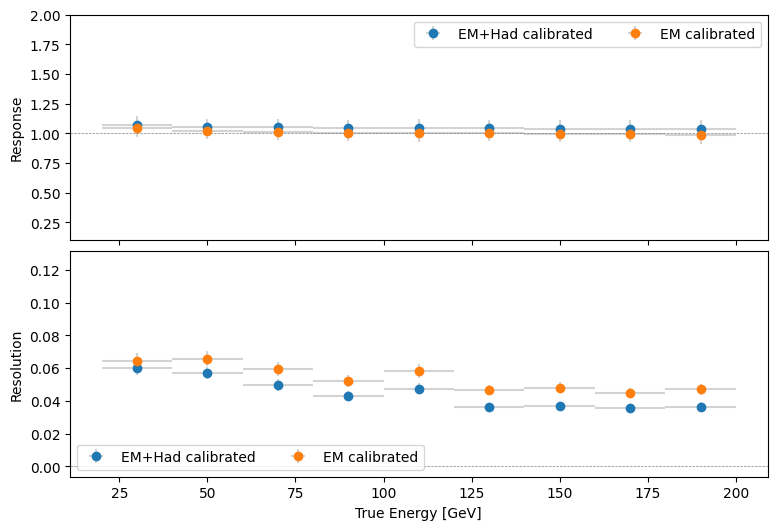

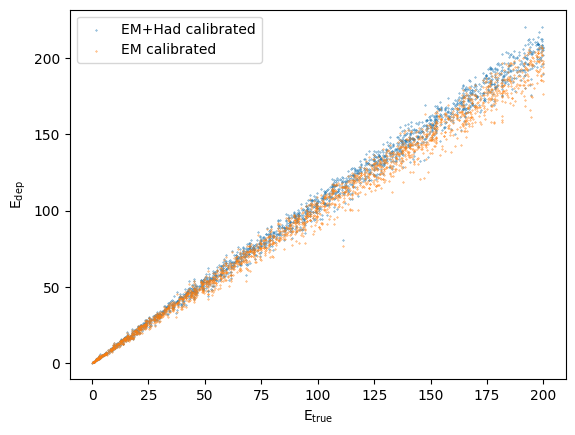

In [134]:
from plotting.general_2d_plot_extensions_2 import ResponseAndResolutionCombinedPlot

binning = np.array([20, 40, 60, 80, 100, 120,140,160,180,200])
plot = ResponseAndResolutionCombinedPlot(bins=binning, x_label='True Energy [GeV]',
                                         y_label1='Response',
                                         y_label2='Resolution',
                                         histogram_log=False,
                                         plot_background_distribution=False, resolution_by_fit=False)

plot.add_raw_values(EM_E_true, EM_E_dep_em_had/EM_E_true,
                                tags={'calib':'both'})

plot.add_raw_values(EM_E_true, EM_E_dep_em/EM_E_true,
                                tags={'calib':'em'})

mydict = {'em':'EM calibrated', 'both': 'EM+Had calibrated'}

name_tag_formatter = lambda x: mydict[x['calib']]
plot.draw(name_tag_formatter=name_tag_formatter, markersize=6, type_='points')



fig,ax = plt.subplots()
ax.scatter(EM_E_true, EM_E_dep_em_had, s=0.1, label=mydict['both'])
ax.scatter(EM_E_true, EM_E_dep_em, s=0.1, label=mydict['em'])
ax.legend()
ax.set_xlabel('E$_\\mathrm{true}$')
ax.set_ylabel('E$_\\mathrm{dep}$')

In [74]:
sensor_data_calibrated = deepcopy(sensor_data)
sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']<28]\
= sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']<28] * g_em


sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']>=28]\
= sensor_data_calibrated['sensors_scaling'][sensor_data_calibrated['sensors_active_layer_num']>=28] * g_had

print(sensor_data_calibrated['sensors_scaling'])

with gzip.open('sensor_data_v3_calibrated.bin', 'wb') as f:
    pickle.dump(sensor_data_calibrated, f)

[   2.96685765    2.96685765    2.96685765 ... 1247.02623729 1247.02623729
 1247.02623729]
